In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)

        self.x = df[['전류(A)', '누적_용량(Ah)', '절대값_용량(Ah)']].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))

        self.y = df.iloc[:, 7:8].values
        
        self.length = len(df)

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [3]:
dataset = CustomDataset("180801_RFB_510cy_006_DC.csv")
print(dataset.x.shape)
print(dataset.x.dtype)
print(dataset.y.shape)
print(dataset.y.dtype)

(262407, 3)
float64
(262407, 1)
float64


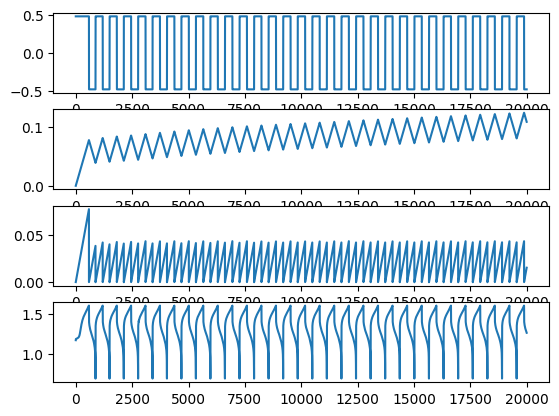

In [4]:
# features.plot(subplots=True)
# plt.show()


plt.subplot(4,1,1)
plt.plot(dataset.x[:20000,:1].squeeze())
plt.subplot(4,1,2)
plt.plot(dataset.x[:20000,1:2].squeeze())
plt.subplot(4,1,3)
plt.plot(dataset.x[:20000,2:3].squeeze())
plt.subplot(4,1,4)
plt.plot(dataset.y[:20000].squeeze())
plt.show()

In [5]:
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 209925
Validation Data Size : 26240
Testing Data Size : 26242


In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=False, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=256, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last=True)

In [7]:
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.batchnormal = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes) 

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        
        output, (hn) = self.gru(x, (h_0)) 
        hn = hn.view(-1, self.hidden_size) 
        out = self.relu(hn)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out)
        return out

In [8]:
num_epochs = 1000
learning_rate = 0.001

input_size = 3
hidden_size = 16
num_layers = 1

num_classes = 1

model = GRU(num_classes, input_size, hidden_size, num_layers, dataset.x.shape[1])
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
def train_loop(model, dataloader, loss_func, optimizer):
    model.train()
    size = len(dataloader.dataset)
    print("Training")
    running_loss = 0.
    last_loss = 0.

    for batch, (x,y) in tqdm(enumerate(dataloader)):
        pred = model(x)
        loss = loss_func(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [10]:
def test_loop(model, dataloader, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(model, train_dataloader, loss_func, optimizer)
    test_loop(model, test_dataloader, loss_func)
print("Done!")

Epoch 1
-------------------------------
Training


0it [00:00, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_11744\1130521825.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  feature = torch.FloatTensor([self.x[index]])
27it [00:00, 266.87it/s]

loss: 1.868432  [  256/209925]


129it [00:00, 319.60it/s]

loss: 0.008069  [25856/209925]


259it [00:00, 311.90it/s]

loss: 0.008631  [51456/209925]


326it [00:01, 280.13it/s]

loss: 0.008819  [77056/209925]


457it [00:01, 313.40it/s]

loss: 0.010098  [102656/209925]


559it [00:01, 320.46it/s]

loss: 0.006773  [128256/209925]


661it [00:02, 323.83it/s]

loss: 0.007796  [153856/209925]


764it [00:02, 327.09it/s]

loss: 0.008072  [179456/209925]


820it [00:02, 311.33it/s]


loss: 0.005964  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.008179 

Epoch 2
-------------------------------
Training


33it [00:00, 322.48it/s]

loss: 0.009634  [  256/209925]


134it [00:00, 323.80it/s]

loss: 0.006400  [25856/209925]


235it [00:00, 307.80it/s]

loss: 0.008377  [51456/209925]


331it [00:01, 275.85it/s]

loss: 0.008577  [77056/209925]


460it [00:01, 309.28it/s]

loss: 0.009794  [102656/209925]


526it [00:01, 311.89it/s]

loss: 0.006466  [128256/209925]


661it [00:02, 323.74it/s]

loss: 0.007488  [153856/209925]


727it [00:02, 320.16it/s]

loss: 0.007777  [179456/209925]


820it [00:02, 308.50it/s]


loss: 0.005773  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.007827 

Epoch 3
-------------------------------
Training


34it [00:00, 339.76it/s]

loss: 0.009332  [  256/209925]


131it [00:00, 288.62it/s]

loss: 0.006032  [25856/209925]


256it [00:00, 304.20it/s]

loss: 0.007887  [51456/209925]


356it [00:01, 301.77it/s]

loss: 0.007841  [77056/209925]


455it [00:01, 317.81it/s]

loss: 0.009037  [102656/209925]


555it [00:01, 320.66it/s]

loss: 0.005607  [128256/209925]


659it [00:02, 327.94it/s]

loss: 0.006350  [153856/209925]


757it [00:02, 320.33it/s]

loss: 0.006376  [179456/209925]


820it [00:02, 306.75it/s]


loss: 0.004538  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.006025 

Epoch 4
-------------------------------
Training


30it [00:00, 287.40it/s]

loss: 0.007401  [  256/209925]


131it [00:00, 323.93it/s]

loss: 0.004079  [25856/209925]


225it [00:00, 288.61it/s]

loss: 0.005273  [51456/209925]


327it [00:01, 295.80it/s]

loss: 0.004455  [77056/209925]


457it [00:01, 308.87it/s]

loss: 0.005013  [102656/209925]


558it [00:01, 321.17it/s]

loss: 0.002487  [128256/209925]


660it [00:02, 329.20it/s]

loss: 0.002885  [153856/209925]


761it [00:02, 327.46it/s]

loss: 0.002824  [179456/209925]


820it [00:02, 312.91it/s]


loss: 0.002280  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.003002 

Epoch 5
-------------------------------
Training


31it [00:00, 303.53it/s]

loss: 0.003756  [  256/209925]


134it [00:00, 331.83it/s]

loss: 0.002167  [25856/209925]


232it [00:00, 259.22it/s]

loss: 0.003088  [51456/209925]


334it [00:01, 309.01it/s]

loss: 0.002724  [77056/209925]


436it [00:01, 303.23it/s]

loss: 0.003375  [102656/209925]


541it [00:01, 321.76it/s]

loss: 0.001450  [128256/209925]


641it [00:02, 320.53it/s]

loss: 0.001840  [153856/209925]


745it [00:02, 332.12it/s]

loss: 0.001742  [179456/209925]


820it [00:02, 315.16it/s]


loss: 0.001229  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.002139 

Epoch 6
-------------------------------
Training


35it [00:00, 336.21it/s]

loss: 0.002646  [  256/209925]


141it [00:00, 323.18it/s]

loss: 0.001404  [25856/209925]


242it [00:00, 294.76it/s]

loss: 0.002317  [51456/209925]


341it [00:01, 313.22it/s]

loss: 0.002179  [77056/209925]


444it [00:01, 323.37it/s]

loss: 0.002777  [102656/209925]


548it [00:01, 334.61it/s]

loss: 0.000934  [128256/209925]


649it [00:02, 326.91it/s]

loss: 0.001522  [153856/209925]


753it [00:02, 330.71it/s]

loss: 0.001404  [179456/209925]


820it [00:02, 318.73it/s]


loss: 0.000830  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001803 

Epoch 7
-------------------------------
Training


34it [00:00, 339.22it/s]

loss: 0.002265  [  256/209925]


132it [00:00, 299.31it/s]

loss: 0.001086  [25856/209925]


226it [00:00, 286.95it/s]

loss: 0.002080  [51456/209925]


324it [00:01, 300.32it/s]

loss: 0.001915  [77056/209925]


457it [00:01, 312.64it/s]

loss: 0.002426  [102656/209925]


522it [00:01, 314.26it/s]

loss: 0.000752  [128256/209925]


657it [00:02, 316.86it/s]

loss: 0.001381  [153856/209925]


753it [00:02, 310.52it/s]

loss: 0.001272  [179456/209925]


820it [00:02, 307.01it/s]


loss: 0.000656  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001415 

Epoch 8
-------------------------------
Training


32it [00:00, 311.69it/s]

loss: 0.001760  [  256/209925]


128it [00:00, 309.63it/s]

loss: 0.000937  [25856/209925]


254it [00:00, 287.13it/s]

loss: 0.001716  [51456/209925]


358it [00:01, 320.62it/s]

loss: 0.001546  [77056/209925]


424it [00:01, 318.20it/s]

loss: 0.001972  [102656/209925]


557it [00:01, 326.43it/s]

loss: 0.000593  [128256/209925]


624it [00:02, 324.98it/s]

loss: 0.001195  [153856/209925]


758it [00:02, 325.58it/s]

loss: 0.001037  [179456/209925]


820it [00:02, 311.83it/s]


loss: 0.000508  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001113 

Epoch 9
-------------------------------
Training


34it [00:00, 332.78it/s]

loss: 0.001307  [  256/209925]


133it [00:00, 280.20it/s]

loss: 0.000816  [25856/209925]


231it [00:00, 306.35it/s]

loss: 0.001404  [51456/209925]


363it [00:01, 321.84it/s]

loss: 0.001269  [77056/209925]


428it [00:01, 309.68it/s]

loss: 0.001578  [102656/209925]


529it [00:01, 322.34it/s]

loss: 0.000475  [128256/209925]


658it [00:02, 310.23it/s]

loss: 0.000876  [153856/209925]


727it [00:02, 322.58it/s]

loss: 0.000913  [179456/209925]


820it [00:02, 311.48it/s]


loss: 0.000415  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000919 

Epoch 10
-------------------------------
Training


33it [00:00, 323.07it/s]

loss: 0.000990  [  256/209925]


133it [00:00, 279.01it/s]

loss: 0.000648  [25856/209925]


235it [00:00, 315.12it/s]

loss: 0.001238  [51456/209925]


333it [00:01, 305.60it/s]

loss: 0.001060  [77056/209925]


437it [00:01, 324.96it/s]

loss: 0.001248  [102656/209925]


538it [00:01, 322.67it/s]

loss: 0.000394  [128256/209925]


641it [00:02, 325.97it/s]

loss: 0.000710  [153856/209925]


743it [00:02, 326.37it/s]

loss: 0.000746  [179456/209925]


820it [00:02, 315.32it/s]


loss: 0.000306  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000807 

Epoch 11
-------------------------------
Training


33it [00:00, 323.51it/s]

loss: 0.000788  [  256/209925]


127it [00:00, 275.12it/s]

loss: 0.000502  [25856/209925]


261it [00:00, 316.99it/s]

loss: 0.001075  [51456/209925]


325it [00:01, 307.58it/s]

loss: 0.000861  [77056/209925]


458it [00:01, 318.38it/s]

loss: 0.001034  [102656/209925]


524it [00:01, 309.93it/s]

loss: 0.000323  [128256/209925]


630it [00:02, 324.23it/s]

loss: 0.000613  [153856/209925]


762it [00:02, 321.78it/s]

loss: 0.000613  [179456/209925]


820it [00:02, 313.29it/s]


loss: 0.000240  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000703 

Epoch 12
-------------------------------
Training


23it [00:00, 182.38it/s]

loss: 0.000639  [  256/209925]


158it [00:00, 318.93it/s]

loss: 0.000409  [25856/209925]


260it [00:00, 328.40it/s]

loss: 0.000860  [51456/209925]


329it [00:01, 329.95it/s]

loss: 0.000679  [77056/209925]


431it [00:01, 327.33it/s]

loss: 0.000828  [102656/209925]


569it [00:01, 333.27it/s]

loss: 0.000277  [128256/209925]


637it [00:01, 327.60it/s]

loss: 0.000511  [153856/209925]


736it [00:02, 318.32it/s]

loss: 0.000530  [179456/209925]


820it [00:02, 317.83it/s]


loss: 0.000213  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000631 

Epoch 13
-------------------------------
Training


32it [00:00, 319.47it/s]

loss: 0.000543  [  256/209925]


132it [00:00, 307.70it/s]

loss: 0.000344  [25856/209925]


263it [00:00, 315.91it/s]

loss: 0.000690  [51456/209925]


366it [00:01, 328.02it/s]

loss: 0.000563  [77056/209925]


433it [00:01, 318.36it/s]

loss: 0.000681  [102656/209925]


536it [00:01, 322.77it/s]

loss: 0.000221  [128256/209925]


639it [00:01, 323.40it/s]

loss: 0.000428  [153856/209925]


739it [00:02, 321.92it/s]

loss: 0.000463  [179456/209925]


820it [00:02, 320.09it/s]


loss: 0.000172  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000556 

Epoch 14
-------------------------------
Training


32it [00:00, 298.85it/s]

loss: 0.000453  [  256/209925]


166it [00:00, 323.92it/s]

loss: 0.000317  [25856/209925]


232it [00:00, 323.73it/s]

loss: 0.000582  [51456/209925]


329it [00:01, 295.63it/s]

loss: 0.000490  [77056/209925]


466it [00:01, 325.07it/s]

loss: 0.000589  [102656/209925]


567it [00:01, 322.55it/s]

loss: 0.000201  [128256/209925]


670it [00:02, 331.72it/s]

loss: 0.000356  [153856/209925]


739it [00:02, 335.20it/s]

loss: 0.000385  [179456/209925]


820it [00:02, 320.85it/s]


loss: 0.000149  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000491 

Epoch 15
-------------------------------
Training


36it [00:00, 345.23it/s]

loss: 0.000384  [  256/209925]


135it [00:00, 309.82it/s]

loss: 0.000295  [25856/209925]


269it [00:00, 326.83it/s]

loss: 0.000519  [51456/209925]


337it [00:01, 321.50it/s]

loss: 0.000448  [77056/209925]


439it [00:01, 329.45it/s]

loss: 0.000519  [102656/209925]


542it [00:01, 334.71it/s]

loss: 0.000197  [128256/209925]


647it [00:01, 337.07it/s]

loss: 0.000300  [153856/209925]


752it [00:02, 338.12it/s]

loss: 0.000330  [179456/209925]


820it [00:02, 327.03it/s]


loss: 0.000133  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000478 

Epoch 16
-------------------------------
Training


33it [00:00, 315.11it/s]

loss: 0.000372  [  256/209925]


134it [00:00, 324.14it/s]

loss: 0.000285  [25856/209925]


236it [00:00, 328.98it/s]

loss: 0.000486  [51456/209925]


338it [00:01, 328.91it/s]

loss: 0.000401  [77056/209925]


442it [00:01, 330.75it/s]

loss: 0.000471  [102656/209925]


544it [00:01, 331.11it/s]

loss: 0.000200  [128256/209925]


649it [00:01, 330.47it/s]

loss: 0.000269  [153856/209925]


752it [00:02, 328.70it/s]

loss: 0.000300  [179456/209925]


820it [00:02, 321.95it/s]


loss: 0.000126  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000453 

Epoch 17
-------------------------------
Training


33it [00:00, 323.93it/s]

loss: 0.000336  [  256/209925]


135it [00:00, 315.20it/s]

loss: 0.000273  [25856/209925]


234it [00:00, 307.53it/s]

loss: 0.000481  [51456/209925]


339it [00:01, 328.21it/s]

loss: 0.000369  [77056/209925]


440it [00:01, 319.73it/s]

loss: 0.000425  [102656/209925]


546it [00:01, 333.71it/s]

loss: 0.000210  [128256/209925]


648it [00:02, 318.66it/s]

loss: 0.000246  [153856/209925]


747it [00:02, 323.56it/s]

loss: 0.000274  [179456/209925]


820it [00:02, 316.26it/s]


loss: 0.000124  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000437 

Epoch 18
-------------------------------
Training


35it [00:00, 336.81it/s]

loss: 0.000312  [  256/209925]


136it [00:00, 305.66it/s]

loss: 0.000275  [25856/209925]


239it [00:00, 326.54it/s]

loss: 0.000473  [51456/209925]


340it [00:01, 322.98it/s]

loss: 0.000339  [77056/209925]


441it [00:01, 318.49it/s]

loss: 0.000396  [102656/209925]


540it [00:01, 308.95it/s]

loss: 0.000216  [128256/209925]


640it [00:02, 319.47it/s]

loss: 0.000229  [153856/209925]


738it [00:02, 265.62it/s]

loss: 0.000252  [179456/209925]


820it [00:02, 310.07it/s]


loss: 0.000122  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000426 

Epoch 19
-------------------------------
Training


33it [00:00, 328.72it/s]

loss: 0.000295  [  256/209925]


134it [00:00, 324.23it/s]

loss: 0.000269  [25856/209925]


234it [00:00, 327.41it/s]

loss: 0.000470  [51456/209925]


335it [00:01, 311.32it/s]

loss: 0.000318  [77056/209925]


436it [00:01, 321.18it/s]

loss: 0.000368  [102656/209925]


537it [00:01, 324.19it/s]

loss: 0.000226  [128256/209925]


641it [00:01, 330.26it/s]

loss: 0.000220  [153856/209925]


708it [00:02, 324.52it/s]

loss: 0.000240  [179456/209925]


820it [00:02, 315.08it/s]


loss: 0.000116  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000411 

Epoch 20
-------------------------------
Training


32it [00:00, 307.20it/s]

loss: 0.000274  [  256/209925]


168it [00:00, 325.88it/s]

loss: 0.000269  [25856/209925]


234it [00:00, 317.69it/s]

loss: 0.000465  [51456/209925]


336it [00:01, 328.47it/s]

loss: 0.000297  [77056/209925]


437it [00:01, 316.09it/s]

loss: 0.000347  [102656/209925]


536it [00:01, 318.46it/s]

loss: 0.000231  [128256/209925]


633it [00:01, 303.56it/s]

loss: 0.000212  [153856/209925]


733it [00:02, 288.06it/s]

loss: 0.000229  [179456/209925]


820it [00:02, 313.39it/s]


loss: 0.000108  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000404 

Epoch 21
-------------------------------
Training


36it [00:00, 347.75it/s]

loss: 0.000262  [  256/209925]


142it [00:00, 333.98it/s]

loss: 0.000266  [25856/209925]


242it [00:00, 318.33it/s]

loss: 0.000465  [51456/209925]


346it [00:01, 330.83it/s]

loss: 0.000282  [77056/209925]


446it [00:01, 321.06it/s]

loss: 0.000328  [102656/209925]


548it [00:01, 325.56it/s]

loss: 0.000231  [128256/209925]


651it [00:01, 324.89it/s]

loss: 0.000195  [153856/209925]


751it [00:02, 305.66it/s]

loss: 0.000220  [179456/209925]


820it [00:02, 319.03it/s]


loss: 0.000108  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000395 

Epoch 22
-------------------------------
Training


34it [00:00, 329.65it/s]

loss: 0.000250  [  256/209925]


141it [00:00, 324.41it/s]

loss: 0.000261  [25856/209925]


243it [00:00, 328.14it/s]

loss: 0.000466  [51456/209925]


342it [00:01, 310.53it/s]

loss: 0.000270  [77056/209925]


445it [00:01, 321.46it/s]

loss: 0.000314  [102656/209925]


549it [00:01, 331.07it/s]

loss: 0.000230  [128256/209925]


616it [00:01, 323.02it/s]

loss: 0.000191  [153856/209925]


752it [00:02, 315.79it/s]

loss: 0.000216  [179456/209925]


820it [00:02, 317.11it/s]


loss: 0.000109  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000388 

Epoch 23
-------------------------------
Training


34it [00:00, 335.93it/s]

loss: 0.000243  [  256/209925]


133it [00:00, 307.23it/s]

loss: 0.000260  [25856/209925]


236it [00:00, 317.94it/s]

loss: 0.000468  [51456/209925]


336it [00:01, 313.87it/s]

loss: 0.000260  [77056/209925]


442it [00:01, 331.00it/s]

loss: 0.000301  [102656/209925]


543it [00:01, 320.81it/s]

loss: 0.000229  [128256/209925]


642it [00:02, 293.08it/s]

loss: 0.000186  [153856/209925]


743it [00:02, 309.60it/s]

loss: 0.000208  [179456/209925]


820it [00:02, 313.59it/s]


loss: 0.000110  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000378 

Epoch 24
-------------------------------
Training


28it [00:00, 276.01it/s]

loss: 0.000236  [  256/209925]


163it [00:00, 329.99it/s]

loss: 0.000260  [25856/209925]


229it [00:00, 329.05it/s]

loss: 0.000474  [51456/209925]


365it [00:01, 332.90it/s]

loss: 0.000249  [77056/209925]


433it [00:01, 330.25it/s]

loss: 0.000286  [102656/209925]


535it [00:01, 320.92it/s]

loss: 0.000226  [128256/209925]


638it [00:02, 298.45it/s]

loss: 0.000182  [153856/209925]


737it [00:02, 311.66it/s]

loss: 0.000200  [179456/209925]


820it [00:02, 313.18it/s]

loss: 0.000110  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000370 

Epoch 25
-------------------------------
Training


32it [00:00, 319.46it/s]

loss: 0.000227  [  256/209925]


136it [00:00, 326.97it/s]

loss: 0.000251  [25856/209925]


235it [00:00, 314.98it/s]

loss: 0.000473  [51456/209925]


336it [00:01, 326.68it/s]

loss: 0.000241  [77056/209925]


438it [00:01, 327.51it/s]

loss: 0.000274  [102656/209925]


540it [00:01, 329.27it/s]

loss: 0.000224  [128256/209925]


636it [00:02, 284.62it/s]

loss: 0.000174  [153856/209925]


736it [00:02, 305.70it/s]

loss: 0.000188  [179456/209925]


820it [00:02, 313.91it/s]


loss: 0.000117  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000361 

Epoch 26
-------------------------------
Training


34it [00:00, 329.84it/s]

loss: 0.000217  [  256/209925]


134it [00:00, 333.54it/s]

loss: 0.000243  [25856/209925]


235it [00:00, 324.47it/s]

loss: 0.000463  [51456/209925]


337it [00:01, 325.43it/s]

loss: 0.000231  [77056/209925]


435it [00:01, 315.11it/s]

loss: 0.000265  [102656/209925]


535it [00:01, 285.36it/s]

loss: 0.000221  [128256/209925]


665it [00:02, 309.63it/s]

loss: 0.000166  [153856/209925]


768it [00:02, 325.86it/s]

loss: 0.000183  [179456/209925]


820it [00:02, 315.62it/s]


loss: 0.000116  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000349 

Epoch 27
-------------------------------
Training


34it [00:00, 339.54it/s]

loss: 0.000203  [  256/209925]


134it [00:00, 309.25it/s]

loss: 0.000234  [25856/209925]


231it [00:00, 318.38it/s]

loss: 0.000464  [51456/209925]


330it [00:01, 310.77it/s]

loss: 0.000223  [77056/209925]


458it [00:01, 308.91it/s]

loss: 0.000259  [102656/209925]


557it [00:01, 283.55it/s]

loss: 0.000200  [128256/209925]


659it [00:02, 315.63it/s]

loss: 0.000161  [153856/209925]


727it [00:02, 311.66it/s]

loss: 0.000179  [179456/209925]


820it [00:02, 310.07it/s]


loss: 0.000114  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000340 

Epoch 28
-------------------------------
Training


33it [00:00, 322.89it/s]

loss: 0.000194  [  256/209925]


134it [00:00, 324.28it/s]

loss: 0.000235  [25856/209925]


236it [00:00, 333.06it/s]

loss: 0.000449  [51456/209925]


336it [00:01, 321.07it/s]

loss: 0.000214  [77056/209925]


439it [00:01, 326.29it/s]

loss: 0.000255  [102656/209925]


538it [00:01, 301.08it/s]

loss: 0.000207  [128256/209925]


639it [00:02, 320.09it/s]

loss: 0.000161  [153856/209925]


737it [00:02, 315.57it/s]

loss: 0.000179  [179456/209925]


820it [00:02, 316.89it/s]


loss: 0.000111  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000342 

Epoch 29
-------------------------------
Training


22it [00:00, 213.90it/s]

loss: 0.000196  [  256/209925]


156it [00:00, 324.06it/s]

loss: 0.000234  [25856/209925]


257it [00:00, 320.82it/s]

loss: 0.000445  [51456/209925]


357it [00:01, 326.46it/s]

loss: 0.000216  [77056/209925]


425it [00:01, 327.26it/s]

loss: 0.000251  [102656/209925]


526it [00:01, 302.06it/s]

loss: 0.000205  [128256/209925]


628it [00:02, 322.29it/s]

loss: 0.000164  [153856/209925]


728it [00:02, 324.25it/s]

loss: 0.000176  [179456/209925]


820it [00:02, 314.58it/s]


loss: 0.000105  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000338 

Epoch 30
-------------------------------
Training


31it [00:00, 305.26it/s]

loss: 0.000192  [  256/209925]


165it [00:00, 322.50it/s]

loss: 0.000223  [25856/209925]


264it [00:00, 321.39it/s]

loss: 0.000441  [51456/209925]


331it [00:01, 324.30it/s]

loss: 0.000216  [77056/209925]


430it [00:01, 277.59it/s]

loss: 0.000248  [102656/209925]


530it [00:01, 310.48it/s]

loss: 0.000201  [128256/209925]


667it [00:02, 314.69it/s]

loss: 0.000165  [153856/209925]


734it [00:02, 319.72it/s]

loss: 0.000175  [179456/209925]


820it [00:02, 313.96it/s]


loss: 0.000101  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000339 

Epoch 31
-------------------------------
Training


34it [00:00, 337.65it/s]

loss: 0.000194  [  256/209925]


135it [00:00, 313.19it/s]

loss: 0.000218  [25856/209925]


238it [00:00, 321.12it/s]

loss: 0.000435  [51456/209925]


337it [00:01, 322.35it/s]

loss: 0.000210  [77056/209925]


434it [00:01, 287.04it/s]

loss: 0.000243  [102656/209925]


565it [00:01, 311.26it/s]

loss: 0.000191  [128256/209925]


633it [00:02, 322.22it/s]

loss: 0.000168  [153856/209925]


733it [00:02, 306.43it/s]

loss: 0.000171  [179456/209925]


820it [00:02, 311.03it/s]


loss: 0.000099  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000341 

Epoch 32
-------------------------------
Training


36it [00:00, 345.94it/s]

loss: 0.000197  [  256/209925]


135it [00:00, 307.37it/s]

loss: 0.000213  [25856/209925]


236it [00:00, 306.56it/s]

loss: 0.000436  [51456/209925]


333it [00:01, 312.73it/s]

loss: 0.000207  [77056/209925]


434it [00:01, 297.88it/s]

loss: 0.000236  [102656/209925]


564it [00:01, 312.40it/s]

loss: 0.000187  [128256/209925]


633it [00:02, 323.92it/s]

loss: 0.000167  [153856/209925]


734it [00:02, 311.31it/s]

loss: 0.000170  [179456/209925]


820it [00:02, 311.11it/s]


loss: 0.000100  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000337 

Epoch 33
-------------------------------
Training


35it [00:00, 324.09it/s]

loss: 0.000193  [  256/209925]


133it [00:00, 317.13it/s]

loss: 0.000207  [25856/209925]


234it [00:00, 321.66it/s]

loss: 0.000429  [51456/209925]


331it [00:01, 315.06it/s]

loss: 0.000207  [77056/209925]


461it [00:01, 299.02it/s]

loss: 0.000234  [102656/209925]


561it [00:01, 319.98it/s]

loss: 0.000187  [128256/209925]


629it [00:02, 322.42it/s]

loss: 0.000166  [153856/209925]


761it [00:02, 299.97it/s]

loss: 0.000170  [179456/209925]


820it [00:02, 309.37it/s]


loss: 0.000098  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000331 

Epoch 34
-------------------------------
Training


34it [00:00, 314.31it/s]

loss: 0.000188  [  256/209925]


137it [00:00, 333.73it/s]

loss: 0.000205  [25856/209925]


237it [00:00, 316.25it/s]

loss: 0.000430  [51456/209925]


338it [00:01, 289.38it/s]

loss: 0.000205  [77056/209925]


434it [00:01, 303.64it/s]

loss: 0.000230  [102656/209925]


534it [00:01, 319.83it/s]

loss: 0.000181  [128256/209925]


635it [00:02, 327.32it/s]

loss: 0.000164  [153856/209925]


736it [00:02, 325.30it/s]

loss: 0.000172  [179456/209925]


820it [00:02, 317.87it/s]


loss: 0.000096  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000327 

Epoch 35
-------------------------------
Training


34it [00:00, 329.88it/s]

loss: 0.000186  [  256/209925]


133it [00:00, 320.69it/s]

loss: 0.000207  [25856/209925]


230it [00:00, 311.29it/s]

loss: 0.000431  [51456/209925]


326it [00:01, 259.25it/s]

loss: 0.000205  [77056/209925]


446it [00:01, 279.48it/s]

loss: 0.000225  [102656/209925]


538it [00:01, 288.03it/s]

loss: 0.000177  [128256/209925]


638it [00:02, 315.06it/s]

loss: 0.000164  [153856/209925]


741it [00:02, 325.21it/s]

loss: 0.000171  [179456/209925]


820it [00:02, 300.23it/s]


loss: 0.000094  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000324 

Epoch 36
-------------------------------
Training


35it [00:00, 330.13it/s]

loss: 0.000184  [  256/209925]


140it [00:00, 332.88it/s]

loss: 0.000204  [25856/209925]


243it [00:00, 328.83it/s]

loss: 0.000432  [51456/209925]


343it [00:01, 306.97it/s]

loss: 0.000203  [77056/209925]


448it [00:01, 327.10it/s]

loss: 0.000224  [102656/209925]


549it [00:01, 324.15it/s]

loss: 0.000171  [128256/209925]


654it [00:02, 335.16it/s]

loss: 0.000161  [153856/209925]


754it [00:02, 310.12it/s]

loss: 0.000167  [179456/209925]


820it [00:02, 320.32it/s]


loss: 0.000095  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000323 

Epoch 37
-------------------------------
Training


31it [00:00, 307.56it/s]

loss: 0.000185  [  256/209925]


131it [00:00, 321.89it/s]

loss: 0.000202  [25856/209925]


231it [00:00, 276.99it/s]

loss: 0.000430  [51456/209925]


361it [00:01, 311.02it/s]

loss: 0.000206  [77056/209925]


429it [00:01, 318.68it/s]

loss: 0.000222  [102656/209925]


529it [00:01, 316.99it/s]

loss: 0.000170  [128256/209925]


632it [00:02, 325.03it/s]

loss: 0.000158  [153856/209925]


771it [00:02, 328.50it/s]

loss: 0.000166  [179456/209925]


820it [00:02, 315.38it/s]


loss: 0.000094  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000323 

Epoch 38
-------------------------------
Training


33it [00:00, 328.47it/s]

loss: 0.000187  [  256/209925]


139it [00:00, 335.13it/s]

loss: 0.000199  [25856/209925]


242it [00:00, 275.59it/s]

loss: 0.000426  [51456/209925]


342it [00:01, 309.61it/s]

loss: 0.000205  [77056/209925]


441it [00:01, 312.91it/s]

loss: 0.000222  [102656/209925]


535it [00:01, 287.23it/s]

loss: 0.000169  [128256/209925]


664it [00:02, 309.27it/s]

loss: 0.000151  [153856/209925]


733it [00:02, 325.45it/s]

loss: 0.000163  [179456/209925]


820it [00:02, 307.18it/s]


loss: 0.000089  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000325 

Epoch 39
-------------------------------
Training


35it [00:00, 342.53it/s]

loss: 0.000189  [  256/209925]


138it [00:00, 322.42it/s]

loss: 0.000197  [25856/209925]


238it [00:00, 294.82it/s]

loss: 0.000422  [51456/209925]


340it [00:01, 322.44it/s]

loss: 0.000204  [77056/209925]


442it [00:01, 328.17it/s]

loss: 0.000219  [102656/209925]


545it [00:01, 335.41it/s]

loss: 0.000168  [128256/209925]


646it [00:02, 317.77it/s]

loss: 0.000148  [153856/209925]


748it [00:02, 329.65it/s]

loss: 0.000161  [179456/209925]


820it [00:02, 318.75it/s]


loss: 0.000087  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000320 

Epoch 40
-------------------------------
Training


35it [00:00, 342.90it/s]

loss: 0.000185  [  256/209925]


138it [00:00, 321.32it/s]

loss: 0.000197  [25856/209925]


240it [00:00, 302.41it/s]

loss: 0.000417  [51456/209925]


337it [00:01, 309.17it/s]

loss: 0.000201  [77056/209925]


435it [00:01, 312.85it/s]

loss: 0.000220  [102656/209925]


534it [00:01, 313.69it/s]

loss: 0.000166  [128256/209925]


632it [00:02, 318.54it/s]

loss: 0.000144  [153856/209925]


733it [00:02, 321.62it/s]

loss: 0.000158  [179456/209925]


820it [00:02, 313.10it/s]


loss: 0.000085  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000319 

Epoch 41
-------------------------------
Training


33it [00:00, 326.29it/s]

loss: 0.000185  [  256/209925]


126it [00:00, 250.60it/s]

loss: 0.000194  [25856/209925]


232it [00:00, 307.12it/s]

loss: 0.000403  [51456/209925]


330it [00:01, 316.86it/s]

loss: 0.000191  [77056/209925]


435it [00:01, 329.52it/s]

loss: 0.000220  [102656/209925]


538it [00:01, 317.07it/s]

loss: 0.000161  [128256/209925]


638it [00:02, 323.38it/s]

loss: 0.000145  [153856/209925]


738it [00:02, 317.70it/s]

loss: 0.000157  [179456/209925]


820it [00:02, 314.40it/s]


loss: 0.000083  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000323 

Epoch 42
-------------------------------
Training


33it [00:00, 318.75it/s]

loss: 0.000191  [  256/209925]


157it [00:00, 273.22it/s]

loss: 0.000193  [25856/209925]


247it [00:00, 288.71it/s]

loss: 0.000392  [51456/209925]


350it [00:01, 317.64it/s]

loss: 0.000185  [77056/209925]


418it [00:01, 326.82it/s]

loss: 0.000218  [102656/209925]


550it [00:01, 312.18it/s]

loss: 0.000158  [128256/209925]


649it [00:02, 314.67it/s]

loss: 0.000139  [153856/209925]


748it [00:02, 323.39it/s]

loss: 0.000155  [179456/209925]


820it [00:02, 307.30it/s]


loss: 0.000082  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000319 

Epoch 43
-------------------------------
Training


37it [00:00, 345.09it/s]

loss: 0.000187  [  256/209925]


136it [00:00, 293.11it/s]

loss: 0.000194  [25856/209925]


268it [00:00, 319.63it/s]

loss: 0.000386  [51456/209925]


335it [00:01, 323.74it/s]

loss: 0.000183  [77056/209925]


433it [00:01, 313.70it/s]

loss: 0.000214  [102656/209925]


534it [00:01, 322.78it/s]

loss: 0.000156  [128256/209925]


633it [00:02, 311.34it/s]

loss: 0.000135  [153856/209925]


734it [00:02, 319.89it/s]

loss: 0.000152  [179456/209925]


820it [00:02, 313.63it/s]


loss: 0.000081  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000321 

Epoch 44
-------------------------------
Training


32it [00:00, 309.09it/s]

loss: 0.000190  [  256/209925]


128it [00:00, 278.51it/s]

loss: 0.000195  [25856/209925]


266it [00:00, 325.66it/s]

loss: 0.000381  [51456/209925]


332it [00:01, 308.95it/s]

loss: 0.000181  [77056/209925]


433it [00:01, 325.26it/s]

loss: 0.000213  [102656/209925]


535it [00:01, 329.64it/s]

loss: 0.000154  [128256/209925]


635it [00:02, 322.55it/s]

loss: 0.000129  [153856/209925]


736it [00:02, 321.57it/s]

loss: 0.000149  [179456/209925]


820it [00:02, 314.05it/s]


loss: 0.000081  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000318 

Epoch 45
-------------------------------
Training


15it [00:00, 134.63it/s]

loss: 0.000189  [  256/209925]


134it [00:00, 271.87it/s]

loss: 0.000191  [25856/209925]


247it [00:00, 269.40it/s]

loss: 0.000373  [51456/209925]


339it [00:01, 285.50it/s]

loss: 0.000175  [77056/209925]


437it [00:01, 307.88it/s]

loss: 0.000213  [102656/209925]


566it [00:01, 317.96it/s]

loss: 0.000151  [128256/209925]


634it [00:02, 323.77it/s]

loss: 0.000128  [153856/209925]


733it [00:02, 321.19it/s]

loss: 0.000147  [179456/209925]


820it [00:02, 296.35it/s]


loss: 0.000081  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000316 

Epoch 46
-------------------------------
Training


31it [00:00, 303.55it/s]

loss: 0.000190  [  256/209925]


131it [00:00, 321.08it/s]

loss: 0.000191  [25856/209925]


262it [00:00, 317.25it/s]

loss: 0.000369  [51456/209925]


329it [00:01, 324.35it/s]

loss: 0.000173  [77056/209925]


429it [00:01, 311.11it/s]

loss: 0.000213  [102656/209925]


529it [00:01, 319.19it/s]

loss: 0.000148  [128256/209925]


657it [00:02, 301.36it/s]

loss: 0.000125  [153856/209925]


757it [00:02, 317.99it/s]

loss: 0.000145  [179456/209925]


820it [00:02, 316.84it/s]


loss: 0.000081  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000315 

Epoch 47
-------------------------------
Training


34it [00:00, 337.01it/s]

loss: 0.000191  [  256/209925]


135it [00:00, 319.27it/s]

loss: 0.000192  [25856/209925]


235it [00:00, 320.95it/s]

loss: 0.000365  [51456/209925]


335it [00:01, 321.44it/s]

loss: 0.000171  [77056/209925]


434it [00:01, 318.02it/s]

loss: 0.000213  [102656/209925]


537it [00:01, 328.17it/s]

loss: 0.000142  [128256/209925]


635it [00:01, 316.61it/s]

loss: 0.000122  [153856/209925]


737it [00:02, 325.32it/s]

loss: 0.000142  [179456/209925]


820it [00:02, 322.22it/s]


loss: 0.000082  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000312 

Epoch 48
-------------------------------
Training


34it [00:00, 320.50it/s]

loss: 0.000189  [  256/209925]


131it [00:00, 300.96it/s]

loss: 0.000194  [25856/209925]


262it [00:00, 316.67it/s]

loss: 0.000360  [51456/209925]


327it [00:01, 306.95it/s]

loss: 0.000167  [77056/209925]


460it [00:01, 325.41it/s]

loss: 0.000216  [102656/209925]


529it [00:01, 327.83it/s]

loss: 0.000141  [128256/209925]


661it [00:02, 324.47it/s]

loss: 0.000123  [153856/209925]


727it [00:02, 324.64it/s]

loss: 0.000140  [179456/209925]


820it [00:02, 317.81it/s]


loss: 0.000082  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000313 

Epoch 49
-------------------------------
Training


32it [00:00, 304.36it/s]

loss: 0.000191  [  256/209925]


167it [00:00, 324.43it/s]

loss: 0.000193  [25856/209925]


234it [00:00, 326.54it/s]

loss: 0.000360  [51456/209925]


368it [00:01, 324.14it/s]

loss: 0.000163  [77056/209925]


469it [00:01, 324.48it/s]

loss: 0.000215  [102656/209925]


533it [00:01, 304.71it/s]

loss: 0.000139  [128256/209925]


637it [00:01, 320.84it/s]

loss: 0.000118  [153856/209925]


739it [00:02, 323.60it/s]

loss: 0.000140  [179456/209925]


820it [00:02, 313.65it/s]

loss: 0.000083  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000308 

Epoch 50
-------------------------------
Training


35it [00:00, 329.44it/s]

loss: 0.000187  [  256/209925]


135it [00:00, 326.62it/s]

loss: 0.000194  [25856/209925]


239it [00:00, 327.40it/s]

loss: 0.000357  [51456/209925]


341it [00:01, 321.96it/s]

loss: 0.000161  [77056/209925]


444it [00:01, 328.55it/s]

loss: 0.000216  [102656/209925]


542it [00:01, 315.00it/s]

loss: 0.000137  [128256/209925]


640it [00:02, 314.49it/s]

loss: 0.000114  [153856/209925]


739it [00:02, 309.34it/s]

loss: 0.000140  [179456/209925]


820it [00:02, 313.14it/s]

loss: 0.000084  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000302 

Epoch 51
-------------------------------
Training


28it [00:00, 277.89it/s]

loss: 0.000184  [  256/209925]


157it [00:00, 319.48it/s]

loss: 0.000196  [25856/209925]


253it [00:00, 311.66it/s]

loss: 0.000352  [51456/209925]


351it [00:01, 317.00it/s]

loss: 0.000156  [77056/209925]


451it [00:01, 318.25it/s]

loss: 0.000219  [102656/209925]


552it [00:01, 322.90it/s]

loss: 0.000135  [128256/209925]


652it [00:02, 317.56it/s]

loss: 0.000112  [153856/209925]


719it [00:02, 319.21it/s]

loss: 0.000139  [179456/209925]


820it [00:02, 309.01it/s]


loss: 0.000084  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000288 

Epoch 52
-------------------------------
Training


35it [00:00, 320.71it/s]

loss: 0.000181  [  256/209925]


135it [00:00, 315.57it/s]

loss: 0.000195  [25856/209925]


236it [00:00, 326.59it/s]

loss: 0.000343  [51456/209925]


335it [00:01, 308.70it/s]

loss: 0.000143  [77056/209925]


433it [00:01, 317.08it/s]

loss: 0.000223  [102656/209925]


536it [00:01, 327.11it/s]

loss: 0.000124  [128256/209925]


633it [00:01, 316.84it/s]

loss: 0.000112  [153856/209925]


730it [00:02, 274.59it/s]

loss: 0.000131  [179456/209925]


820it [00:02, 312.25it/s]


loss: 0.000085  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000265 

Epoch 53
-------------------------------
Training


34it [00:00, 336.57it/s]

loss: 0.000170  [  256/209925]


134it [00:00, 317.66it/s]

loss: 0.000203  [25856/209925]


236it [00:00, 320.30it/s]

loss: 0.000342  [51456/209925]


336it [00:01, 301.19it/s]

loss: 0.000126  [77056/209925]


436it [00:01, 320.83it/s]

loss: 0.000219  [102656/209925]


536it [00:01, 320.18it/s]

loss: 0.000117  [128256/209925]


639it [00:01, 331.55it/s]

loss: 0.000107  [153856/209925]


738it [00:02, 289.33it/s]

loss: 0.000118  [179456/209925]


820it [00:02, 314.68it/s]


loss: 0.000083  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000245 

Epoch 54
-------------------------------
Training


30it [00:00, 296.17it/s]

loss: 0.000162  [  256/209925]


135it [00:00, 329.51it/s]

loss: 0.000208  [25856/209925]


239it [00:00, 332.36it/s]

loss: 0.000340  [51456/209925]


341it [00:01, 317.03it/s]

loss: 0.000117  [77056/209925]


443it [00:01, 323.56it/s]

loss: 0.000218  [102656/209925]


543it [00:01, 312.46it/s]

loss: 0.000103  [128256/209925]


646it [00:02, 325.36it/s]

loss: 0.000109  [153856/209925]


747it [00:02, 302.77it/s]

loss: 0.000111  [179456/209925]


820it [00:02, 315.31it/s]


loss: 0.000078  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000225 

Epoch 55
-------------------------------
Training


32it [00:00, 316.26it/s]

loss: 0.000149  [  256/209925]


137it [00:00, 327.68it/s]

loss: 0.000206  [25856/209925]


237it [00:00, 317.87it/s]

loss: 0.000336  [51456/209925]


337it [00:01, 326.64it/s]

loss: 0.000110  [77056/209925]


438it [00:01, 314.97it/s]

loss: 0.000215  [102656/209925]


539it [00:01, 320.65it/s]

loss: 0.000097  [128256/209925]


637it [00:02, 268.49it/s]

loss: 0.000110  [153856/209925]


736it [00:02, 299.39it/s]

loss: 0.000108  [179456/209925]


820it [00:02, 311.95it/s]


loss: 0.000075  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000216 

Epoch 56
-------------------------------
Training


35it [00:00, 341.81it/s]

loss: 0.000142  [  256/209925]


141it [00:00, 333.59it/s]

loss: 0.000203  [25856/209925]


244it [00:00, 327.50it/s]

loss: 0.000337  [51456/209925]


347it [00:01, 326.84it/s]

loss: 0.000104  [77056/209925]


449it [00:01, 326.78it/s]

loss: 0.000209  [102656/209925]


551it [00:01, 330.98it/s]

loss: 0.000096  [128256/209925]


618it [00:01, 275.97it/s]

loss: 0.000110  [153856/209925]


758it [00:02, 319.22it/s]

loss: 0.000102  [179456/209925]


820it [00:02, 315.52it/s]


loss: 0.000075  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000206 

Epoch 57
-------------------------------
Training


34it [00:00, 339.10it/s]

loss: 0.000134  [  256/209925]


134it [00:00, 313.73it/s]

loss: 0.000204  [25856/209925]


266it [00:00, 323.77it/s]

loss: 0.000340  [51456/209925]


332it [00:01, 309.55it/s]

loss: 0.000099  [77056/209925]


432it [00:01, 316.14it/s]

loss: 0.000204  [102656/209925]


532it [00:01, 316.37it/s]

loss: 0.000096  [128256/209925]


662it [00:02, 296.75it/s]

loss: 0.000111  [153856/209925]


758it [00:02, 305.55it/s]

loss: 0.000099  [179456/209925]


820it [00:02, 311.00it/s]


loss: 0.000073  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000203 

Epoch 58
-------------------------------
Training


30it [00:00, 292.98it/s]

loss: 0.000131  [  256/209925]


161it [00:00, 313.96it/s]

loss: 0.000204  [25856/209925]


228it [00:00, 318.00it/s]

loss: 0.000340  [51456/209925]


357it [00:01, 312.74it/s]

loss: 0.000094  [77056/209925]


450it [00:01, 293.37it/s]

loss: 0.000200  [102656/209925]


549it [00:01, 312.69it/s]

loss: 0.000104  [128256/209925]


647it [00:02, 296.98it/s]

loss: 0.000111  [153856/209925]


745it [00:02, 311.49it/s]

loss: 0.000095  [179456/209925]


820it [00:02, 303.73it/s]


loss: 0.000071  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000198 

Epoch 59
-------------------------------
Training


35it [00:00, 339.35it/s]

loss: 0.000127  [  256/209925]


136it [00:00, 321.74it/s]

loss: 0.000202  [25856/209925]


234it [00:00, 310.61it/s]

loss: 0.000332  [51456/209925]


331it [00:01, 306.07it/s]

loss: 0.000091  [77056/209925]


461it [00:01, 316.27it/s]

loss: 0.000196  [102656/209925]


526it [00:01, 276.51it/s]

loss: 0.000103  [128256/209925]


654it [00:02, 306.79it/s]

loss: 0.000113  [153856/209925]


725it [00:02, 320.75it/s]

loss: 0.000092  [179456/209925]


820it [00:02, 308.05it/s]


loss: 0.000070  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000198 

Epoch 60
-------------------------------
Training


34it [00:00, 331.20it/s]

loss: 0.000127  [  256/209925]


136it [00:00, 324.21it/s]

loss: 0.000200  [25856/209925]


236it [00:00, 326.68it/s]

loss: 0.000331  [51456/209925]


334it [00:01, 319.15it/s]

loss: 0.000089  [77056/209925]


433it [00:01, 320.80it/s]

loss: 0.000197  [102656/209925]


531it [00:01, 263.12it/s]

loss: 0.000101  [128256/209925]


633it [00:02, 304.51it/s]

loss: 0.000114  [153856/209925]


765it [00:02, 319.80it/s]

loss: 0.000090  [179456/209925]


820it [00:02, 312.34it/s]


loss: 0.000069  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000198 

Epoch 61
-------------------------------
Training


30it [00:00, 296.40it/s]

loss: 0.000128  [  256/209925]


166it [00:00, 323.42it/s]

loss: 0.000200  [25856/209925]


232it [00:00, 313.02it/s]

loss: 0.000328  [51456/209925]


362it [00:01, 318.94it/s]

loss: 0.000086  [77056/209925]


426it [00:01, 317.17it/s]

loss: 0.000195  [102656/209925]


547it [00:01, 261.56it/s]

loss: 0.000100  [128256/209925]


642it [00:02, 289.63it/s]

loss: 0.000113  [153856/209925]


736it [00:02, 284.30it/s]

loss: 0.000089  [179456/209925]


820it [00:02, 295.45it/s]


loss: 0.000067  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000195 

Epoch 62
-------------------------------
Training


35it [00:00, 326.82it/s]

loss: 0.000125  [  256/209925]


134it [00:00, 312.31it/s]

loss: 0.000198  [25856/209925]


233it [00:00, 320.45it/s]

loss: 0.000327  [51456/209925]


334it [00:01, 321.62it/s]

loss: 0.000085  [77056/209925]


434it [00:01, 320.42it/s]

loss: 0.000192  [102656/209925]


561it [00:01, 295.10it/s]

loss: 0.000100  [128256/209925]


659it [00:02, 312.55it/s]

loss: 0.000113  [153856/209925]


754it [00:02, 302.07it/s]

loss: 0.000086  [179456/209925]


820it [00:02, 307.84it/s]


loss: 0.000064  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000196 

Epoch 63
-------------------------------
Training


31it [00:00, 303.69it/s]

loss: 0.000126  [  256/209925]


156it [00:00, 302.91it/s]

loss: 0.000197  [25856/209925]


252it [00:00, 305.26it/s]

loss: 0.000323  [51456/209925]


347it [00:01, 308.47it/s]

loss: 0.000084  [77056/209925]


410it [00:01, 308.90it/s]

loss: 0.000191  [102656/209925]


531it [00:01, 276.38it/s]

loss: 0.000099  [128256/209925]


629it [00:02, 299.18it/s]

loss: 0.000115  [153856/209925]


757it [00:02, 311.46it/s]

loss: 0.000085  [179456/209925]


820it [00:02, 296.18it/s]


loss: 0.000064  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000195 

Epoch 64
-------------------------------
Training


34it [00:00, 333.07it/s]

loss: 0.000126  [  256/209925]


136it [00:00, 324.63it/s]

loss: 0.000197  [25856/209925]


234it [00:00, 312.81it/s]

loss: 0.000316  [51456/209925]


335it [00:01, 323.31it/s]

loss: 0.000082  [77056/209925]


430it [00:01, 271.32it/s]

loss: 0.000187  [102656/209925]


527it [00:01, 299.88it/s]

loss: 0.000099  [128256/209925]


660it [00:02, 314.89it/s]

loss: 0.000114  [153856/209925]


758it [00:02, 319.90it/s]

loss: 0.000086  [179456/209925]


820it [00:02, 308.94it/s]


loss: 0.000065  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000194 

Epoch 65
-------------------------------
Training


33it [00:00, 323.14it/s]

loss: 0.000125  [  256/209925]


129it [00:00, 297.14it/s]

loss: 0.000196  [25856/209925]


230it [00:00, 317.87it/s]

loss: 0.000314  [51456/209925]


331it [00:01, 315.19it/s]

loss: 0.000081  [77056/209925]


459it [00:01, 291.59it/s]

loss: 0.000185  [102656/209925]


557it [00:01, 309.46it/s]

loss: 0.000098  [128256/209925]


654it [00:02, 312.97it/s]

loss: 0.000113  [153856/209925]


752it [00:02, 308.84it/s]

loss: 0.000085  [179456/209925]


820it [00:02, 307.00it/s]


loss: 0.000067  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000192 

Epoch 66
-------------------------------
Training


29it [00:00, 289.10it/s]

loss: 0.000123  [  256/209925]


125it [00:00, 299.03it/s]

loss: 0.000195  [25856/209925]


255it [00:00, 304.31it/s]

loss: 0.000312  [51456/209925]


323it [00:01, 316.88it/s]

loss: 0.000080  [77056/209925]


445it [00:01, 286.14it/s]

loss: 0.000184  [102656/209925]


546it [00:01, 316.66it/s]

loss: 0.000098  [128256/209925]


646it [00:02, 317.89it/s]

loss: 0.000113  [153856/209925]


744it [00:02, 320.68it/s]

loss: 0.000084  [179456/209925]


820it [00:02, 306.67it/s]


loss: 0.000067  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000191 

Epoch 67
-------------------------------
Training


36it [00:00, 346.05it/s]

loss: 0.000123  [  256/209925]


137it [00:00, 310.52it/s]

loss: 0.000193  [25856/209925]


233it [00:00, 308.75it/s]

loss: 0.000307  [51456/209925]


333it [00:01, 271.27it/s]

loss: 0.000079  [77056/209925]


467it [00:01, 307.02it/s]

loss: 0.000181  [102656/209925]


535it [00:01, 323.02it/s]

loss: 0.000097  [128256/209925]


634it [00:02, 312.91it/s]

loss: 0.000113  [153856/209925]


768it [00:02, 325.64it/s]

loss: 0.000083  [179456/209925]


820it [00:02, 311.66it/s]


loss: 0.000066  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000195 

Epoch 68
-------------------------------
Training


32it [00:00, 313.40it/s]

loss: 0.000127  [  256/209925]


131it [00:00, 320.50it/s]

loss: 0.000193  [25856/209925]


229it [00:00, 316.22it/s]

loss: 0.000305  [51456/209925]


323it [00:01, 259.50it/s]

loss: 0.000078  [77056/209925]


456it [00:01, 309.76it/s]

loss: 0.000181  [102656/209925]


551it [00:01, 304.63it/s]

loss: 0.000096  [128256/209925]


650it [00:02, 321.89it/s]

loss: 0.000113  [153856/209925]


750it [00:02, 322.57it/s]

loss: 0.000082  [179456/209925]


820it [00:02, 307.80it/s]


loss: 0.000065  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000192 

Epoch 69
-------------------------------
Training


34it [00:00, 321.54it/s]

loss: 0.000125  [  256/209925]


134it [00:00, 316.66it/s]

loss: 0.000196  [25856/209925]


231it [00:00, 292.39it/s]

loss: 0.000303  [51456/209925]


363it [00:01, 303.22it/s]

loss: 0.000078  [77056/209925]


429it [00:01, 300.30it/s]

loss: 0.000178  [102656/209925]


561it [00:01, 319.13it/s]

loss: 0.000096  [128256/209925]


626it [00:02, 304.24it/s]

loss: 0.000115  [153856/209925]


753it [00:02, 306.62it/s]

loss: 0.000081  [179456/209925]


820it [00:02, 303.92it/s]


loss: 0.000064  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000190 

Epoch 70
-------------------------------
Training


31it [00:00, 306.00it/s]

loss: 0.000123  [  256/209925]


168it [00:00, 336.27it/s]

loss: 0.000196  [25856/209925]


235it [00:00, 276.20it/s]

loss: 0.000302  [51456/209925]


336it [00:01, 308.22it/s]

loss: 0.000077  [77056/209925]


436it [00:01, 324.03it/s]

loss: 0.000175  [102656/209925]


536it [00:01, 323.21it/s]

loss: 0.000095  [128256/209925]


636it [00:02, 308.41it/s]

loss: 0.000117  [153856/209925]


732it [00:02, 311.73it/s]

loss: 0.000080  [179456/209925]


820it [00:02, 309.19it/s]


loss: 0.000064  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000192 

Epoch 71
-------------------------------
Training


32it [00:00, 312.94it/s]

loss: 0.000125  [  256/209925]


160it [00:00, 306.63it/s]

loss: 0.000193  [25856/209925]


221it [00:00, 264.51it/s]

loss: 0.000300  [51456/209925]


354it [00:01, 310.26it/s]

loss: 0.000076  [77056/209925]


454it [00:01, 314.29it/s]

loss: 0.000173  [102656/209925]


558it [00:01, 328.83it/s]

loss: 0.000093  [128256/209925]


660it [00:02, 325.79it/s]

loss: 0.000117  [153856/209925]


728it [00:02, 316.78it/s]

loss: 0.000080  [179456/209925]


820it [00:02, 309.39it/s]


loss: 0.000064  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000191 

Epoch 72
-------------------------------
Training


34it [00:00, 318.77it/s]

loss: 0.000124  [  256/209925]


133it [00:00, 325.32it/s]

loss: 0.000193  [25856/209925]


264it [00:00, 304.05it/s]

loss: 0.000299  [51456/209925]


331it [00:01, 312.37it/s]

loss: 0.000076  [77056/209925]


468it [00:01, 322.23it/s]

loss: 0.000172  [102656/209925]


535it [00:01, 323.16it/s]

loss: 0.000092  [128256/209925]


634it [00:02, 321.33it/s]

loss: 0.000118  [153856/209925]


733it [00:02, 322.19it/s]

loss: 0.000078  [179456/209925]


820it [00:02, 313.29it/s]


loss: 0.000062  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000190 

Epoch 73
-------------------------------
Training


30it [00:00, 299.63it/s]

loss: 0.000124  [  256/209925]


129it [00:00, 315.98it/s]

loss: 0.000188  [25856/209925]


258it [00:00, 298.45it/s]

loss: 0.000297  [51456/209925]


360it [00:01, 321.28it/s]

loss: 0.000075  [77056/209925]


461it [00:01, 330.13it/s]

loss: 0.000170  [102656/209925]


562it [00:01, 325.19it/s]

loss: 0.000091  [128256/209925]


630it [00:02, 330.55it/s]

loss: 0.000119  [153856/209925]


732it [00:02, 319.20it/s]

loss: 0.000077  [179456/209925]


820it [00:02, 314.65it/s]


loss: 0.000061  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000186 

Epoch 74
-------------------------------
Training


28it [00:00, 268.84it/s]

loss: 0.000120  [  256/209925]


128it [00:00, 269.31it/s]

loss: 0.000186  [25856/209925]


231it [00:00, 303.73it/s]

loss: 0.000295  [51456/209925]


364it [00:01, 321.26it/s]

loss: 0.000074  [77056/209925]


467it [00:01, 320.99it/s]

loss: 0.000170  [102656/209925]


534it [00:01, 323.03it/s]

loss: 0.000086  [128256/209925]


638it [00:02, 333.09it/s]

loss: 0.000122  [153856/209925]


739it [00:02, 321.52it/s]

loss: 0.000077  [179456/209925]


820it [00:02, 317.92it/s]


loss: 0.000061  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000185 

Epoch 75
-------------------------------
Training


21it [00:00, 207.08it/s]

loss: 0.000121  [  256/209925]


151it [00:00, 278.49it/s]

loss: 0.000184  [25856/209925]


249it [00:00, 298.98it/s]

loss: 0.000293  [51456/209925]


349it [00:01, 317.80it/s]

loss: 0.000073  [77056/209925]


449it [00:01, 318.07it/s]

loss: 0.000168  [102656/209925]


549it [00:01, 320.98it/s]

loss: 0.000085  [128256/209925]


648it [00:02, 313.11it/s]

loss: 0.000122  [153856/209925]


751it [00:02, 328.99it/s]

loss: 0.000076  [179456/209925]


820it [00:02, 311.22it/s]


loss: 0.000061  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000184 

Epoch 76
-------------------------------
Training


31it [00:00, 289.17it/s]

loss: 0.000121  [  256/209925]


153it [00:00, 275.62it/s]

loss: 0.000183  [25856/209925]


254it [00:00, 316.40it/s]

loss: 0.000291  [51456/209925]


353it [00:01, 315.62it/s]

loss: 0.000073  [77056/209925]


451it [00:01, 317.82it/s]

loss: 0.000171  [102656/209925]


551it [00:01, 319.38it/s]

loss: 0.000084  [128256/209925]


649it [00:02, 320.66it/s]

loss: 0.000123  [153856/209925]


749it [00:02, 325.10it/s]

loss: 0.000075  [179456/209925]


820it [00:02, 309.10it/s]


loss: 0.000061  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000183 

Epoch 77
-------------------------------
Training


32it [00:00, 318.68it/s]

loss: 0.000119  [  256/209925]


161it [00:00, 306.56it/s]

loss: 0.000181  [25856/209925]


259it [00:00, 314.54it/s]

loss: 0.000288  [51456/209925]


327it [00:01, 313.40it/s]

loss: 0.000073  [77056/209925]


465it [00:01, 328.86it/s]

loss: 0.000170  [102656/209925]


531it [00:01, 318.90it/s]

loss: 0.000082  [128256/209925]


668it [00:02, 331.30it/s]

loss: 0.000122  [153856/209925]


735it [00:02, 307.29it/s]

loss: 0.000074  [179456/209925]


820it [00:02, 314.22it/s]


loss: 0.000060  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000183 

Epoch 78
-------------------------------
Training


19it [00:00, 173.77it/s]

loss: 0.000120  [  256/209925]


149it [00:00, 306.58it/s]

loss: 0.000178  [25856/209925]


249it [00:00, 324.46it/s]

loss: 0.000282  [51456/209925]


350it [00:01, 319.50it/s]

loss: 0.000071  [77056/209925]


450it [00:01, 322.87it/s]

loss: 0.000169  [102656/209925]


550it [00:01, 302.96it/s]

loss: 0.000081  [128256/209925]


649it [00:02, 313.00it/s]

loss: 0.000122  [153856/209925]


744it [00:02, 300.15it/s]

loss: 0.000073  [179456/209925]


820it [00:02, 306.11it/s]


loss: 0.000060  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000181 

Epoch 79
-------------------------------
Training


34it [00:00, 332.59it/s]

loss: 0.000119  [  256/209925]


138it [00:00, 328.44it/s]

loss: 0.000177  [25856/209925]


236it [00:00, 317.63it/s]

loss: 0.000280  [51456/209925]


337it [00:01, 321.22it/s]

loss: 0.000072  [77056/209925]


437it [00:01, 319.47it/s]

loss: 0.000168  [102656/209925]


537it [00:01, 317.40it/s]

loss: 0.000080  [128256/209925]


637it [00:01, 311.22it/s]

loss: 0.000120  [153856/209925]


736it [00:02, 309.98it/s]

loss: 0.000073  [179456/209925]


820it [00:02, 315.27it/s]


loss: 0.000060  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000174 

Epoch 80
-------------------------------
Training


31it [00:00, 292.21it/s]

loss: 0.000116  [  256/209925]


130it [00:00, 316.27it/s]

loss: 0.000174  [25856/209925]


265it [00:00, 328.10it/s]

loss: 0.000285  [51456/209925]


331it [00:01, 320.43it/s]

loss: 0.000075  [77056/209925]


432it [00:01, 323.04it/s]

loss: 0.000158  [102656/209925]


531it [00:01, 315.99it/s]

loss: 0.000089  [128256/209925]


632it [00:01, 317.82it/s]

loss: 0.000112  [153856/209925]


731it [00:02, 310.00it/s]

loss: 0.000077  [179456/209925]


820it [00:02, 315.23it/s]


loss: 0.000057  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000168 

Epoch 81
-------------------------------
Training


31it [00:00, 309.45it/s]

loss: 0.000108  [  256/209925]


160it [00:00, 314.30it/s]

loss: 0.000172  [25856/209925]


224it [00:00, 308.32it/s]

loss: 0.000279  [51456/209925]


356it [00:01, 316.11it/s]

loss: 0.000076  [77056/209925]


455it [00:01, 321.10it/s]

loss: 0.000157  [102656/209925]


554it [00:01, 314.22it/s]

loss: 0.000091  [128256/209925]


651it [00:02, 306.41it/s]

loss: 0.000110  [153856/209925]


743it [00:02, 284.74it/s]

loss: 0.000078  [179456/209925]


820it [00:02, 305.89it/s]


loss: 0.000057  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 82
-------------------------------
Training


33it [00:00, 323.07it/s]

loss: 0.000109  [  256/209925]


164it [00:00, 317.64it/s]

loss: 0.000171  [25856/209925]


228it [00:00, 309.24it/s]

loss: 0.000278  [51456/209925]


366it [00:01, 323.87it/s]

loss: 0.000077  [77056/209925]


465it [00:01, 317.79it/s]

loss: 0.000156  [102656/209925]


561it [00:01, 315.70it/s]

loss: 0.000091  [128256/209925]


625it [00:01, 292.66it/s]

loss: 0.000112  [153856/209925]


757it [00:02, 316.12it/s]

loss: 0.000078  [179456/209925]


820it [00:02, 306.50it/s]


loss: 0.000056  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 83
-------------------------------
Training


33it [00:00, 319.96it/s]

loss: 0.000109  [  256/209925]


134it [00:00, 319.00it/s]

loss: 0.000170  [25856/209925]


236it [00:00, 325.72it/s]

loss: 0.000276  [51456/209925]


337it [00:01, 322.69it/s]

loss: 0.000078  [77056/209925]


436it [00:01, 319.32it/s]

loss: 0.000157  [102656/209925]


539it [00:01, 327.55it/s]

loss: 0.000091  [128256/209925]


638it [00:01, 309.49it/s]

loss: 0.000110  [153856/209925]


738it [00:02, 315.25it/s]

loss: 0.000077  [179456/209925]


820it [00:02, 312.53it/s]

loss: 0.000056  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000168 

Epoch 84
-------------------------------
Training


33it [00:00, 323.13it/s]

loss: 0.000108  [  256/209925]


130it [00:00, 309.69it/s]

loss: 0.000170  [25856/209925]


262it [00:00, 323.86it/s]

loss: 0.000275  [51456/209925]


328it [00:01, 318.90it/s]

loss: 0.000078  [77056/209925]


458it [00:01, 317.56it/s]

loss: 0.000155  [102656/209925]


523it [00:01, 315.03it/s]

loss: 0.000091  [128256/209925]


657it [00:02, 310.58it/s]

loss: 0.000110  [153856/209925]


724it [00:02, 317.75it/s]

loss: 0.000076  [179456/209925]


820it [00:02, 310.11it/s]


loss: 0.000055  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000167 

Epoch 85
-------------------------------
Training


30it [00:00, 293.53it/s]

loss: 0.000107  [  256/209925]


164it [00:00, 330.59it/s]

loss: 0.000170  [25856/209925]


232it [00:00, 324.60it/s]

loss: 0.000274  [51456/209925]


330it [00:01, 315.17it/s]

loss: 0.000078  [77056/209925]


433it [00:01, 326.34it/s]

loss: 0.000150  [102656/209925]


533it [00:01, 312.91it/s]

loss: 0.000091  [128256/209925]


633it [00:01, 318.48it/s]

loss: 0.000108  [153856/209925]


731it [00:02, 273.72it/s]

loss: 0.000075  [179456/209925]


820it [00:02, 311.87it/s]


loss: 0.000055  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 86
-------------------------------
Training


32it [00:00, 316.04it/s]

loss: 0.000109  [  256/209925]


132it [00:00, 318.55it/s]

loss: 0.000169  [25856/209925]


266it [00:00, 322.52it/s]

loss: 0.000270  [51456/209925]


336it [00:01, 327.60it/s]

loss: 0.000079  [77056/209925]


436it [00:01, 317.25it/s]

loss: 0.000152  [102656/209925]


538it [00:01, 327.43it/s]

loss: 0.000088  [128256/209925]


637it [00:01, 305.66it/s]

loss: 0.000107  [153856/209925]


730it [00:02, 283.97it/s]

loss: 0.000074  [179456/209925]


820it [00:02, 312.20it/s]


loss: 0.000055  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 87
-------------------------------
Training


35it [00:00, 326.34it/s]

loss: 0.000110  [  256/209925]


164it [00:00, 310.16it/s]

loss: 0.000169  [25856/209925]


230it [00:00, 318.21it/s]

loss: 0.000267  [51456/209925]


331it [00:01, 316.41it/s]

loss: 0.000079  [77056/209925]


462it [00:01, 315.40it/s]

loss: 0.000151  [102656/209925]


529it [00:01, 301.96it/s]

loss: 0.000086  [128256/209925]


660it [00:02, 317.24it/s]

loss: 0.000107  [153856/209925]


756it [00:02, 300.26it/s]

loss: 0.000073  [179456/209925]


820it [00:02, 307.18it/s]


loss: 0.000055  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 88
-------------------------------
Training


34it [00:00, 329.14it/s]

loss: 0.000110  [  256/209925]


166it [00:00, 323.50it/s]

loss: 0.000167  [25856/209925]


267it [00:00, 325.06it/s]

loss: 0.000265  [51456/209925]


334it [00:01, 309.27it/s]

loss: 0.000078  [77056/209925]


437it [00:01, 318.91it/s]

loss: 0.000145  [102656/209925]


539it [00:01, 304.11it/s]

loss: 0.000086  [128256/209925]


636it [00:02, 315.08it/s]

loss: 0.000107  [153856/209925]


762it [00:02, 299.67it/s]

loss: 0.000072  [179456/209925]


820it [00:02, 310.87it/s]


loss: 0.000054  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 89
-------------------------------
Training


30it [00:00, 292.01it/s]

loss: 0.000110  [  256/209925]


133it [00:00, 322.35it/s]

loss: 0.000168  [25856/209925]


267it [00:00, 315.39it/s]

loss: 0.000263  [51456/209925]


333it [00:01, 319.62it/s]

loss: 0.000079  [77056/209925]


435it [00:01, 326.63it/s]

loss: 0.000144  [102656/209925]


535it [00:01, 310.28it/s]

loss: 0.000086  [128256/209925]


632it [00:02, 277.58it/s]

loss: 0.000106  [153856/209925]


762it [00:02, 311.24it/s]

loss: 0.000071  [179456/209925]


820it [00:02, 309.63it/s]


loss: 0.000053  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 90
-------------------------------
Training


30it [00:00, 299.35it/s]

loss: 0.000110  [  256/209925]


160it [00:00, 309.21it/s]

loss: 0.000167  [25856/209925]


223it [00:00, 304.02it/s]

loss: 0.000261  [51456/209925]


355it [00:01, 315.62it/s]

loss: 0.000079  [77056/209925]


456it [00:01, 319.52it/s]

loss: 0.000142  [102656/209925]


558it [00:01, 316.39it/s]

loss: 0.000086  [128256/209925]


657it [00:02, 299.82it/s]

loss: 0.000105  [153856/209925]


756it [00:02, 314.80it/s]

loss: 0.000071  [179456/209925]


820it [00:02, 306.76it/s]


loss: 0.000053  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000165 

Epoch 91
-------------------------------
Training


33it [00:00, 317.14it/s]

loss: 0.000107  [  256/209925]


132it [00:00, 314.41it/s]

loss: 0.000168  [25856/209925]


233it [00:00, 320.27it/s]

loss: 0.000259  [51456/209925]


330it [00:01, 317.15it/s]

loss: 0.000079  [77056/209925]


464it [00:01, 329.11it/s]

loss: 0.000141  [102656/209925]


529it [00:01, 307.61it/s]

loss: 0.000086  [128256/209925]


665it [00:02, 308.72it/s]

loss: 0.000107  [153856/209925]


731it [00:02, 317.31it/s]

loss: 0.000070  [179456/209925]


820it [00:02, 311.87it/s]


loss: 0.000053  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000164 

Epoch 92
-------------------------------
Training


32it [00:00, 317.52it/s]

loss: 0.000105  [  256/209925]


169it [00:00, 327.38it/s]

loss: 0.000166  [25856/209925]


236it [00:00, 327.84it/s]

loss: 0.000258  [51456/209925]


336it [00:01, 322.50it/s]

loss: 0.000079  [77056/209925]


433it [00:01, 295.66it/s]

loss: 0.000143  [102656/209925]


530it [00:01, 264.83it/s]

loss: 0.000085  [128256/209925]


651it [00:02, 293.27it/s]

loss: 0.000110  [153856/209925]


749it [00:02, 307.49it/s]

loss: 0.000070  [179456/209925]


820it [00:02, 306.39it/s]


loss: 0.000053  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000166 

Epoch 93
-------------------------------
Training


32it [00:00, 306.96it/s]

loss: 0.000107  [  256/209925]


133it [00:00, 325.79it/s]

loss: 0.000166  [25856/209925]


232it [00:00, 295.72it/s]

loss: 0.000255  [51456/209925]


363it [00:01, 310.83it/s]

loss: 0.000079  [77056/209925]


427it [00:01, 310.36it/s]

loss: 0.000141  [102656/209925]


526it [00:01, 269.62it/s]

loss: 0.000085  [128256/209925]


656it [00:02, 301.15it/s]

loss: 0.000108  [153856/209925]


759it [00:02, 321.21it/s]

loss: 0.000069  [179456/209925]


820it [00:02, 309.40it/s]


loss: 0.000053  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000164 

Epoch 94
-------------------------------
Training


34it [00:00, 332.94it/s]

loss: 0.000106  [  256/209925]


137it [00:00, 331.77it/s]

loss: 0.000163  [25856/209925]


236it [00:00, 302.07it/s]

loss: 0.000252  [51456/209925]


336it [00:01, 316.37it/s]

loss: 0.000081  [77056/209925]


436it [00:01, 317.21it/s]

loss: 0.000141  [102656/209925]


565it [00:01, 305.03it/s]

loss: 0.000084  [128256/209925]


663it [00:02, 311.76it/s]

loss: 0.000109  [153856/209925]


768it [00:02, 331.03it/s]

loss: 0.000069  [179456/209925]


820it [00:02, 313.13it/s]


loss: 0.000052  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000162 

Epoch 95
-------------------------------
Training


30it [00:00, 299.72it/s]

loss: 0.000104  [  256/209925]


158it [00:00, 310.16it/s]

loss: 0.000159  [25856/209925]


229it [00:00, 327.22it/s]

loss: 0.000254  [51456/209925]


332it [00:01, 329.72it/s]

loss: 0.000078  [77056/209925]


433it [00:01, 327.46it/s]

loss: 0.000139  [102656/209925]


533it [00:01, 305.69it/s]

loss: 0.000084  [128256/209925]


635it [00:02, 323.11it/s]

loss: 0.000109  [153856/209925]


740it [00:02, 333.27it/s]

loss: 0.000068  [179456/209925]


820it [00:02, 318.52it/s]


loss: 0.000052  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000162 

Epoch 96
-------------------------------
Training


34it [00:00, 336.14it/s]

loss: 0.000104  [  256/209925]


135it [00:00, 293.40it/s]

loss: 0.000156  [25856/209925]


231it [00:00, 304.17it/s]

loss: 0.000250  [51456/209925]


329it [00:01, 308.48it/s]

loss: 0.000077  [77056/209925]


427it [00:01, 271.22it/s]

loss: 0.000140  [102656/209925]


556it [00:01, 308.78it/s]

loss: 0.000084  [128256/209925]


655it [00:02, 316.00it/s]

loss: 0.000112  [153856/209925]


755it [00:02, 315.07it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 306.44it/s]


loss: 0.000052  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000165 

Epoch 97
-------------------------------
Training


25it [00:00, 242.98it/s]

loss: 0.000107  [  256/209925]


155it [00:00, 312.76it/s]

loss: 0.000154  [25856/209925]


254it [00:00, 315.58it/s]

loss: 0.000249  [51456/209925]


357it [00:01, 327.31it/s]

loss: 0.000076  [77056/209925]


451it [00:01, 291.26it/s]

loss: 0.000137  [102656/209925]


553it [00:01, 319.68it/s]

loss: 0.000083  [128256/209925]


653it [00:02, 320.81it/s]

loss: 0.000113  [153856/209925]


752it [00:02, 319.11it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 307.79it/s]


loss: 0.000051  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000163 

Epoch 98
-------------------------------
Training


32it [00:00, 313.43it/s]

loss: 0.000106  [  256/209925]


137it [00:00, 331.63it/s]

loss: 0.000154  [25856/209925]


239it [00:00, 325.44it/s]

loss: 0.000246  [51456/209925]


339it [00:01, 324.70it/s]

loss: 0.000075  [77056/209925]


439it [00:01, 304.33it/s]

loss: 0.000137  [102656/209925]


538it [00:01, 320.23it/s]

loss: 0.000084  [128256/209925]


638it [00:02, 321.59it/s]

loss: 0.000110  [153856/209925]


770it [00:02, 313.07it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 313.55it/s]


loss: 0.000050  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000163 

Epoch 99
-------------------------------
Training


66it [00:00, 325.54it/s]

loss: 0.000106  [  256/209925]


164it [00:00, 303.70it/s]

loss: 0.000153  [25856/209925]


230it [00:00, 313.02it/s]

loss: 0.000246  [51456/209925]


329it [00:01, 316.37it/s]

loss: 0.000074  [77056/209925]


426it [00:01, 289.46it/s]

loss: 0.000137  [102656/209925]


558it [00:01, 313.37it/s]

loss: 0.000083  [128256/209925]


656it [00:02, 307.48it/s]

loss: 0.000109  [153856/209925]


755it [00:02, 316.41it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 307.98it/s]


loss: 0.000050  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000163 

Epoch 100
-------------------------------
Training


31it [00:00, 309.42it/s]

loss: 0.000107  [  256/209925]


129it [00:00, 320.78it/s]

loss: 0.000152  [25856/209925]


231it [00:00, 324.93it/s]

loss: 0.000243  [51456/209925]


330it [00:01, 273.80it/s]

loss: 0.000074  [77056/209925]


455it [00:01, 297.49it/s]

loss: 0.000137  [102656/209925]


554it [00:01, 304.30it/s]

loss: 0.000084  [128256/209925]


653it [00:02, 306.89it/s]

loss: 0.000108  [153856/209925]


752it [00:02, 320.58it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 307.82it/s]


loss: 0.000049  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000162 

Epoch 101
-------------------------------
Training


33it [00:00, 329.77it/s]

loss: 0.000105  [  256/209925]


136it [00:00, 326.17it/s]

loss: 0.000151  [25856/209925]


235it [00:00, 313.79it/s]

loss: 0.000239  [51456/209925]


328it [00:01, 264.71it/s]

loss: 0.000073  [77056/209925]


455it [00:01, 290.99it/s]

loss: 0.000133  [102656/209925]


553it [00:01, 302.47it/s]

loss: 0.000084  [128256/209925]


651it [00:02, 315.54it/s]

loss: 0.000106  [153856/209925]


750it [00:02, 318.67it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 305.53it/s]


loss: 0.000049  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000160 

Epoch 102
-------------------------------
Training


32it [00:00, 310.43it/s]

loss: 0.000105  [  256/209925]


163it [00:00, 300.26it/s]

loss: 0.000148  [25856/209925]


228it [00:00, 312.39it/s]

loss: 0.000238  [51456/209925]


353it [00:01, 293.51it/s]

loss: 0.000076  [77056/209925]


447it [00:01, 301.82it/s]

loss: 0.000135  [102656/209925]


544it [00:01, 310.41it/s]

loss: 0.000081  [128256/209925]


643it [00:02, 316.91it/s]

loss: 0.000105  [153856/209925]


742it [00:02, 314.23it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 303.79it/s]


loss: 0.000049  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 103
-------------------------------
Training


29it [00:00, 289.21it/s]

loss: 0.000101  [  256/209925]


160it [00:00, 322.21it/s]

loss: 0.000142  [25856/209925]


227it [00:00, 274.93it/s]

loss: 0.000237  [51456/209925]


358it [00:01, 309.05it/s]

loss: 0.000072  [77056/209925]


454it [00:01, 312.64it/s]

loss: 0.000135  [102656/209925]


553it [00:01, 316.80it/s]

loss: 0.000080  [128256/209925]


652it [00:02, 312.89it/s]

loss: 0.000104  [153856/209925]


752it [00:02, 313.67it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 310.70it/s]


loss: 0.000048  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 104
-------------------------------
Training


65it [00:00, 323.98it/s]

loss: 0.000103  [  256/209925]


133it [00:00, 325.87it/s]

loss: 0.000141  [25856/209925]


267it [00:00, 302.97it/s]

loss: 0.000235  [51456/209925]


333it [00:01, 310.94it/s]

loss: 0.000072  [77056/209925]


470it [00:01, 325.98it/s]

loss: 0.000134  [102656/209925]


534it [00:01, 277.25it/s]

loss: 0.000081  [128256/209925]


636it [00:02, 309.66it/s]

loss: 0.000101  [153856/209925]


730it [00:02, 305.86it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 304.42it/s]


loss: 0.000048  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000151 

Epoch 105
-------------------------------
Training


30it [00:00, 297.24it/s]

loss: 0.000098  [  256/209925]


158it [00:00, 314.76it/s]

loss: 0.000140  [25856/209925]


257it [00:00, 295.44it/s]

loss: 0.000234  [51456/209925]


355it [00:01, 310.82it/s]

loss: 0.000072  [77056/209925]


450it [00:01, 300.25it/s]

loss: 0.000133  [102656/209925]


543it [00:01, 289.40it/s]

loss: 0.000077  [128256/209925]


639it [00:02, 301.38it/s]

loss: 0.000101  [153856/209925]


738it [00:02, 305.54it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 299.24it/s]


loss: 0.000048  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000149 

Epoch 106
-------------------------------
Training


33it [00:00, 324.69it/s]

loss: 0.000097  [  256/209925]


132it [00:00, 321.26it/s]

loss: 0.000139  [25856/209925]


225it [00:00, 272.35it/s]

loss: 0.000232  [51456/209925]


358it [00:01, 311.85it/s]

loss: 0.000072  [77056/209925]


458it [00:01, 314.89it/s]

loss: 0.000132  [102656/209925]


525it [00:01, 317.73it/s]

loss: 0.000077  [128256/209925]


652it [00:02, 307.97it/s]

loss: 0.000101  [153856/209925]


750it [00:02, 308.18it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 305.52it/s]


loss: 0.000048  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000148 

Epoch 107
-------------------------------
Training


30it [00:00, 299.54it/s]

loss: 0.000096  [  256/209925]


121it [00:00, 232.78it/s]

loss: 0.000139  [25856/209925]


253it [00:00, 303.39it/s]

loss: 0.000230  [51456/209925]


351it [00:01, 304.09it/s]

loss: 0.000072  [77056/209925]


454it [00:01, 317.24it/s]

loss: 0.000132  [102656/209925]


552it [00:01, 313.10it/s]

loss: 0.000076  [128256/209925]


653it [00:02, 324.46it/s]

loss: 0.000100  [153856/209925]


752it [00:02, 311.02it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 303.47it/s]


loss: 0.000047  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000147 

Epoch 108
-------------------------------
Training


31it [00:00, 309.83it/s]

loss: 0.000095  [  256/209925]


159it [00:00, 293.25it/s]

loss: 0.000138  [25856/209925]


259it [00:00, 315.43it/s]

loss: 0.000229  [51456/209925]


361it [00:01, 326.39it/s]

loss: 0.000071  [77056/209925]


468it [00:01, 334.18it/s]

loss: 0.000131  [102656/209925]


536it [00:01, 323.95it/s]

loss: 0.000074  [128256/209925]


633it [00:02, 306.76it/s]

loss: 0.000099  [153856/209925]


731it [00:02, 302.30it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 312.72it/s]


loss: 0.000046  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000146 

Epoch 109
-------------------------------
Training


30it [00:00, 299.40it/s]

loss: 0.000095  [  256/209925]


132it [00:00, 287.34it/s]

loss: 0.000137  [25856/209925]


232it [00:00, 306.59it/s]

loss: 0.000228  [51456/209925]


339it [00:01, 330.80it/s]

loss: 0.000071  [77056/209925]


439it [00:01, 318.71it/s]

loss: 0.000129  [102656/209925]


540it [00:01, 323.05it/s]

loss: 0.000074  [128256/209925]


641it [00:02, 324.67it/s]

loss: 0.000099  [153856/209925]


739it [00:02, 315.20it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 315.53it/s]


loss: 0.000046  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000144 

Epoch 110
-------------------------------
Training


32it [00:00, 222.06it/s]

loss: 0.000094  [  256/209925]


134it [00:00, 312.45it/s]

loss: 0.000134  [25856/209925]


269it [00:00, 324.31it/s]

loss: 0.000227  [51456/209925]


337it [00:01, 325.80it/s]

loss: 0.000072  [77056/209925]


437it [00:01, 321.13it/s]

loss: 0.000128  [102656/209925]


537it [00:01, 317.83it/s]

loss: 0.000074  [128256/209925]


634it [00:02, 302.58it/s]

loss: 0.000098  [153856/209925]


741it [00:02, 323.94it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 314.26it/s]


loss: 0.000046  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000145 

Epoch 111
-------------------------------
Training


16it [00:00, 158.38it/s]

loss: 0.000095  [  256/209925]


146it [00:00, 299.20it/s]

loss: 0.000134  [25856/209925]


245it [00:00, 318.20it/s]

loss: 0.000226  [51456/209925]


344it [00:01, 319.98it/s]

loss: 0.000072  [77056/209925]


442it [00:01, 310.57it/s]

loss: 0.000126  [102656/209925]


541it [00:01, 313.06it/s]

loss: 0.000075  [128256/209925]


637it [00:02, 310.57it/s]

loss: 0.000096  [153856/209925]


738it [00:02, 322.18it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 308.43it/s]


loss: 0.000046  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000145 

Epoch 112
-------------------------------
Training


33it [00:00, 313.91it/s]

loss: 0.000095  [  256/209925]


130it [00:00, 314.63it/s]

loss: 0.000134  [25856/209925]


265it [00:00, 318.06it/s]

loss: 0.000225  [51456/209925]


330it [00:01, 317.13it/s]

loss: 0.000078  [77056/209925]


465it [00:01, 328.59it/s]

loss: 0.000127  [102656/209925]


531it [00:01, 319.61it/s]

loss: 0.000076  [128256/209925]


630it [00:01, 314.98it/s]

loss: 0.000099  [153856/209925]


728it [00:02, 309.67it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 315.85it/s]


loss: 0.000045  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000143 

Epoch 113
-------------------------------
Training


28it [00:00, 278.15it/s]

loss: 0.000094  [  256/209925]


131it [00:00, 324.19it/s]

loss: 0.000133  [25856/209925]


229it [00:00, 306.36it/s]

loss: 0.000224  [51456/209925]


332it [00:01, 316.14it/s]

loss: 0.000075  [77056/209925]


431it [00:01, 307.83it/s]

loss: 0.000125  [102656/209925]


531it [00:01, 303.71it/s]

loss: 0.000073  [128256/209925]


660it [00:02, 308.69it/s]

loss: 0.000092  [153856/209925]


760it [00:02, 319.33it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 314.25it/s]


loss: 0.000044  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000142 

Epoch 114
-------------------------------
Training


32it [00:00, 313.02it/s]

loss: 0.000093  [  256/209925]


134it [00:00, 326.70it/s]

loss: 0.000132  [25856/209925]


232it [00:00, 310.88it/s]

loss: 0.000223  [51456/209925]


330it [00:01, 310.78it/s]

loss: 0.000074  [77056/209925]


428it [00:01, 317.08it/s]

loss: 0.000125  [102656/209925]


562it [00:01, 319.32it/s]

loss: 0.000075  [128256/209925]


628it [00:01, 315.22it/s]

loss: 0.000096  [153856/209925]


729it [00:02, 314.47it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 307.66it/s]


loss: 0.000044  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000142 

Epoch 115
-------------------------------
Training


35it [00:00, 336.24it/s]

loss: 0.000093  [  256/209925]


136it [00:00, 315.53it/s]

loss: 0.000131  [25856/209925]


236it [00:00, 326.42it/s]

loss: 0.000220  [51456/209925]


336it [00:01, 316.23it/s]

loss: 0.000078  [77056/209925]


470it [00:01, 319.83it/s]

loss: 0.000123  [102656/209925]


536it [00:01, 315.31it/s]

loss: 0.000076  [128256/209925]


639it [00:01, 326.14it/s]

loss: 0.000093  [153856/209925]


738it [00:02, 309.09it/s]

loss: 0.000060  [179456/209925]


820it [00:02, 306.59it/s]

loss: 0.000044  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000140 

Epoch 116
-------------------------------
Training


30it [00:00, 299.54it/s]

loss: 0.000091  [  256/209925]


132it [00:00, 324.51it/s]

loss: 0.000130  [25856/209925]


265it [00:00, 321.19it/s]

loss: 0.000217  [51456/209925]


365it [00:01, 323.89it/s]

loss: 0.000078  [77056/209925]


430it [00:01, 307.66it/s]

loss: 0.000123  [102656/209925]


532it [00:01, 324.99it/s]

loss: 0.000075  [128256/209925]


633it [00:01, 314.63it/s]

loss: 0.000092  [153856/209925]


732it [00:02, 322.05it/s]

loss: 0.000060  [179456/209925]


820it [00:02, 310.64it/s]


loss: 0.000043  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000138 

Epoch 117
-------------------------------
Training


35it [00:00, 327.62it/s]

loss: 0.000090  [  256/209925]


134it [00:00, 318.75it/s]

loss: 0.000130  [25856/209925]


266it [00:00, 321.63it/s]

loss: 0.000216  [51456/209925]


333it [00:01, 319.65it/s]

loss: 0.000078  [77056/209925]


466it [00:01, 323.44it/s]

loss: 0.000124  [102656/209925]


533it [00:01, 320.81it/s]

loss: 0.000075  [128256/209925]


630it [00:01, 313.81it/s]

loss: 0.000092  [153856/209925]


735it [00:02, 286.33it/s]

loss: 0.000060  [179456/209925]


820it [00:02, 310.36it/s]


loss: 0.000043  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000138 

Epoch 118
-------------------------------
Training


31it [00:00, 307.32it/s]

loss: 0.000090  [  256/209925]


129it [00:00, 316.11it/s]

loss: 0.000128  [25856/209925]


260it [00:00, 317.90it/s]

loss: 0.000214  [51456/209925]


357it [00:01, 314.46it/s]

loss: 0.000078  [77056/209925]


455it [00:01, 317.95it/s]

loss: 0.000123  [102656/209925]


555it [00:01, 317.38it/s]

loss: 0.000073  [128256/209925]


653it [00:02, 315.81it/s]

loss: 0.000091  [153856/209925]


718it [00:02, 273.88it/s]

loss: 0.000060  [179456/209925]


820it [00:02, 310.53it/s]


loss: 0.000043  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000137 

Epoch 119
-------------------------------
Training


31it [00:00, 296.10it/s]

loss: 0.000090  [  256/209925]


130it [00:00, 309.22it/s]

loss: 0.000127  [25856/209925]


229it [00:00, 307.79it/s]

loss: 0.000216  [51456/209925]


326it [00:01, 315.55it/s]

loss: 0.000074  [77056/209925]


458it [00:01, 321.77it/s]

loss: 0.000126  [102656/209925]


562it [00:01, 321.54it/s]

loss: 0.000071  [128256/209925]


629it [00:01, 324.52it/s]

loss: 0.000089  [153856/209925]


758it [00:02, 291.77it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 308.14it/s]


loss: 0.000043  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000136 

Epoch 120
-------------------------------
Training


36it [00:00, 342.67it/s]

loss: 0.000090  [  256/209925]


139it [00:00, 328.25it/s]

loss: 0.000126  [25856/209925]


239it [00:00, 320.96it/s]

loss: 0.000215  [51456/209925]


335it [00:01, 300.25it/s]

loss: 0.000076  [77056/209925]


432it [00:01, 307.93it/s]

loss: 0.000123  [102656/209925]


562it [00:01, 315.11it/s]

loss: 0.000072  [128256/209925]


628it [00:02, 313.00it/s]

loss: 0.000086  [153856/209925]


756it [00:02, 297.31it/s]

loss: 0.000060  [179456/209925]


820it [00:02, 306.22it/s]


loss: 0.000043  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000135 

Epoch 121
-------------------------------
Training


30it [00:00, 299.64it/s]

loss: 0.000089  [  256/209925]


157it [00:00, 297.58it/s]

loss: 0.000126  [25856/209925]


260it [00:00, 323.05it/s]

loss: 0.000210  [51456/209925]


358it [00:01, 313.62it/s]

loss: 0.000078  [77056/209925]


457it [00:01, 321.62it/s]

loss: 0.000123  [102656/209925]


555it [00:01, 312.54it/s]

loss: 0.000074  [128256/209925]


619it [00:02, 273.60it/s]

loss: 0.000087  [153856/209925]


748it [00:02, 298.63it/s]

loss: 0.000060  [179456/209925]


820it [00:02, 308.30it/s]


loss: 0.000043  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000135 

Epoch 122
-------------------------------
Training


32it [00:00, 303.77it/s]

loss: 0.000090  [  256/209925]


166it [00:00, 326.68it/s]

loss: 0.000129  [25856/209925]


233it [00:00, 313.56it/s]

loss: 0.000211  [51456/209925]


366it [00:01, 319.76it/s]

loss: 0.000078  [77056/209925]


465it [00:01, 318.98it/s]

loss: 0.000121  [102656/209925]


529it [00:01, 299.68it/s]

loss: 0.000071  [128256/209925]


627it [00:02, 274.40it/s]

loss: 0.000086  [153856/209925]


761it [00:02, 315.55it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 311.08it/s]


loss: 0.000043  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000139 

Epoch 123
-------------------------------
Training


34it [00:00, 332.96it/s]

loss: 0.000094  [  256/209925]


135it [00:00, 329.53it/s]

loss: 0.000129  [25856/209925]


236it [00:00, 307.93it/s]

loss: 0.000213  [51456/209925]


335it [00:01, 315.04it/s]

loss: 0.000080  [77056/209925]


465it [00:01, 316.02it/s]

loss: 0.000121  [102656/209925]


529it [00:01, 299.80it/s]

loss: 0.000071  [128256/209925]


661it [00:02, 300.39it/s]

loss: 0.000084  [153856/209925]


761it [00:02, 315.97it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 308.24it/s]


loss: 0.000042  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000133 

Epoch 124
-------------------------------
Training


31it [00:00, 292.64it/s]

loss: 0.000088  [  256/209925]


161it [00:00, 305.86it/s]

loss: 0.000127  [25856/209925]


255it [00:00, 299.68it/s]

loss: 0.000208  [51456/209925]


350it [00:01, 304.54it/s]

loss: 0.000078  [77056/209925]


451it [00:01, 318.56it/s]

loss: 0.000120  [102656/209925]


519it [00:01, 319.98it/s]

loss: 0.000070  [128256/209925]


654it [00:02, 302.68it/s]

loss: 0.000086  [153856/209925]


754it [00:02, 309.78it/s]

loss: 0.000059  [179456/209925]


820it [00:02, 303.95it/s]


loss: 0.000041  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000131 

Epoch 125
-------------------------------
Training


30it [00:00, 289.00it/s]

loss: 0.000086  [  256/209925]


163it [00:00, 326.69it/s]

loss: 0.000125  [25856/209925]


230it [00:00, 327.48it/s]

loss: 0.000207  [51456/209925]


360it [00:01, 309.77it/s]

loss: 0.000079  [77056/209925]


424it [00:01, 313.38it/s]

loss: 0.000120  [102656/209925]


519it [00:01, 272.50it/s]

loss: 0.000070  [128256/209925]


648it [00:02, 297.57it/s]

loss: 0.000085  [153856/209925]


743it [00:02, 305.61it/s]

loss: 0.000058  [179456/209925]


820it [00:02, 306.21it/s]


loss: 0.000041  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000130 

Epoch 126
-------------------------------
Training


33it [00:00, 323.07it/s]

loss: 0.000086  [  256/209925]


138it [00:00, 332.96it/s]

loss: 0.000123  [25856/209925]


240it [00:00, 323.45it/s]

loss: 0.000206  [51456/209925]


343it [00:01, 318.43it/s]

loss: 0.000079  [77056/209925]


439it [00:01, 316.31it/s]

loss: 0.000120  [102656/209925]


532it [00:01, 263.95it/s]

loss: 0.000069  [128256/209925]


628it [00:02, 291.28it/s]

loss: 0.000087  [153856/209925]


760it [00:02, 311.39it/s]

loss: 0.000058  [179456/209925]


820it [00:02, 307.14it/s]


loss: 0.000040  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000128 

Epoch 127
-------------------------------
Training


30it [00:00, 290.78it/s]

loss: 0.000085  [  256/209925]


160it [00:00, 305.15it/s]

loss: 0.000125  [25856/209925]


256it [00:00, 308.79it/s]

loss: 0.000204  [51456/209925]


354it [00:01, 314.45it/s]

loss: 0.000079  [77056/209925]


453it [00:01, 319.35it/s]

loss: 0.000120  [102656/209925]


548it [00:01, 290.96it/s]

loss: 0.000069  [128256/209925]


650it [00:02, 317.73it/s]

loss: 0.000085  [153856/209925]


747it [00:02, 298.39it/s]

loss: 0.000058  [179456/209925]


820it [00:02, 305.37it/s]


loss: 0.000040  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000127 

Epoch 128
-------------------------------
Training


33it [00:00, 305.61it/s]

loss: 0.000084  [  256/209925]


129it [00:00, 305.76it/s]

loss: 0.000125  [25856/209925]


228it [00:00, 313.52it/s]

loss: 0.000204  [51456/209925]


356it [00:01, 315.29it/s]

loss: 0.000078  [77056/209925]


423it [00:01, 319.84it/s]

loss: 0.000120  [102656/209925]


545it [00:01, 278.82it/s]

loss: 0.000068  [128256/209925]


639it [00:02, 297.54it/s]

loss: 0.000086  [153856/209925]


735it [00:02, 299.81it/s]

loss: 0.000056  [179456/209925]


820it [00:02, 299.25it/s]


loss: 0.000040  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000127 

Epoch 129
-------------------------------
Training


33it [00:00, 313.63it/s]

loss: 0.000085  [  256/209925]


131it [00:00, 318.03it/s]

loss: 0.000121  [25856/209925]


228it [00:00, 305.63it/s]

loss: 0.000202  [51456/209925]


357it [00:01, 302.14it/s]

loss: 0.000079  [77056/209925]


419it [00:01, 262.93it/s]

loss: 0.000121  [102656/209925]


550it [00:01, 305.39it/s]

loss: 0.000068  [128256/209925]


645it [00:02, 307.43it/s]

loss: 0.000085  [153856/209925]


743it [00:02, 316.08it/s]

loss: 0.000057  [179456/209925]


820it [00:02, 302.58it/s]


loss: 0.000040  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000128 

Epoch 130
-------------------------------
Training


29it [00:00, 282.52it/s]

loss: 0.000086  [  256/209925]


151it [00:00, 293.92it/s]

loss: 0.000122  [25856/209925]


255it [00:00, 320.27it/s]

loss: 0.000203  [51456/209925]


353it [00:01, 315.12it/s]

loss: 0.000081  [77056/209925]


453it [00:01, 302.08it/s]

loss: 0.000119  [102656/209925]


551it [00:01, 308.73it/s]

loss: 0.000068  [128256/209925]


649it [00:02, 316.53it/s]

loss: 0.000082  [153856/209925]


746it [00:02, 296.55it/s]

loss: 0.000056  [179456/209925]


820it [00:02, 301.18it/s]


loss: 0.000040  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000128 

Epoch 131
-------------------------------
Training


27it [00:00, 266.73it/s]

loss: 0.000086  [  256/209925]


124it [00:00, 312.31it/s]

loss: 0.000123  [25856/209925]


255it [00:00, 308.47it/s]

loss: 0.000199  [51456/209925]


319it [00:01, 311.82it/s]

loss: 0.000079  [77056/209925]


447it [00:01, 297.95it/s]

loss: 0.000120  [102656/209925]


543it [00:01, 296.66it/s]

loss: 0.000068  [128256/209925]


641it [00:02, 304.76it/s]

loss: 0.000084  [153856/209925]


741it [00:02, 319.16it/s]

loss: 0.000055  [179456/209925]


820it [00:02, 304.94it/s]


loss: 0.000040  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000126 

Epoch 132
-------------------------------
Training


31it [00:00, 303.35it/s]

loss: 0.000084  [  256/209925]


134it [00:00, 320.80it/s]

loss: 0.000121  [25856/209925]


233it [00:00, 302.48it/s]

loss: 0.000198  [51456/209925]


327it [00:01, 257.40it/s]

loss: 0.000079  [77056/209925]


448it [00:01, 279.13it/s]

loss: 0.000119  [102656/209925]


541it [00:01, 298.53it/s]

loss: 0.000071  [128256/209925]


641it [00:02, 317.04it/s]

loss: 0.000084  [153856/209925]


740it [00:02, 318.78it/s]

loss: 0.000055  [179456/209925]


820it [00:02, 297.74it/s]


loss: 0.000040  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000126 

Epoch 133
-------------------------------
Training


33it [00:00, 301.61it/s]

loss: 0.000085  [  256/209925]


166it [00:00, 320.67it/s]

loss: 0.000120  [25856/209925]


233it [00:00, 325.93it/s]

loss: 0.000197  [51456/209925]


328it [00:01, 275.29it/s]

loss: 0.000079  [77056/209925]


456it [00:01, 306.85it/s]

loss: 0.000118  [102656/209925]


520it [00:01, 307.11it/s]

loss: 0.000067  [128256/209925]


646it [00:02, 298.13it/s]

loss: 0.000083  [153856/209925]


745it [00:02, 314.76it/s]

loss: 0.000056  [179456/209925]


820it [00:02, 304.76it/s]


loss: 0.000040  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000125 

Epoch 134
-------------------------------
Training


31it [00:00, 309.45it/s]

loss: 0.000085  [  256/209925]


131it [00:00, 319.10it/s]

loss: 0.000120  [25856/209925]


231it [00:00, 313.65it/s]

loss: 0.000197  [51456/209925]


357it [00:01, 274.91it/s]

loss: 0.000079  [77056/209925]


450it [00:01, 290.81it/s]

loss: 0.000119  [102656/209925]


549it [00:01, 313.10it/s]

loss: 0.000067  [128256/209925]


645it [00:02, 310.62it/s]

loss: 0.000084  [153856/209925]


745it [00:02, 319.95it/s]

loss: 0.000055  [179456/209925]


820it [00:02, 301.44it/s]


loss: 0.000040  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000125 

Epoch 135
-------------------------------
Training


26it [00:00, 254.49it/s]

loss: 0.000085  [  256/209925]


157it [00:00, 314.94it/s]

loss: 0.000120  [25856/209925]


224it [00:00, 319.65it/s]

loss: 0.000197  [51456/209925]


351it [00:01, 298.86it/s]

loss: 0.000082  [77056/209925]


450it [00:01, 311.36it/s]

loss: 0.000118  [102656/209925]


545it [00:01, 302.31it/s]

loss: 0.000066  [128256/209925]


644it [00:02, 314.72it/s]

loss: 0.000085  [153856/209925]


740it [00:02, 304.11it/s]

loss: 0.000054  [179456/209925]


820it [00:02, 305.16it/s]


loss: 0.000039  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000123 

Epoch 136
-------------------------------
Training


28it [00:00, 276.71it/s]

loss: 0.000083  [  256/209925]


127it [00:00, 291.68it/s]

loss: 0.000120  [25856/209925]


219it [00:00, 251.58it/s]

loss: 0.000195  [51456/209925]


350it [00:01, 307.39it/s]

loss: 0.000081  [77056/209925]


446it [00:01, 298.17it/s]

loss: 0.000118  [102656/209925]


550it [00:01, 322.19it/s]

loss: 0.000065  [128256/209925]


648it [00:02, 313.93it/s]

loss: 0.000083  [153856/209925]


746it [00:02, 318.05it/s]

loss: 0.000055  [179456/209925]


820it [00:02, 302.84it/s]


loss: 0.000038  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000122 

Epoch 137
-------------------------------
Training


33it [00:00, 310.90it/s]

loss: 0.000082  [  256/209925]


167it [00:00, 311.01it/s]

loss: 0.000121  [25856/209925]


232it [00:00, 283.04it/s]

loss: 0.000192  [51456/209925]


334it [00:01, 311.27it/s]

loss: 0.000079  [77056/209925]


460it [00:01, 300.55it/s]

loss: 0.000118  [102656/209925]


554it [00:01, 299.00it/s]

loss: 0.000064  [128256/209925]


652it [00:02, 313.94it/s]

loss: 0.000081  [153856/209925]


749it [00:02, 293.86it/s]

loss: 0.000054  [179456/209925]


820it [00:02, 300.78it/s]


loss: 0.000038  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000121 

Epoch 138
-------------------------------
Training


31it [00:00, 302.09it/s]

loss: 0.000082  [  256/209925]


158it [00:00, 309.53it/s]

loss: 0.000119  [25856/209925]


256it [00:00, 302.01it/s]

loss: 0.000191  [51456/209925]


355it [00:01, 317.37it/s]

loss: 0.000078  [77056/209925]


419it [00:01, 295.15it/s]

loss: 0.000119  [102656/209925]


547it [00:01, 305.61it/s]

loss: 0.000064  [128256/209925]


648it [00:02, 324.54it/s]

loss: 0.000075  [153856/209925]


748it [00:02, 316.20it/s]

loss: 0.000054  [179456/209925]


820it [00:02, 307.89it/s]


loss: 0.000038  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000120 

Epoch 139
-------------------------------
Training


29it [00:00, 285.10it/s]

loss: 0.000080  [  256/209925]


129it [00:00, 322.80it/s]

loss: 0.000118  [25856/209925]


230it [00:00, 289.17it/s]

loss: 0.000191  [51456/209925]


362it [00:01, 314.68it/s]

loss: 0.000078  [77056/209925]


429it [00:01, 311.13it/s]

loss: 0.000119  [102656/209925]


561it [00:01, 312.94it/s]

loss: 0.000064  [128256/209925]


661it [00:02, 319.94it/s]

loss: 0.000082  [153856/209925]


728it [00:02, 319.46it/s]

loss: 0.000054  [179456/209925]


820it [00:02, 305.75it/s]


loss: 0.000037  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000119 

Epoch 140
-------------------------------
Training


36it [00:00, 335.93it/s]

loss: 0.000081  [  256/209925]


104it [00:00, 326.18it/s]

loss: 0.000116  [25856/209925]


260it [00:00, 293.66it/s]

loss: 0.000190  [51456/209925]


326it [00:01, 304.43it/s]

loss: 0.000078  [77056/209925]


458it [00:01, 315.94it/s]

loss: 0.000119  [102656/209925]


554it [00:01, 304.34it/s]

loss: 0.000063  [128256/209925]


650it [00:02, 306.10it/s]

loss: 0.000075  [153856/209925]


749it [00:02, 313.51it/s]

loss: 0.000053  [179456/209925]


820it [00:02, 303.71it/s]


loss: 0.000037  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000119 

Epoch 141
-------------------------------
Training


34it [00:00, 316.76it/s]

loss: 0.000082  [  256/209925]


168it [00:00, 299.33it/s]

loss: 0.000115  [25856/209925]


236it [00:00, 317.39it/s]

loss: 0.000189  [51456/209925]


337it [00:01, 301.75it/s]

loss: 0.000079  [77056/209925]


438it [00:01, 320.10it/s]

loss: 0.000118  [102656/209925]


537it [00:01, 312.89it/s]

loss: 0.000061  [128256/209925]


635it [00:02, 316.88it/s]

loss: 0.000076  [153856/209925]


730it [00:02, 303.31it/s]

loss: 0.000054  [179456/209925]


820it [00:02, 309.05it/s]


loss: 0.000037  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000118 

Epoch 142
-------------------------------
Training


29it [00:00, 286.42it/s]

loss: 0.000081  [  256/209925]


155it [00:00, 297.91it/s]

loss: 0.000115  [25856/209925]


252it [00:00, 309.70it/s]

loss: 0.000187  [51456/209925]


351it [00:01, 312.04it/s]

loss: 0.000078  [77056/209925]


445it [00:01, 303.29it/s]

loss: 0.000120  [102656/209925]


545it [00:01, 315.62it/s]

loss: 0.000061  [128256/209925]


643it [00:02, 308.84it/s]

loss: 0.000077  [153856/209925]


734it [00:02, 280.86it/s]

loss: 0.000054  [179456/209925]


820it [00:02, 299.44it/s]


loss: 0.000037  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000117 

Epoch 143
-------------------------------
Training


24it [00:00, 190.01it/s]

loss: 0.000081  [  256/209925]


150it [00:00, 289.14it/s]

loss: 0.000113  [25856/209925]


250it [00:00, 315.69it/s]

loss: 0.000186  [51456/209925]


346it [00:01, 292.56it/s]

loss: 0.000076  [77056/209925]


444it [00:01, 312.04it/s]

loss: 0.000119  [102656/209925]


543it [00:01, 311.12it/s]

loss: 0.000062  [128256/209925]


644it [00:02, 325.59it/s]

loss: 0.000075  [153856/209925]


746it [00:02, 323.77it/s]

loss: 0.000054  [179456/209925]


820it [00:02, 308.18it/s]


loss: 0.000036  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000120 

Epoch 144
-------------------------------
Training


14it [00:00, 137.37it/s]

loss: 0.000084  [  256/209925]


148it [00:00, 312.00it/s]

loss: 0.000113  [25856/209925]


245it [00:00, 312.18it/s]

loss: 0.000184  [51456/209925]


343it [00:01, 320.14it/s]

loss: 0.000075  [77056/209925]


442it [00:01, 317.53it/s]

loss: 0.000120  [102656/209925]


538it [00:01, 300.21it/s]

loss: 0.000061  [128256/209925]


639it [00:02, 318.31it/s]

loss: 0.000077  [153856/209925]


739it [00:02, 321.46it/s]

loss: 0.000053  [179456/209925]


820it [00:02, 310.51it/s]


loss: 0.000036  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000119 

Epoch 145
-------------------------------
Training


34it [00:00, 336.51it/s]

loss: 0.000083  [  256/209925]


136it [00:00, 324.02it/s]

loss: 0.000114  [25856/209925]


236it [00:00, 297.30it/s]

loss: 0.000184  [51456/209925]


337it [00:01, 321.40it/s]

loss: 0.000075  [77056/209925]


437it [00:01, 315.24it/s]

loss: 0.000119  [102656/209925]


539it [00:01, 326.86it/s]

loss: 0.000060  [128256/209925]


640it [00:02, 321.08it/s]

loss: 0.000075  [153856/209925]


743it [00:02, 326.17it/s]

loss: 0.000053  [179456/209925]


820it [00:02, 319.16it/s]


loss: 0.000036  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000119 

Epoch 146
-------------------------------
Training


30it [00:00, 296.74it/s]

loss: 0.000084  [  256/209925]


162it [00:00, 314.55it/s]

loss: 0.000111  [25856/209925]


227it [00:00, 314.94it/s]

loss: 0.000182  [51456/209925]


360it [00:01, 315.22it/s]

loss: 0.000075  [77056/209925]


430it [00:01, 323.64it/s]

loss: 0.000116  [102656/209925]


531it [00:01, 318.97it/s]

loss: 0.000061  [128256/209925]


660it [00:02, 310.10it/s]

loss: 0.000075  [153856/209925]


726it [00:02, 317.32it/s]

loss: 0.000053  [179456/209925]


820it [00:02, 315.08it/s]


loss: 0.000035  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000118 

Epoch 147
-------------------------------
Training


33it [00:00, 323.30it/s]

loss: 0.000084  [  256/209925]


134it [00:00, 323.40it/s]

loss: 0.000110  [25856/209925]


233it [00:00, 319.39it/s]

loss: 0.000182  [51456/209925]


329it [00:01, 308.57it/s]

loss: 0.000075  [77056/209925]


458it [00:01, 297.82it/s]

loss: 0.000122  [102656/209925]


553it [00:01, 304.79it/s]

loss: 0.000060  [128256/209925]


650it [00:02, 316.09it/s]

loss: 0.000075  [153856/209925]


748it [00:02, 315.60it/s]

loss: 0.000053  [179456/209925]


820it [00:02, 305.46it/s]


loss: 0.000035  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000117 

Epoch 148
-------------------------------
Training


26it [00:00, 246.74it/s]

loss: 0.000083  [  256/209925]


159it [00:00, 315.97it/s]

loss: 0.000112  [25856/209925]


259it [00:00, 320.44it/s]

loss: 0.000180  [51456/209925]


325it [00:01, 318.68it/s]

loss: 0.000074  [77056/209925]


454it [00:01, 313.12it/s]

loss: 0.000122  [102656/209925]


555it [00:01, 321.16it/s]

loss: 0.000060  [128256/209925]


652it [00:02, 294.30it/s]

loss: 0.000075  [153856/209925]


754it [00:02, 317.13it/s]

loss: 0.000053  [179456/209925]


820it [00:02, 304.10it/s]


loss: 0.000036  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000119 

Epoch 149
-------------------------------
Training


34it [00:00, 336.06it/s]

loss: 0.000084  [  256/209925]


135it [00:00, 314.94it/s]

loss: 0.000110  [25856/209925]


235it [00:00, 328.08it/s]

loss: 0.000180  [51456/209925]


333it [00:01, 313.11it/s]

loss: 0.000075  [77056/209925]


430it [00:01, 304.09it/s]

loss: 0.000118  [102656/209925]


525it [00:01, 303.51it/s]

loss: 0.000060  [128256/209925]


656it [00:02, 314.26it/s]

loss: 0.000073  [153856/209925]


753it [00:02, 316.05it/s]

loss: 0.000053  [179456/209925]


820it [00:02, 308.48it/s]


loss: 0.000035  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000118 

Epoch 150
-------------------------------
Training


31it [00:00, 306.38it/s]

loss: 0.000084  [  256/209925]


161it [00:00, 310.36it/s]

loss: 0.000111  [25856/209925]


226it [00:00, 317.63it/s]

loss: 0.000179  [51456/209925]


360it [00:01, 319.57it/s]

loss: 0.000074  [77056/209925]


459it [00:01, 321.38it/s]

loss: 0.000117  [102656/209925]


558it [00:01, 317.22it/s]

loss: 0.000059  [128256/209925]


626it [00:01, 322.56it/s]

loss: 0.000073  [153856/209925]


725it [00:02, 296.21it/s]

loss: 0.000053  [179456/209925]


820it [00:02, 304.12it/s]


loss: 0.000035  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000117 

Epoch 151
-------------------------------
Training


32it [00:00, 313.58it/s]

loss: 0.000085  [  256/209925]


134it [00:00, 317.69it/s]

loss: 0.000107  [25856/209925]


232it [00:00, 315.78it/s]

loss: 0.000178  [51456/209925]


336it [00:01, 325.69it/s]

loss: 0.000075  [77056/209925]


436it [00:01, 322.39it/s]

loss: 0.000121  [102656/209925]


536it [00:01, 308.03it/s]

loss: 0.000058  [128256/209925]


636it [00:01, 316.16it/s]

loss: 0.000072  [153856/209925]


732it [00:02, 280.44it/s]

loss: 0.000052  [179456/209925]


820it [00:02, 312.23it/s]


loss: 0.000035  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000117 

Epoch 152
-------------------------------
Training


35it [00:00, 324.44it/s]

loss: 0.000084  [  256/209925]


134it [00:00, 321.95it/s]

loss: 0.000107  [25856/209925]


234it [00:00, 309.83it/s]

loss: 0.000177  [51456/209925]


337it [00:01, 321.01it/s]

loss: 0.000074  [77056/209925]


435it [00:01, 317.10it/s]

loss: 0.000116  [102656/209925]


534it [00:01, 323.98it/s]

loss: 0.000058  [128256/209925]


635it [00:01, 319.13it/s]

loss: 0.000072  [153856/209925]


766it [00:02, 295.90it/s]

loss: 0.000051  [179456/209925]


820it [00:02, 308.57it/s]


loss: 0.000035  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000115 

Epoch 153
-------------------------------
Training


66it [00:00, 320.53it/s]

loss: 0.000083  [  256/209925]


131it [00:00, 307.40it/s]

loss: 0.000106  [25856/209925]


264it [00:00, 320.87it/s]

loss: 0.000176  [51456/209925]


363it [00:01, 317.93it/s]

loss: 0.000074  [77056/209925]


429it [00:01, 323.82it/s]

loss: 0.000120  [102656/209925]


525it [00:01, 296.36it/s]

loss: 0.000058  [128256/209925]


624it [00:01, 313.00it/s]

loss: 0.000071  [153856/209925]


751it [00:02, 298.62it/s]

loss: 0.000051  [179456/209925]


820it [00:02, 308.68it/s]


loss: 0.000035  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000115 

Epoch 154
-------------------------------
Training


29it [00:00, 270.89it/s]

loss: 0.000084  [  256/209925]


162it [00:00, 321.83it/s]

loss: 0.000106  [25856/209925]


259it [00:00, 310.18it/s]

loss: 0.000175  [51456/209925]


358it [00:01, 307.82it/s]

loss: 0.000074  [77056/209925]


456it [00:01, 310.65it/s]

loss: 0.000118  [102656/209925]


560it [00:01, 322.00it/s]

loss: 0.000057  [128256/209925]


625it [00:02, 270.43it/s]

loss: 0.000073  [153856/209925]


724it [00:02, 290.42it/s]

loss: 0.000050  [179456/209925]


820it [00:02, 298.21it/s]


loss: 0.000035  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000115 

Epoch 155
-------------------------------
Training


32it [00:00, 319.48it/s]

loss: 0.000084  [  256/209925]


132it [00:00, 309.52it/s]

loss: 0.000104  [25856/209925]


263it [00:00, 316.71it/s]

loss: 0.000177  [51456/209925]


328it [00:01, 307.81it/s]

loss: 0.000072  [77056/209925]


458it [00:01, 310.47it/s]

loss: 0.000117  [102656/209925]


552it [00:01, 297.17it/s]

loss: 0.000057  [128256/209925]


650it [00:02, 288.09it/s]

loss: 0.000071  [153856/209925]


746it [00:02, 303.28it/s]

loss: 0.000050  [179456/209925]


820it [00:02, 306.50it/s]


loss: 0.000034  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000114 

Epoch 156
-------------------------------
Training


33it [00:00, 312.76it/s]

loss: 0.000083  [  256/209925]


160it [00:00, 304.32it/s]

loss: 0.000105  [25856/209925]


255it [00:00, 305.47it/s]

loss: 0.000175  [51456/209925]


354it [00:01, 311.55it/s]

loss: 0.000073  [77056/209925]


454it [00:01, 317.07it/s]

loss: 0.000118  [102656/209925]


550it [00:01, 312.46it/s]

loss: 0.000056  [128256/209925]


643it [00:02, 278.22it/s]

loss: 0.000071  [153856/209925]


737it [00:02, 298.43it/s]

loss: 0.000046  [179456/209925]


820it [00:02, 300.66it/s]


loss: 0.000034  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000118 

Epoch 157
-------------------------------
Training


32it [00:00, 313.41it/s]

loss: 0.000088  [  256/209925]


130it [00:00, 317.62it/s]

loss: 0.000104  [25856/209925]


228it [00:00, 311.10it/s]

loss: 0.000174  [51456/209925]


328it [00:01, 311.77it/s]

loss: 0.000071  [77056/209925]


425it [00:01, 297.28it/s]

loss: 0.000118  [102656/209925]


524it [00:01, 312.29it/s]

loss: 0.000057  [128256/209925]


650it [00:02, 295.43it/s]

loss: 0.000069  [153856/209925]


749it [00:02, 309.53it/s]

loss: 0.000046  [179456/209925]


820it [00:02, 304.45it/s]


loss: 0.000033  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000111 

Epoch 158
-------------------------------
Training


35it [00:00, 332.79it/s]

loss: 0.000080  [  256/209925]


136it [00:00, 297.57it/s]

loss: 0.000103  [25856/209925]


237it [00:00, 316.55it/s]

loss: 0.000174  [51456/209925]


336it [00:01, 313.44it/s]

loss: 0.000069  [77056/209925]


440it [00:01, 317.24it/s]

loss: 0.000118  [102656/209925]


508it [00:01, 279.65it/s]

loss: 0.000056  [128256/209925]


643it [00:02, 315.68it/s]

loss: 0.000065  [153856/209925]


745it [00:02, 302.88it/s]

loss: 0.000046  [179456/209925]


820it [00:02, 309.34it/s]


loss: 0.000033  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000115 

Epoch 159
-------------------------------
Training


30it [00:00, 293.41it/s]

loss: 0.000086  [  256/209925]


162it [00:00, 323.88it/s]

loss: 0.000103  [25856/209925]


261it [00:00, 317.73it/s]

loss: 0.000173  [51456/209925]


361it [00:01, 325.33it/s]

loss: 0.000068  [77056/209925]


427it [00:01, 307.52it/s]

loss: 0.000117  [102656/209925]


561it [00:01, 294.16it/s]

loss: 0.000056  [128256/209925]


657it [00:02, 301.17it/s]

loss: 0.000069  [153856/209925]


724it [00:02, 303.16it/s]

loss: 0.000046  [179456/209925]


820it [00:02, 307.35it/s]


loss: 0.000033  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000115 

Epoch 160
-------------------------------
Training


23it [00:00, 229.58it/s]

loss: 0.000087  [  256/209925]


148it [00:00, 296.25it/s]

loss: 0.000103  [25856/209925]


247it [00:00, 306.03it/s]

loss: 0.000172  [51456/209925]


345it [00:01, 316.89it/s]

loss: 0.000068  [77056/209925]


410it [00:01, 315.79it/s]

loss: 0.000117  [102656/209925]


532it [00:01, 279.77it/s]

loss: 0.000056  [128256/209925]


657it [00:02, 301.54it/s]

loss: 0.000067  [153856/209925]


752it [00:02, 297.72it/s]

loss: 0.000045  [179456/209925]


820it [00:02, 296.90it/s]


loss: 0.000033  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000114 

Epoch 161
-------------------------------
Training


31it [00:00, 303.78it/s]

loss: 0.000086  [  256/209925]


161it [00:00, 322.09it/s]

loss: 0.000102  [25856/209925]


227it [00:00, 302.50it/s]

loss: 0.000173  [51456/209925]


325it [00:01, 304.27it/s]

loss: 0.000068  [77056/209925]


420it [00:01, 274.98it/s]

loss: 0.000116  [102656/209925]


554it [00:01, 312.94it/s]

loss: 0.000055  [128256/209925]


655it [00:02, 322.19it/s]

loss: 0.000067  [153856/209925]


756it [00:02, 326.21it/s]

loss: 0.000045  [179456/209925]


820it [00:02, 307.37it/s]


loss: 0.000032  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000113 

Epoch 162
-------------------------------
Training


34it [00:00, 339.53it/s]

loss: 0.000085  [  256/209925]


137it [00:00, 333.93it/s]

loss: 0.000102  [25856/209925]


239it [00:00, 321.26it/s]

loss: 0.000170  [51456/209925]


340it [00:01, 328.64it/s]

loss: 0.000070  [77056/209925]


438it [00:01, 284.07it/s]

loss: 0.000114  [102656/209925]


535it [00:01, 296.17it/s]

loss: 0.000055  [128256/209925]


635it [00:02, 307.72it/s]

loss: 0.000069  [153856/209925]


739it [00:02, 319.97it/s]

loss: 0.000045  [179456/209925]


820it [00:02, 312.87it/s]


loss: 0.000031  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000123 

Epoch 163
-------------------------------
Training


34it [00:00, 330.26it/s]

loss: 0.000096  [  256/209925]


138it [00:00, 328.27it/s]

loss: 0.000103  [25856/209925]


236it [00:00, 293.16it/s]

loss: 0.000167  [51456/209925]


337it [00:01, 318.25it/s]

loss: 0.000067  [77056/209925]


436it [00:01, 290.79it/s]

loss: 0.000114  [102656/209925]


566it [00:01, 308.92it/s]

loss: 0.000055  [128256/209925]


631it [00:02, 315.11it/s]

loss: 0.000068  [153856/209925]


766it [00:02, 327.84it/s]

loss: 0.000045  [179456/209925]


820it [00:02, 306.70it/s]


loss: 0.000031  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000122 

Epoch 164
-------------------------------
Training


35it [00:00, 330.98it/s]

loss: 0.000095  [  256/209925]


137it [00:00, 333.21it/s]

loss: 0.000104  [25856/209925]


239it [00:00, 329.13it/s]

loss: 0.000167  [51456/209925]


337it [00:01, 275.49it/s]

loss: 0.000067  [77056/209925]


436it [00:01, 287.04it/s]

loss: 0.000114  [102656/209925]


532it [00:01, 301.92it/s]

loss: 0.000054  [128256/209925]


631it [00:02, 319.11it/s]

loss: 0.000068  [153856/209925]


733it [00:02, 321.83it/s]

loss: 0.000044  [179456/209925]


820it [00:02, 313.58it/s]


loss: 0.000031  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000121 

Epoch 165
-------------------------------
Training


31it [00:00, 303.33it/s]

loss: 0.000094  [  256/209925]


126it [00:00, 291.86it/s]

loss: 0.000102  [25856/209925]


260it [00:00, 317.08it/s]

loss: 0.000168  [51456/209925]


324it [00:01, 274.98it/s]

loss: 0.000067  [77056/209925]


457it [00:01, 309.18it/s]

loss: 0.000113  [102656/209925]


557it [00:01, 315.06it/s]

loss: 0.000054  [128256/209925]


658it [00:02, 326.86it/s]

loss: 0.000067  [153856/209925]


755it [00:02, 307.00it/s]

loss: 0.000044  [179456/209925]


820it [00:02, 308.95it/s]


loss: 0.000031  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000118 

Epoch 166
-------------------------------
Training


31it [00:00, 306.60it/s]

loss: 0.000089  [  256/209925]


164it [00:00, 325.08it/s]

loss: 0.000100  [25856/209925]


263it [00:00, 320.79it/s]

loss: 0.000168  [51456/209925]


327it [00:01, 275.23it/s]

loss: 0.000066  [77056/209925]


429it [00:01, 306.34it/s]

loss: 0.000113  [102656/209925]


567it [00:01, 326.18it/s]

loss: 0.000053  [128256/209925]


635it [00:02, 324.07it/s]

loss: 0.000063  [153856/209925]


737it [00:02, 326.45it/s]

loss: 0.000043  [179456/209925]


820it [00:02, 311.21it/s]

loss: 0.000030  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000119 

Epoch 167
-------------------------------
Training


36it [00:00, 351.43it/s]

loss: 0.000092  [  256/209925]


139it [00:00, 323.94it/s]

loss: 0.000100  [25856/209925]


237it [00:00, 309.03it/s]

loss: 0.000166  [51456/209925]


335it [00:01, 295.32it/s]

loss: 0.000067  [77056/209925]


466it [00:01, 314.42it/s]

loss: 0.000112  [102656/209925]


563it [00:01, 303.81it/s]

loss: 0.000052  [128256/209925]


628it [00:02, 313.10it/s]

loss: 0.000059  [153856/209925]


733it [00:02, 318.55it/s]

loss: 0.000043  [179456/209925]


820it [00:02, 306.94it/s]


loss: 0.000031  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000122 

Epoch 168
-------------------------------
Training


31it [00:00, 308.27it/s]

loss: 0.000097  [  256/209925]


130it [00:00, 303.20it/s]

loss: 0.000100  [25856/209925]


227it [00:00, 272.36it/s]

loss: 0.000165  [51456/209925]


328it [00:01, 304.03it/s]

loss: 0.000066  [77056/209925]


463it [00:01, 320.14it/s]

loss: 0.000113  [102656/209925]


532it [00:01, 317.21it/s]

loss: 0.000052  [128256/209925]


633it [00:02, 330.86it/s]

loss: 0.000059  [153856/209925]


740it [00:02, 338.09it/s]

loss: 0.000043  [179456/209925]


820it [00:02, 313.47it/s]


loss: 0.000031  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000120 

Epoch 169
-------------------------------
Training


32it [00:00, 316.91it/s]

loss: 0.000095  [  256/209925]


129it [00:00, 316.66it/s]

loss: 0.000100  [25856/209925]


229it [00:00, 278.51it/s]

loss: 0.000164  [51456/209925]


331it [00:01, 312.76it/s]

loss: 0.000066  [77056/209925]


432it [00:01, 309.26it/s]

loss: 0.000112  [102656/209925]


568it [00:01, 323.39it/s]

loss: 0.000052  [128256/209925]


639it [00:02, 330.27it/s]

loss: 0.000058  [153856/209925]


740it [00:02, 324.04it/s]

loss: 0.000043  [179456/209925]


820it [00:02, 316.38it/s]


loss: 0.000031  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000120 

Epoch 170
-------------------------------
Training


26it [00:00, 254.31it/s]

loss: 0.000095  [  256/209925]


128it [00:00, 320.30it/s]

loss: 0.000099  [25856/209925]


226it [00:00, 278.71it/s]

loss: 0.000163  [51456/209925]


359it [00:01, 317.96it/s]

loss: 0.000065  [77056/209925]


424it [00:01, 307.13it/s]

loss: 0.000111  [102656/209925]


520it [00:01, 300.18it/s]

loss: 0.000052  [128256/209925]


648it [00:02, 307.19it/s]

loss: 0.000056  [153856/209925]


747it [00:02, 311.06it/s]

loss: 0.000042  [179456/209925]


820it [00:02, 304.00it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000116 

Epoch 171
-------------------------------
Training


32it [00:00, 316.23it/s]

loss: 0.000092  [  256/209925]


133it [00:00, 321.81it/s]

loss: 0.000098  [25856/209925]


229it [00:00, 283.73it/s]

loss: 0.000163  [51456/209925]


352it [00:01, 287.28it/s]

loss: 0.000065  [77056/209925]


447it [00:01, 303.10it/s]

loss: 0.000112  [102656/209925]


542it [00:01, 301.51it/s]

loss: 0.000052  [128256/209925]


642it [00:02, 311.43it/s]

loss: 0.000058  [153856/209925]


743it [00:02, 316.54it/s]

loss: 0.000043  [179456/209925]


820it [00:02, 297.65it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000116 

Epoch 172
-------------------------------
Training


30it [00:00, 298.91it/s]

loss: 0.000092  [  256/209925]


125it [00:00, 253.72it/s]

loss: 0.000098  [25856/209925]


250it [00:00, 297.13it/s]

loss: 0.000162  [51456/209925]


348it [00:01, 312.40it/s]

loss: 0.000065  [77056/209925]


445it [00:01, 295.06it/s]

loss: 0.000111  [102656/209925]


546it [00:01, 296.09it/s]

loss: 0.000051  [128256/209925]


644it [00:02, 309.90it/s]

loss: 0.000056  [153856/209925]


745it [00:02, 323.52it/s]

loss: 0.000042  [179456/209925]


820it [00:02, 305.10it/s]


loss: 0.000031  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000117 

Epoch 173
-------------------------------
Training


21it [00:00, 209.00it/s]

loss: 0.000092  [  256/209925]


139it [00:00, 261.72it/s]

loss: 0.000098  [25856/209925]


240it [00:00, 309.94it/s]

loss: 0.000161  [51456/209925]


341it [00:01, 317.58it/s]

loss: 0.000064  [77056/209925]


441it [00:01, 318.17it/s]

loss: 0.000110  [102656/209925]


537it [00:01, 313.65it/s]

loss: 0.000051  [128256/209925]


630it [00:02, 287.15it/s]

loss: 0.000055  [153856/209925]


760it [00:02, 309.90it/s]

loss: 0.000042  [179456/209925]


820it [00:02, 299.19it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000114 

Epoch 174
-------------------------------
Training


32it [00:00, 313.38it/s]

loss: 0.000090  [  256/209925]


159it [00:00, 299.36it/s]

loss: 0.000098  [25856/209925]


221it [00:00, 286.96it/s]

loss: 0.000161  [51456/209925]


345it [00:01, 294.11it/s]

loss: 0.000064  [77056/209925]


443it [00:01, 313.31it/s]

loss: 0.000110  [102656/209925]


539it [00:01, 311.19it/s]

loss: 0.000050  [128256/209925]


637it [00:02, 316.95it/s]

loss: 0.000057  [153856/209925]


737it [00:02, 311.12it/s]

loss: 0.000041  [179456/209925]


820it [00:02, 301.20it/s]


loss: 0.000031  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000118 

Epoch 175
-------------------------------
Training


29it [00:00, 283.82it/s]

loss: 0.000096  [  256/209925]


157it [00:00, 299.32it/s]

loss: 0.000098  [25856/209925]


252it [00:00, 300.44it/s]

loss: 0.000159  [51456/209925]


351it [00:01, 320.27it/s]

loss: 0.000064  [77056/209925]


446it [00:01, 292.77it/s]

loss: 0.000109  [102656/209925]


549it [00:01, 300.60it/s]

loss: 0.000051  [128256/209925]


642it [00:02, 299.35it/s]

loss: 0.000056  [153856/209925]


738it [00:02, 309.46it/s]

loss: 0.000041  [179456/209925]


820it [00:02, 298.37it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000113 

Epoch 176
-------------------------------
Training


10it [00:00, 99.07it/s]

loss: 0.000089  [  256/209925]


139it [00:00, 294.53it/s]

loss: 0.000097  [25856/209925]


238it [00:00, 318.35it/s]

loss: 0.000161  [51456/209925]


334it [00:01, 310.35it/s]

loss: 0.000064  [77056/209925]


465it [00:01, 312.97it/s]

loss: 0.000108  [102656/209925]


563it [00:01, 315.03it/s]

loss: 0.000050  [128256/209925]


660it [00:02, 311.70it/s]

loss: 0.000055  [153856/209925]


726it [00:02, 316.92it/s]

loss: 0.000041  [179456/209925]


820it [00:02, 306.00it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000113 

Epoch 177
-------------------------------
Training


34it [00:00, 332.67it/s]

loss: 0.000090  [  256/209925]


135it [00:00, 316.91it/s]

loss: 0.000096  [25856/209925]


237it [00:00, 302.84it/s]

loss: 0.000159  [51456/209925]


367it [00:01, 306.96it/s]

loss: 0.000064  [77056/209925]


435it [00:01, 321.85it/s]

loss: 0.000107  [102656/209925]


537it [00:01, 311.41it/s]

loss: 0.000050  [128256/209925]


640it [00:02, 326.27it/s]

loss: 0.000055  [153856/209925]


741it [00:02, 319.02it/s]

loss: 0.000040  [179456/209925]


820it [00:02, 312.91it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000113 

Epoch 178
-------------------------------
Training


32it [00:00, 303.90it/s]

loss: 0.000089  [  256/209925]


133it [00:00, 324.37it/s]

loss: 0.000095  [25856/209925]


236it [00:00, 318.68it/s]

loss: 0.000158  [51456/209925]


335it [00:01, 318.46it/s]

loss: 0.000064  [77056/209925]


439it [00:01, 328.36it/s]

loss: 0.000108  [102656/209925]


540it [00:01, 325.89it/s]

loss: 0.000050  [128256/209925]


639it [00:02, 310.20it/s]

loss: 0.000055  [153856/209925]


739it [00:02, 314.27it/s]

loss: 0.000041  [179456/209925]


820it [00:02, 316.93it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000113 

Epoch 179
-------------------------------
Training


68it [00:00, 327.36it/s]

loss: 0.000090  [  256/209925]


134it [00:00, 319.99it/s]

loss: 0.000094  [25856/209925]


268it [00:00, 316.86it/s]

loss: 0.000158  [51456/209925]


337it [00:01, 322.98it/s]

loss: 0.000064  [77056/209925]


437it [00:01, 321.12it/s]

loss: 0.000109  [102656/209925]


538it [00:01, 330.68it/s]

loss: 0.000049  [128256/209925]


639it [00:01, 320.36it/s]

loss: 0.000054  [153856/209925]


741it [00:02, 329.88it/s]

loss: 0.000040  [179456/209925]


820it [00:02, 313.16it/s]

loss: 0.000030  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000111 

Epoch 180
-------------------------------
Training


31it [00:00, 307.17it/s]

loss: 0.000089  [  256/209925]


166it [00:00, 322.15it/s]

loss: 0.000094  [25856/209925]


232it [00:00, 318.61it/s]

loss: 0.000158  [51456/209925]


365it [00:01, 312.96it/s]

loss: 0.000064  [77056/209925]


430it [00:01, 299.68it/s]

loss: 0.000110  [102656/209925]


557it [00:01, 309.41it/s]

loss: 0.000048  [128256/209925]


658it [00:02, 320.88it/s]

loss: 0.000054  [153856/209925]


757it [00:02, 309.41it/s]

loss: 0.000040  [179456/209925]


820it [00:02, 307.89it/s]


loss: 0.000031  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000107 

Epoch 181
-------------------------------
Training


34it [00:00, 328.90it/s]

loss: 0.000082  [  256/209925]


135it [00:00, 332.01it/s]

loss: 0.000093  [25856/209925]


236it [00:00, 324.38it/s]

loss: 0.000156  [51456/209925]


336it [00:01, 319.15it/s]

loss: 0.000064  [77056/209925]


433it [00:01, 312.62it/s]

loss: 0.000110  [102656/209925]


560it [00:01, 303.26it/s]

loss: 0.000048  [128256/209925]


656it [00:02, 312.51it/s]

loss: 0.000053  [153856/209925]


756it [00:02, 315.54it/s]

loss: 0.000040  [179456/209925]


820it [00:02, 307.66it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000110 

Epoch 182
-------------------------------
Training


34it [00:00, 336.63it/s]

loss: 0.000088  [  256/209925]


136it [00:00, 311.82it/s]

loss: 0.000093  [25856/209925]


264it [00:00, 308.52it/s]

loss: 0.000155  [51456/209925]


363it [00:01, 321.02it/s]

loss: 0.000064  [77056/209925]


428it [00:01, 315.74it/s]

loss: 0.000108  [102656/209925]


526it [00:01, 306.00it/s]

loss: 0.000047  [128256/209925]


655it [00:02, 306.05it/s]

loss: 0.000053  [153856/209925]


722it [00:02, 293.46it/s]

loss: 0.000039  [179456/209925]


820it [00:02, 299.52it/s]


loss: 0.000031  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000113 

Epoch 183
-------------------------------
Training


33it [00:00, 311.03it/s]

loss: 0.000092  [  256/209925]


132it [00:00, 312.82it/s]

loss: 0.000093  [25856/209925]


229it [00:00, 312.48it/s]

loss: 0.000156  [51456/209925]


326it [00:01, 307.28it/s]

loss: 0.000065  [77056/209925]


458it [00:01, 312.57it/s]

loss: 0.000105  [102656/209925]


553it [00:01, 302.59it/s]

loss: 0.000047  [128256/209925]


653it [00:02, 315.58it/s]

loss: 0.000053  [153856/209925]


717it [00:02, 273.35it/s]

loss: 0.000039  [179456/209925]


820it [00:02, 303.79it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000110 

Epoch 184
-------------------------------
Training


31it [00:00, 297.59it/s]

loss: 0.000089  [  256/209925]


164it [00:00, 321.55it/s]

loss: 0.000093  [25856/209925]


260it [00:00, 305.50it/s]

loss: 0.000156  [51456/209925]


328it [00:01, 314.32it/s]

loss: 0.000063  [77056/209925]


464it [00:01, 318.24it/s]

loss: 0.000108  [102656/209925]


528it [00:01, 292.04it/s]

loss: 0.000047  [128256/209925]


654it [00:02, 300.36it/s]

loss: 0.000052  [153856/209925]


755it [00:02, 292.84it/s]

loss: 0.000040  [179456/209925]


820it [00:02, 304.16it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000104 

Epoch 185
-------------------------------
Training


20it [00:00, 199.43it/s]

loss: 0.000079  [  256/209925]


146it [00:00, 299.98it/s]

loss: 0.000092  [25856/209925]


246it [00:00, 319.55it/s]

loss: 0.000154  [51456/209925]


342it [00:01, 302.18it/s]

loss: 0.000064  [77056/209925]


444it [00:01, 320.74it/s]

loss: 0.000107  [102656/209925]


541it [00:01, 296.12it/s]

loss: 0.000047  [128256/209925]


640it [00:02, 308.83it/s]

loss: 0.000051  [153856/209925]


734it [00:02, 291.10it/s]

loss: 0.000039  [179456/209925]


820it [00:02, 300.48it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000103 

Epoch 186
-------------------------------
Training


30it [00:00, 298.55it/s]

loss: 0.000078  [  256/209925]


161it [00:00, 317.01it/s]

loss: 0.000092  [25856/209925]


226it [00:00, 312.70it/s]

loss: 0.000154  [51456/209925]


324it [00:01, 316.88it/s]

loss: 0.000064  [77056/209925]


457it [00:01, 308.91it/s]

loss: 0.000108  [102656/209925]


554it [00:01, 312.08it/s]

loss: 0.000044  [128256/209925]


619it [00:02, 293.10it/s]

loss: 0.000051  [153856/209925]


743it [00:02, 286.12it/s]

loss: 0.000040  [179456/209925]


820it [00:02, 300.56it/s]


loss: 0.000031  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000104 

Epoch 187
-------------------------------
Training


30it [00:00, 293.68it/s]

loss: 0.000080  [  256/209925]


135it [00:00, 321.02it/s]

loss: 0.000091  [25856/209925]


235it [00:00, 315.08it/s]

loss: 0.000153  [51456/209925]


335it [00:01, 310.85it/s]

loss: 0.000063  [77056/209925]


432it [00:01, 315.33it/s]

loss: 0.000106  [102656/209925]


561it [00:01, 311.86it/s]

loss: 0.000043  [128256/209925]


623it [00:02, 268.84it/s]

loss: 0.000051  [153856/209925]


756it [00:02, 306.69it/s]

loss: 0.000038  [179456/209925]


820it [00:02, 304.62it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000101 

Epoch 188
-------------------------------
Training


28it [00:00, 266.15it/s]

loss: 0.000076  [  256/209925]


161it [00:00, 318.54it/s]

loss: 0.000091  [25856/209925]


229it [00:00, 319.77it/s]

loss: 0.000153  [51456/209925]


360it [00:01, 322.85it/s]

loss: 0.000063  [77056/209925]


463it [00:01, 320.62it/s]

loss: 0.000106  [102656/209925]


528it [00:01, 310.17it/s]

loss: 0.000043  [128256/209925]


663it [00:02, 302.29it/s]

loss: 0.000050  [153856/209925]


759it [00:02, 309.88it/s]

loss: 0.000038  [179456/209925]


820it [00:02, 308.56it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000100 

Epoch 189
-------------------------------
Training


31it [00:00, 309.34it/s]

loss: 0.000074  [  256/209925]


134it [00:00, 315.27it/s]

loss: 0.000091  [25856/209925]


226it [00:00, 296.56it/s]

loss: 0.000152  [51456/209925]


361it [00:01, 322.69it/s]

loss: 0.000063  [77056/209925]


427it [00:01, 294.79it/s]

loss: 0.000106  [102656/209925]


522it [00:01, 297.21it/s]

loss: 0.000043  [128256/209925]


643it [00:02, 280.99it/s]

loss: 0.000050  [153856/209925]


738it [00:02, 301.60it/s]

loss: 0.000038  [179456/209925]


820it [00:02, 299.58it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000099 

Epoch 190
-------------------------------
Training


60it [00:00, 296.27it/s]

loss: 0.000074  [  256/209925]


156it [00:00, 311.65it/s]

loss: 0.000090  [25856/209925]


258it [00:00, 321.81it/s]

loss: 0.000153  [51456/209925]


354it [00:01, 305.67it/s]

loss: 0.000059  [77056/209925]


452it [00:01, 304.54it/s]

loss: 0.000104  [102656/209925]


516it [00:01, 311.20it/s]

loss: 0.000043  [128256/209925]


639it [00:02, 282.30it/s]

loss: 0.000049  [153856/209925]


735it [00:02, 302.33it/s]

loss: 0.000038  [179456/209925]


820it [00:02, 298.82it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000098 

Epoch 191
-------------------------------
Training


22it [00:00, 217.20it/s]

loss: 0.000072  [  256/209925]


148it [00:00, 302.80it/s]

loss: 0.000090  [25856/209925]


249it [00:00, 318.90it/s]

loss: 0.000151  [51456/209925]


347it [00:01, 317.27it/s]

loss: 0.000058  [77056/209925]


446it [00:01, 320.75it/s]

loss: 0.000104  [102656/209925]


539it [00:01, 265.57it/s]

loss: 0.000044  [128256/209925]


634it [00:02, 292.44it/s]

loss: 0.000049  [153856/209925]


730it [00:02, 308.22it/s]

loss: 0.000037  [179456/209925]


820it [00:02, 300.62it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000098 

Epoch 192
-------------------------------
Training


31it [00:00, 303.43it/s]

loss: 0.000072  [  256/209925]


168it [00:00, 331.43it/s]

loss: 0.000089  [25856/209925]


235it [00:00, 296.20it/s]

loss: 0.000151  [51456/209925]


365it [00:01, 314.25it/s]

loss: 0.000061  [77056/209925]


463it [00:01, 311.27it/s]

loss: 0.000106  [102656/209925]


560it [00:01, 297.37it/s]

loss: 0.000044  [128256/209925]


654it [00:02, 299.78it/s]

loss: 0.000049  [153856/209925]


752it [00:02, 306.10it/s]

loss: 0.000037  [179456/209925]


820it [00:02, 303.07it/s]


loss: 0.000031  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000107 

Epoch 193
-------------------------------
Training


31it [00:00, 309.60it/s]

loss: 0.000086  [  256/209925]


130it [00:00, 313.85it/s]

loss: 0.000090  [25856/209925]


230it [00:00, 325.40it/s]

loss: 0.000149  [51456/209925]


327it [00:01, 295.08it/s]

loss: 0.000060  [77056/209925]


428it [00:01, 317.11it/s]

loss: 0.000105  [102656/209925]


556it [00:01, 301.25it/s]

loss: 0.000043  [128256/209925]


657it [00:02, 316.85it/s]

loss: 0.000049  [153856/209925]


725it [00:02, 319.66it/s]

loss: 0.000037  [179456/209925]


820it [00:02, 305.50it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000099 

Epoch 194
-------------------------------
Training


29it [00:00, 281.16it/s]

loss: 0.000075  [  256/209925]


131it [00:00, 320.82it/s]

loss: 0.000088  [25856/209925]


230it [00:00, 318.37it/s]

loss: 0.000151  [51456/209925]


358it [00:01, 308.36it/s]

loss: 0.000060  [77056/209925]


419it [00:01, 264.40it/s]

loss: 0.000107  [102656/209925]


546it [00:01, 297.87it/s]

loss: 0.000042  [128256/209925]


646it [00:02, 301.75it/s]

loss: 0.000050  [153856/209925]


743it [00:02, 310.99it/s]

loss: 0.000037  [179456/209925]


820it [00:02, 298.61it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000102 

Epoch 195
-------------------------------
Training


29it [00:00, 286.49it/s]

loss: 0.000079  [  256/209925]


132it [00:00, 322.54it/s]

loss: 0.000088  [25856/209925]


231it [00:00, 318.39it/s]

loss: 0.000149  [51456/209925]


333it [00:01, 324.92it/s]

loss: 0.000059  [77056/209925]


465it [00:01, 300.60it/s]

loss: 0.000106  [102656/209925]


557it [00:01, 293.17it/s]

loss: 0.000042  [128256/209925]


651it [00:02, 300.18it/s]

loss: 0.000050  [153856/209925]


751it [00:02, 319.07it/s]

loss: 0.000036  [179456/209925]


820it [00:02, 307.12it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000100 

Epoch 196
-------------------------------
Training


34it [00:00, 326.11it/s]

loss: 0.000077  [  256/209925]


133it [00:00, 315.00it/s]

loss: 0.000088  [25856/209925]


233it [00:00, 326.55it/s]

loss: 0.000150  [51456/209925]


335it [00:01, 313.10it/s]

loss: 0.000057  [77056/209925]


435it [00:01, 300.30it/s]

loss: 0.000105  [102656/209925]


534it [00:01, 295.85it/s]

loss: 0.000042  [128256/209925]


635it [00:02, 316.79it/s]

loss: 0.000049  [153856/209925]


735it [00:02, 312.43it/s]

loss: 0.000036  [179456/209925]


820it [00:02, 311.20it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000098 

Epoch 197
-------------------------------
Training


32it [00:00, 314.88it/s]

loss: 0.000074  [  256/209925]


163it [00:00, 320.23it/s]

loss: 0.000086  [25856/209925]


228it [00:00, 302.18it/s]

loss: 0.000152  [51456/209925]


325it [00:01, 311.35it/s]

loss: 0.000058  [77056/209925]


455it [00:01, 296.55it/s]

loss: 0.000104  [102656/209925]


555it [00:01, 318.09it/s]

loss: 0.000042  [128256/209925]


623it [00:02, 323.96it/s]

loss: 0.000048  [153856/209925]


748it [00:02, 290.16it/s]

loss: 0.000035  [179456/209925]


820it [00:02, 303.69it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000097 

Epoch 198
-------------------------------
Training


31it [00:00, 300.47it/s]

loss: 0.000073  [  256/209925]


128it [00:00, 313.47it/s]

loss: 0.000087  [25856/209925]


225it [00:00, 300.19it/s]

loss: 0.000152  [51456/209925]


313it [00:01, 253.97it/s]

loss: 0.000056  [77056/209925]


441it [00:01, 300.94it/s]

loss: 0.000103  [102656/209925]


537it [00:01, 302.12it/s]

loss: 0.000041  [128256/209925]


669it [00:02, 318.49it/s]

loss: 0.000048  [153856/209925]


733it [00:02, 310.99it/s]

loss: 0.000035  [179456/209925]


820it [00:02, 301.59it/s]


loss: 0.000029  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000095 

Epoch 199
-------------------------------
Training


34it [00:00, 329.49it/s]

loss: 0.000070  [  256/209925]


130it [00:00, 301.70it/s]

loss: 0.000087  [25856/209925]


265it [00:00, 324.19it/s]

loss: 0.000152  [51456/209925]


362it [00:01, 293.50it/s]

loss: 0.000054  [77056/209925]


426it [00:01, 302.73it/s]

loss: 0.000103  [102656/209925]


556it [00:01, 299.31it/s]

loss: 0.000042  [128256/209925]


657it [00:02, 316.92it/s]

loss: 0.000048  [153856/209925]


754it [00:02, 315.49it/s]

loss: 0.000035  [179456/209925]


820it [00:02, 306.08it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000095 

Epoch 200
-------------------------------
Training


23it [00:00, 220.39it/s]

loss: 0.000071  [  256/209925]


154it [00:00, 315.43it/s]

loss: 0.000085  [25856/209925]


253it [00:00, 314.85it/s]

loss: 0.000152  [51456/209925]


350it [00:01, 296.44it/s]

loss: 0.000053  [77056/209925]


446it [00:01, 303.67it/s]

loss: 0.000102  [102656/209925]


544it [00:01, 302.34it/s]

loss: 0.000042  [128256/209925]


645it [00:02, 316.85it/s]

loss: 0.000048  [153856/209925]


746it [00:02, 322.28it/s]

loss: 0.000034  [179456/209925]


820it [00:02, 304.60it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000094 

Epoch 201
-------------------------------
Training


33it [00:00, 323.29it/s]

loss: 0.000071  [  256/209925]


165it [00:00, 315.35it/s]

loss: 0.000086  [25856/209925]


231it [00:00, 276.67it/s]

loss: 0.000152  [51456/209925]


359it [00:01, 307.97it/s]

loss: 0.000053  [77056/209925]


453it [00:01, 293.31it/s]

loss: 0.000101  [102656/209925]


552it [00:01, 314.28it/s]

loss: 0.000042  [128256/209925]


651it [00:02, 315.47it/s]

loss: 0.000047  [153856/209925]


755it [00:02, 328.24it/s]

loss: 0.000034  [179456/209925]


820it [00:02, 304.98it/s]


loss: 0.000030  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000097 

Epoch 202
-------------------------------
Training


33it [00:00, 314.01it/s]

loss: 0.000078  [  256/209925]


132it [00:00, 323.83it/s]

loss: 0.000084  [25856/209925]


230it [00:00, 270.73it/s]

loss: 0.000151  [51456/209925]


327it [00:01, 299.31it/s]

loss: 0.000053  [77056/209925]


459it [00:01, 321.12it/s]

loss: 0.000100  [102656/209925]


554it [00:01, 300.66it/s]

loss: 0.000042  [128256/209925]


656it [00:02, 322.06it/s]

loss: 0.000048  [153856/209925]


755it [00:02, 317.08it/s]

loss: 0.000033  [179456/209925]


820it [00:02, 309.94it/s]


loss: 0.000028  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000095 

Epoch 203
-------------------------------
Training


28it [00:00, 278.64it/s]

loss: 0.000073  [  256/209925]


127it [00:00, 321.26it/s]

loss: 0.000083  [25856/209925]


230it [00:00, 291.38it/s]

loss: 0.000152  [51456/209925]


332it [00:01, 310.60it/s]

loss: 0.000053  [77056/209925]


467it [00:01, 317.38it/s]

loss: 0.000099  [102656/209925]


531it [00:01, 288.00it/s]

loss: 0.000043  [128256/209925]


659it [00:02, 306.30it/s]

loss: 0.000048  [153856/209925]


756it [00:02, 314.58it/s]

loss: 0.000034  [179456/209925]


820it [00:02, 305.36it/s]


loss: 0.000028  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000094 

Epoch 204
-------------------------------
Training


25it [00:00, 239.25it/s]

loss: 0.000072  [  256/209925]


127it [00:00, 317.65it/s]

loss: 0.000081  [25856/209925]


254it [00:00, 289.99it/s]

loss: 0.000154  [51456/209925]


350it [00:01, 306.49it/s]

loss: 0.000053  [77056/209925]


443it [00:01, 301.52it/s]

loss: 0.000093  [102656/209925]


536it [00:01, 287.27it/s]

loss: 0.000043  [128256/209925]


631it [00:02, 293.69it/s]

loss: 0.000045  [153856/209925]


760it [00:02, 311.85it/s]

loss: 0.000033  [179456/209925]


820it [00:02, 297.44it/s]


loss: 0.000027  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000088 

Epoch 205
-------------------------------
Training


22it [00:00, 217.48it/s]

loss: 0.000064  [  256/209925]


116it [00:00, 243.89it/s]

loss: 0.000081  [25856/209925]


245it [00:00, 300.11it/s]

loss: 0.000156  [51456/209925]


341it [00:01, 310.16it/s]

loss: 0.000053  [77056/209925]


443it [00:01, 323.31it/s]

loss: 0.000092  [102656/209925]


541it [00:01, 292.07it/s]

loss: 0.000044  [128256/209925]


637it [00:02, 308.44it/s]

loss: 0.000045  [153856/209925]


733it [00:02, 308.60it/s]

loss: 0.000033  [179456/209925]


820it [00:02, 299.77it/s]


loss: 0.000027  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000086 

Epoch 206
-------------------------------
Training


31it [00:00, 306.36it/s]

loss: 0.000061  [  256/209925]


157it [00:00, 263.83it/s]

loss: 0.000081  [25856/209925]


244it [00:00, 279.24it/s]

loss: 0.000156  [51456/209925]


349it [00:01, 314.24it/s]

loss: 0.000057  [77056/209925]


447it [00:01, 309.18it/s]

loss: 0.000092  [102656/209925]


543it [00:01, 292.84it/s]

loss: 0.000044  [128256/209925]


634it [00:02, 297.37it/s]

loss: 0.000044  [153856/209925]


771it [00:02, 322.05it/s]

loss: 0.000032  [179456/209925]


820it [00:02, 297.21it/s]


loss: 0.000027  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000084 

Epoch 207
-------------------------------
Training


32it [00:00, 313.49it/s]

loss: 0.000059  [  256/209925]


123it [00:00, 266.72it/s]

loss: 0.000080  [25856/209925]


259it [00:00, 313.40it/s]

loss: 0.000157  [51456/209925]


357it [00:01, 308.70it/s]

loss: 0.000057  [77056/209925]


454it [00:01, 311.27it/s]

loss: 0.000091  [102656/209925]


551it [00:01, 312.94it/s]

loss: 0.000043  [128256/209925]


654it [00:02, 313.00it/s]

loss: 0.000044  [153856/209925]


750it [00:02, 309.78it/s]

loss: 0.000032  [179456/209925]


820it [00:02, 304.85it/s]


loss: 0.000027  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000084 

Epoch 208
-------------------------------
Training


32it [00:00, 319.74it/s]

loss: 0.000059  [  256/209925]


165it [00:00, 293.60it/s]

loss: 0.000080  [25856/209925]


229it [00:00, 298.75it/s]

loss: 0.000157  [51456/209925]


328it [00:01, 314.20it/s]

loss: 0.000056  [77056/209925]


429it [00:01, 321.50it/s]

loss: 0.000090  [102656/209925]


526it [00:01, 308.62it/s]

loss: 0.000044  [128256/209925]


656it [00:02, 307.79it/s]

loss: 0.000045  [153856/209925]


752it [00:02, 316.58it/s]

loss: 0.000032  [179456/209925]


820it [00:02, 302.73it/s]


loss: 0.000027  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000083 

Epoch 209
-------------------------------
Training


14it [00:00, 138.08it/s]

loss: 0.000059  [  256/209925]


150it [00:00, 308.81it/s]

loss: 0.000079  [25856/209925]


246it [00:00, 298.00it/s]

loss: 0.000156  [51456/209925]


343it [00:01, 305.65it/s]

loss: 0.000057  [77056/209925]


441it [00:01, 309.49it/s]

loss: 0.000089  [102656/209925]


541it [00:01, 318.15it/s]

loss: 0.000043  [128256/209925]


638it [00:02, 307.05it/s]

loss: 0.000045  [153856/209925]


737it [00:02, 320.61it/s]

loss: 0.000032  [179456/209925]


820it [00:02, 304.63it/s]


loss: 0.000027  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000097 

Epoch 210
-------------------------------
Training


31it [00:00, 294.84it/s]

loss: 0.000074  [  256/209925]


155it [00:00, 305.10it/s]

loss: 0.000078  [25856/209925]


249it [00:00, 304.65it/s]

loss: 0.000153  [51456/209925]


351it [00:01, 318.61it/s]

loss: 0.000058  [77056/209925]


449it [00:01, 297.45it/s]

loss: 0.000089  [102656/209925]


542it [00:01, 295.85it/s]

loss: 0.000045  [128256/209925]


644it [00:02, 316.85it/s]

loss: 0.000044  [153856/209925]


740it [00:02, 300.40it/s]

loss: 0.000031  [179456/209925]


820it [00:02, 302.89it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000095 

Epoch 211
-------------------------------
Training


29it [00:00, 280.62it/s]

loss: 0.000073  [  256/209925]


131it [00:00, 326.01it/s]

loss: 0.000077  [25856/209925]


264it [00:00, 318.92it/s]

loss: 0.000152  [51456/209925]


362it [00:01, 312.73it/s]

loss: 0.000057  [77056/209925]


428it [00:01, 316.12it/s]

loss: 0.000087  [102656/209925]


560it [00:01, 321.04it/s]

loss: 0.000045  [128256/209925]


660it [00:02, 310.30it/s]

loss: 0.000045  [153856/209925]


760it [00:02, 310.25it/s]

loss: 0.000031  [179456/209925]


820it [00:02, 312.01it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000091 

Epoch 212
-------------------------------
Training


30it [00:00, 280.04it/s]

loss: 0.000068  [  256/209925]


161it [00:00, 315.69it/s]

loss: 0.000077  [25856/209925]


259it [00:00, 306.44it/s]

loss: 0.000152  [51456/209925]


359it [00:01, 317.69it/s]

loss: 0.000057  [77056/209925]


425it [00:01, 311.66it/s]

loss: 0.000086  [102656/209925]


561it [00:01, 323.87it/s]

loss: 0.000045  [128256/209925]


626it [00:02, 294.34it/s]

loss: 0.000045  [153856/209925]


763it [00:02, 324.02it/s]

loss: 0.000031  [179456/209925]


820it [00:02, 310.66it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000092 

Epoch 213
-------------------------------
Training


34it [00:00, 334.42it/s]

loss: 0.000068  [  256/209925]


134it [00:00, 317.33it/s]

loss: 0.000077  [25856/209925]


234it [00:00, 305.20it/s]

loss: 0.000149  [51456/209925]


363it [00:01, 305.31it/s]

loss: 0.000055  [77056/209925]


431it [00:01, 319.09it/s]

loss: 0.000084  [102656/209925]


531it [00:01, 317.48it/s]

loss: 0.000046  [128256/209925]


630it [00:01, 322.62it/s]

loss: 0.000045  [153856/209925]


727it [00:02, 299.03it/s]

loss: 0.000030  [179456/209925]


820it [00:02, 305.02it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000090 

Epoch 214
-------------------------------
Training


31it [00:00, 301.04it/s]

loss: 0.000068  [  256/209925]


129it [00:00, 310.08it/s]

loss: 0.000076  [25856/209925]


230it [00:00, 320.35it/s]

loss: 0.000149  [51456/209925]


358it [00:01, 305.31it/s]

loss: 0.000055  [77056/209925]


455it [00:01, 311.06it/s]

loss: 0.000084  [102656/209925]


556it [00:01, 316.05it/s]

loss: 0.000047  [128256/209925]


655it [00:02, 321.26it/s]

loss: 0.000044  [153856/209925]


721it [00:02, 296.96it/s]

loss: 0.000030  [179456/209925]


820it [00:02, 303.98it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000091 

Epoch 215
-------------------------------
Training


30it [00:00, 299.55it/s]

loss: 0.000068  [  256/209925]


158it [00:00, 316.27it/s]

loss: 0.000077  [25856/209925]


256it [00:00, 318.10it/s]

loss: 0.000147  [51456/209925]


355it [00:01, 303.63it/s]

loss: 0.000054  [77056/209925]


448it [00:01, 304.94it/s]

loss: 0.000084  [102656/209925]


551it [00:01, 324.52it/s]

loss: 0.000047  [128256/209925]


650it [00:02, 317.39it/s]

loss: 0.000044  [153856/209925]


717it [00:02, 302.59it/s]

loss: 0.000030  [179456/209925]


820it [00:02, 304.37it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000088 

Epoch 216
-------------------------------
Training


33it [00:00, 326.45it/s]

loss: 0.000065  [  256/209925]


134it [00:00, 305.04it/s]

loss: 0.000076  [25856/209925]


234it [00:00, 314.85it/s]

loss: 0.000146  [51456/209925]


337it [00:01, 320.89it/s]

loss: 0.000053  [77056/209925]


436it [00:01, 308.02it/s]

loss: 0.000084  [102656/209925]


531it [00:01, 287.50it/s]

loss: 0.000047  [128256/209925]


663it [00:02, 313.24it/s]

loss: 0.000043  [153856/209925]


726it [00:02, 264.23it/s]

loss: 0.000030  [179456/209925]


820it [00:02, 303.27it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000085 

Epoch 217
-------------------------------
Training


28it [00:00, 269.42it/s]

loss: 0.000061  [  256/209925]


145it [00:00, 280.32it/s]

loss: 0.000077  [25856/209925]


234it [00:00, 288.81it/s]

loss: 0.000145  [51456/209925]


338it [00:01, 316.81it/s]

loss: 0.000051  [77056/209925]


438it [00:01, 315.62it/s]

loss: 0.000082  [102656/209925]


536it [00:01, 302.89it/s]

loss: 0.000048  [128256/209925]


631it [00:02, 307.72it/s]

loss: 0.000042  [153856/209925]


726it [00:02, 276.53it/s]

loss: 0.000030  [179456/209925]


820it [00:02, 296.06it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000086 

Epoch 218
-------------------------------
Training


33it [00:00, 326.01it/s]

loss: 0.000062  [  256/209925]


160it [00:00, 295.40it/s]

loss: 0.000075  [25856/209925]


259it [00:00, 310.01it/s]

loss: 0.000145  [51456/209925]


353it [00:01, 309.31it/s]

loss: 0.000050  [77056/209925]


449it [00:01, 313.19it/s]

loss: 0.000081  [102656/209925]


544it [00:01, 296.53it/s]

loss: 0.000048  [128256/209925]


644it [00:02, 309.80it/s]

loss: 0.000043  [153856/209925]


741it [00:02, 293.93it/s]

loss: 0.000030  [179456/209925]


820it [00:02, 301.17it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000085 

Epoch 219
-------------------------------
Training


22it [00:00, 219.81it/s]

loss: 0.000061  [  256/209925]


153it [00:00, 312.02it/s]

loss: 0.000075  [25856/209925]


247it [00:00, 306.80it/s]

loss: 0.000144  [51456/209925]


342it [00:01, 304.39it/s]

loss: 0.000049  [77056/209925]


439it [00:01, 311.63it/s]

loss: 0.000079  [102656/209925]


538it [00:01, 303.39it/s]

loss: 0.000049  [128256/209925]


639it [00:02, 281.25it/s]

loss: 0.000041  [153856/209925]


730it [00:02, 292.83it/s]

loss: 0.000030  [179456/209925]


820it [00:02, 299.16it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000082 

Epoch 220
-------------------------------
Training


31it [00:00, 300.50it/s]

loss: 0.000059  [  256/209925]


158it [00:00, 304.92it/s]

loss: 0.000074  [25856/209925]


253it [00:00, 298.16it/s]

loss: 0.000144  [51456/209925]


349it [00:01, 311.57it/s]

loss: 0.000049  [77056/209925]


446it [00:01, 305.63it/s]

loss: 0.000078  [102656/209925]


548it [00:01, 321.59it/s]

loss: 0.000048  [128256/209925]


613it [00:02, 255.19it/s]

loss: 0.000042  [153856/209925]


727it [00:02, 269.36it/s]

loss: 0.000030  [179456/209925]


820it [00:02, 289.32it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000083 

Epoch 221
-------------------------------
Training


61it [00:00, 304.76it/s]

loss: 0.000061  [  256/209925]


123it [00:00, 291.21it/s]

loss: 0.000074  [25856/209925]


243it [00:00, 273.05it/s]

loss: 0.000142  [51456/209925]


333it [00:01, 284.15it/s]

loss: 0.000048  [77056/209925]


464it [00:01, 315.45it/s]

loss: 0.000076  [102656/209925]


528it [00:01, 307.49it/s]

loss: 0.000050  [128256/209925]


650it [00:02, 267.89it/s]

loss: 0.000042  [153856/209925]


752it [00:02, 306.63it/s]

loss: 0.000030  [179456/209925]


820it [00:02, 291.35it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000082 

Epoch 222
-------------------------------
Training


35it [00:00, 316.46it/s]

loss: 0.000060  [  256/209925]


135it [00:00, 324.60it/s]

loss: 0.000074  [25856/209925]


234it [00:00, 299.86it/s]

loss: 0.000142  [51456/209925]


337it [00:01, 321.93it/s]

loss: 0.000047  [77056/209925]


437it [00:01, 312.28it/s]

loss: 0.000076  [102656/209925]


537it [00:01, 318.79it/s]

loss: 0.000050  [128256/209925]


632it [00:02, 287.13it/s]

loss: 0.000042  [153856/209925]


731it [00:02, 312.50it/s]

loss: 0.000030  [179456/209925]


820it [00:02, 304.44it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000082 

Epoch 223
-------------------------------
Training


32it [00:00, 310.38it/s]

loss: 0.000060  [  256/209925]


164it [00:00, 319.20it/s]

loss: 0.000074  [25856/209925]


230it [00:00, 310.09it/s]

loss: 0.000141  [51456/209925]


328it [00:01, 293.56it/s]

loss: 0.000047  [77056/209925]


458it [00:01, 309.44it/s]

loss: 0.000076  [102656/209925]


523it [00:01, 311.04it/s]

loss: 0.000050  [128256/209925]


654it [00:02, 303.89it/s]

loss: 0.000042  [153856/209925]


750it [00:02, 297.08it/s]

loss: 0.000030  [179456/209925]


820it [00:02, 305.37it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000080 

Epoch 224
-------------------------------
Training


33it [00:00, 325.20it/s]

loss: 0.000059  [  256/209925]


168it [00:00, 329.57it/s]

loss: 0.000073  [25856/209925]


235it [00:00, 319.80it/s]

loss: 0.000141  [51456/209925]


331it [00:01, 292.63it/s]

loss: 0.000046  [77056/209925]


433it [00:01, 315.39it/s]

loss: 0.000074  [102656/209925]


527it [00:01, 263.16it/s]

loss: 0.000051  [128256/209925]


651it [00:02, 284.66it/s]

loss: 0.000043  [153856/209925]


753it [00:02, 314.13it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 301.79it/s]


loss: 0.000023  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000080 

Epoch 225
-------------------------------
Training


27it [00:00, 268.29it/s]

loss: 0.000059  [  256/209925]


159it [00:00, 316.69it/s]

loss: 0.000073  [25856/209925]


258it [00:00, 318.42it/s]

loss: 0.000140  [51456/209925]


322it [00:01, 307.17it/s]

loss: 0.000045  [77056/209925]


453it [00:01, 309.98it/s]

loss: 0.000074  [102656/209925]


551it [00:01, 295.66it/s]

loss: 0.000050  [128256/209925]


646it [00:02, 304.94it/s]

loss: 0.000041  [153856/209925]


748it [00:02, 321.86it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 302.16it/s]


loss: 0.000023  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000076 

Epoch 226
-------------------------------
Training


33it [00:00, 329.54it/s]

loss: 0.000055  [  256/209925]


132it [00:00, 306.02it/s]

loss: 0.000072  [25856/209925]


260it [00:00, 314.25it/s]

loss: 0.000143  [51456/209925]


361it [00:01, 320.43it/s]

loss: 0.000044  [77056/209925]


425it [00:01, 300.64it/s]

loss: 0.000072  [102656/209925]


553it [00:01, 295.53it/s]

loss: 0.000050  [128256/209925]


652it [00:02, 311.29it/s]

loss: 0.000042  [153856/209925]


750it [00:02, 304.98it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 302.74it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000074 

Epoch 227
-------------------------------
Training


30it [00:00, 296.62it/s]

loss: 0.000054  [  256/209925]


129it [00:00, 325.21it/s]

loss: 0.000072  [25856/209925]


232it [00:00, 304.50it/s]

loss: 0.000143  [51456/209925]


370it [00:01, 329.01it/s]

loss: 0.000043  [77056/209925]


436it [00:01, 264.09it/s]

loss: 0.000072  [102656/209925]


539it [00:01, 309.63it/s]

loss: 0.000051  [128256/209925]


640it [00:02, 323.76it/s]

loss: 0.000043  [153856/209925]


743it [00:02, 329.81it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 310.23it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000071 

Epoch 228
-------------------------------
Training


28it [00:00, 276.90it/s]

loss: 0.000051  [  256/209925]


149it [00:00, 296.62it/s]

loss: 0.000072  [25856/209925]


251it [00:00, 320.65it/s]

loss: 0.000143  [51456/209925]


349it [00:01, 293.41it/s]

loss: 0.000041  [77056/209925]


438it [00:01, 263.91it/s]

loss: 0.000072  [102656/209925]


538it [00:01, 299.03it/s]

loss: 0.000051  [128256/209925]


669it [00:02, 322.34it/s]

loss: 0.000043  [153856/209925]


736it [00:02, 302.03it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 299.30it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000069 

Epoch 229
-------------------------------
Training


28it [00:00, 276.89it/s]

loss: 0.000048  [  256/209925]


162it [00:00, 316.03it/s]

loss: 0.000071  [25856/209925]


226it [00:00, 290.82it/s]

loss: 0.000143  [51456/209925]


355it [00:01, 307.20it/s]

loss: 0.000038  [77056/209925]


450it [00:01, 292.90it/s]

loss: 0.000071  [102656/209925]


547it [00:01, 306.91it/s]

loss: 0.000051  [128256/209925]


641it [00:02, 287.98it/s]

loss: 0.000043  [153856/209925]


733it [00:02, 297.33it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 297.96it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000067 

Epoch 230
-------------------------------
Training


34it [00:00, 333.52it/s]

loss: 0.000046  [  256/209925]


136it [00:00, 314.54it/s]

loss: 0.000071  [25856/209925]


235it [00:00, 312.42it/s]

loss: 0.000145  [51456/209925]


336it [00:01, 279.33it/s]

loss: 0.000038  [77056/209925]


467it [00:01, 311.99it/s]

loss: 0.000070  [102656/209925]


566it [00:01, 321.96it/s]

loss: 0.000050  [128256/209925]


633it [00:02, 305.19it/s]

loss: 0.000044  [153856/209925]


733it [00:02, 320.02it/s]

loss: 0.000028  [179456/209925]


820it [00:02, 309.18it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000061 

Epoch 231
-------------------------------
Training


33it [00:00, 323.16it/s]

loss: 0.000040  [  256/209925]


130it [00:00, 273.69it/s]

loss: 0.000072  [25856/209925]


260it [00:00, 311.44it/s]

loss: 0.000147  [51456/209925]


323it [00:01, 260.90it/s]

loss: 0.000037  [77056/209925]


421it [00:01, 298.74it/s]

loss: 0.000069  [102656/209925]


522it [00:01, 289.94it/s]

loss: 0.000050  [128256/209925]


655it [00:02, 313.81it/s]

loss: 0.000044  [153856/209925]


751it [00:02, 314.24it/s]

loss: 0.000028  [179456/209925]


820it [00:02, 302.58it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000062 

Epoch 232
-------------------------------
Training


30it [00:00, 268.33it/s]

loss: 0.000041  [  256/209925]


155it [00:00, 307.26it/s]

loss: 0.000072  [25856/209925]


252it [00:00, 311.26it/s]

loss: 0.000146  [51456/209925]


347it [00:01, 294.51it/s]

loss: 0.000036  [77056/209925]


439it [00:01, 278.69it/s]

loss: 0.000068  [102656/209925]


538it [00:01, 307.12it/s]

loss: 0.000049  [128256/209925]


639it [00:02, 315.01it/s]

loss: 0.000042  [153856/209925]


739it [00:02, 316.76it/s]

loss: 0.000028  [179456/209925]


820it [00:02, 300.90it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000060 

Epoch 233
-------------------------------
Training


30it [00:00, 299.78it/s]

loss: 0.000040  [  256/209925]


155it [00:00, 297.60it/s]

loss: 0.000072  [25856/209925]


255it [00:00, 315.48it/s]

loss: 0.000148  [51456/209925]


350it [00:01, 286.67it/s]

loss: 0.000036  [77056/209925]


446it [00:01, 302.02it/s]

loss: 0.000065  [102656/209925]


545it [00:01, 308.83it/s]

loss: 0.000049  [128256/209925]


644it [00:02, 313.75it/s]

loss: 0.000043  [153856/209925]


745it [00:02, 319.95it/s]

loss: 0.000028  [179456/209925]


820it [00:02, 303.13it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000060 

Epoch 234
-------------------------------
Training


34it [00:00, 328.08it/s]

loss: 0.000040  [  256/209925]


134it [00:00, 313.17it/s]

loss: 0.000071  [25856/209925]


231it [00:00, 269.60it/s]

loss: 0.000145  [51456/209925]


352it [00:01, 283.54it/s]

loss: 0.000035  [77056/209925]


450it [00:01, 310.13it/s]

loss: 0.000064  [102656/209925]


550it [00:01, 312.18it/s]

loss: 0.000048  [128256/209925]


652it [00:02, 324.11it/s]

loss: 0.000044  [153856/209925]


748it [00:02, 300.93it/s]

loss: 0.000028  [179456/209925]


820it [00:02, 303.34it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000059 

Epoch 235
-------------------------------
Training


31it [00:00, 302.47it/s]

loss: 0.000040  [  256/209925]


165it [00:00, 326.88it/s]

loss: 0.000072  [25856/209925]


231it [00:00, 273.68it/s]

loss: 0.000145  [51456/209925]


321it [00:01, 279.72it/s]

loss: 0.000035  [77056/209925]


442it [00:01, 293.47it/s]

loss: 0.000066  [102656/209925]


536it [00:01, 298.20it/s]

loss: 0.000049  [128256/209925]


666it [00:02, 316.27it/s]

loss: 0.000043  [153856/209925]


735it [00:02, 321.89it/s]

loss: 0.000028  [179456/209925]


820it [00:02, 299.56it/s]

loss: 0.000020  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000059 

Epoch 236
-------------------------------
Training


31it [00:00, 306.36it/s]

loss: 0.000040  [  256/209925]


163it [00:00, 311.33it/s]

loss: 0.000071  [25856/209925]


260it [00:00, 295.21it/s]

loss: 0.000147  [51456/209925]


352it [00:01, 293.42it/s]

loss: 0.000034  [77056/209925]


446it [00:01, 286.63it/s]

loss: 0.000064  [102656/209925]


540it [00:01, 301.34it/s]

loss: 0.000048  [128256/209925]


641it [00:02, 318.55it/s]

loss: 0.000044  [153856/209925]


738it [00:02, 298.56it/s]

loss: 0.000028  [179456/209925]


820it [00:02, 298.98it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000060 

Epoch 237
-------------------------------
Training


32it [00:00, 316.20it/s]

loss: 0.000043  [  256/209925]


129it [00:00, 300.91it/s]

loss: 0.000071  [25856/209925]


253it [00:00, 279.36it/s]

loss: 0.000142  [51456/209925]


356it [00:01, 311.13it/s]

loss: 0.000034  [77056/209925]


453it [00:01, 312.64it/s]

loss: 0.000064  [102656/209925]


549it [00:01, 309.05it/s]

loss: 0.000048  [128256/209925]


642it [00:02, 292.81it/s]

loss: 0.000044  [153856/209925]


739it [00:02, 311.77it/s]

loss: 0.000028  [179456/209925]


820it [00:02, 299.93it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000060 

Epoch 238
-------------------------------
Training


34it [00:00, 329.31it/s]

loss: 0.000043  [  256/209925]


128it [00:00, 244.43it/s]

loss: 0.000071  [25856/209925]


257it [00:00, 306.47it/s]

loss: 0.000142  [51456/209925]


356it [00:01, 314.06it/s]

loss: 0.000034  [77056/209925]


455it [00:01, 323.38it/s]

loss: 0.000063  [102656/209925]


552it [00:01, 305.87it/s]

loss: 0.000047  [128256/209925]


651it [00:02, 316.53it/s]

loss: 0.000043  [153856/209925]


750it [00:02, 323.04it/s]

loss: 0.000028  [179456/209925]


820it [00:02, 306.49it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000060 

Epoch 239
-------------------------------
Training


25it [00:00, 247.38it/s]

loss: 0.000043  [  256/209925]


159it [00:00, 293.50it/s]

loss: 0.000070  [25856/209925]


254it [00:00, 302.32it/s]

loss: 0.000141  [51456/209925]


352it [00:01, 308.48it/s]

loss: 0.000033  [77056/209925]


450it [00:01, 305.50it/s]

loss: 0.000063  [102656/209925]


552it [00:01, 311.22it/s]

loss: 0.000047  [128256/209925]


651it [00:02, 322.18it/s]

loss: 0.000044  [153856/209925]


749it [00:02, 311.99it/s]

loss: 0.000028  [179456/209925]


820it [00:02, 301.80it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000060 

Epoch 240
-------------------------------
Training


33it [00:00, 313.74it/s]

loss: 0.000043  [  256/209925]


123it [00:00, 261.75it/s]

loss: 0.000070  [25856/209925]


254it [00:00, 301.49it/s]

loss: 0.000140  [51456/209925]


350it [00:01, 299.79it/s]

loss: 0.000033  [77056/209925]


447it [00:01, 302.71it/s]

loss: 0.000062  [102656/209925]


539it [00:01, 295.59it/s]

loss: 0.000046  [128256/209925]


636it [00:02, 309.85it/s]

loss: 0.000043  [153856/209925]


737it [00:02, 308.09it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 296.13it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000059 

Epoch 241
-------------------------------
Training


30it [00:00, 296.36it/s]

loss: 0.000042  [  256/209925]


154it [00:00, 286.23it/s]

loss: 0.000070  [25856/209925]


248it [00:00, 287.74it/s]

loss: 0.000142  [51456/209925]


342it [00:01, 301.00it/s]

loss: 0.000033  [77056/209925]


437it [00:01, 304.49it/s]

loss: 0.000062  [102656/209925]


531it [00:01, 309.21it/s]

loss: 0.000045  [128256/209925]


629it [00:02, 321.64it/s]

loss: 0.000044  [153856/209925]


729it [00:02, 299.37it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 301.01it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000059 

Epoch 242
-------------------------------
Training


28it [00:00, 279.46it/s]

loss: 0.000042  [  256/209925]


165it [00:00, 333.59it/s]

loss: 0.000070  [25856/209925]


265it [00:00, 324.69it/s]

loss: 0.000141  [51456/209925]


329it [00:01, 298.71it/s]

loss: 0.000032  [77056/209925]


426it [00:01, 306.45it/s]

loss: 0.000061  [102656/209925]


560it [00:01, 316.16it/s]

loss: 0.000044  [128256/209925]


627it [00:01, 317.56it/s]

loss: 0.000043  [153856/209925]


762it [00:02, 327.23it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 314.50it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000061 

Epoch 243
-------------------------------
Training


32it [00:00, 316.60it/s]

loss: 0.000045  [  256/209925]


136it [00:00, 331.89it/s]

loss: 0.000070  [25856/209925]


238it [00:00, 316.16it/s]

loss: 0.000139  [51456/209925]


333it [00:01, 303.14it/s]

loss: 0.000033  [77056/209925]


457it [00:01, 293.17it/s]

loss: 0.000062  [102656/209925]


555it [00:01, 314.68it/s]

loss: 0.000046  [128256/209925]


653it [00:02, 311.17it/s]

loss: 0.000042  [153856/209925]


754it [00:02, 324.92it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 306.39it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000061 

Epoch 244
-------------------------------
Training


28it [00:00, 276.68it/s]

loss: 0.000045  [  256/209925]


156it [00:00, 307.61it/s]

loss: 0.000069  [25856/209925]


251it [00:00, 303.50it/s]

loss: 0.000138  [51456/209925]


348it [00:01, 312.83it/s]

loss: 0.000033  [77056/209925]


447it [00:01, 304.83it/s]

loss: 0.000062  [102656/209925]


542it [00:01, 308.60it/s]

loss: 0.000044  [128256/209925]


639it [00:02, 310.94it/s]

loss: 0.000044  [153856/209925]


742it [00:02, 319.34it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 304.98it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000060 

Epoch 245
-------------------------------
Training


35it [00:00, 323.42it/s]

loss: 0.000044  [  256/209925]


139it [00:00, 320.47it/s]

loss: 0.000068  [25856/209925]


237it [00:00, 312.31it/s]

loss: 0.000136  [51456/209925]


334it [00:01, 292.05it/s]

loss: 0.000032  [77056/209925]


460it [00:01, 303.06it/s]

loss: 0.000061  [102656/209925]


557it [00:01, 315.44it/s]

loss: 0.000044  [128256/209925]


657it [00:02, 318.12it/s]

loss: 0.000043  [153856/209925]


756it [00:02, 305.83it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 300.14it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000055 

Epoch 246
-------------------------------
Training


32it [00:00, 295.81it/s]

loss: 0.000038  [  256/209925]


165it [00:00, 318.96it/s]

loss: 0.000068  [25856/209925]


232it [00:00, 294.68it/s]

loss: 0.000138  [51456/209925]


327it [00:01, 297.50it/s]

loss: 0.000032  [77056/209925]


458it [00:01, 314.01it/s]

loss: 0.000060  [102656/209925]


555it [00:01, 313.22it/s]

loss: 0.000043  [128256/209925]


653it [00:02, 308.50it/s]

loss: 0.000042  [153856/209925]


748it [00:02, 304.82it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 303.73it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 247
-------------------------------
Training


33it [00:00, 329.41it/s]

loss: 0.000037  [  256/209925]


134it [00:00, 322.20it/s]

loss: 0.000067  [25856/209925]


234it [00:00, 299.06it/s]

loss: 0.000139  [51456/209925]


331it [00:01, 304.57it/s]

loss: 0.000032  [77056/209925]


429it [00:01, 314.73it/s]

loss: 0.000059  [102656/209925]


561it [00:01, 324.07it/s]

loss: 0.000043  [128256/209925]


626it [00:02, 309.27it/s]

loss: 0.000043  [153856/209925]


727it [00:02, 319.37it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 306.27it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 248
-------------------------------
Training


32it [00:00, 317.15it/s]

loss: 0.000037  [  256/209925]


129it [00:00, 319.35it/s]

loss: 0.000065  [25856/209925]


260it [00:00, 317.49it/s]

loss: 0.000138  [51456/209925]


326it [00:01, 312.44it/s]

loss: 0.000032  [77056/209925]


459it [00:01, 302.18it/s]

loss: 0.000059  [102656/209925]


557it [00:01, 316.41it/s]

loss: 0.000042  [128256/209925]


652it [00:02, 305.16it/s]

loss: 0.000044  [153856/209925]


715it [00:02, 271.63it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 298.52it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000055 

Epoch 249
-------------------------------
Training


32it [00:00, 301.55it/s]

loss: 0.000039  [  256/209925]


160it [00:00, 310.61it/s]

loss: 0.000065  [25856/209925]


259it [00:00, 309.75it/s]

loss: 0.000135  [51456/209925]


353it [00:01, 296.77it/s]

loss: 0.000032  [77056/209925]


448it [00:01, 308.64it/s]

loss: 0.000058  [102656/209925]


545it [00:01, 314.09it/s]

loss: 0.000040  [128256/209925]


642it [00:02, 296.84it/s]

loss: 0.000043  [153856/209925]


741it [00:02, 282.11it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 299.85it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 250
-------------------------------
Training


32it [00:00, 298.05it/s]

loss: 0.000037  [  256/209925]


130it [00:00, 293.28it/s]

loss: 0.000064  [25856/209925]


251it [00:00, 295.23it/s]

loss: 0.000137  [51456/209925]


347it [00:01, 309.69it/s]

loss: 0.000032  [77056/209925]


448it [00:01, 314.33it/s]

loss: 0.000058  [102656/209925]


544it [00:01, 300.81it/s]

loss: 0.000041  [128256/209925]


638it [00:02, 305.69it/s]

loss: 0.000043  [153856/209925]


735it [00:02, 289.71it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 299.64it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000055 

Epoch 251
-------------------------------
Training


31it [00:00, 307.41it/s]

loss: 0.000037  [  256/209925]


162it [00:00, 310.05it/s]

loss: 0.000063  [25856/209925]


261it [00:00, 316.42it/s]

loss: 0.000137  [51456/209925]


328it [00:01, 319.72it/s]

loss: 0.000032  [77056/209925]


461it [00:01, 319.74it/s]

loss: 0.000057  [102656/209925]


525it [00:01, 307.55it/s]

loss: 0.000040  [128256/209925]


619it [00:02, 292.87it/s]

loss: 0.000042  [153856/209925]


739it [00:02, 275.26it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 297.99it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 252
-------------------------------
Training


30it [00:00, 292.04it/s]

loss: 0.000037  [  256/209925]


126it [00:00, 295.68it/s]

loss: 0.000063  [25856/209925]


247it [00:00, 284.76it/s]

loss: 0.000139  [51456/209925]


346it [00:01, 310.34it/s]

loss: 0.000032  [77056/209925]


445it [00:01, 311.77it/s]

loss: 0.000057  [102656/209925]


544it [00:01, 318.88it/s]

loss: 0.000041  [128256/209925]


612it [00:02, 262.76it/s]

loss: 0.000043  [153856/209925]


746it [00:02, 309.07it/s]

loss: 0.000030  [179456/209925]


820it [00:02, 302.36it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000055 

Epoch 253
-------------------------------
Training


32it [00:00, 319.71it/s]

loss: 0.000037  [  256/209925]


161it [00:00, 316.27it/s]

loss: 0.000063  [25856/209925]


228it [00:00, 298.74it/s]

loss: 0.000136  [51456/209925]


361it [00:01, 307.32it/s]

loss: 0.000032  [77056/209925]


455it [00:01, 307.55it/s]

loss: 0.000057  [102656/209925]


552it [00:01, 295.41it/s]

loss: 0.000040  [128256/209925]


649it [00:02, 288.52it/s]

loss: 0.000042  [153856/209925]


744it [00:02, 307.63it/s]

loss: 0.000030  [179456/209925]


820it [00:02, 300.82it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000055 

Epoch 254
-------------------------------
Training


23it [00:00, 225.71it/s]

loss: 0.000037  [  256/209925]


151it [00:00, 308.49it/s]

loss: 0.000063  [25856/209925]


250it [00:00, 323.36it/s]

loss: 0.000136  [51456/209925]


347it [00:01, 304.92it/s]

loss: 0.000032  [77056/209925]


447it [00:01, 308.44it/s]

loss: 0.000057  [102656/209925]


544it [00:01, 311.99it/s]

loss: 0.000040  [128256/209925]


644it [00:02, 295.36it/s]

loss: 0.000042  [153856/209925]


739it [00:02, 302.75it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 300.04it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000055 

Epoch 255
-------------------------------
Training


27it [00:00, 265.07it/s]

loss: 0.000038  [  256/209925]


161it [00:00, 321.02it/s]

loss: 0.000061  [25856/209925]


227it [00:00, 296.07it/s]

loss: 0.000139  [51456/209925]


356it [00:01, 303.56it/s]

loss: 0.000032  [77056/209925]


454it [00:01, 313.71it/s]

loss: 0.000056  [102656/209925]


518it [00:01, 315.00it/s]

loss: 0.000040  [128256/209925]


648it [00:02, 300.67it/s]

loss: 0.000042  [153856/209925]


741it [00:02, 294.18it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 299.11it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000055 

Epoch 256
-------------------------------
Training


30it [00:00, 282.49it/s]

loss: 0.000037  [  256/209925]


125it [00:00, 308.50it/s]

loss: 0.000061  [25856/209925]


222it [00:00, 293.81it/s]

loss: 0.000139  [51456/209925]


340it [00:01, 275.19it/s]

loss: 0.000032  [77056/209925]


437it [00:01, 308.48it/s]

loss: 0.000054  [102656/209925]


533it [00:01, 278.74it/s]

loss: 0.000039  [128256/209925]


664it [00:02, 312.92it/s]

loss: 0.000041  [153856/209925]


760it [00:02, 309.82it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 294.67it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000055 

Epoch 257
-------------------------------
Training


29it [00:00, 282.97it/s]

loss: 0.000038  [  256/209925]


159it [00:00, 309.68it/s]

loss: 0.000062  [25856/209925]


253it [00:00, 303.25it/s]

loss: 0.000136  [51456/209925]


350it [00:01, 299.10it/s]

loss: 0.000033  [77056/209925]


449it [00:01, 303.72it/s]

loss: 0.000054  [102656/209925]


546it [00:01, 289.03it/s]

loss: 0.000038  [128256/209925]


640it [00:02, 296.88it/s]

loss: 0.000041  [153856/209925]


739it [00:02, 299.56it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 299.01it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 258
-------------------------------
Training


34it [00:00, 323.40it/s]

loss: 0.000036  [  256/209925]


134it [00:00, 311.62it/s]

loss: 0.000060  [25856/209925]


263it [00:00, 318.02it/s]

loss: 0.000138  [51456/209925]


325it [00:01, 294.45it/s]

loss: 0.000032  [77056/209925]


423it [00:01, 305.47it/s]

loss: 0.000055  [102656/209925]


548it [00:01, 292.06it/s]

loss: 0.000039  [128256/209925]


644it [00:02, 298.21it/s]

loss: 0.000040  [153856/209925]


737it [00:02, 300.09it/s]

loss: 0.000028  [179456/209925]


820it [00:02, 302.24it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 259
-------------------------------
Training


33it [00:00, 329.44it/s]

loss: 0.000037  [  256/209925]


132it [00:00, 303.00it/s]

loss: 0.000060  [25856/209925]


229it [00:00, 305.35it/s]

loss: 0.000139  [51456/209925]


325it [00:01, 312.53it/s]

loss: 0.000031  [77056/209925]


425it [00:01, 279.43it/s]

loss: 0.000055  [102656/209925]


556it [00:01, 315.25it/s]

loss: 0.000040  [128256/209925]


653it [00:02, 301.75it/s]

loss: 0.000041  [153856/209925]


752it [00:02, 309.87it/s]

loss: 0.000028  [179456/209925]


820it [00:02, 303.71it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000055 

Epoch 260
-------------------------------
Training


24it [00:00, 234.74it/s]

loss: 0.000039  [  256/209925]


155it [00:00, 313.77it/s]

loss: 0.000059  [25856/209925]


253it [00:00, 307.91it/s]

loss: 0.000131  [51456/209925]


349it [00:01, 289.85it/s]

loss: 0.000032  [77056/209925]


438it [00:01, 264.02it/s]

loss: 0.000054  [102656/209925]


533it [00:01, 291.76it/s]

loss: 0.000037  [128256/209925]


630it [00:02, 312.17it/s]

loss: 0.000043  [153856/209925]


733it [00:02, 325.21it/s]

loss: 0.000028  [179456/209925]


820it [00:02, 297.94it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 261
-------------------------------
Training


67it [00:00, 319.09it/s]

loss: 0.000037  [  256/209925]


164it [00:00, 306.45it/s]

loss: 0.000059  [25856/209925]


263it [00:00, 317.24it/s]

loss: 0.000131  [51456/209925]


327it [00:01, 311.73it/s]

loss: 0.000032  [77056/209925]


449it [00:01, 280.12it/s]

loss: 0.000052  [102656/209925]


545it [00:01, 304.66it/s]

loss: 0.000037  [128256/209925]


644it [00:02, 320.15it/s]

loss: 0.000043  [153856/209925]


742it [00:02, 300.95it/s]

loss: 0.000027  [179456/209925]


820it [00:02, 302.76it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000053 

Epoch 262
-------------------------------
Training


32it [00:00, 307.17it/s]

loss: 0.000036  [  256/209925]


166it [00:00, 322.51it/s]

loss: 0.000058  [25856/209925]


232it [00:00, 299.69it/s]

loss: 0.000131  [51456/209925]


332it [00:01, 272.58it/s]

loss: 0.000032  [77056/209925]


455it [00:01, 294.01it/s]

loss: 0.000054  [102656/209925]


556it [00:01, 313.99it/s]

loss: 0.000039  [128256/209925]


655it [00:02, 304.82it/s]

loss: 0.000041  [153856/209925]


757it [00:02, 319.25it/s]

loss: 0.000027  [179456/209925]


820it [00:02, 304.03it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000053 

Epoch 263
-------------------------------
Training


32it [00:00, 313.36it/s]

loss: 0.000035  [  256/209925]


135it [00:00, 302.17it/s]

loss: 0.000058  [25856/209925]


237it [00:00, 314.05it/s]

loss: 0.000130  [51456/209925]


334it [00:01, 279.11it/s]

loss: 0.000032  [77056/209925]


440it [00:01, 315.08it/s]

loss: 0.000054  [102656/209925]


540it [00:01, 315.84it/s]

loss: 0.000039  [128256/209925]


640it [00:02, 316.80it/s]

loss: 0.000043  [153856/209925]


743it [00:02, 323.86it/s]

loss: 0.000027  [179456/209925]


820it [00:02, 310.91it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 264
-------------------------------
Training


24it [00:00, 238.13it/s]

loss: 0.000038  [  256/209925]


151it [00:00, 309.31it/s]

loss: 0.000055  [25856/209925]


245it [00:00, 301.61it/s]

loss: 0.000126  [51456/209925]


340it [00:01, 288.67it/s]

loss: 0.000032  [77056/209925]


436it [00:01, 285.92it/s]

loss: 0.000054  [102656/209925]


567it [00:01, 318.92it/s]

loss: 0.000039  [128256/209925]


634it [00:02, 320.32it/s]

loss: 0.000042  [153856/209925]


736it [00:02, 327.07it/s]

loss: 0.000026  [179456/209925]


820it [00:02, 305.80it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000053 

Epoch 265
-------------------------------
Training


35it [00:00, 349.48it/s]

loss: 0.000037  [  256/209925]


140it [00:00, 342.49it/s]

loss: 0.000055  [25856/209925]


241it [00:00, 270.74it/s]

loss: 0.000131  [51456/209925]


345it [00:01, 313.64it/s]

loss: 0.000032  [77056/209925]


446it [00:01, 298.88it/s]

loss: 0.000054  [102656/209925]


549it [00:01, 319.71it/s]

loss: 0.000040  [128256/209925]


650it [00:02, 319.86it/s]

loss: 0.000042  [153856/209925]


753it [00:02, 330.80it/s]

loss: 0.000026  [179456/209925]


820it [00:02, 313.61it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000052 

Epoch 266
-------------------------------
Training


67it [00:00, 321.56it/s]

loss: 0.000036  [  256/209925]


132it [00:00, 307.19it/s]

loss: 0.000056  [25856/209925]


229it [00:00, 267.50it/s]

loss: 0.000125  [51456/209925]


352it [00:01, 285.42it/s]

loss: 0.000032  [77056/209925]


453it [00:01, 316.59it/s]

loss: 0.000052  [102656/209925]


556it [00:01, 319.68it/s]

loss: 0.000039  [128256/209925]


658it [00:02, 324.64it/s]

loss: 0.000043  [153856/209925]


754it [00:02, 300.32it/s]

loss: 0.000025  [179456/209925]


820it [00:02, 305.01it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000055 

Epoch 267
-------------------------------
Training


31it [00:00, 303.50it/s]

loss: 0.000040  [  256/209925]


165it [00:00, 321.78it/s]

loss: 0.000055  [25856/209925]


230it [00:00, 263.22it/s]

loss: 0.000126  [51456/209925]


329it [00:01, 300.60it/s]

loss: 0.000033  [77056/209925]


463it [00:01, 321.22it/s]

loss: 0.000051  [102656/209925]


529it [00:01, 312.30it/s]

loss: 0.000040  [128256/209925]


628it [00:02, 316.78it/s]

loss: 0.000042  [153856/209925]


757it [00:02, 297.01it/s]

loss: 0.000025  [179456/209925]


820it [00:02, 300.72it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000052 

Epoch 268
-------------------------------
Training


32it [00:00, 319.68it/s]

loss: 0.000037  [  256/209925]


132it [00:00, 320.44it/s]

loss: 0.000054  [25856/209925]


260it [00:00, 303.54it/s]

loss: 0.000125  [51456/209925]


326it [00:01, 298.92it/s]

loss: 0.000032  [77056/209925]


454it [00:01, 310.12it/s]

loss: 0.000051  [102656/209925]


552it [00:01, 306.23it/s]

loss: 0.000040  [128256/209925]


651it [00:02, 314.62it/s]

loss: 0.000042  [153856/209925]


751it [00:02, 315.38it/s]

loss: 0.000024  [179456/209925]


820it [00:02, 304.32it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 269
-------------------------------
Training


33it [00:00, 329.52it/s]

loss: 0.000040  [  256/209925]


137it [00:00, 269.10it/s]

loss: 0.000054  [25856/209925]


264it [00:00, 304.36it/s]

loss: 0.000124  [51456/209925]


365it [00:01, 310.87it/s]

loss: 0.000032  [77056/209925]


464it [00:01, 321.51it/s]

loss: 0.000049  [102656/209925]


529it [00:01, 318.65it/s]

loss: 0.000040  [128256/209925]


662it [00:02, 315.42it/s]

loss: 0.000042  [153856/209925]


728it [00:02, 313.38it/s]

loss: 0.000024  [179456/209925]


820it [00:02, 308.97it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 270
-------------------------------
Training


23it [00:00, 229.25it/s]

loss: 0.000041  [  256/209925]


118it [00:00, 249.90it/s]

loss: 0.000053  [25856/209925]


243it [00:00, 300.29it/s]

loss: 0.000121  [51456/209925]


339it [00:01, 310.68it/s]

loss: 0.000032  [77056/209925]


437it [00:01, 287.30it/s]

loss: 0.000050  [102656/209925]


526it [00:01, 283.63it/s]

loss: 0.000039  [128256/209925]


658it [00:02, 309.67it/s]

loss: 0.000042  [153856/209925]


757it [00:02, 317.69it/s]

loss: 0.000024  [179456/209925]


820it [00:02, 291.80it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 271
-------------------------------
Training


34it [00:00, 336.14it/s]

loss: 0.000041  [  256/209925]


134it [00:00, 287.34it/s]

loss: 0.000053  [25856/209925]


232it [00:00, 306.66it/s]

loss: 0.000121  [51456/209925]


365it [00:01, 303.56it/s]

loss: 0.000032  [77056/209925]


429it [00:01, 304.19it/s]

loss: 0.000050  [102656/209925]


525it [00:01, 285.98it/s]

loss: 0.000039  [128256/209925]


648it [00:02, 304.11it/s]

loss: 0.000042  [153856/209925]


748it [00:02, 305.19it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 299.71it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 272
-------------------------------
Training


33it [00:00, 310.86it/s]

loss: 0.000040  [  256/209925]


128it [00:00, 275.93it/s]

loss: 0.000053  [25856/209925]


226it [00:00, 297.00it/s]

loss: 0.000118  [51456/209925]


329it [00:01, 316.09it/s]

loss: 0.000030  [77056/209925]


431it [00:01, 322.98it/s]

loss: 0.000050  [102656/209925]


529it [00:01, 305.14it/s]

loss: 0.000037  [128256/209925]


659it [00:02, 308.16it/s]

loss: 0.000042  [153856/209925]


755it [00:02, 307.48it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 304.40it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000055 

Epoch 273
-------------------------------
Training


10it [00:00, 92.92it/s]

loss: 0.000042  [  256/209925]


143it [00:00, 307.34it/s]

loss: 0.000053  [25856/209925]


243it [00:00, 310.38it/s]

loss: 0.000119  [51456/209925]


343it [00:01, 319.94it/s]

loss: 0.000032  [77056/209925]


442it [00:01, 301.19it/s]

loss: 0.000050  [102656/209925]


545it [00:01, 321.65it/s]

loss: 0.000036  [128256/209925]


647it [00:02, 313.53it/s]

loss: 0.000041  [153856/209925]


750it [00:02, 317.67it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 304.99it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000059 

Epoch 274
-------------------------------
Training


35it [00:00, 334.25it/s]

loss: 0.000052  [  256/209925]


137it [00:00, 333.64it/s]

loss: 0.000053  [25856/209925]


237it [00:00, 318.01it/s]

loss: 0.000119  [51456/209925]


341it [00:01, 311.51it/s]

loss: 0.000031  [77056/209925]


441it [00:01, 317.51it/s]

loss: 0.000051  [102656/209925]


540it [00:01, 322.41it/s]

loss: 0.000036  [128256/209925]


640it [00:02, 317.67it/s]

loss: 0.000040  [153856/209925]


739it [00:02, 310.32it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 314.94it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000059 

Epoch 275
-------------------------------
Training


32it [00:00, 313.66it/s]

loss: 0.000051  [  256/209925]


134it [00:00, 312.38it/s]

loss: 0.000052  [25856/209925]


233it [00:00, 297.32it/s]

loss: 0.000117  [51456/209925]


366it [00:01, 314.53it/s]

loss: 0.000031  [77056/209925]


431it [00:01, 315.72it/s]

loss: 0.000050  [102656/209925]


558it [00:01, 305.82it/s]

loss: 0.000035  [128256/209925]


623it [00:02, 289.77it/s]

loss: 0.000039  [153856/209925]


754it [00:02, 301.20it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 306.39it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000061 

Epoch 276
-------------------------------
Training


31it [00:00, 309.60it/s]

loss: 0.000055  [  256/209925]


162it [00:00, 313.55it/s]

loss: 0.000052  [25856/209925]


227it [00:00, 309.25it/s]

loss: 0.000116  [51456/209925]


363it [00:01, 327.44it/s]

loss: 0.000031  [77056/209925]


464it [00:01, 324.67it/s]

loss: 0.000049  [102656/209925]


562it [00:01, 310.55it/s]

loss: 0.000035  [128256/209925]


659it [00:02, 315.78it/s]

loss: 0.000039  [153856/209925]


757it [00:02, 316.25it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 305.31it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000060 

Epoch 277
-------------------------------
Training


33it [00:00, 321.58it/s]

loss: 0.000054  [  256/209925]


135it [00:00, 334.71it/s]

loss: 0.000053  [25856/209925]


239it [00:00, 325.00it/s]

loss: 0.000116  [51456/209925]


339it [00:01, 309.88it/s]

loss: 0.000031  [77056/209925]


436it [00:01, 310.70it/s]

loss: 0.000049  [102656/209925]


540it [00:01, 328.59it/s]

loss: 0.000033  [128256/209925]


642it [00:02, 319.61it/s]

loss: 0.000040  [153856/209925]


745it [00:02, 330.49it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 311.09it/s]

loss: 0.000021  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000060 

Epoch 278
-------------------------------
Training


33it [00:00, 322.12it/s]

loss: 0.000054  [  256/209925]


132it [00:00, 305.76it/s]

loss: 0.000052  [25856/209925]


229it [00:00, 311.11it/s]

loss: 0.000118  [51456/209925]


352it [00:01, 289.76it/s]

loss: 0.000031  [77056/209925]


446it [00:01, 300.58it/s]

loss: 0.000048  [102656/209925]


546it [00:01, 311.10it/s]

loss: 0.000033  [128256/209925]


646it [00:02, 322.35it/s]

loss: 0.000038  [153856/209925]


745it [00:02, 303.81it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 298.08it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000059 

Epoch 279
-------------------------------
Training


30it [00:00, 287.61it/s]

loss: 0.000053  [  256/209925]


166it [00:00, 326.47it/s]

loss: 0.000052  [25856/209925]


232it [00:00, 299.26it/s]

loss: 0.000115  [51456/209925]


365it [00:01, 317.56it/s]

loss: 0.000031  [77056/209925]


429it [00:01, 300.92it/s]

loss: 0.000049  [102656/209925]


558it [00:01, 315.28it/s]

loss: 0.000033  [128256/209925]


654it [00:02, 308.12it/s]

loss: 0.000038  [153856/209925]


717it [00:02, 308.49it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 301.09it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000060 

Epoch 280
-------------------------------
Training


32it [00:00, 313.32it/s]

loss: 0.000054  [  256/209925]


133it [00:00, 322.59it/s]

loss: 0.000052  [25856/209925]


232it [00:00, 320.80it/s]

loss: 0.000118  [51456/209925]


331it [00:01, 323.00it/s]

loss: 0.000031  [77056/209925]


461it [00:01, 306.88it/s]

loss: 0.000048  [102656/209925]


563it [00:01, 325.90it/s]

loss: 0.000032  [128256/209925]


629it [00:01, 316.92it/s]

loss: 0.000037  [153856/209925]


727it [00:02, 285.28it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 306.56it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000060 

Epoch 281
-------------------------------
Training


35it [00:00, 339.25it/s]

loss: 0.000056  [  256/209925]


136it [00:00, 314.39it/s]

loss: 0.000052  [25856/209925]


239it [00:00, 327.00it/s]

loss: 0.000113  [51456/209925]


338it [00:01, 304.17it/s]

loss: 0.000031  [77056/209925]


442it [00:01, 322.37it/s]

loss: 0.000048  [102656/209925]


544it [00:01, 317.73it/s]

loss: 0.000035  [128256/209925]


645it [00:02, 326.07it/s]

loss: 0.000039  [153856/209925]


739it [00:02, 281.66it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 309.69it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000060 

Epoch 282
-------------------------------
Training


29it [00:00, 284.87it/s]

loss: 0.000056  [  256/209925]


134it [00:00, 330.29it/s]

loss: 0.000052  [25856/209925]


234it [00:00, 310.91it/s]

loss: 0.000113  [51456/209925]


370it [00:01, 326.73it/s]

loss: 0.000031  [77056/209925]


437it [00:01, 321.79it/s]

loss: 0.000048  [102656/209925]


538it [00:01, 322.65it/s]

loss: 0.000034  [128256/209925]


637it [00:02, 300.88it/s]

loss: 0.000042  [153856/209925]


735it [00:02, 294.71it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 311.99it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000061 

Epoch 283
-------------------------------
Training


35it [00:00, 342.86it/s]

loss: 0.000058  [  256/209925]


137it [00:00, 302.13it/s]

loss: 0.000052  [25856/209925]


238it [00:00, 308.20it/s]

loss: 0.000110  [51456/209925]


341it [00:01, 325.49it/s]

loss: 0.000034  [77056/209925]


439it [00:01, 303.58it/s]

loss: 0.000047  [102656/209925]


568it [00:01, 307.89it/s]

loss: 0.000034  [128256/209925]


630it [00:02, 254.17it/s]

loss: 0.000039  [153856/209925]


760it [00:02, 304.04it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 298.85it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000060 

Epoch 284
-------------------------------
Training


34it [00:00, 332.88it/s]

loss: 0.000057  [  256/209925]


133it [00:00, 306.00it/s]

loss: 0.000051  [25856/209925]


234it [00:00, 315.13it/s]

loss: 0.000111  [51456/209925]


333it [00:01, 316.20it/s]

loss: 0.000034  [77056/209925]


437it [00:01, 313.49it/s]

loss: 0.000048  [102656/209925]


534it [00:01, 311.85it/s]

loss: 0.000034  [128256/209925]


664it [00:02, 295.34it/s]

loss: 0.000039  [153856/209925]


726it [00:02, 292.81it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 307.33it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000059 

Epoch 285
-------------------------------
Training


29it [00:00, 282.57it/s]

loss: 0.000057  [  256/209925]


167it [00:00, 330.91it/s]

loss: 0.000052  [25856/209925]


234it [00:00, 316.63it/s]

loss: 0.000110  [51456/209925]


336it [00:01, 322.89it/s]

loss: 0.000033  [77056/209925]


437it [00:01, 309.04it/s]

loss: 0.000046  [102656/209925]


533it [00:01, 309.13it/s]

loss: 0.000034  [128256/209925]


664it [00:02, 299.20it/s]

loss: 0.000040  [153856/209925]


760it [00:02, 311.57it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 304.68it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000060 

Epoch 286
-------------------------------
Training


33it [00:00, 319.71it/s]

loss: 0.000058  [  256/209925]


164it [00:00, 318.51it/s]

loss: 0.000052  [25856/209925]


262it [00:00, 323.75it/s]

loss: 0.000107  [51456/209925]


330it [00:01, 310.03it/s]

loss: 0.000035  [77056/209925]


461it [00:01, 316.09it/s]

loss: 0.000047  [102656/209925]


526it [00:01, 318.34it/s]

loss: 0.000033  [128256/209925]


648it [00:02, 280.22it/s]

loss: 0.000038  [153856/209925]


747it [00:02, 309.12it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 304.18it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000059 

Epoch 287
-------------------------------
Training


23it [00:00, 229.00it/s]

loss: 0.000057  [  256/209925]


150it [00:00, 305.64it/s]

loss: 0.000053  [25856/209925]


246it [00:00, 303.59it/s]

loss: 0.000106  [51456/209925]


338it [00:01, 298.40it/s]

loss: 0.000035  [77056/209925]


466it [00:01, 302.49it/s]

loss: 0.000047  [102656/209925]


561it [00:01, 286.97it/s]

loss: 0.000031  [128256/209925]


655it [00:02, 301.13it/s]

loss: 0.000038  [153856/209925]


745it [00:02, 281.49it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 291.10it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000058 

Epoch 288
-------------------------------
Training


34it [00:00, 328.91it/s]

loss: 0.000056  [  256/209925]


136it [00:00, 325.98it/s]

loss: 0.000053  [25856/209925]


235it [00:00, 291.22it/s]

loss: 0.000107  [51456/209925]


366it [00:01, 316.29it/s]

loss: 0.000035  [77056/209925]


462it [00:01, 314.30it/s]

loss: 0.000046  [102656/209925]


558it [00:01, 296.32it/s]

loss: 0.000030  [128256/209925]


655it [00:02, 303.01it/s]

loss: 0.000038  [153856/209925]


754it [00:02, 315.34it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 305.13it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000059 

Epoch 289
-------------------------------
Training


27it [00:00, 261.70it/s]

loss: 0.000057  [  256/209925]


158it [00:00, 306.20it/s]

loss: 0.000053  [25856/209925]


258it [00:00, 321.32it/s]

loss: 0.000106  [51456/209925]


324it [00:01, 300.45it/s]

loss: 0.000036  [77056/209925]


421it [00:01, 314.89it/s]

loss: 0.000046  [102656/209925]


550it [00:01, 300.13it/s]

loss: 0.000030  [128256/209925]


652it [00:02, 322.90it/s]

loss: 0.000037  [153856/209925]


748it [00:02, 297.70it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 305.64it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000058 

Epoch 290
-------------------------------
Training


31it [00:00, 281.93it/s]

loss: 0.000058  [  256/209925]


127it [00:00, 303.89it/s]

loss: 0.000053  [25856/209925]


254it [00:00, 289.15it/s]

loss: 0.000107  [51456/209925]


352it [00:01, 307.44it/s]

loss: 0.000036  [77056/209925]


445it [00:01, 273.04it/s]

loss: 0.000045  [102656/209925]


539it [00:01, 291.47it/s]

loss: 0.000030  [128256/209925]


639it [00:02, 310.35it/s]

loss: 0.000038  [153856/209925]


738it [00:02, 315.80it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 297.05it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000058 

Epoch 291
-------------------------------
Training


27it [00:00, 263.78it/s]

loss: 0.000057  [  256/209925]


159it [00:00, 315.96it/s]

loss: 0.000053  [25856/209925]


257it [00:00, 312.38it/s]

loss: 0.000105  [51456/209925]


355it [00:01, 317.38it/s]

loss: 0.000035  [77056/209925]


453it [00:01, 286.75it/s]

loss: 0.000046  [102656/209925]


549it [00:01, 307.06it/s]

loss: 0.000030  [128256/209925]


647it [00:02, 312.08it/s]

loss: 0.000037  [153856/209925]


743it [00:02, 307.60it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 301.03it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 292
-------------------------------
Training


34it [00:00, 323.31it/s]

loss: 0.000052  [  256/209925]


129it [00:00, 285.97it/s]

loss: 0.000053  [25856/209925]


263it [00:00, 317.74it/s]

loss: 0.000102  [51456/209925]


327it [00:01, 311.18it/s]

loss: 0.000036  [77056/209925]


427it [00:01, 296.14it/s]

loss: 0.000045  [102656/209925]


559it [00:01, 301.10it/s]

loss: 0.000025  [128256/209925]


652it [00:02, 301.69it/s]

loss: 0.000035  [153856/209925]


747it [00:02, 309.97it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 297.05it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 293
-------------------------------
Training


66it [00:00, 329.96it/s]

loss: 0.000052  [  256/209925]


169it [00:00, 330.68it/s]

loss: 0.000054  [25856/209925]


235it [00:00, 284.37it/s]

loss: 0.000100  [51456/209925]


333it [00:01, 272.63it/s]

loss: 0.000037  [77056/209925]


458it [00:01, 302.48it/s]

loss: 0.000045  [102656/209925]


555it [00:01, 299.38it/s]

loss: 0.000025  [128256/209925]


650it [00:02, 307.21it/s]

loss: 0.000035  [153856/209925]


752it [00:02, 322.51it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 300.17it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 294
-------------------------------
Training


32it [00:00, 310.26it/s]

loss: 0.000053  [  256/209925]


132it [00:00, 316.78it/s]

loss: 0.000053  [25856/209925]


231it [00:00, 320.93it/s]

loss: 0.000101  [51456/209925]


368it [00:01, 288.55it/s]

loss: 0.000036  [77056/209925]


466it [00:01, 305.42it/s]

loss: 0.000045  [102656/209925]


530it [00:01, 308.31it/s]

loss: 0.000023  [128256/209925]


627it [00:02, 292.59it/s]

loss: 0.000033  [153856/209925]


725it [00:02, 308.64it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 304.48it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000055 

Epoch 295
-------------------------------
Training


31it [00:00, 309.29it/s]

loss: 0.000055  [  256/209925]


165it [00:00, 325.12it/s]

loss: 0.000056  [25856/209925]


229it [00:00, 301.24it/s]

loss: 0.000100  [51456/209925]


349it [00:01, 272.55it/s]

loss: 0.000036  [77056/209925]


447it [00:01, 303.44it/s]

loss: 0.000045  [102656/209925]


543it [00:01, 303.85it/s]

loss: 0.000026  [128256/209925]


643it [00:02, 314.75it/s]

loss: 0.000033  [153856/209925]


746it [00:02, 331.83it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 302.88it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 296
-------------------------------
Training


30it [00:00, 295.05it/s]

loss: 0.000053  [  256/209925]


129it [00:00, 317.73it/s]

loss: 0.000055  [25856/209925]


224it [00:00, 305.40it/s]

loss: 0.000098  [51456/209925]


350it [00:01, 289.18it/s]

loss: 0.000037  [77056/209925]


447it [00:01, 311.68it/s]

loss: 0.000045  [102656/209925]


543it [00:01, 310.75it/s]

loss: 0.000024  [128256/209925]


637it [00:02, 281.56it/s]

loss: 0.000032  [153856/209925]


762it [00:02, 301.46it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 295.09it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 297
-------------------------------
Training


24it [00:00, 236.70it/s]

loss: 0.000053  [  256/209925]


153it [00:00, 308.68it/s]

loss: 0.000054  [25856/209925]


217it [00:00, 272.66it/s]

loss: 0.000099  [51456/209925]


347it [00:01, 308.45it/s]

loss: 0.000036  [77056/209925]


444it [00:01, 302.75it/s]

loss: 0.000045  [102656/209925]


541it [00:01, 298.54it/s]

loss: 0.000026  [128256/209925]


640it [00:02, 315.09it/s]

loss: 0.000033  [153856/209925]


737it [00:02, 316.66it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 301.98it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000055 

Epoch 298
-------------------------------
Training


29it [00:00, 289.21it/s]

loss: 0.000055  [  256/209925]


128it [00:00, 322.56it/s]

loss: 0.000053  [25856/209925]


255it [00:00, 281.25it/s]

loss: 0.000095  [51456/209925]


351it [00:01, 290.02it/s]

loss: 0.000036  [77056/209925]


451it [00:01, 308.11it/s]

loss: 0.000044  [102656/209925]


551it [00:01, 320.03it/s]

loss: 0.000025  [128256/209925]


647it [00:02, 292.53it/s]

loss: 0.000031  [153856/209925]


746it [00:02, 312.93it/s]

loss: 0.000021  [179456/209925]


820it [00:02, 302.01it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000055 

Epoch 299
-------------------------------
Training


23it [00:00, 225.73it/s]

loss: 0.000055  [  256/209925]


120it [00:00, 305.74it/s]

loss: 0.000052  [25856/209925]


247it [00:00, 294.73it/s]

loss: 0.000094  [51456/209925]


347it [00:01, 311.78it/s]

loss: 0.000037  [77056/209925]


441it [00:01, 285.95it/s]

loss: 0.000044  [102656/209925]


538it [00:01, 302.98it/s]

loss: 0.000023  [128256/209925]


634it [00:02, 309.59it/s]

loss: 0.000031  [153856/209925]


733it [00:02, 317.24it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 297.45it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000056 

Epoch 300
-------------------------------
Training


22it [00:00, 219.72it/s]

loss: 0.000056  [  256/209925]


116it [00:00, 245.32it/s]

loss: 0.000052  [25856/209925]


250it [00:00, 308.33it/s]

loss: 0.000089  [51456/209925]


346it [00:01, 298.50it/s]

loss: 0.000037  [77056/209925]


443it [00:01, 313.04it/s]

loss: 0.000045  [102656/209925]


540it [00:01, 310.06it/s]

loss: 0.000022  [128256/209925]


639it [00:02, 297.50it/s]

loss: 0.000030  [153856/209925]


737it [00:02, 304.52it/s]

loss: 0.000021  [179456/209925]


820it [00:02, 299.12it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000055 

Epoch 301
-------------------------------
Training


30it [00:00, 277.19it/s]

loss: 0.000055  [  256/209925]


152it [00:00, 268.81it/s]

loss: 0.000051  [25856/209925]


247it [00:00, 296.75it/s]

loss: 0.000090  [51456/209925]


347it [00:01, 313.24it/s]

loss: 0.000037  [77056/209925]


443it [00:01, 295.51it/s]

loss: 0.000044  [102656/209925]


540it [00:01, 308.42it/s]

loss: 0.000022  [128256/209925]


636it [00:02, 311.15it/s]

loss: 0.000030  [153856/209925]


739it [00:02, 319.67it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 297.34it/s]

loss: 0.000019  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 302
-------------------------------
Training


32it [00:00, 310.33it/s]

loss: 0.000053  [  256/209925]


159it [00:00, 300.20it/s]

loss: 0.000050  [25856/209925]


258it [00:00, 315.73it/s]

loss: 0.000086  [51456/209925]


354it [00:01, 301.18it/s]

loss: 0.000037  [77056/209925]


454it [00:01, 316.14it/s]

loss: 0.000044  [102656/209925]


550it [00:01, 307.70it/s]

loss: 0.000021  [128256/209925]


649it [00:02, 305.85it/s]

loss: 0.000029  [153856/209925]


747it [00:02, 309.97it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 303.99it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000055 

Epoch 303
-------------------------------
Training


32it [00:00, 319.34it/s]

loss: 0.000054  [  256/209925]


127it [00:00, 281.59it/s]

loss: 0.000049  [25856/209925]


256it [00:00, 303.17it/s]

loss: 0.000085  [51456/209925]


351it [00:01, 306.64it/s]

loss: 0.000038  [77056/209925]


446it [00:01, 308.53it/s]

loss: 0.000043  [102656/209925]


540it [00:01, 307.76it/s]

loss: 0.000021  [128256/209925]


635it [00:02, 293.22it/s]

loss: 0.000030  [153856/209925]


766it [00:02, 320.00it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 302.12it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000054 

Epoch 304
-------------------------------
Training


13it [00:00, 123.36it/s]

loss: 0.000052  [  256/209925]


144it [00:00, 303.66it/s]

loss: 0.000049  [25856/209925]


238it [00:00, 307.54it/s]

loss: 0.000085  [51456/209925]


336it [00:01, 311.45it/s]

loss: 0.000037  [77056/209925]


468it [00:01, 312.22it/s]

loss: 0.000043  [102656/209925]


533it [00:01, 309.55it/s]

loss: 0.000019  [128256/209925]


667it [00:02, 320.57it/s]

loss: 0.000030  [153856/209925]


764it [00:02, 312.10it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 300.92it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000053 

Epoch 305
-------------------------------
Training


33it [00:00, 317.04it/s]

loss: 0.000051  [  256/209925]


165it [00:00, 317.75it/s]

loss: 0.000048  [25856/209925]


233it [00:00, 296.81it/s]

loss: 0.000082  [51456/209925]


360it [00:01, 298.49it/s]

loss: 0.000038  [77056/209925]


459it [00:01, 314.10it/s]

loss: 0.000043  [102656/209925]


522it [00:01, 291.28it/s]

loss: 0.000019  [128256/209925]


655it [00:02, 315.57it/s]

loss: 0.000029  [153856/209925]


752it [00:02, 314.58it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 305.31it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000052 

Epoch 306
-------------------------------
Training


35it [00:00, 334.88it/s]

loss: 0.000048  [  256/209925]


134it [00:00, 311.87it/s]

loss: 0.000046  [25856/209925]


233it [00:00, 310.76it/s]

loss: 0.000079  [51456/209925]


331it [00:01, 313.32it/s]

loss: 0.000040  [77056/209925]


463it [00:01, 323.22it/s]

loss: 0.000044  [102656/209925]


564it [00:01, 317.13it/s]

loss: 0.000018  [128256/209925]


628it [00:02, 312.46it/s]

loss: 0.000028  [153856/209925]


759it [00:02, 317.32it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 309.54it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000052 

Epoch 307
-------------------------------
Training


29it [00:00, 289.25it/s]

loss: 0.000049  [  256/209925]


132it [00:00, 314.35it/s]

loss: 0.000045  [25856/209925]


268it [00:00, 322.21it/s]

loss: 0.000078  [51456/209925]


333it [00:01, 296.60it/s]

loss: 0.000039  [77056/209925]


433it [00:01, 314.12it/s]

loss: 0.000043  [102656/209925]


529it [00:01, 306.64it/s]

loss: 0.000017  [128256/209925]


660it [00:02, 320.13it/s]

loss: 0.000028  [153856/209925]


754it [00:02, 290.73it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 303.39it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000052 

Epoch 308
-------------------------------
Training


34it [00:00, 328.50it/s]

loss: 0.000048  [  256/209925]


168it [00:00, 325.34it/s]

loss: 0.000044  [25856/209925]


232it [00:00, 297.78it/s]

loss: 0.000076  [51456/209925]


361it [00:01, 312.47it/s]

loss: 0.000040  [77056/209925]


460it [00:01, 311.28it/s]

loss: 0.000044  [102656/209925]


524it [00:01, 295.60it/s]

loss: 0.000016  [128256/209925]


655it [00:02, 315.84it/s]

loss: 0.000028  [153856/209925]


754it [00:02, 323.57it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 306.78it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000051 

Epoch 309
-------------------------------
Training


31it [00:00, 290.39it/s]

loss: 0.000047  [  256/209925]


127it [00:00, 299.34it/s]

loss: 0.000043  [25856/209925]


257it [00:00, 313.22it/s]

loss: 0.000075  [51456/209925]


320it [00:01, 287.34it/s]

loss: 0.000041  [77056/209925]


444it [00:01, 297.29it/s]

loss: 0.000044  [102656/209925]


541it [00:01, 308.91it/s]

loss: 0.000016  [128256/209925]


638it [00:02, 306.58it/s]

loss: 0.000027  [153856/209925]


732it [00:02, 280.88it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 291.25it/s]


loss: 0.000018  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000051 

Epoch 310
-------------------------------
Training


30it [00:00, 288.02it/s]

loss: 0.000047  [  256/209925]


153it [00:00, 295.17it/s]

loss: 0.000041  [25856/209925]


251it [00:00, 311.41it/s]

loss: 0.000073  [51456/209925]


349it [00:01, 309.43it/s]

loss: 0.000041  [77056/209925]


441it [00:01, 280.54it/s]

loss: 0.000044  [102656/209925]


531it [00:01, 285.19it/s]

loss: 0.000016  [128256/209925]


656it [00:02, 297.00it/s]

loss: 0.000028  [153856/209925]


716it [00:02, 290.04it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 286.69it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000051 

Epoch 311
-------------------------------
Training


33it [00:00, 319.77it/s]

loss: 0.000047  [  256/209925]


134it [00:00, 326.90it/s]

loss: 0.000041  [25856/209925]


232it [00:00, 292.92it/s]

loss: 0.000073  [51456/209925]


362it [00:01, 304.08it/s]

loss: 0.000039  [77056/209925]


465it [00:01, 323.06it/s]

loss: 0.000044  [102656/209925]


532it [00:01, 304.22it/s]

loss: 0.000016  [128256/209925]


663it [00:02, 308.33it/s]

loss: 0.000027  [153856/209925]


757it [00:02, 282.06it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 298.77it/s]


loss: 0.000018  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000051 

Epoch 312
-------------------------------
Training


33it [00:00, 304.92it/s]

loss: 0.000049  [  256/209925]


129it [00:00, 303.80it/s]

loss: 0.000042  [25856/209925]


233it [00:00, 322.56it/s]

loss: 0.000074  [51456/209925]


333it [00:01, 311.01it/s]

loss: 0.000039  [77056/209925]


468it [00:01, 309.27it/s]

loss: 0.000043  [102656/209925]


570it [00:01, 320.54it/s]

loss: 0.000016  [128256/209925]


635it [00:02, 312.82it/s]

loss: 0.000027  [153856/209925]


732it [00:02, 275.50it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 303.98it/s]


loss: 0.000018  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000050 

Epoch 313
-------------------------------
Training


34it [00:00, 333.12it/s]

loss: 0.000046  [  256/209925]


136it [00:00, 319.26it/s]

loss: 0.000040  [25856/209925]


233it [00:00, 289.83it/s]

loss: 0.000071  [51456/209925]


361it [00:01, 304.05it/s]

loss: 0.000041  [77056/209925]


458it [00:01, 309.32it/s]

loss: 0.000043  [102656/209925]


557it [00:01, 317.93it/s]

loss: 0.000015  [128256/209925]


619it [00:02, 293.17it/s]

loss: 0.000027  [153856/209925]


748it [00:02, 292.43it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 297.12it/s]


loss: 0.000018  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000051 

Epoch 314
-------------------------------
Training


24it [00:00, 234.83it/s]

loss: 0.000050  [  256/209925]


153it [00:00, 312.49it/s]

loss: 0.000040  [25856/209925]


248it [00:00, 304.27it/s]

loss: 0.000070  [51456/209925]


345it [00:01, 297.12it/s]

loss: 0.000040  [77056/209925]


443it [00:01, 296.04it/s]

loss: 0.000043  [102656/209925]


538it [00:01, 298.59it/s]

loss: 0.000015  [128256/209925]


636it [00:02, 280.32it/s]

loss: 0.000026  [153856/209925]


726it [00:02, 272.13it/s]

loss: 0.000024  [179456/209925]


820it [00:02, 292.48it/s]


loss: 0.000018  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000052 

Epoch 315
-------------------------------
Training


30it [00:00, 293.64it/s]

loss: 0.000050  [  256/209925]


167it [00:00, 333.26it/s]

loss: 0.000039  [25856/209925]


233it [00:00, 292.16it/s]

loss: 0.000068  [51456/209925]


365it [00:01, 309.04it/s]

loss: 0.000041  [77056/209925]


459it [00:01, 307.76it/s]

loss: 0.000043  [102656/209925]


525it [00:01, 298.75it/s]

loss: 0.000015  [128256/209925]


653it [00:02, 285.76it/s]

loss: 0.000026  [153856/209925]


755it [00:02, 313.68it/s]

loss: 0.000024  [179456/209925]


820it [00:02, 304.22it/s]


loss: 0.000018  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000050 

Epoch 316
-------------------------------
Training


33it [00:00, 316.78it/s]

loss: 0.000047  [  256/209925]


163it [00:00, 308.49it/s]

loss: 0.000037  [25856/209925]


231it [00:00, 320.87it/s]

loss: 0.000066  [51456/209925]


362it [00:01, 315.05it/s]

loss: 0.000043  [77056/209925]


459it [00:01, 310.87it/s]

loss: 0.000043  [102656/209925]


554it [00:01, 306.34it/s]

loss: 0.000013  [128256/209925]


653it [00:02, 293.81it/s]

loss: 0.000025  [153856/209925]


748it [00:02, 291.14it/s]

loss: 0.000025  [179456/209925]


820it [00:02, 303.09it/s]


loss: 0.000018  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000051 

Epoch 317
-------------------------------
Training


32it [00:00, 307.01it/s]

loss: 0.000048  [  256/209925]


163it [00:00, 310.53it/s]

loss: 0.000034  [25856/209925]


261it [00:00, 313.93it/s]

loss: 0.000069  [51456/209925]


359it [00:01, 318.79it/s]

loss: 0.000043  [77056/209925]


458it [00:01, 316.62it/s]

loss: 0.000042  [102656/209925]


523it [00:01, 297.41it/s]

loss: 0.000013  [128256/209925]


642it [00:02, 273.45it/s]

loss: 0.000030  [153856/209925]


739it [00:02, 305.34it/s]

loss: 0.000025  [179456/209925]


820it [00:02, 299.65it/s]


loss: 0.000018  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000051 

Epoch 318
-------------------------------
Training


35it [00:00, 337.22it/s]

loss: 0.000048  [  256/209925]


135it [00:00, 326.42it/s]

loss: 0.000034  [25856/209925]


235it [00:00, 314.54it/s]

loss: 0.000068  [51456/209925]


332it [00:01, 300.11it/s]

loss: 0.000044  [77056/209925]


427it [00:01, 306.52it/s]

loss: 0.000042  [102656/209925]


525it [00:01, 272.92it/s]

loss: 0.000012  [128256/209925]


655it [00:02, 300.86it/s]

loss: 0.000029  [153856/209925]


753it [00:02, 309.22it/s]

loss: 0.000025  [179456/209925]


820it [00:02, 303.95it/s]


loss: 0.000018  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000052 

Epoch 319
-------------------------------
Training


27it [00:00, 264.26it/s]

loss: 0.000049  [  256/209925]


125it [00:00, 274.85it/s]

loss: 0.000033  [25856/209925]


261it [00:00, 319.72it/s]

loss: 0.000066  [51456/209925]


328it [00:01, 299.12it/s]

loss: 0.000044  [77056/209925]


431it [00:01, 319.81it/s]

loss: 0.000042  [102656/209925]


529it [00:01, 264.05it/s]

loss: 0.000012  [128256/209925]


660it [00:02, 306.45it/s]

loss: 0.000029  [153856/209925]


725it [00:02, 301.08it/s]

loss: 0.000025  [179456/209925]


820it [00:02, 302.09it/s]


loss: 0.000018  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000053 

Epoch 320
-------------------------------
Training


23it [00:00, 223.47it/s]

loss: 0.000050  [  256/209925]


150it [00:00, 307.96it/s]

loss: 0.000032  [25856/209925]


251it [00:00, 306.95it/s]

loss: 0.000066  [51456/209925]


351it [00:01, 314.23it/s]

loss: 0.000045  [77056/209925]


447it [00:01, 300.66it/s]

loss: 0.000042  [102656/209925]


542it [00:01, 290.38it/s]

loss: 0.000012  [128256/209925]


636it [00:02, 281.70it/s]

loss: 0.000028  [153856/209925]


767it [00:02, 313.14it/s]

loss: 0.000025  [179456/209925]


820it [00:02, 299.32it/s]


loss: 0.000018  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000052 

Epoch 321
-------------------------------
Training


23it [00:00, 229.35it/s]

loss: 0.000049  [  256/209925]


159it [00:00, 311.07it/s]

loss: 0.000031  [25856/209925]


256it [00:00, 314.98it/s]

loss: 0.000066  [51456/209925]


356it [00:01, 315.75it/s]

loss: 0.000044  [77056/209925]


420it [00:01, 264.36it/s]

loss: 0.000042  [102656/209925]


545it [00:01, 300.56it/s]

loss: 0.000012  [128256/209925]


640it [00:02, 310.52it/s]

loss: 0.000025  [153856/209925]


736it [00:02, 293.63it/s]

loss: 0.000025  [179456/209925]


820it [00:02, 297.41it/s]


loss: 0.000018  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000052 

Epoch 322
-------------------------------
Training


37it [00:00, 338.87it/s]

loss: 0.000049  [  256/209925]


138it [00:00, 298.19it/s]

loss: 0.000031  [25856/209925]


237it [00:00, 313.32it/s]

loss: 0.000066  [51456/209925]


336it [00:01, 311.91it/s]

loss: 0.000045  [77056/209925]


466it [00:01, 298.91it/s]

loss: 0.000042  [102656/209925]


557it [00:01, 284.29it/s]

loss: 0.000011  [128256/209925]


655it [00:02, 293.46it/s]

loss: 0.000028  [153856/209925]


749it [00:02, 303.53it/s]

loss: 0.000025  [179456/209925]


820it [00:02, 296.78it/s]


loss: 0.000018  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000052 

Epoch 323
-------------------------------
Training


31it [00:00, 289.00it/s]

loss: 0.000048  [  256/209925]


161it [00:00, 317.58it/s]

loss: 0.000029  [25856/209925]


225it [00:00, 305.70it/s]

loss: 0.000064  [51456/209925]


354it [00:01, 302.91it/s]

loss: 0.000045  [77056/209925]


447it [00:01, 284.62it/s]

loss: 0.000042  [102656/209925]


545it [00:01, 302.14it/s]

loss: 0.000011  [128256/209925]


645it [00:02, 291.04it/s]

loss: 0.000023  [153856/209925]


745it [00:02, 314.01it/s]

loss: 0.000026  [179456/209925]


820it [00:02, 298.49it/s]


loss: 0.000018  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000050 

Epoch 324
-------------------------------
Training


27it [00:00, 249.47it/s]

loss: 0.000047  [  256/209925]


158it [00:00, 298.00it/s]

loss: 0.000028  [25856/209925]


253it [00:00, 307.41it/s]

loss: 0.000064  [51456/209925]


317it [00:01, 292.20it/s]

loss: 0.000046  [77056/209925]


447it [00:01, 302.68it/s]

loss: 0.000041  [102656/209925]


544it [00:01, 309.44it/s]

loss: 0.000011  [128256/209925]


641it [00:02, 315.97it/s]

loss: 0.000024  [153856/209925]


741it [00:02, 302.43it/s]

loss: 0.000027  [179456/209925]


820it [00:02, 302.51it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000050 

Epoch 325
-------------------------------
Training


30it [00:00, 293.37it/s]

loss: 0.000046  [  256/209925]


155it [00:00, 303.55it/s]

loss: 0.000027  [25856/209925]


250it [00:00, 307.82it/s]

loss: 0.000064  [51456/209925]


312it [00:01, 270.95it/s]

loss: 0.000047  [77056/209925]


440it [00:01, 300.46it/s]

loss: 0.000041  [102656/209925]


533it [00:01, 290.71it/s]

loss: 0.000011  [128256/209925]


632it [00:02, 289.21it/s]

loss: 0.000022  [153856/209925]


765it [00:02, 311.09it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 299.87it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000048 

Epoch 326
-------------------------------
Training


33it [00:00, 323.32it/s]

loss: 0.000045  [  256/209925]


132it [00:00, 319.78it/s]

loss: 0.000026  [25856/209925]


230it [00:00, 316.33it/s]

loss: 0.000064  [51456/209925]


352it [00:01, 272.05it/s]

loss: 0.000048  [77056/209925]


447it [00:01, 291.98it/s]

loss: 0.000040  [102656/209925]


545it [00:01, 313.12it/s]

loss: 0.000011  [128256/209925]


642it [00:02, 310.38it/s]

loss: 0.000020  [153856/209925]


740it [00:02, 297.27it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 301.66it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000047 

Epoch 327
-------------------------------
Training


34it [00:00, 330.25it/s]

loss: 0.000043  [  256/209925]


135it [00:00, 324.91it/s]

loss: 0.000025  [25856/209925]


235it [00:00, 308.22it/s]

loss: 0.000064  [51456/209925]


334it [00:01, 293.03it/s]

loss: 0.000049  [77056/209925]


436it [00:01, 317.05it/s]

loss: 0.000040  [102656/209925]


534it [00:01, 317.57it/s]

loss: 0.000010  [128256/209925]


637it [00:02, 311.02it/s]

loss: 0.000019  [153856/209925]


733it [00:02, 308.83it/s]

loss: 0.000031  [179456/209925]


820it [00:02, 309.36it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000044 

Epoch 328
-------------------------------
Training


33it [00:00, 310.70it/s]

loss: 0.000041  [  256/209925]


136it [00:00, 308.82it/s]

loss: 0.000024  [25856/209925]


236it [00:00, 308.86it/s]

loss: 0.000064  [51456/209925]


336it [00:01, 298.57it/s]

loss: 0.000053  [77056/209925]


434it [00:01, 298.57it/s]

loss: 0.000039  [102656/209925]


531it [00:01, 295.71it/s]

loss: 0.000010  [128256/209925]


664it [00:02, 315.03it/s]

loss: 0.000019  [153856/209925]


729it [00:02, 305.27it/s]

loss: 0.000032  [179456/209925]


820it [00:02, 303.69it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000041 

Epoch 329
-------------------------------
Training


29it [00:00, 286.60it/s]

loss: 0.000039  [  256/209925]


126it [00:00, 297.93it/s]

loss: 0.000023  [25856/209925]


226it [00:00, 267.96it/s]

loss: 0.000065  [51456/209925]


347it [00:01, 291.67it/s]

loss: 0.000047  [77056/209925]


447it [00:01, 307.46it/s]

loss: 0.000039  [102656/209925]


546it [00:01, 308.82it/s]

loss: 0.000011  [128256/209925]


644it [00:02, 309.01it/s]

loss: 0.000019  [153856/209925]


744it [00:02, 293.94it/s]

loss: 0.000036  [179456/209925]


820it [00:02, 298.64it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000041 

Epoch 330
-------------------------------
Training


34it [00:00, 308.96it/s]

loss: 0.000038  [  256/209925]


166it [00:00, 324.26it/s]

loss: 0.000022  [25856/209925]


229it [00:00, 262.95it/s]

loss: 0.000064  [51456/209925]


368it [00:01, 316.28it/s]

loss: 0.000045  [77056/209925]


433it [00:01, 302.57it/s]

loss: 0.000039  [102656/209925]


527it [00:01, 298.50it/s]

loss: 0.000011  [128256/209925]


653it [00:02, 304.02it/s]

loss: 0.000020  [153856/209925]


754it [00:02, 307.01it/s]

loss: 0.000039  [179456/209925]


820it [00:02, 298.03it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000040 

Epoch 331
-------------------------------
Training


28it [00:00, 266.35it/s]

loss: 0.000037  [  256/209925]


124it [00:00, 306.33it/s]

loss: 0.000022  [25856/209925]


259it [00:00, 301.17it/s]

loss: 0.000064  [51456/209925]


355it [00:01, 297.13it/s]

loss: 0.000043  [77056/209925]


458it [00:01, 323.31it/s]

loss: 0.000039  [102656/209925]


556it [00:01, 310.14it/s]

loss: 0.000010  [128256/209925]


655it [00:02, 311.18it/s]

loss: 0.000020  [153856/209925]


750it [00:02, 300.00it/s]

loss: 0.000041  [179456/209925]


820it [00:02, 300.26it/s]


loss: 0.000023  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000039 

Epoch 332
-------------------------------
Training


30it [00:00, 293.27it/s]

loss: 0.000037  [  256/209925]


124it [00:00, 262.11it/s]

loss: 0.000021  [25856/209925]


248it [00:00, 296.17it/s]

loss: 0.000062  [51456/209925]


341it [00:01, 293.92it/s]

loss: 0.000041  [77056/209925]


435it [00:01, 304.95it/s]

loss: 0.000038  [102656/209925]


535it [00:01, 317.82it/s]

loss: 0.000010  [128256/209925]


664it [00:02, 313.46it/s]

loss: 0.000021  [153856/209925]


730it [00:02, 303.29it/s]

loss: 0.000040  [179456/209925]


820it [00:02, 301.46it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000039 

Epoch 333
-------------------------------
Training


29it [00:00, 283.82it/s]

loss: 0.000037  [  256/209925]


124it [00:00, 260.06it/s]

loss: 0.000021  [25856/209925]


250it [00:00, 292.28it/s]

loss: 0.000061  [51456/209925]


344it [00:01, 298.80it/s]

loss: 0.000041  [77056/209925]


439it [00:01, 301.19it/s]

loss: 0.000038  [102656/209925]


537it [00:01, 311.73it/s]

loss: 0.000010  [128256/209925]


635it [00:02, 307.68it/s]

loss: 0.000021  [153856/209925]


766it [00:02, 313.96it/s]

loss: 0.000047  [179456/209925]


820it [00:02, 296.68it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000039 

Epoch 334
-------------------------------
Training


33it [00:00, 316.90it/s]

loss: 0.000037  [  256/209925]


165it [00:00, 304.49it/s]

loss: 0.000021  [25856/209925]


229it [00:00, 297.41it/s]

loss: 0.000060  [51456/209925]


357it [00:01, 304.98it/s]

loss: 0.000042  [77056/209925]


453it [00:01, 304.98it/s]

loss: 0.000038  [102656/209925]


547it [00:01, 296.57it/s]

loss: 0.000011  [128256/209925]


648it [00:02, 318.00it/s]

loss: 0.000021  [153856/209925]


746it [00:02, 314.86it/s]

loss: 0.000047  [179456/209925]


820it [00:02, 300.76it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000039 

Epoch 335
-------------------------------
Training


30it [00:00, 205.07it/s]

loss: 0.000037  [  256/209925]


122it [00:00, 266.95it/s]

loss: 0.000021  [25856/209925]


245it [00:00, 283.64it/s]

loss: 0.000059  [51456/209925]


340it [00:01, 304.25it/s]

loss: 0.000041  [77056/209925]


437it [00:01, 309.35it/s]

loss: 0.000037  [102656/209925]


533it [00:01, 294.63it/s]

loss: 0.000010  [128256/209925]


626it [00:02, 300.09it/s]

loss: 0.000021  [153856/209925]


763it [00:02, 318.09it/s]

loss: 0.000045  [179456/209925]


820it [00:02, 293.38it/s]


loss: 0.000023  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000039 

Epoch 336
-------------------------------
Training


13it [00:00, 124.62it/s]

loss: 0.000037  [  256/209925]


141it [00:00, 296.78it/s]

loss: 0.000020  [25856/209925]


242it [00:00, 317.97it/s]

loss: 0.000058  [51456/209925]


340it [00:01, 299.92it/s]

loss: 0.000043  [77056/209925]


436it [00:01, 305.02it/s]

loss: 0.000037  [102656/209925]


536it [00:01, 313.87it/s]

loss: 0.000010  [128256/209925]


635it [00:02, 319.29it/s]

loss: 0.000021  [153856/209925]


731it [00:02, 294.23it/s]

loss: 0.000048  [179456/209925]


820it [00:02, 302.21it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000040 

Epoch 337
-------------------------------
Training


32it [00:00, 315.90it/s]

loss: 0.000038  [  256/209925]


128it [00:00, 293.51it/s]

loss: 0.000020  [25856/209925]


258it [00:00, 310.94it/s]

loss: 0.000058  [51456/209925]


355it [00:01, 314.69it/s]

loss: 0.000041  [77056/209925]


451it [00:01, 307.77it/s]

loss: 0.000037  [102656/209925]


550it [00:01, 313.98it/s]

loss: 0.000011  [128256/209925]


645it [00:02, 308.99it/s]

loss: 0.000021  [153856/209925]


740it [00:02, 306.87it/s]

loss: 0.000049  [179456/209925]


820it [00:02, 302.41it/s]

loss: 0.000023  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000038 

Epoch 338
-------------------------------
Training


31it [00:00, 297.39it/s]

loss: 0.000036  [  256/209925]


128it [00:00, 305.09it/s]

loss: 0.000020  [25856/209925]


231it [00:00, 322.81it/s]

loss: 0.000058  [51456/209925]


331it [00:01, 307.05it/s]

loss: 0.000041  [77056/209925]


425it [00:01, 294.38it/s]

loss: 0.000038  [102656/209925]


550it [00:01, 305.45it/s]

loss: 0.000010  [128256/209925]


649it [00:02, 306.17it/s]

loss: 0.000020  [153856/209925]


745it [00:02, 308.14it/s]

loss: 0.000049  [179456/209925]


820it [00:02, 305.78it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000039 

Epoch 339
-------------------------------
Training


20it [00:00, 189.87it/s]

loss: 0.000036  [  256/209925]


154it [00:00, 317.01it/s]

loss: 0.000020  [25856/209925]


253it [00:00, 320.00it/s]

loss: 0.000058  [51456/209925]


350it [00:01, 313.25it/s]

loss: 0.000041  [77056/209925]


447it [00:01, 310.12it/s]

loss: 0.000036  [102656/209925]


544it [00:01, 311.86it/s]

loss: 0.000010  [128256/209925]


638it [00:02, 297.80it/s]

loss: 0.000021  [153856/209925]


735it [00:02, 303.45it/s]

loss: 0.000047  [179456/209925]


820it [00:02, 298.08it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000039 

Epoch 340
-------------------------------
Training


24it [00:00, 223.69it/s]

loss: 0.000037  [  256/209925]


153it [00:00, 305.68it/s]

loss: 0.000020  [25856/209925]


256it [00:00, 317.63it/s]

loss: 0.000058  [51456/209925]


350it [00:01, 304.83it/s]

loss: 0.000044  [77056/209925]


447it [00:01, 305.71it/s]

loss: 0.000036  [102656/209925]


544it [00:01, 309.02it/s]

loss: 0.000010  [128256/209925]


640it [00:02, 296.67it/s]

loss: 0.000020  [153856/209925]


734it [00:02, 303.15it/s]

loss: 0.000051  [179456/209925]


820it [00:02, 294.72it/s]


loss: 0.000023  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000039 

Epoch 341
-------------------------------
Training


18it [00:00, 175.07it/s]

loss: 0.000037  [  256/209925]


150it [00:00, 315.37it/s]

loss: 0.000019  [25856/209925]


246it [00:00, 307.60it/s]

loss: 0.000057  [51456/209925]


342it [00:01, 309.86it/s]

loss: 0.000041  [77056/209925]


436it [00:01, 301.79it/s]

loss: 0.000036  [102656/209925]


535it [00:01, 315.24it/s]

loss: 0.000010  [128256/209925]


634it [00:02, 298.94it/s]

loss: 0.000021  [153856/209925]


733it [00:02, 315.81it/s]

loss: 0.000048  [179456/209925]


820it [00:02, 296.92it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000038 

Epoch 342
-------------------------------
Training


29it [00:00, 289.59it/s]

loss: 0.000036  [  256/209925]


151it [00:00, 301.51it/s]

loss: 0.000019  [25856/209925]


217it [00:00, 293.64it/s]

loss: 0.000057  [51456/209925]


345it [00:01, 301.06it/s]

loss: 0.000040  [77056/209925]


445it [00:01, 321.08it/s]

loss: 0.000035  [102656/209925]


543it [00:01, 298.09it/s]

loss: 0.000010  [128256/209925]


639it [00:02, 306.25it/s]

loss: 0.000020  [153856/209925]


736it [00:02, 276.88it/s]

loss: 0.000052  [179456/209925]


820it [00:02, 299.25it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000039 

Epoch 343
-------------------------------
Training


24it [00:00, 238.59it/s]

loss: 0.000036  [  256/209925]


157it [00:00, 323.06it/s]

loss: 0.000019  [25856/209925]


223it [00:00, 315.68it/s]

loss: 0.000056  [51456/209925]


352it [00:01, 305.93it/s]

loss: 0.000042  [77056/209925]


445it [00:01, 293.96it/s]

loss: 0.000035  [102656/209925]


545it [00:01, 316.54it/s]

loss: 0.000010  [128256/209925]


644it [00:02, 304.69it/s]

loss: 0.000021  [153856/209925]


742it [00:02, 285.72it/s]

loss: 0.000048  [179456/209925]


820it [00:02, 303.31it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000038 

Epoch 344
-------------------------------
Training


24it [00:00, 236.72it/s]

loss: 0.000036  [  256/209925]


154it [00:00, 316.82it/s]

loss: 0.000019  [25856/209925]


249it [00:00, 309.57it/s]

loss: 0.000056  [51456/209925]


345it [00:01, 296.44it/s]

loss: 0.000040  [77056/209925]


436it [00:01, 298.43it/s]

loss: 0.000036  [102656/209925]


571it [00:01, 326.15it/s]

loss: 0.000010  [128256/209925]


636it [00:02, 277.05it/s]

loss: 0.000021  [153856/209925]


759it [00:02, 284.28it/s]

loss: 0.000049  [179456/209925]


820it [00:02, 295.57it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000038 

Epoch 345
-------------------------------
Training


31it [00:00, 304.22it/s]

loss: 0.000035  [  256/209925]


131it [00:00, 314.21it/s]

loss: 0.000019  [25856/209925]


234it [00:00, 326.72it/s]

loss: 0.000057  [51456/209925]


366it [00:01, 315.00it/s]

loss: 0.000043  [77056/209925]


430it [00:01, 286.82it/s]

loss: 0.000035  [102656/209925]


556it [00:01, 304.17it/s]

loss: 0.000009  [128256/209925]


624it [00:02, 320.29it/s]

loss: 0.000021  [153856/209925]


752it [00:02, 283.63it/s]

loss: 0.000049  [179456/209925]


820it [00:02, 301.87it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000039 

Epoch 346
-------------------------------
Training


35it [00:00, 324.60it/s]

loss: 0.000037  [  256/209925]


135it [00:00, 322.13it/s]

loss: 0.000019  [25856/209925]


231it [00:00, 307.69it/s]

loss: 0.000057  [51456/209925]


334it [00:01, 321.08it/s]

loss: 0.000042  [77056/209925]


466it [00:01, 315.43it/s]

loss: 0.000035  [102656/209925]


563it [00:01, 307.62it/s]

loss: 0.000009  [128256/209925]


627it [00:02, 271.87it/s]

loss: 0.000021  [153856/209925]


745it [00:02, 282.58it/s]

loss: 0.000049  [179456/209925]


820it [00:02, 298.36it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000037 

Epoch 347
-------------------------------
Training


29it [00:00, 283.95it/s]

loss: 0.000034  [  256/209925]


128it [00:00, 321.55it/s]

loss: 0.000018  [25856/209925]


227it [00:00, 312.24it/s]

loss: 0.000056  [51456/209925]


323it [00:01, 308.47it/s]

loss: 0.000040  [77056/209925]


455it [00:01, 316.99it/s]

loss: 0.000035  [102656/209925]


554it [00:01, 307.56it/s]

loss: 0.000010  [128256/209925]


647it [00:02, 251.05it/s]

loss: 0.000021  [153856/209925]


743it [00:02, 285.02it/s]

loss: 0.000051  [179456/209925]


820it [00:02, 298.41it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000038 

Epoch 348
-------------------------------
Training


15it [00:00, 146.12it/s]

loss: 0.000035  [  256/209925]


145it [00:00, 307.32it/s]

loss: 0.000018  [25856/209925]


244it [00:00, 308.81it/s]

loss: 0.000057  [51456/209925]


337it [00:01, 302.33it/s]

loss: 0.000041  [77056/209925]


435it [00:01, 295.45it/s]

loss: 0.000035  [102656/209925]


530it [00:01, 302.49it/s]

loss: 0.000009  [128256/209925]


654it [00:02, 283.64it/s]

loss: 0.000021  [153856/209925]


754it [00:02, 314.98it/s]

loss: 0.000050  [179456/209925]


820it [00:02, 295.41it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000038 

Epoch 349
-------------------------------
Training


28it [00:00, 277.37it/s]

loss: 0.000035  [  256/209925]


152it [00:00, 304.80it/s]

loss: 0.000018  [25856/209925]


219it [00:00, 295.45it/s]

loss: 0.000057  [51456/209925]


340it [00:01, 287.24it/s]

loss: 0.000041  [77056/209925]


438it [00:01, 311.49it/s]

loss: 0.000034  [102656/209925]


536it [00:01, 302.71it/s]

loss: 0.000009  [128256/209925]


662it [00:02, 285.89it/s]

loss: 0.000021  [153856/209925]


759it [00:02, 304.38it/s]

loss: 0.000051  [179456/209925]


820it [00:02, 294.56it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000038 

Epoch 350
-------------------------------
Training


29it [00:00, 288.31it/s]

loss: 0.000035  [  256/209925]


166it [00:00, 322.29it/s]

loss: 0.000018  [25856/209925]


233it [00:00, 314.16it/s]

loss: 0.000055  [51456/209925]


331it [00:01, 296.49it/s]

loss: 0.000041  [77056/209925]


459it [00:01, 310.62it/s]

loss: 0.000034  [102656/209925]


523it [00:01, 264.34it/s]

loss: 0.000009  [128256/209925]


648it [00:02, 293.21it/s]

loss: 0.000021  [153856/209925]


750it [00:02, 316.84it/s]

loss: 0.000050  [179456/209925]


820it [00:02, 303.18it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000037 

Epoch 351
-------------------------------
Training


25it [00:00, 240.28it/s]

loss: 0.000035  [  256/209925]


127it [00:00, 310.01it/s]

loss: 0.000018  [25856/209925]


261it [00:00, 326.84it/s]

loss: 0.000056  [51456/209925]


325it [00:01, 305.48it/s]

loss: 0.000040  [77056/209925]


456it [00:01, 303.15it/s]

loss: 0.000034  [102656/209925]


548it [00:01, 288.05it/s]

loss: 0.000009  [128256/209925]


646it [00:02, 307.18it/s]

loss: 0.000021  [153856/209925]


738it [00:02, 284.71it/s]

loss: 0.000051  [179456/209925]


820it [00:02, 301.84it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 352
-------------------------------
Training


29it [00:00, 282.51it/s]

loss: 0.000033  [  256/209925]


159it [00:00, 314.04it/s]

loss: 0.000017  [25856/209925]


223it [00:00, 311.29it/s]

loss: 0.000055  [51456/209925]


352it [00:01, 312.75it/s]

loss: 0.000039  [77056/209925]


446it [00:01, 294.97it/s]

loss: 0.000034  [102656/209925]


540it [00:01, 287.15it/s]

loss: 0.000009  [128256/209925]


643it [00:02, 310.03it/s]

loss: 0.000022  [153856/209925]


744it [00:02, 306.48it/s]

loss: 0.000053  [179456/209925]


820it [00:02, 301.69it/s]


loss: 0.000028  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 353
-------------------------------
Training


26it [00:00, 253.64it/s]

loss: 0.000032  [  256/209925]


149it [00:00, 288.28it/s]

loss: 0.000018  [25856/209925]


248it [00:00, 314.68it/s]

loss: 0.000056  [51456/209925]


349it [00:01, 323.59it/s]

loss: 0.000037  [77056/209925]


444it [00:01, 273.57it/s]

loss: 0.000033  [102656/209925]


541it [00:01, 304.00it/s]

loss: 0.000008  [128256/209925]


636it [00:02, 310.04it/s]

loss: 0.000022  [153856/209925]


733it [00:02, 301.19it/s]

loss: 0.000054  [179456/209925]


820it [00:02, 301.08it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 354
-------------------------------
Training


32it [00:00, 314.83it/s]

loss: 0.000034  [  256/209925]


128it [00:00, 296.27it/s]

loss: 0.000017  [25856/209925]


264it [00:00, 300.55it/s]

loss: 0.000054  [51456/209925]


327it [00:01, 300.05it/s]

loss: 0.000037  [77056/209925]


450it [00:01, 278.70it/s]

loss: 0.000033  [102656/209925]


539it [00:01, 279.29it/s]

loss: 0.000009  [128256/209925]


637it [00:02, 293.91it/s]

loss: 0.000022  [153856/209925]


732it [00:02, 301.18it/s]

loss: 0.000055  [179456/209925]


820it [00:02, 297.29it/s]


loss: 0.000027  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 355
-------------------------------
Training


30it [00:00, 299.55it/s]

loss: 0.000033  [  256/209925]


128it [00:00, 310.43it/s]

loss: 0.000017  [25856/209925]


257it [00:00, 312.19it/s]

loss: 0.000055  [51456/209925]


356it [00:01, 307.41it/s]

loss: 0.000037  [77056/209925]


451it [00:01, 289.28it/s]

loss: 0.000033  [102656/209925]


554it [00:01, 314.38it/s]

loss: 0.000009  [128256/209925]


649it [00:02, 290.85it/s]

loss: 0.000022  [153856/209925]


742it [00:02, 299.10it/s]

loss: 0.000054  [179456/209925]


820it [00:02, 296.00it/s]


loss: 0.000028  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 356
-------------------------------
Training


26it [00:00, 251.94it/s]

loss: 0.000032  [  256/209925]


156it [00:00, 308.34it/s]

loss: 0.000017  [25856/209925]


218it [00:00, 282.12it/s]

loss: 0.000053  [51456/209925]


339it [00:01, 258.59it/s]

loss: 0.000035  [77056/209925]


439it [00:01, 302.85it/s]

loss: 0.000033  [102656/209925]


536it [00:01, 304.31it/s]

loss: 0.000009  [128256/209925]


666it [00:02, 312.84it/s]

loss: 0.000022  [153856/209925]


732it [00:02, 307.52it/s]

loss: 0.000060  [179456/209925]


820it [00:02, 296.95it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 357
-------------------------------
Training


31it [00:00, 291.12it/s]

loss: 0.000034  [  256/209925]


165it [00:00, 326.27it/s]

loss: 0.000017  [25856/209925]


229it [00:00, 297.67it/s]

loss: 0.000055  [51456/209925]


322it [00:01, 261.42it/s]

loss: 0.000036  [77056/209925]


443it [00:01, 290.19it/s]

loss: 0.000033  [102656/209925]


541it [00:01, 301.10it/s]

loss: 0.000009  [128256/209925]


635it [00:02, 301.28it/s]

loss: 0.000024  [153856/209925]


739it [00:02, 323.88it/s]

loss: 0.000055  [179456/209925]


820it [00:02, 298.68it/s]

loss: 0.000027  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 358
-------------------------------
Training


30it [00:00, 297.07it/s]

loss: 0.000032  [  256/209925]


130it [00:00, 316.87it/s]

loss: 0.000017  [25856/209925]


228it [00:00, 302.45it/s]

loss: 0.000053  [51456/209925]


325it [00:01, 278.87it/s]

loss: 0.000036  [77056/209925]


460it [00:01, 315.32it/s]

loss: 0.000033  [102656/209925]


558it [00:01, 319.85it/s]

loss: 0.000008  [128256/209925]


624it [00:02, 304.59it/s]

loss: 0.000023  [153856/209925]


749it [00:02, 301.24it/s]

loss: 0.000055  [179456/209925]


820it [00:02, 306.22it/s]


loss: 0.000027  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 359
-------------------------------
Training


34it [00:00, 332.84it/s]

loss: 0.000032  [  256/209925]


132it [00:00, 298.02it/s]

loss: 0.000017  [25856/209925]


231it [00:00, 311.45it/s]

loss: 0.000053  [51456/209925]


325it [00:01, 286.13it/s]

loss: 0.000035  [77056/209925]


421it [00:01, 298.19it/s]

loss: 0.000033  [102656/209925]


551it [00:01, 297.14it/s]

loss: 0.000008  [128256/209925]


648it [00:02, 305.48it/s]

loss: 0.000023  [153856/209925]


750it [00:02, 321.44it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 295.76it/s]


loss: 0.000027  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 360
-------------------------------
Training


27it [00:00, 259.50it/s]

loss: 0.000033  [  256/209925]


156it [00:00, 307.07it/s]

loss: 0.000017  [25856/209925]


218it [00:00, 252.92it/s]

loss: 0.000053  [51456/209925]


349it [00:01, 301.05it/s]

loss: 0.000035  [77056/209925]


449it [00:01, 320.44it/s]

loss: 0.000032  [102656/209925]


547it [00:01, 302.36it/s]

loss: 0.000008  [128256/209925]


641it [00:02, 303.74it/s]

loss: 0.000023  [153856/209925]


740it [00:02, 312.70it/s]

loss: 0.000060  [179456/209925]


820it [00:02, 298.13it/s]


loss: 0.000028  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 361
-------------------------------
Training


34it [00:00, 336.41it/s]

loss: 0.000032  [  256/209925]


134it [00:00, 310.98it/s]

loss: 0.000016  [25856/209925]


234it [00:00, 284.33it/s]

loss: 0.000052  [51456/209925]


332it [00:01, 291.59it/s]

loss: 0.000034  [77056/209925]


468it [00:01, 320.96it/s]

loss: 0.000032  [102656/209925]


534it [00:01, 318.75it/s]

loss: 0.000009  [128256/209925]


635it [00:02, 326.71it/s]

loss: 0.000025  [153856/209925]


735it [00:02, 301.96it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 309.35it/s]


loss: 0.000028  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 362
-------------------------------
Training


28it [00:00, 273.12it/s]

loss: 0.000031  [  256/209925]


119it [00:00, 296.48it/s]

loss: 0.000016  [25856/209925]


235it [00:00, 267.33it/s]

loss: 0.000053  [51456/209925]


337it [00:01, 302.83it/s]

loss: 0.000035  [77056/209925]


430it [00:01, 303.85it/s]

loss: 0.000032  [102656/209925]


561it [00:01, 320.94it/s]

loss: 0.000008  [128256/209925]


626it [00:02, 299.99it/s]

loss: 0.000023  [153856/209925]


758it [00:02, 314.70it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 297.71it/s]


loss: 0.000028  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 363
-------------------------------
Training


36it [00:00, 339.50it/s]

loss: 0.000032  [  256/209925]


133it [00:00, 302.06it/s]

loss: 0.000016  [25856/209925]


225it [00:00, 275.38it/s]

loss: 0.000052  [51456/209925]


324it [00:01, 299.36it/s]

loss: 0.000034  [77056/209925]


454it [00:01, 316.03it/s]

loss: 0.000032  [102656/209925]


553it [00:01, 319.43it/s]

loss: 0.000008  [128256/209925]


651it [00:02, 311.57it/s]

loss: 0.000023  [153856/209925]


751it [00:02, 319.67it/s]

loss: 0.000059  [179456/209925]


820it [00:02, 307.50it/s]


loss: 0.000028  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 364
-------------------------------
Training


24it [00:00, 236.84it/s]

loss: 0.000031  [  256/209925]


116it [00:00, 245.06it/s]

loss: 0.000016  [25856/209925]


245it [00:00, 304.34it/s]

loss: 0.000052  [51456/209925]


342it [00:01, 313.01it/s]

loss: 0.000034  [77056/209925]


446it [00:01, 309.28it/s]

loss: 0.000032  [102656/209925]


545it [00:01, 316.10it/s]

loss: 0.000008  [128256/209925]


646it [00:02, 321.65it/s]

loss: 0.000023  [153856/209925]


743it [00:02, 294.70it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 298.83it/s]


loss: 0.000028  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 365
-------------------------------
Training


29it [00:00, 284.01it/s]

loss: 0.000032  [  256/209925]


146it [00:00, 233.95it/s]

loss: 0.000016  [25856/209925]


239it [00:00, 279.81it/s]

loss: 0.000053  [51456/209925]


335it [00:01, 304.57it/s]

loss: 0.000034  [77056/209925]


463it [00:01, 305.49it/s]

loss: 0.000033  [102656/209925]


559it [00:01, 310.26it/s]

loss: 0.000008  [128256/209925]


659it [00:02, 318.57it/s]

loss: 0.000023  [153856/209925]


723it [00:02, 281.92it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 288.45it/s]


loss: 0.000028  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 366
-------------------------------
Training


32it [00:00, 317.58it/s]

loss: 0.000033  [  256/209925]


130it [00:00, 280.53it/s]

loss: 0.000016  [25856/209925]


258it [00:00, 301.31it/s]

loss: 0.000053  [51456/209925]


349it [00:01, 290.76it/s]

loss: 0.000034  [77056/209925]


445it [00:01, 309.33it/s]

loss: 0.000032  [102656/209925]


541it [00:01, 292.79it/s]

loss: 0.000008  [128256/209925]


639it [00:02, 309.87it/s]

loss: 0.000023  [153856/209925]


738it [00:02, 299.97it/s]

loss: 0.000070  [179456/209925]


820it [00:02, 294.44it/s]


loss: 0.000028  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 367
-------------------------------
Training


29it [00:00, 282.80it/s]

loss: 0.000032  [  256/209925]


152it [00:00, 275.26it/s]

loss: 0.000016  [25856/209925]


246it [00:00, 288.61it/s]

loss: 0.000052  [51456/209925]


345it [00:01, 310.27it/s]

loss: 0.000034  [77056/209925]


444it [00:01, 316.69it/s]

loss: 0.000032  [102656/209925]


542it [00:01, 302.36it/s]

loss: 0.000008  [128256/209925]


641it [00:02, 313.32it/s]

loss: 0.000023  [153856/209925]


738it [00:02, 309.93it/s]

loss: 0.000072  [179456/209925]


820it [00:02, 294.30it/s]

loss: 0.000028  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 368
-------------------------------
Training


31it [00:00, 306.93it/s]

loss: 0.000031  [  256/209925]


160it [00:00, 310.15it/s]

loss: 0.000016  [25856/209925]


224it [00:00, 302.00it/s]

loss: 0.000052  [51456/209925]


353it [00:01, 301.23it/s]

loss: 0.000035  [77056/209925]


450it [00:01, 306.00it/s]

loss: 0.000032  [102656/209925]


548it [00:01, 308.50it/s]

loss: 0.000008  [128256/209925]


645it [00:02, 304.69it/s]

loss: 0.000021  [153856/209925]


741it [00:02, 303.93it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 300.93it/s]


loss: 0.000028  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 369
-------------------------------
Training


27it [00:00, 263.85it/s]

loss: 0.000033  [  256/209925]


153it [00:00, 306.37it/s]

loss: 0.000015  [25856/209925]


246it [00:00, 291.30it/s]

loss: 0.000052  [51456/209925]


341it [00:01, 300.50it/s]

loss: 0.000034  [77056/209925]


436it [00:01, 299.45it/s]

loss: 0.000032  [102656/209925]


566it [00:01, 301.49it/s]

loss: 0.000008  [128256/209925]


630it [00:02, 294.72it/s]

loss: 0.000022  [153856/209925]


759it [00:02, 308.71it/s]

loss: 0.000071  [179456/209925]


820it [00:02, 295.69it/s]


loss: 0.000028  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000040 

Epoch 370
-------------------------------
Training


26it [00:00, 243.74it/s]

loss: 0.000042  [  256/209925]


149it [00:00, 293.52it/s]

loss: 0.000015  [25856/209925]


245it [00:00, 293.86it/s]

loss: 0.000052  [51456/209925]


337it [00:01, 291.29it/s]

loss: 0.000035  [77056/209925]


436it [00:01, 312.26it/s]

loss: 0.000032  [102656/209925]


534it [00:01, 298.17it/s]

loss: 0.000008  [128256/209925]


631it [00:02, 306.68it/s]

loss: 0.000021  [153856/209925]


757it [00:02, 301.25it/s]

loss: 0.000071  [179456/209925]


820it [00:02, 296.90it/s]


loss: 0.000029  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 371
-------------------------------
Training


31it [00:00, 308.02it/s]

loss: 0.000032  [  256/209925]


130it [00:00, 317.16it/s]

loss: 0.000015  [25856/209925]


261it [00:00, 317.14it/s]

loss: 0.000052  [51456/209925]


361it [00:01, 313.25it/s]

loss: 0.000035  [77056/209925]


426it [00:01, 311.61it/s]

loss: 0.000032  [102656/209925]


530it [00:01, 327.04it/s]

loss: 0.000008  [128256/209925]


633it [00:02, 306.81it/s]

loss: 0.000023  [153856/209925]


734it [00:02, 318.92it/s]

loss: 0.000073  [179456/209925]


820it [00:02, 306.41it/s]


loss: 0.000027  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 372
-------------------------------
Training


25it [00:00, 246.44it/s]

loss: 0.000033  [  256/209925]


126it [00:00, 322.25it/s]

loss: 0.000015  [25856/209925]


263it [00:00, 327.90it/s]

loss: 0.000052  [51456/209925]


329it [00:01, 310.52it/s]

loss: 0.000036  [77056/209925]


425it [00:01, 294.52it/s]

loss: 0.000032  [102656/209925]


524it [00:01, 313.75it/s]

loss: 0.000008  [128256/209925]


656it [00:02, 318.18it/s]

loss: 0.000022  [153856/209925]


756it [00:02, 323.51it/s]

loss: 0.000072  [179456/209925]


820it [00:02, 304.18it/s]


loss: 0.000027  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 373
-------------------------------
Training


28it [00:00, 279.38it/s]

loss: 0.000034  [  256/209925]


157it [00:00, 317.79it/s]

loss: 0.000015  [25856/209925]


255it [00:00, 309.79it/s]

loss: 0.000052  [51456/209925]


352it [00:01, 308.59it/s]

loss: 0.000033  [77056/209925]


453it [00:01, 323.31it/s]

loss: 0.000032  [102656/209925]


552it [00:01, 305.47it/s]

loss: 0.000008  [128256/209925]


650it [00:02, 309.95it/s]

loss: 0.000023  [153856/209925]


713it [00:02, 294.68it/s]

loss: 0.000071  [179456/209925]


820it [00:02, 300.51it/s]


loss: 0.000027  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 374
-------------------------------
Training


27it [00:00, 266.46it/s]

loss: 0.000033  [  256/209925]


130it [00:00, 323.23it/s]

loss: 0.000015  [25856/209925]


262it [00:00, 318.49it/s]

loss: 0.000053  [51456/209925]


325it [00:01, 294.62it/s]

loss: 0.000034  [77056/209925]


452it [00:01, 302.29it/s]

loss: 0.000032  [102656/209925]


548it [00:01, 293.94it/s]

loss: 0.000008  [128256/209925]


634it [00:02, 259.56it/s]

loss: 0.000022  [153856/209925]


724it [00:02, 255.28it/s]

loss: 0.000072  [179456/209925]


820it [00:02, 289.96it/s]


loss: 0.000027  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 375
-------------------------------
Training


26it [00:00, 256.53it/s]

loss: 0.000032  [  256/209925]


156it [00:00, 311.84it/s]

loss: 0.000015  [25856/209925]


255it [00:00, 323.94it/s]

loss: 0.000051  [51456/209925]


354it [00:01, 302.74it/s]

loss: 0.000034  [77056/209925]


455it [00:01, 321.78it/s]

loss: 0.000032  [102656/209925]


553it [00:01, 314.29it/s]

loss: 0.000008  [128256/209925]


648it [00:02, 292.80it/s]

loss: 0.000023  [153856/209925]


741it [00:02, 280.70it/s]

loss: 0.000070  [179456/209925]


820it [00:02, 300.67it/s]


loss: 0.000029  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 376
-------------------------------
Training


35it [00:00, 328.49it/s]

loss: 0.000033  [  256/209925]


134it [00:00, 317.15it/s]

loss: 0.000015  [25856/209925]


232it [00:00, 316.45it/s]

loss: 0.000051  [51456/209925]


361it [00:01, 304.97it/s]

loss: 0.000034  [77056/209925]


425it [00:01, 289.36it/s]

loss: 0.000032  [102656/209925]


559it [00:01, 314.12it/s]

loss: 0.000008  [128256/209925]


626it [00:02, 313.54it/s]

loss: 0.000022  [153856/209925]


755it [00:02, 293.94it/s]

loss: 0.000074  [179456/209925]


820it [00:02, 302.79it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 377
-------------------------------
Training


26it [00:00, 258.31it/s]

loss: 0.000032  [  256/209925]


156it [00:00, 312.55it/s]

loss: 0.000015  [25856/209925]


251it [00:00, 300.30it/s]

loss: 0.000054  [51456/209925]


352it [00:01, 320.47it/s]

loss: 0.000034  [77056/209925]


419it [00:01, 319.73it/s]

loss: 0.000032  [102656/209925]


553it [00:01, 317.45it/s]

loss: 0.000008  [128256/209925]


617it [00:02, 307.23it/s]

loss: 0.000022  [153856/209925]


747it [00:02, 300.13it/s]

loss: 0.000072  [179456/209925]


820it [00:02, 300.25it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 378
-------------------------------
Training


26it [00:00, 256.99it/s]

loss: 0.000031  [  256/209925]


154it [00:00, 308.80it/s]

loss: 0.000015  [25856/209925]


251it [00:00, 298.31it/s]

loss: 0.000052  [51456/209925]


349it [00:01, 311.07it/s]

loss: 0.000033  [77056/209925]


448it [00:01, 320.79it/s]

loss: 0.000031  [102656/209925]


545it [00:01, 293.14it/s]

loss: 0.000008  [128256/209925]


636it [00:02, 270.02it/s]

loss: 0.000022  [153856/209925]


735it [00:02, 299.47it/s]

loss: 0.000069  [179456/209925]


820it [00:02, 299.84it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 379
-------------------------------
Training


23it [00:00, 227.06it/s]

loss: 0.000038  [  256/209925]


155it [00:00, 314.86it/s]

loss: 0.000015  [25856/209925]


254it [00:00, 318.12it/s]

loss: 0.000052  [51456/209925]


350it [00:01, 298.10it/s]

loss: 0.000034  [77056/209925]


447it [00:01, 312.33it/s]

loss: 0.000031  [102656/209925]


544it [00:01, 312.97it/s]

loss: 0.000009  [128256/209925]


640it [00:02, 282.90it/s]

loss: 0.000022  [153856/209925]


736it [00:02, 305.82it/s]

loss: 0.000071  [179456/209925]


820it [00:02, 300.50it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 380
-------------------------------
Training


30it [00:00, 296.44it/s]

loss: 0.000031  [  256/209925]


158it [00:00, 304.58it/s]

loss: 0.000015  [25856/209925]


255it [00:00, 310.33it/s]

loss: 0.000052  [51456/209925]


351it [00:01, 308.74it/s]

loss: 0.000033  [77056/209925]


447it [00:01, 298.57it/s]

loss: 0.000031  [102656/209925]


512it [00:01, 304.65it/s]

loss: 0.000008  [128256/209925]


636it [00:02, 293.96it/s]

loss: 0.000022  [153856/209925]


735it [00:02, 301.82it/s]

loss: 0.000072  [179456/209925]


820it [00:02, 297.04it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 381
-------------------------------
Training


67it [00:00, 325.23it/s]

loss: 0.000032  [  256/209925]


132it [00:00, 309.42it/s]

loss: 0.000015  [25856/209925]


227it [00:00, 300.30it/s]

loss: 0.000051  [51456/209925]


357it [00:01, 311.05it/s]

loss: 0.000033  [77056/209925]


424it [00:01, 298.17it/s]

loss: 0.000031  [102656/209925]


523it [00:01, 270.63it/s]

loss: 0.000008  [128256/209925]


649it [00:02, 298.66it/s]

loss: 0.000022  [153856/209925]


744it [00:02, 290.35it/s]

loss: 0.000070  [179456/209925]


820it [00:02, 298.87it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 382
-------------------------------
Training


30it [00:00, 299.28it/s]

loss: 0.000038  [  256/209925]


125it [00:00, 291.70it/s]

loss: 0.000015  [25856/209925]


258it [00:00, 308.69it/s]

loss: 0.000047  [51456/209925]


360it [00:01, 323.05it/s]

loss: 0.000032  [77056/209925]


428it [00:01, 322.31it/s]

loss: 0.000031  [102656/209925]


562it [00:01, 299.66it/s]

loss: 0.000008  [128256/209925]


631it [00:02, 314.97it/s]

loss: 0.000021  [153856/209925]


732it [00:02, 314.36it/s]

loss: 0.000074  [179456/209925]


820it [00:02, 307.70it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000037 

Epoch 383
-------------------------------
Training


32it [00:00, 307.34it/s]

loss: 0.000039  [  256/209925]


135it [00:00, 331.00it/s]

loss: 0.000014  [25856/209925]


235it [00:00, 315.19it/s]

loss: 0.000049  [51456/209925]


339it [00:01, 316.24it/s]

loss: 0.000034  [77056/209925]


437it [00:01, 309.59it/s]

loss: 0.000031  [102656/209925]


561it [00:01, 286.66it/s]

loss: 0.000008  [128256/209925]


657it [00:02, 307.36it/s]

loss: 0.000021  [153856/209925]


757it [00:02, 315.21it/s]

loss: 0.000071  [179456/209925]


820it [00:02, 300.32it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000037 

Epoch 384
-------------------------------
Training


33it [00:00, 319.98it/s]

loss: 0.000040  [  256/209925]


158it [00:00, 290.43it/s]

loss: 0.000014  [25856/209925]


249it [00:00, 287.88it/s]

loss: 0.000047  [51456/209925]


346it [00:01, 308.93it/s]

loss: 0.000032  [77056/209925]


441it [00:01, 275.00it/s]

loss: 0.000031  [102656/209925]


532it [00:01, 285.37it/s]

loss: 0.000008  [128256/209925]


635it [00:02, 315.71it/s]

loss: 0.000022  [153856/209925]


735it [00:02, 319.34it/s]

loss: 0.000073  [179456/209925]


820it [00:02, 301.34it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000037 

Epoch 385
-------------------------------
Training


25it [00:00, 245.35it/s]

loss: 0.000040  [  256/209925]


154it [00:00, 302.08it/s]

loss: 0.000014  [25856/209925]


249it [00:00, 310.55it/s]

loss: 0.000047  [51456/209925]


349it [00:01, 320.51it/s]

loss: 0.000031  [77056/209925]


444it [00:01, 275.62it/s]

loss: 0.000032  [102656/209925]


547it [00:01, 308.91it/s]

loss: 0.000008  [128256/209925]


643it [00:02, 300.85it/s]

loss: 0.000021  [153856/209925]


743it [00:02, 313.27it/s]

loss: 0.000074  [179456/209925]


820it [00:02, 299.01it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000037 

Epoch 386
-------------------------------
Training


25it [00:00, 246.63it/s]

loss: 0.000039  [  256/209925]


153it [00:00, 297.23it/s]

loss: 0.000014  [25856/209925]


251it [00:00, 307.53it/s]

loss: 0.000049  [51456/209925]


347it [00:01, 285.07it/s]

loss: 0.000032  [77056/209925]


443it [00:01, 283.05it/s]

loss: 0.000031  [102656/209925]


540it [00:01, 297.84it/s]

loss: 0.000008  [128256/209925]


639it [00:02, 300.52it/s]

loss: 0.000021  [153856/209925]


732it [00:02, 299.39it/s]

loss: 0.000075  [179456/209925]


820it [00:02, 296.51it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000037 

Epoch 387
-------------------------------
Training


31it [00:00, 308.89it/s]

loss: 0.000039  [  256/209925]


133it [00:00, 314.58it/s]

loss: 0.000014  [25856/209925]


227it [00:00, 294.02it/s]

loss: 0.000048  [51456/209925]


325it [00:01, 272.57it/s]

loss: 0.000032  [77056/209925]


446it [00:01, 285.69it/s]

loss: 0.000031  [102656/209925]


545it [00:01, 302.88it/s]

loss: 0.000008  [128256/209925]


645it [00:02, 305.93it/s]

loss: 0.000021  [153856/209925]


745it [00:02, 312.16it/s]

loss: 0.000074  [179456/209925]


820it [00:02, 296.70it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000037 

Epoch 388
-------------------------------
Training


30it [00:00, 299.53it/s]

loss: 0.000039  [  256/209925]


155it [00:00, 290.88it/s]

loss: 0.000013  [25856/209925]


250it [00:00, 301.53it/s]

loss: 0.000048  [51456/209925]


344it [00:01, 268.48it/s]

loss: 0.000031  [77056/209925]


433it [00:01, 265.35it/s]

loss: 0.000031  [102656/209925]


558it [00:01, 299.00it/s]

loss: 0.000009  [128256/209925]


649it [00:02, 287.13it/s]

loss: 0.000022  [153856/209925]


741it [00:02, 288.01it/s]

loss: 0.000074  [179456/209925]


820it [00:02, 286.23it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 389
-------------------------------
Training


32it [00:00, 311.35it/s]

loss: 0.000039  [  256/209925]


158it [00:00, 293.53it/s]

loss: 0.000013  [25856/209925]


250it [00:00, 290.13it/s]

loss: 0.000047  [51456/209925]


346it [00:01, 284.56it/s]

loss: 0.000032  [77056/209925]


438it [00:01, 291.79it/s]

loss: 0.000031  [102656/209925]


538it [00:01, 313.19it/s]

loss: 0.000008  [128256/209925]


633it [00:02, 306.07it/s]

loss: 0.000020  [153856/209925]


734it [00:02, 323.51it/s]

loss: 0.000076  [179456/209925]


820it [00:02, 294.34it/s]

loss: 0.000028  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 390
-------------------------------
Training


27it [00:00, 262.85it/s]

loss: 0.000037  [  256/209925]


150it [00:00, 294.32it/s]

loss: 0.000013  [25856/209925]


216it [00:00, 308.90it/s]

loss: 0.000047  [51456/209925]


339it [00:01, 282.82it/s]

loss: 0.000032  [77056/209925]


437it [00:01, 304.13it/s]

loss: 0.000031  [102656/209925]


533it [00:01, 292.19it/s]

loss: 0.000008  [128256/209925]


663it [00:02, 311.36it/s]

loss: 0.000020  [153856/209925]


759it [00:02, 306.89it/s]

loss: 0.000076  [179456/209925]


820it [00:02, 294.80it/s]


loss: 0.000027  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 391
-------------------------------
Training


30it [00:00, 276.56it/s]

loss: 0.000035  [  256/209925]


129it [00:00, 314.99it/s]

loss: 0.000013  [25856/209925]


226it [00:00, 253.25it/s]

loss: 0.000048  [51456/209925]


362it [00:01, 308.69it/s]

loss: 0.000032  [77056/209925]


458it [00:01, 304.74it/s]

loss: 0.000031  [102656/209925]


523it [00:01, 294.42it/s]

loss: 0.000008  [128256/209925]


652it [00:02, 309.01it/s]

loss: 0.000021  [153856/209925]


752it [00:02, 317.90it/s]

loss: 0.000075  [179456/209925]


820it [00:02, 301.46it/s]


loss: 0.000027  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 392
-------------------------------
Training


26it [00:00, 256.43it/s]

loss: 0.000036  [  256/209925]


125it [00:00, 312.31it/s]

loss: 0.000013  [25856/209925]


247it [00:00, 267.31it/s]

loss: 0.000048  [51456/209925]


338it [00:01, 280.49it/s]

loss: 0.000032  [77056/209925]


436it [00:01, 295.83it/s]

loss: 0.000031  [102656/209925]


529it [00:01, 287.30it/s]

loss: 0.000008  [128256/209925]


656it [00:02, 298.50it/s]

loss: 0.000020  [153856/209925]


750it [00:02, 291.36it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 290.34it/s]


loss: 0.000027  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 393
-------------------------------
Training


31it [00:00, 303.16it/s]

loss: 0.000036  [  256/209925]


128it [00:00, 305.36it/s]

loss: 0.000013  [25856/209925]


255it [00:00, 300.06it/s]

loss: 0.000048  [51456/209925]


352it [00:01, 299.49it/s]

loss: 0.000031  [77056/209925]


449it [00:01, 307.24it/s]

loss: 0.000031  [102656/209925]


515it [00:01, 290.64it/s]

loss: 0.000009  [128256/209925]


641it [00:02, 298.90it/s]

loss: 0.000021  [153856/209925]


743it [00:02, 317.87it/s]

loss: 0.000068  [179456/209925]


820it [00:02, 296.73it/s]


loss: 0.000028  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 394
-------------------------------
Training


33it [00:00, 329.57it/s]

loss: 0.000035  [  256/209925]


130it [00:00, 256.67it/s]

loss: 0.000013  [25856/209925]


253it [00:00, 285.20it/s]

loss: 0.000044  [51456/209925]


347it [00:01, 296.74it/s]

loss: 0.000030  [77056/209925]


448it [00:01, 314.79it/s]

loss: 0.000031  [102656/209925]


548it [00:01, 298.49it/s]

loss: 0.000009  [128256/209925]


648it [00:02, 316.39it/s]

loss: 0.000021  [153856/209925]


744it [00:02, 307.15it/s]

loss: 0.000072  [179456/209925]


820it [00:02, 297.36it/s]


loss: 0.000028  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 395
-------------------------------
Training


32it [00:00, 311.51it/s]

loss: 0.000035  [  256/209925]


155it [00:00, 278.60it/s]

loss: 0.000013  [25856/209925]


243it [00:00, 267.57it/s]

loss: 0.000044  [51456/209925]


338it [00:01, 295.05it/s]

loss: 0.000031  [77056/209925]


465it [00:01, 311.24it/s]

loss: 0.000030  [102656/209925]


528it [00:01, 290.40it/s]

loss: 0.000009  [128256/209925]


659it [00:02, 308.90it/s]

loss: 0.000021  [153856/209925]


759it [00:02, 318.35it/s]

loss: 0.000072  [179456/209925]


820it [00:02, 296.92it/s]


loss: 0.000028  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 396
-------------------------------
Training


31it [00:00, 297.70it/s]

loss: 0.000035  [  256/209925]


159it [00:00, 283.34it/s]

loss: 0.000013  [25856/209925]


252it [00:00, 292.77it/s]

loss: 0.000045  [51456/209925]


346it [00:01, 299.17it/s]

loss: 0.000032  [77056/209925]


447it [00:01, 308.31it/s]

loss: 0.000030  [102656/209925]


542it [00:01, 296.46it/s]

loss: 0.000009  [128256/209925]


642it [00:02, 313.73it/s]

loss: 0.000021  [153856/209925]


741it [00:02, 313.79it/s]

loss: 0.000072  [179456/209925]


820it [00:02, 296.51it/s]


loss: 0.000027  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 397
-------------------------------
Training


30it [00:00, 296.75it/s]

loss: 0.000036  [  256/209925]


159it [00:00, 293.57it/s]

loss: 0.000013  [25856/209925]


249it [00:00, 286.15it/s]

loss: 0.000044  [51456/209925]


346it [00:01, 307.10it/s]

loss: 0.000032  [77056/209925]


443it [00:01, 314.48it/s]

loss: 0.000031  [102656/209925]


540it [00:01, 300.66it/s]

loss: 0.000009  [128256/209925]


641it [00:02, 318.94it/s]

loss: 0.000022  [153856/209925]


739it [00:02, 309.59it/s]

loss: 0.000072  [179456/209925]


820it [00:02, 298.82it/s]

loss: 0.000027  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 398
-------------------------------
Training


17it [00:00, 143.23it/s]

loss: 0.000036  [  256/209925]


144it [00:00, 292.65it/s]

loss: 0.000013  [25856/209925]


239it [00:00, 292.46it/s]

loss: 0.000043  [51456/209925]


338it [00:01, 314.27it/s]

loss: 0.000032  [77056/209925]


437it [00:01, 316.42it/s]

loss: 0.000031  [102656/209925]


539it [00:01, 304.95it/s]

loss: 0.000009  [128256/209925]


637it [00:02, 313.18it/s]

loss: 0.000021  [153856/209925]


739it [00:02, 321.38it/s]

loss: 0.000073  [179456/209925]


820it [00:02, 300.05it/s]

loss: 0.000027  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000037 

Epoch 399
-------------------------------
Training


32it [00:00, 295.56it/s]

loss: 0.000039  [  256/209925]


128it [00:00, 308.72it/s]

loss: 0.000013  [25856/209925]


226it [00:00, 310.45it/s]

loss: 0.000045  [51456/209925]


357it [00:01, 301.82it/s]

loss: 0.000032  [77056/209925]


452it [00:01, 304.98it/s]

loss: 0.000029  [102656/209925]


550it [00:01, 307.98it/s]

loss: 0.000009  [128256/209925]


648it [00:02, 304.33it/s]

loss: 0.000021  [153856/209925]


743it [00:02, 305.17it/s]

loss: 0.000072  [179456/209925]


820it [00:02, 304.45it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 400
-------------------------------
Training


27it [00:00, 262.26it/s]

loss: 0.000038  [  256/209925]


162it [00:00, 319.05it/s]

loss: 0.000013  [25856/209925]


225it [00:00, 301.34it/s]

loss: 0.000044  [51456/209925]


355it [00:01, 302.11it/s]

loss: 0.000032  [77056/209925]


452it [00:01, 311.81it/s]

loss: 0.000031  [102656/209925]


550it [00:01, 314.32it/s]

loss: 0.000009  [128256/209925]


646it [00:02, 304.32it/s]

loss: 0.000021  [153856/209925]


753it [00:02, 325.37it/s]

loss: 0.000069  [179456/209925]


820it [00:02, 307.84it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 401
-------------------------------
Training


24it [00:00, 237.44it/s]

loss: 0.000038  [  256/209925]


157it [00:00, 312.95it/s]

loss: 0.000013  [25856/209925]


255it [00:00, 318.82it/s]

loss: 0.000044  [51456/209925]


350it [00:01, 307.91it/s]

loss: 0.000031  [77056/209925]


447it [00:01, 307.42it/s]

loss: 0.000029  [102656/209925]


541it [00:01, 303.30it/s]

loss: 0.000009  [128256/209925]


638it [00:02, 301.10it/s]

loss: 0.000020  [153856/209925]


736it [00:02, 308.86it/s]

loss: 0.000073  [179456/209925]


820it [00:02, 301.13it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 402
-------------------------------
Training


66it [00:00, 321.00it/s]

loss: 0.000037  [  256/209925]


133it [00:00, 330.58it/s]

loss: 0.000013  [25856/209925]


231it [00:00, 305.76it/s]

loss: 0.000044  [51456/209925]


358it [00:01, 299.95it/s]

loss: 0.000031  [77056/209925]


455it [00:01, 307.40it/s]

loss: 0.000029  [102656/209925]


554it [00:01, 306.78it/s]

loss: 0.000009  [128256/209925]


654it [00:02, 314.13it/s]

loss: 0.000021  [153856/209925]


760it [00:02, 324.42it/s]

loss: 0.000071  [179456/209925]


820it [00:02, 300.63it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000037 

Epoch 403
-------------------------------
Training


29it [00:00, 272.25it/s]

loss: 0.000038  [  256/209925]


131it [00:00, 326.80it/s]

loss: 0.000012  [25856/209925]


261it [00:00, 304.89it/s]

loss: 0.000044  [51456/209925]


358it [00:01, 305.63it/s]

loss: 0.000031  [77056/209925]


460it [00:01, 320.07it/s]

loss: 0.000031  [102656/209925]


560it [00:01, 317.01it/s]

loss: 0.000009  [128256/209925]


657it [00:02, 309.76it/s]

loss: 0.000020  [153856/209925]


720it [00:02, 282.68it/s]

loss: 0.000072  [179456/209925]


820it [00:02, 297.81it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000037 

Epoch 404
-------------------------------
Training


35it [00:00, 332.88it/s]

loss: 0.000039  [  256/209925]


135it [00:00, 306.12it/s]

loss: 0.000012  [25856/209925]


262it [00:00, 293.56it/s]

loss: 0.000045  [51456/209925]


357it [00:01, 303.40it/s]

loss: 0.000032  [77056/209925]


452it [00:01, 306.85it/s]

loss: 0.000030  [102656/209925]


548it [00:01, 299.40it/s]

loss: 0.000009  [128256/209925]


650it [00:02, 318.39it/s]

loss: 0.000020  [153856/209925]


714it [00:02, 304.70it/s]

loss: 0.000071  [179456/209925]


820it [00:02, 297.23it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 405
-------------------------------
Training


27it [00:00, 250.34it/s]

loss: 0.000037  [  256/209925]


158it [00:00, 310.90it/s]

loss: 0.000012  [25856/209925]


221it [00:00, 286.83it/s]

loss: 0.000043  [51456/209925]


355it [00:01, 314.89it/s]

loss: 0.000030  [77056/209925]


452it [00:01, 316.26it/s]

loss: 0.000030  [102656/209925]


547it [00:01, 302.15it/s]

loss: 0.000009  [128256/209925]


646it [00:02, 307.00it/s]

loss: 0.000021  [153856/209925]


738it [00:02, 283.04it/s]

loss: 0.000074  [179456/209925]


820it [00:02, 298.36it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 406
-------------------------------
Training


33it [00:00, 299.09it/s]

loss: 0.000038  [  256/209925]


130it [00:00, 304.32it/s]

loss: 0.000012  [25856/209925]


227it [00:00, 316.37it/s]

loss: 0.000043  [51456/209925]


354it [00:01, 297.78it/s]

loss: 0.000031  [77056/209925]


452it [00:01, 315.35it/s]

loss: 0.000029  [102656/209925]


547it [00:01, 297.29it/s]

loss: 0.000009  [128256/209925]


642it [00:02, 305.85it/s]

loss: 0.000020  [153856/209925]


736it [00:02, 283.06it/s]

loss: 0.000074  [179456/209925]


820it [00:02, 293.48it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 407
-------------------------------
Training


32it [00:00, 312.90it/s]

loss: 0.000038  [  256/209925]


164it [00:00, 321.02it/s]

loss: 0.000012  [25856/209925]


260it [00:00, 308.62it/s]

loss: 0.000044  [51456/209925]


325it [00:01, 299.17it/s]

loss: 0.000031  [77056/209925]


456it [00:01, 312.37it/s]

loss: 0.000029  [102656/209925]


552it [00:01, 314.70it/s]

loss: 0.000009  [128256/209925]


617it [00:02, 298.98it/s]

loss: 0.000021  [153856/209925]


749it [00:02, 294.82it/s]

loss: 0.000075  [179456/209925]


820it [00:02, 302.24it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 408
-------------------------------
Training


23it [00:00, 224.76it/s]

loss: 0.000037  [  256/209925]


125it [00:00, 311.63it/s]

loss: 0.000012  [25856/209925]


258it [00:00, 325.82it/s]

loss: 0.000041  [51456/209925]


356it [00:01, 314.24it/s]

loss: 0.000031  [77056/209925]


453it [00:01, 303.14it/s]

loss: 0.000031  [102656/209925]


547it [00:01, 296.71it/s]

loss: 0.000009  [128256/209925]


640it [00:02, 266.74it/s]

loss: 0.000020  [153856/209925]


741it [00:02, 303.07it/s]

loss: 0.000079  [179456/209925]


820it [00:02, 300.07it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 409
-------------------------------
Training


24it [00:00, 229.09it/s]

loss: 0.000037  [  256/209925]


158it [00:00, 322.90it/s]

loss: 0.000012  [25856/209925]


258it [00:00, 318.36it/s]

loss: 0.000043  [51456/209925]


321it [00:01, 309.39it/s]

loss: 0.000031  [77056/209925]


449it [00:01, 303.47it/s]

loss: 0.000029  [102656/209925]


545it [00:01, 314.65it/s]

loss: 0.000009  [128256/209925]


639it [00:02, 291.05it/s]

loss: 0.000020  [153856/209925]


741it [00:02, 307.01it/s]

loss: 0.000075  [179456/209925]


820it [00:02, 302.79it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 410
-------------------------------
Training


24it [00:00, 236.70it/s]

loss: 0.000036  [  256/209925]


149it [00:00, 300.35it/s]

loss: 0.000012  [25856/209925]


246it [00:00, 314.65it/s]

loss: 0.000043  [51456/209925]


345it [00:01, 300.77it/s]

loss: 0.000031  [77056/209925]


443it [00:01, 304.26it/s]

loss: 0.000029  [102656/209925]


537it [00:01, 274.61it/s]

loss: 0.000009  [128256/209925]


628it [00:02, 280.24it/s]

loss: 0.000021  [153856/209925]


734it [00:02, 317.89it/s]

loss: 0.000077  [179456/209925]


820it [00:02, 297.95it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 411
-------------------------------
Training


30it [00:00, 269.50it/s]

loss: 0.000038  [  256/209925]


155it [00:00, 310.09it/s]

loss: 0.000012  [25856/209925]


257it [00:00, 324.74it/s]

loss: 0.000043  [51456/209925]


356it [00:01, 315.91it/s]

loss: 0.000031  [77056/209925]


452it [00:01, 303.71it/s]

loss: 0.000029  [102656/209925]


551it [00:01, 284.68it/s]

loss: 0.000009  [128256/209925]


643it [00:02, 287.67it/s]

loss: 0.000020  [153856/209925]


736it [00:02, 297.57it/s]

loss: 0.000076  [179456/209925]


820it [00:02, 298.48it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 412
-------------------------------
Training


34it [00:00, 317.52it/s]

loss: 0.000036  [  256/209925]


137it [00:00, 308.14it/s]

loss: 0.000012  [25856/209925]


238it [00:00, 313.20it/s]

loss: 0.000043  [51456/209925]


343it [00:01, 321.11it/s]

loss: 0.000031  [77056/209925]


440it [00:01, 299.77it/s]

loss: 0.000028  [102656/209925]


565it [00:01, 283.95it/s]

loss: 0.000009  [128256/209925]


659it [00:02, 296.58it/s]

loss: 0.000020  [153856/209925]


753it [00:02, 301.80it/s]

loss: 0.000080  [179456/209925]


820it [00:02, 300.76it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 413
-------------------------------
Training


31it [00:00, 309.41it/s]

loss: 0.000036  [  256/209925]


129it [00:00, 293.35it/s]

loss: 0.000012  [25856/209925]


265it [00:00, 326.09it/s]

loss: 0.000043  [51456/209925]


332it [00:01, 316.98it/s]

loss: 0.000031  [77056/209925]


434it [00:01, 323.78it/s]

loss: 0.000028  [102656/209925]


529it [00:01, 282.11it/s]

loss: 0.000009  [128256/209925]


657it [00:02, 308.81it/s]

loss: 0.000019  [153856/209925]


757it [00:02, 311.55it/s]

loss: 0.000078  [179456/209925]


820it [00:02, 304.97it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 414
-------------------------------
Training


32it [00:00, 313.22it/s]

loss: 0.000036  [  256/209925]


129it [00:00, 314.55it/s]

loss: 0.000011  [25856/209925]


259it [00:00, 294.11it/s]

loss: 0.000043  [51456/209925]


356it [00:01, 308.19it/s]

loss: 0.000030  [77056/209925]


422it [00:01, 313.48it/s]

loss: 0.000028  [102656/209925]


546it [00:01, 283.19it/s]

loss: 0.000009  [128256/209925]


646it [00:02, 306.41it/s]

loss: 0.000020  [153856/209925]


741it [00:02, 311.72it/s]

loss: 0.000080  [179456/209925]


820it [00:02, 295.68it/s]

loss: 0.000025  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 415
-------------------------------
Training


32it [00:00, 318.80it/s]

loss: 0.000036  [  256/209925]


166it [00:00, 320.10it/s]

loss: 0.000012  [25856/209925]


231it [00:00, 289.73it/s]

loss: 0.000043  [51456/209925]


329it [00:01, 302.60it/s]

loss: 0.000031  [77056/209925]


426it [00:01, 265.31it/s]

loss: 0.000029  [102656/209925]


522it [00:01, 294.31it/s]

loss: 0.000009  [128256/209925]


642it [00:02, 288.36it/s]

loss: 0.000019  [153856/209925]


738it [00:02, 303.92it/s]

loss: 0.000074  [179456/209925]


820it [00:02, 297.54it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 416
-------------------------------
Training


34it [00:00, 323.26it/s]

loss: 0.000037  [  256/209925]


134it [00:00, 313.38it/s]

loss: 0.000011  [25856/209925]


264it [00:00, 310.22it/s]

loss: 0.000041  [51456/209925]


328it [00:01, 300.64it/s]

loss: 0.000030  [77056/209925]


453it [00:01, 283.44it/s]

loss: 0.000028  [102656/209925]


552it [00:01, 308.74it/s]

loss: 0.000009  [128256/209925]


647it [00:02, 299.29it/s]

loss: 0.000020  [153856/209925]


743it [00:02, 307.62it/s]

loss: 0.000073  [179456/209925]


820it [00:02, 300.59it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 417
-------------------------------
Training


31it [00:00, 309.80it/s]

loss: 0.000036  [  256/209925]


129it [00:00, 314.31it/s]

loss: 0.000011  [25856/209925]


258it [00:00, 309.36it/s]

loss: 0.000038  [51456/209925]


321it [00:01, 283.15it/s]

loss: 0.000032  [77056/209925]


443it [00:01, 290.40it/s]

loss: 0.000028  [102656/209925]


541it [00:01, 308.74it/s]

loss: 0.000009  [128256/209925]


635it [00:02, 293.19it/s]

loss: 0.000020  [153856/209925]


761it [00:02, 307.75it/s]

loss: 0.000076  [179456/209925]


820it [00:02, 295.57it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 418
-------------------------------
Training


25it [00:00, 230.90it/s]

loss: 0.000036  [  256/209925]


151it [00:00, 302.35it/s]

loss: 0.000011  [25856/209925]


252it [00:00, 311.89it/s]

loss: 0.000038  [51456/209925]


315it [00:01, 284.16it/s]

loss: 0.000032  [77056/209925]


445it [00:01, 299.71it/s]

loss: 0.000029  [102656/209925]


538it [00:01, 298.29it/s]

loss: 0.000009  [128256/209925]


633it [00:02, 291.73it/s]

loss: 0.000021  [153856/209925]


729it [00:02, 305.09it/s]

loss: 0.000079  [179456/209925]


820it [00:02, 297.97it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 419
-------------------------------
Training


24it [00:00, 234.76it/s]

loss: 0.000037  [  256/209925]


165it [00:00, 333.88it/s]

loss: 0.000011  [25856/209925]


232it [00:00, 314.87it/s]

loss: 0.000038  [51456/209925]


329it [00:01, 268.37it/s]

loss: 0.000032  [77056/209925]


459it [00:01, 301.71it/s]

loss: 0.000028  [102656/209925]


556it [00:01, 315.69it/s]

loss: 0.000008  [128256/209925]


620it [00:02, 296.22it/s]

loss: 0.000022  [153856/209925]


751it [00:02, 321.78it/s]

loss: 0.000073  [179456/209925]


820it [00:02, 305.06it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 420
-------------------------------
Training


25it [00:00, 240.26it/s]

loss: 0.000035  [  256/209925]


125it [00:00, 320.09it/s]

loss: 0.000011  [25856/209925]


259it [00:00, 320.73it/s]

loss: 0.000038  [51456/209925]


360it [00:01, 301.83it/s]

loss: 0.000032  [77056/209925]


460it [00:01, 310.89it/s]

loss: 0.000027  [102656/209925]


559it [00:01, 319.46it/s]

loss: 0.000008  [128256/209925]


625it [00:02, 308.26it/s]

loss: 0.000021  [153856/209925]


728it [00:02, 313.72it/s]

loss: 0.000075  [179456/209925]


820it [00:02, 303.97it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 421
-------------------------------
Training


26it [00:00, 256.89it/s]

loss: 0.000036  [  256/209925]


156it [00:00, 295.89it/s]

loss: 0.000011  [25856/209925]


218it [00:00, 296.59it/s]

loss: 0.000039  [51456/209925]


341it [00:01, 291.29it/s]

loss: 0.000033  [77056/209925]


437it [00:01, 293.56it/s]

loss: 0.000028  [102656/209925]


559it [00:01, 285.91it/s]

loss: 0.000008  [128256/209925]


661it [00:02, 314.35it/s]

loss: 0.000021  [153856/209925]


725it [00:02, 284.96it/s]

loss: 0.000076  [179456/209925]


820it [00:02, 291.36it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 422
-------------------------------
Training


29it [00:00, 286.28it/s]

loss: 0.000037  [  256/209925]


126it [00:00, 291.34it/s]

loss: 0.000011  [25856/209925]


218it [00:00, 264.15it/s]

loss: 0.000038  [51456/209925]


348it [00:01, 309.44it/s]

loss: 0.000033  [77056/209925]


443it [00:01, 304.80it/s]

loss: 0.000028  [102656/209925]


541it [00:01, 297.78it/s]

loss: 0.000009  [128256/209925]


639it [00:02, 310.84it/s]

loss: 0.000022  [153856/209925]


734it [00:02, 292.26it/s]

loss: 0.000076  [179456/209925]


820it [00:02, 296.87it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 423
-------------------------------
Training


34it [00:00, 310.94it/s]

loss: 0.000037  [  256/209925]


164it [00:00, 304.32it/s]

loss: 0.000012  [25856/209925]


259it [00:00, 286.97it/s]

loss: 0.000039  [51456/209925]


355it [00:01, 305.51it/s]

loss: 0.000033  [77056/209925]


454it [00:01, 307.92it/s]

loss: 0.000027  [102656/209925]


549it [00:01, 306.07it/s]

loss: 0.000008  [128256/209925]


644it [00:02, 292.13it/s]

loss: 0.000021  [153856/209925]


737it [00:02, 296.52it/s]

loss: 0.000075  [179456/209925]


820it [00:02, 295.15it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 424
-------------------------------
Training


35it [00:00, 326.75it/s]

loss: 0.000037  [  256/209925]


135it [00:00, 320.44it/s]

loss: 0.000011  [25856/209925]


265it [00:00, 299.23it/s]

loss: 0.000038  [51456/209925]


326it [00:01, 280.91it/s]

loss: 0.000027  [77056/209925]


453it [00:01, 303.52it/s]

loss: 0.000028  [102656/209925]


549it [00:01, 308.55it/s]

loss: 0.000008  [128256/209925]


641it [00:02, 296.03it/s]

loss: 0.000022  [153856/209925]


739it [00:02, 313.43it/s]

loss: 0.000075  [179456/209925]


820it [00:02, 300.88it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 425
-------------------------------
Training


21it [00:00, 204.13it/s]

loss: 0.000037  [  256/209925]


112it [00:00, 287.05it/s]

loss: 0.000012  [25856/209925]


245it [00:00, 304.84it/s]

loss: 0.000037  [51456/209925]


343it [00:01, 308.30it/s]

loss: 0.000032  [77056/209925]


441it [00:01, 298.50it/s]

loss: 0.000027  [102656/209925]


530it [00:01, 276.74it/s]

loss: 0.000008  [128256/209925]


662it [00:02, 311.42it/s]

loss: 0.000021  [153856/209925]


756it [00:02, 294.16it/s]

loss: 0.000076  [179456/209925]


820it [00:02, 292.26it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 426
-------------------------------
Training


50it [00:00, 254.58it/s]

loss: 0.000037  [  256/209925]


135it [00:00, 252.85it/s]

loss: 0.000012  [25856/209925]


229it [00:00, 281.75it/s]

loss: 0.000037  [51456/209925]


358it [00:01, 300.65it/s]

loss: 0.000028  [77056/209925]


454it [00:01, 312.54it/s]

loss: 0.000027  [102656/209925]


552it [00:01, 315.19it/s]

loss: 0.000009  [128256/209925]


649it [00:02, 306.08it/s]

loss: 0.000021  [153856/209925]


747it [00:02, 317.21it/s]

loss: 0.000079  [179456/209925]


820it [00:02, 289.76it/s]


loss: 0.000025  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 427
-------------------------------
Training


31it [00:00, 300.76it/s]

loss: 0.000037  [  256/209925]


155it [00:00, 289.60it/s]

loss: 0.000012  [25856/209925]


252it [00:00, 304.95it/s]

loss: 0.000037  [51456/209925]


346it [00:01, 300.44it/s]

loss: 0.000028  [77056/209925]


440it [00:01, 305.22it/s]

loss: 0.000027  [102656/209925]


535it [00:01, 299.91it/s]

loss: 0.000008  [128256/209925]


635it [00:02, 312.75it/s]

loss: 0.000020  [153856/209925]


731it [00:02, 290.22it/s]

loss: 0.000080  [179456/209925]


820it [00:02, 294.96it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 428
-------------------------------
Training


24it [00:00, 170.85it/s]

loss: 0.000036  [  256/209925]


148it [00:00, 293.02it/s]

loss: 0.000012  [25856/209925]


243it [00:00, 299.07it/s]

loss: 0.000037  [51456/209925]


337it [00:01, 301.30it/s]

loss: 0.000028  [77056/209925]


433it [00:01, 290.02it/s]

loss: 0.000027  [102656/209925]


567it [00:01, 319.23it/s]

loss: 0.000008  [128256/209925]


665it [00:02, 311.52it/s]

loss: 0.000021  [153856/209925]


728it [00:02, 285.98it/s]

loss: 0.000080  [179456/209925]


820it [00:02, 295.08it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 429
-------------------------------
Training


15it [00:00, 141.76it/s]

loss: 0.000035  [  256/209925]


135it [00:00, 273.86it/s]

loss: 0.000012  [25856/209925]


265it [00:00, 314.26it/s]

loss: 0.000037  [51456/209925]


331it [00:01, 310.28it/s]

loss: 0.000028  [77056/209925]


432it [00:01, 322.94it/s]

loss: 0.000027  [102656/209925]


529it [00:01, 303.07it/s]

loss: 0.000008  [128256/209925]


660it [00:02, 316.45it/s]

loss: 0.000021  [153856/209925]


724it [00:02, 308.34it/s]

loss: 0.000078  [179456/209925]


820it [00:02, 298.51it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 430
-------------------------------
Training


28it [00:00, 278.11it/s]

loss: 0.000035  [  256/209925]


164it [00:00, 325.91it/s]

loss: 0.000011  [25856/209925]


230it [00:00, 294.87it/s]

loss: 0.000037  [51456/209925]


330it [00:01, 316.65it/s]

loss: 0.000027  [77056/209925]


430it [00:01, 315.10it/s]

loss: 0.000027  [102656/209925]


562it [00:01, 311.85it/s]

loss: 0.000010  [128256/209925]


627it [00:02, 312.98it/s]

loss: 0.000021  [153856/209925]


757it [00:02, 320.24it/s]

loss: 0.000081  [179456/209925]


820it [00:02, 309.63it/s]


loss: 0.000026  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 431
-------------------------------
Training


25it [00:00, 239.92it/s]

loss: 0.000037  [  256/209925]


159it [00:00, 310.03it/s]

loss: 0.000011  [25856/209925]


256it [00:00, 300.70it/s]

loss: 0.000037  [51456/209925]


352it [00:01, 310.61it/s]

loss: 0.000027  [77056/209925]


449it [00:01, 305.47it/s]

loss: 0.000027  [102656/209925]


549it [00:01, 305.64it/s]

loss: 0.000011  [128256/209925]


647it [00:02, 312.89it/s]

loss: 0.000021  [153856/209925]


743it [00:02, 310.84it/s]

loss: 0.000083  [179456/209925]


820it [00:02, 299.33it/s]


loss: 0.000023  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 432
-------------------------------
Training


31it [00:00, 303.25it/s]

loss: 0.000038  [  256/209925]


161it [00:00, 314.88it/s]

loss: 0.000011  [25856/209925]


259it [00:00, 310.97it/s]

loss: 0.000038  [51456/209925]


360it [00:01, 319.87it/s]

loss: 0.000027  [77056/209925]


428it [00:01, 325.11it/s]

loss: 0.000026  [102656/209925]


556it [00:01, 303.38it/s]

loss: 0.000010  [128256/209925]


651it [00:02, 304.92it/s]

loss: 0.000020  [153856/209925]


748it [00:02, 303.32it/s]

loss: 0.000084  [179456/209925]


820it [00:02, 300.19it/s]


loss: 0.000023  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 433
-------------------------------
Training


26it [00:00, 251.66it/s]

loss: 0.000041  [  256/209925]


161it [00:00, 323.80it/s]

loss: 0.000011  [25856/209925]


260it [00:00, 319.19it/s]

loss: 0.000039  [51456/209925]


324it [00:01, 289.71it/s]

loss: 0.000028  [77056/209925]


452it [00:01, 305.83it/s]

loss: 0.000025  [102656/209925]


551it [00:01, 314.43it/s]

loss: 0.000010  [128256/209925]


647it [00:02, 303.29it/s]

loss: 0.000020  [153856/209925]


748it [00:02, 318.60it/s]

loss: 0.000083  [179456/209925]


820it [00:02, 301.90it/s]

loss: 0.000023  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 434
-------------------------------
Training


34it [00:00, 332.93it/s]

loss: 0.000040  [  256/209925]


130it [00:00, 303.66it/s]

loss: 0.000011  [25856/209925]


228it [00:00, 293.25it/s]

loss: 0.000039  [51456/209925]


355it [00:01, 304.47it/s]

loss: 0.000028  [77056/209925]


453it [00:01, 317.43it/s]

loss: 0.000025  [102656/209925]


553it [00:01, 293.63it/s]

loss: 0.000010  [128256/209925]


653it [00:02, 315.25it/s]

loss: 0.000020  [153856/209925]


748it [00:02, 307.83it/s]

loss: 0.000083  [179456/209925]


820it [00:02, 296.41it/s]


loss: 0.000023  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 435
-------------------------------
Training


33it [00:00, 308.72it/s]

loss: 0.000039  [  256/209925]


164it [00:00, 317.44it/s]

loss: 0.000011  [25856/209925]


258it [00:00, 300.56it/s]

loss: 0.000039  [51456/209925]


354it [00:01, 302.44it/s]

loss: 0.000028  [77056/209925]


448it [00:01, 288.64it/s]

loss: 0.000025  [102656/209925]


542it [00:01, 283.05it/s]

loss: 0.000011  [128256/209925]


632it [00:02, 289.47it/s]

loss: 0.000019  [153856/209925]


721it [00:02, 249.04it/s]

loss: 0.000081  [179456/209925]


820it [00:02, 288.97it/s]


loss: 0.000023  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 436
-------------------------------
Training


33it [00:00, 326.49it/s]

loss: 0.000039  [  256/209925]


131it [00:00, 281.93it/s]

loss: 0.000011  [25856/209925]


228it [00:00, 304.76it/s]

loss: 0.000039  [51456/209925]


357it [00:01, 304.74it/s]

loss: 0.000028  [77056/209925]


450it [00:01, 294.02it/s]

loss: 0.000025  [102656/209925]


547it [00:01, 304.55it/s]

loss: 0.000010  [128256/209925]


651it [00:02, 318.01it/s]

loss: 0.000020  [153856/209925]


743it [00:02, 268.00it/s]

loss: 0.000080  [179456/209925]


820it [00:02, 297.62it/s]


loss: 0.000023  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 437
-------------------------------
Training


25it [00:00, 234.87it/s]

loss: 0.000040  [  256/209925]


156it [00:00, 311.49it/s]

loss: 0.000011  [25856/209925]


251it [00:00, 306.79it/s]

loss: 0.000039  [51456/209925]


351it [00:01, 302.34it/s]

loss: 0.000028  [77056/209925]


446it [00:01, 281.67it/s]

loss: 0.000025  [102656/209925]


539it [00:01, 300.44it/s]

loss: 0.000010  [128256/209925]


639it [00:02, 294.10it/s]

loss: 0.000018  [153856/209925]


733it [00:02, 285.93it/s]

loss: 0.000079  [179456/209925]


820it [00:02, 295.40it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 438
-------------------------------
Training


31it [00:00, 309.48it/s]

loss: 0.000040  [  256/209925]


131it [00:00, 301.54it/s]

loss: 0.000011  [25856/209925]


260it [00:00, 315.56it/s]

loss: 0.000038  [51456/209925]


356it [00:01, 304.50it/s]

loss: 0.000028  [77056/209925]


454it [00:01, 317.03it/s]

loss: 0.000025  [102656/209925]


549it [00:01, 292.60it/s]

loss: 0.000010  [128256/209925]


614it [00:02, 305.45it/s]

loss: 0.000018  [153856/209925]


742it [00:02, 286.70it/s]

loss: 0.000076  [179456/209925]


820it [00:02, 298.78it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 439
-------------------------------
Training


32it [00:00, 306.82it/s]

loss: 0.000040  [  256/209925]


130it [00:00, 322.48it/s]

loss: 0.000011  [25856/209925]


259it [00:00, 296.14it/s]

loss: 0.000039  [51456/209925]


328it [00:01, 313.59it/s]

loss: 0.000028  [77056/209925]


459it [00:01, 313.03it/s]

loss: 0.000025  [102656/209925]


559it [00:01, 306.59it/s]

loss: 0.000010  [128256/209925]


655it [00:02, 287.14it/s]

loss: 0.000019  [153856/209925]


747it [00:02, 273.95it/s]

loss: 0.000079  [179456/209925]


820it [00:02, 296.96it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 440
-------------------------------
Training


34it [00:00, 336.28it/s]

loss: 0.000039  [  256/209925]


133it [00:00, 281.98it/s]

loss: 0.000011  [25856/209925]


232it [00:00, 313.99it/s]

loss: 0.000039  [51456/209925]


333it [00:01, 320.47it/s]

loss: 0.000028  [77056/209925]


463it [00:01, 307.19it/s]

loss: 0.000025  [102656/209925]


557it [00:01, 311.04it/s]

loss: 0.000010  [128256/209925]


650it [00:02, 287.10it/s]

loss: 0.000019  [153856/209925]


740it [00:02, 291.62it/s]

loss: 0.000078  [179456/209925]


820it [00:02, 298.37it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 441
-------------------------------
Training


34it [00:00, 320.01it/s]

loss: 0.000040  [  256/209925]


166it [00:00, 315.29it/s]

loss: 0.000010  [25856/209925]


233it [00:00, 312.63it/s]

loss: 0.000038  [51456/209925]


331it [00:01, 302.80it/s]

loss: 0.000028  [77056/209925]


429it [00:01, 302.97it/s]

loss: 0.000025  [102656/209925]


527it [00:01, 298.57it/s]

loss: 0.000010  [128256/209925]


650it [00:02, 286.30it/s]

loss: 0.000018  [153856/209925]


741it [00:02, 276.80it/s]

loss: 0.000079  [179456/209925]


820it [00:02, 294.69it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 442
-------------------------------
Training


32it [00:00, 313.29it/s]

loss: 0.000039  [  256/209925]


131it [00:00, 310.90it/s]

loss: 0.000011  [25856/209925]


261it [00:00, 311.84it/s]

loss: 0.000040  [51456/209925]


358it [00:01, 311.14it/s]

loss: 0.000028  [77056/209925]


454it [00:01, 305.79it/s]

loss: 0.000025  [102656/209925]


515it [00:01, 280.41it/s]

loss: 0.000010  [128256/209925]


638it [00:02, 294.30it/s]

loss: 0.000018  [153856/209925]


740it [00:02, 317.86it/s]

loss: 0.000079  [179456/209925]


820it [00:02, 297.44it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000032 

Epoch 443
-------------------------------
Training


29it [00:00, 289.45it/s]

loss: 0.000039  [  256/209925]


130it [00:00, 309.47it/s]

loss: 0.000011  [25856/209925]


264it [00:00, 312.28it/s]

loss: 0.000042  [51456/209925]


329it [00:01, 310.14it/s]

loss: 0.000027  [77056/209925]


466it [00:01, 326.02it/s]

loss: 0.000027  [102656/209925]


528it [00:01, 271.65it/s]

loss: 0.000009  [128256/209925]


663it [00:02, 317.49it/s]

loss: 0.000019  [153856/209925]


760it [00:02, 306.49it/s]

loss: 0.000083  [179456/209925]


820it [00:02, 303.32it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 444
-------------------------------
Training


31it [00:00, 301.33it/s]

loss: 0.000039  [  256/209925]


129it [00:00, 315.33it/s]

loss: 0.000011  [25856/209925]


264it [00:00, 306.74it/s]

loss: 0.000043  [51456/209925]


361it [00:01, 312.76it/s]

loss: 0.000027  [77056/209925]


456it [00:01, 306.96it/s]

loss: 0.000027  [102656/209925]


555it [00:01, 293.44it/s]

loss: 0.000009  [128256/209925]


654it [00:02, 309.70it/s]

loss: 0.000018  [153856/209925]


751it [00:02, 299.00it/s]

loss: 0.000083  [179456/209925]


820it [00:02, 302.40it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 445
-------------------------------
Training


22it [00:00, 217.11it/s]

loss: 0.000040  [  256/209925]


126it [00:00, 314.60it/s]

loss: 0.000012  [25856/209925]


258it [00:00, 322.77it/s]

loss: 0.000044  [51456/209925]


355it [00:01, 297.79it/s]

loss: 0.000026  [77056/209925]


421it [00:01, 300.79it/s]

loss: 0.000027  [102656/209925]


548it [00:01, 291.96it/s]

loss: 0.000010  [128256/209925]


645it [00:02, 293.70it/s]

loss: 0.000018  [153856/209925]


743it [00:02, 309.51it/s]

loss: 0.000082  [179456/209925]


820it [00:02, 299.48it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 446
-------------------------------
Training


34it [00:00, 310.60it/s]

loss: 0.000039  [  256/209925]


163it [00:00, 314.05it/s]

loss: 0.000012  [25856/209925]


227it [00:00, 281.07it/s]

loss: 0.000043  [51456/209925]


361it [00:01, 313.54it/s]

loss: 0.000027  [77056/209925]


425it [00:01, 263.40it/s]

loss: 0.000026  [102656/209925]


551it [00:01, 296.28it/s]

loss: 0.000009  [128256/209925]


643it [00:02, 295.76it/s]

loss: 0.000017  [153856/209925]


734it [00:02, 274.76it/s]

loss: 0.000083  [179456/209925]


820it [00:02, 291.36it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 447
-------------------------------
Training


23it [00:00, 227.08it/s]

loss: 0.000039  [  256/209925]


147it [00:00, 298.63it/s]

loss: 0.000011  [25856/209925]


247it [00:00, 312.93it/s]

loss: 0.000044  [51456/209925]


343it [00:01, 294.09it/s]

loss: 0.000026  [77056/209925]


436it [00:01, 273.15it/s]

loss: 0.000026  [102656/209925]


563it [00:01, 302.40it/s]

loss: 0.000009  [128256/209925]


624it [00:02, 288.07it/s]

loss: 0.000018  [153856/209925]


753it [00:02, 306.73it/s]

loss: 0.000083  [179456/209925]


820it [00:02, 295.40it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 448
-------------------------------
Training


32it [00:00, 307.03it/s]

loss: 0.000039  [  256/209925]


162it [00:00, 317.53it/s]

loss: 0.000012  [25856/209925]


227it [00:00, 290.30it/s]

loss: 0.000044  [51456/209925]


352it [00:01, 306.37it/s]

loss: 0.000027  [77056/209925]


445it [00:01, 282.03it/s]

loss: 0.000026  [102656/209925]


539it [00:01, 292.72it/s]

loss: 0.000010  [128256/209925]


637it [00:02, 300.00it/s]

loss: 0.000017  [153856/209925]


734it [00:02, 303.16it/s]

loss: 0.000085  [179456/209925]


820it [00:02, 294.94it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 449
-------------------------------
Training


31it [00:00, 303.55it/s]

loss: 0.000040  [  256/209925]


132it [00:00, 310.61it/s]

loss: 0.000011  [25856/209925]


259it [00:00, 308.80it/s]

loss: 0.000045  [51456/209925]


323it [00:01, 314.15it/s]

loss: 0.000026  [77056/209925]


454it [00:01, 295.99it/s]

loss: 0.000026  [102656/209925]


547it [00:01, 284.40it/s]

loss: 0.000009  [128256/209925]


643it [00:02, 304.79it/s]

loss: 0.000017  [153856/209925]


739it [00:02, 283.06it/s]

loss: 0.000083  [179456/209925]


820it [00:02, 296.55it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 450
-------------------------------
Training


23it [00:00, 224.62it/s]

loss: 0.000040  [  256/209925]


156it [00:00, 318.26it/s]

loss: 0.000011  [25856/209925]


254it [00:00, 313.82it/s]

loss: 0.000042  [51456/209925]


349it [00:01, 277.33it/s]

loss: 0.000026  [77056/209925]


447it [00:01, 305.55it/s]

loss: 0.000026  [102656/209925]


545it [00:01, 300.42it/s]

loss: 0.000010  [128256/209925]


641it [00:02, 303.51it/s]

loss: 0.000017  [153856/209925]


733it [00:02, 270.04it/s]

loss: 0.000080  [179456/209925]


820it [00:02, 294.63it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 451
-------------------------------
Training


23it [00:00, 216.29it/s]

loss: 0.000040  [  256/209925]


139it [00:00, 278.18it/s]

loss: 0.000011  [25856/209925]


239it [00:00, 307.70it/s]

loss: 0.000041  [51456/209925]


332it [00:01, 275.88it/s]

loss: 0.000027  [77056/209925]


461it [00:01, 309.25it/s]

loss: 0.000026  [102656/209925]


555it [00:01, 306.20it/s]

loss: 0.000009  [128256/209925]


651it [00:02, 300.41it/s]

loss: 0.000017  [153856/209925]


749it [00:02, 302.28it/s]

loss: 0.000081  [179456/209925]


820it [00:02, 290.15it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 452
-------------------------------
Training


32it [00:00, 310.77it/s]

loss: 0.000041  [  256/209925]


134it [00:00, 321.84it/s]

loss: 0.000011  [25856/209925]


232it [00:00, 288.28it/s]

loss: 0.000043  [51456/209925]


361it [00:01, 299.21it/s]

loss: 0.000026  [77056/209925]


458it [00:01, 293.51it/s]

loss: 0.000026  [102656/209925]


554it [00:01, 310.85it/s]

loss: 0.000009  [128256/209925]


651it [00:02, 308.47it/s]

loss: 0.000016  [153856/209925]


752it [00:02, 304.72it/s]

loss: 0.000084  [179456/209925]


820it [00:02, 298.29it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 453
-------------------------------
Training


31it [00:00, 303.33it/s]

loss: 0.000041  [  256/209925]


161it [00:00, 315.26it/s]

loss: 0.000011  [25856/209925]


225it [00:00, 272.66it/s]

loss: 0.000044  [51456/209925]


350it [00:01, 297.68it/s]

loss: 0.000027  [77056/209925]


451it [00:01, 316.95it/s]

loss: 0.000027  [102656/209925]


543it [00:01, 285.41it/s]

loss: 0.000010  [128256/209925]


643it [00:02, 314.85it/s]

loss: 0.000017  [153856/209925]


746it [00:02, 323.10it/s]

loss: 0.000081  [179456/209925]


820it [00:02, 299.59it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 454
-------------------------------
Training


32it [00:00, 301.10it/s]

loss: 0.000041  [  256/209925]


161it [00:00, 310.53it/s]

loss: 0.000011  [25856/209925]


259it [00:00, 297.51it/s]

loss: 0.000042  [51456/209925]


322it [00:01, 296.68it/s]

loss: 0.000026  [77056/209925]


450it [00:01, 306.76it/s]

loss: 0.000027  [102656/209925]


543it [00:01, 299.89it/s]

loss: 0.000010  [128256/209925]


637it [00:02, 297.24it/s]

loss: 0.000017  [153856/209925]


735it [00:02, 312.85it/s]

loss: 0.000085  [179456/209925]


820it [00:02, 301.16it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 455
-------------------------------
Training


32it [00:00, 311.61it/s]

loss: 0.000043  [  256/209925]


136it [00:00, 328.86it/s]

loss: 0.000011  [25856/209925]


266it [00:00, 296.93it/s]

loss: 0.000041  [51456/209925]


362it [00:01, 305.01it/s]

loss: 0.000026  [77056/209925]


427it [00:01, 301.94it/s]

loss: 0.000027  [102656/209925]


560it [00:01, 313.45it/s]

loss: 0.000010  [128256/209925]


658it [00:02, 314.76it/s]

loss: 0.000016  [153856/209925]


756it [00:02, 304.02it/s]

loss: 0.000084  [179456/209925]


820it [00:02, 300.42it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 456
-------------------------------
Training


29it [00:00, 285.42it/s]

loss: 0.000042  [  256/209925]


124it [00:00, 296.87it/s]

loss: 0.000011  [25856/209925]


250it [00:00, 297.63it/s]

loss: 0.000041  [51456/209925]


345it [00:01, 307.10it/s]

loss: 0.000025  [77056/209925]


442it [00:01, 314.66it/s]

loss: 0.000026  [102656/209925]


538it [00:01, 304.24it/s]

loss: 0.000011  [128256/209925]


640it [00:02, 320.24it/s]

loss: 0.000016  [153856/209925]


736it [00:02, 294.09it/s]

loss: 0.000085  [179456/209925]


820it [00:02, 300.44it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 457
-------------------------------
Training


21it [00:00, 201.48it/s]

loss: 0.000041  [  256/209925]


138it [00:00, 255.99it/s]

loss: 0.000011  [25856/209925]


233it [00:00, 290.34it/s]

loss: 0.000041  [51456/209925]


337it [00:01, 318.85it/s]

loss: 0.000025  [77056/209925]


434it [00:01, 296.51it/s]

loss: 0.000027  [102656/209925]


534it [00:01, 313.24it/s]

loss: 0.000011  [128256/209925]


660it [00:02, 296.99it/s]

loss: 0.000017  [153856/209925]


753it [00:02, 299.88it/s]

loss: 0.000090  [179456/209925]


820it [00:02, 292.19it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 458
-------------------------------
Training


33it [00:00, 325.07it/s]

loss: 0.000042  [  256/209925]


133it [00:00, 272.76it/s]

loss: 0.000012  [25856/209925]


232it [00:00, 307.64it/s]

loss: 0.000041  [51456/209925]


333it [00:01, 297.63it/s]

loss: 0.000025  [77056/209925]


460it [00:01, 306.79it/s]

loss: 0.000027  [102656/209925]


522it [00:01, 288.86it/s]

loss: 0.000010  [128256/209925]


655it [00:02, 320.21it/s]

loss: 0.000015  [153856/209925]


722it [00:02, 324.90it/s]

loss: 0.000088  [179456/209925]


820it [00:02, 301.52it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 459
-------------------------------
Training


31it [00:00, 309.68it/s]

loss: 0.000039  [  256/209925]


129it [00:00, 289.79it/s]

loss: 0.000011  [25856/209925]


262it [00:00, 293.38it/s]

loss: 0.000041  [51456/209925]


328it [00:01, 304.30it/s]

loss: 0.000025  [77056/209925]


463it [00:01, 317.20it/s]

loss: 0.000027  [102656/209925]


560it [00:01, 305.45it/s]

loss: 0.000012  [128256/209925]


622it [00:02, 306.59it/s]

loss: 0.000015  [153856/209925]


757it [00:02, 305.21it/s]

loss: 0.000087  [179456/209925]


820it [00:02, 299.72it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 460
-------------------------------
Training


23it [00:00, 224.74it/s]

loss: 0.000040  [  256/209925]


148it [00:00, 291.36it/s]

loss: 0.000012  [25856/209925]


244it [00:00, 295.72it/s]

loss: 0.000040  [51456/209925]


342it [00:01, 301.71it/s]

loss: 0.000025  [77056/209925]


438it [00:01, 300.38it/s]

loss: 0.000027  [102656/209925]


541it [00:01, 322.30it/s]

loss: 0.000011  [128256/209925]


639it [00:02, 311.89it/s]

loss: 0.000017  [153856/209925]


733it [00:02, 289.43it/s]

loss: 0.000077  [179456/209925]


820it [00:02, 295.20it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000032 

Epoch 461
-------------------------------
Training


25it [00:00, 232.99it/s]

loss: 0.000039  [  256/209925]


149it [00:00, 306.50it/s]

loss: 0.000011  [25856/209925]


242it [00:00, 287.76it/s]

loss: 0.000040  [51456/209925]


339it [00:01, 310.62it/s]

loss: 0.000026  [77056/209925]


436it [00:01, 295.57it/s]

loss: 0.000027  [102656/209925]


536it [00:01, 311.93it/s]

loss: 0.000012  [128256/209925]


635it [00:02, 310.80it/s]

loss: 0.000015  [153856/209925]


757it [00:02, 287.88it/s]

loss: 0.000082  [179456/209925]


820it [00:02, 296.12it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000032 

Epoch 462
-------------------------------
Training


22it [00:00, 214.03it/s]

loss: 0.000039  [  256/209925]


148it [00:00, 301.55it/s]

loss: 0.000011  [25856/209925]


248it [00:00, 316.28it/s]

loss: 0.000040  [51456/209925]


343it [00:01, 303.06it/s]

loss: 0.000025  [77056/209925]


441it [00:01, 313.88it/s]

loss: 0.000027  [102656/209925]


536it [00:01, 287.49it/s]

loss: 0.000011  [128256/209925]


632it [00:02, 296.69it/s]

loss: 0.000016  [153856/209925]


735it [00:02, 312.46it/s]

loss: 0.000081  [179456/209925]


820it [00:02, 300.34it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000032 

Epoch 463
-------------------------------
Training


26it [00:00, 251.77it/s]

loss: 0.000039  [  256/209925]


158it [00:00, 314.18it/s]

loss: 0.000011  [25856/209925]


255it [00:00, 296.91it/s]

loss: 0.000041  [51456/209925]


350it [00:01, 293.24it/s]

loss: 0.000025  [77056/209925]


442it [00:01, 292.36it/s]

loss: 0.000027  [102656/209925]


540it [00:01, 313.66it/s]

loss: 0.000012  [128256/209925]


639it [00:02, 294.29it/s]

loss: 0.000017  [153856/209925]


737it [00:02, 311.35it/s]

loss: 0.000083  [179456/209925]


820it [00:02, 295.14it/s]

loss: 0.000021  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 464
-------------------------------
Training


34it [00:00, 339.06it/s]

loss: 0.000040  [  256/209925]


136it [00:00, 308.44it/s]

loss: 0.000011  [25856/209925]


231it [00:00, 295.15it/s]

loss: 0.000041  [51456/209925]


327it [00:01, 292.10it/s]

loss: 0.000025  [77056/209925]


458it [00:01, 317.81it/s]

loss: 0.000027  [102656/209925]


557it [00:01, 309.49it/s]

loss: 0.000011  [128256/209925]


655it [00:02, 302.89it/s]

loss: 0.000016  [153856/209925]


748it [00:02, 295.12it/s]

loss: 0.000073  [179456/209925]


820it [00:02, 296.38it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000032 

Epoch 465
-------------------------------
Training


27it [00:00, 257.80it/s]

loss: 0.000038  [  256/209925]


155it [00:00, 309.94it/s]

loss: 0.000011  [25856/209925]


252it [00:00, 298.47it/s]

loss: 0.000040  [51456/209925]


353it [00:01, 316.21it/s]

loss: 0.000026  [77056/209925]


450it [00:01, 299.32it/s]

loss: 0.000027  [102656/209925]


549it [00:01, 319.17it/s]

loss: 0.000010  [128256/209925]


648it [00:02, 302.36it/s]

loss: 0.000016  [153856/209925]


749it [00:02, 319.43it/s]

loss: 0.000073  [179456/209925]


820it [00:02, 298.00it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000032 

Epoch 466
-------------------------------
Training


33it [00:00, 329.66it/s]

loss: 0.000038  [  256/209925]


135it [00:00, 328.93it/s]

loss: 0.000011  [25856/209925]


267it [00:00, 307.36it/s]

loss: 0.000039  [51456/209925]


331it [00:01, 307.09it/s]

loss: 0.000026  [77056/209925]


464it [00:01, 321.34it/s]

loss: 0.000027  [102656/209925]


529it [00:01, 303.39it/s]

loss: 0.000012  [128256/209925]


626it [00:02, 302.81it/s]

loss: 0.000016  [153856/209925]


727it [00:02, 318.27it/s]

loss: 0.000075  [179456/209925]


820it [00:02, 300.74it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 467
-------------------------------
Training


29it [00:00, 289.35it/s]

loss: 0.000040  [  256/209925]


129it [00:00, 293.77it/s]

loss: 0.000011  [25856/209925]


261it [00:00, 308.85it/s]

loss: 0.000039  [51456/209925]


356it [00:01, 300.20it/s]

loss: 0.000026  [77056/209925]


456it [00:01, 300.23it/s]

loss: 0.000027  [102656/209925]


554it [00:01, 312.65it/s]

loss: 0.000010  [128256/209925]


650it [00:02, 301.33it/s]

loss: 0.000016  [153856/209925]


716it [00:02, 307.17it/s]

loss: 0.000075  [179456/209925]


820it [00:02, 296.70it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000032 

Epoch 468
-------------------------------
Training


32it [00:00, 316.27it/s]

loss: 0.000041  [  256/209925]


134it [00:00, 320.02it/s]

loss: 0.000011  [25856/209925]


235it [00:00, 322.79it/s]

loss: 0.000041  [51456/209925]


332it [00:01, 301.13it/s]

loss: 0.000026  [77056/209925]


462it [00:01, 310.31it/s]

loss: 0.000027  [102656/209925]


524it [00:01, 282.68it/s]

loss: 0.000010  [128256/209925]


654it [00:02, 297.70it/s]

loss: 0.000016  [153856/209925]


748it [00:02, 283.45it/s]

loss: 0.000078  [179456/209925]


820it [00:02, 297.11it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000037 

Epoch 469
-------------------------------
Training


31it [00:00, 294.40it/s]

loss: 0.000049  [  256/209925]


131it [00:00, 311.15it/s]

loss: 0.000011  [25856/209925]


226it [00:00, 295.39it/s]

loss: 0.000040  [51456/209925]


350it [00:01, 297.65it/s]

loss: 0.000025  [77056/209925]


447it [00:01, 308.72it/s]

loss: 0.000026  [102656/209925]


540it [00:01, 299.43it/s]

loss: 0.000010  [128256/209925]


639it [00:02, 315.46it/s]

loss: 0.000016  [153856/209925]


733it [00:02, 283.25it/s]

loss: 0.000076  [179456/209925]


820it [00:02, 296.74it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 470
-------------------------------
Training


22it [00:00, 217.65it/s]

loss: 0.000048  [  256/209925]


148it [00:00, 303.77it/s]

loss: 0.000010  [25856/209925]


249it [00:00, 314.72it/s]

loss: 0.000042  [51456/209925]


344it [00:01, 282.48it/s]

loss: 0.000026  [77056/209925]


439it [00:01, 294.17it/s]

loss: 0.000026  [102656/209925]


531it [00:01, 288.21it/s]

loss: 0.000012  [128256/209925]


628it [00:02, 267.97it/s]

loss: 0.000015  [153856/209925]


727it [00:02, 302.50it/s]

loss: 0.000076  [179456/209925]


820it [00:02, 292.60it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 471
-------------------------------
Training


29it [00:00, 289.51it/s]

loss: 0.000047  [  256/209925]


158it [00:00, 299.74it/s]

loss: 0.000010  [25856/209925]


256it [00:00, 313.76it/s]

loss: 0.000041  [51456/209925]


350it [00:01, 294.38it/s]

loss: 0.000025  [77056/209925]


451it [00:01, 314.31it/s]

loss: 0.000026  [102656/209925]


547it [00:01, 298.38it/s]

loss: 0.000010  [128256/209925]


645it [00:02, 287.25it/s]

loss: 0.000015  [153856/209925]


743it [00:02, 291.45it/s]

loss: 0.000079  [179456/209925]


820it [00:02, 298.96it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000036 

Epoch 472
-------------------------------
Training


26it [00:00, 257.85it/s]

loss: 0.000048  [  256/209925]


159it [00:00, 321.83it/s]

loss: 0.000011  [25856/209925]


227it [00:00, 321.81it/s]

loss: 0.000039  [51456/209925]


324it [00:01, 291.40it/s]

loss: 0.000024  [77056/209925]


448it [00:01, 297.61it/s]

loss: 0.000025  [102656/209925]


544it [00:01, 302.89it/s]

loss: 0.000010  [128256/209925]


641it [00:02, 293.20it/s]

loss: 0.000014  [153856/209925]


738it [00:02, 296.65it/s]

loss: 0.000082  [179456/209925]


820it [00:02, 297.30it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 473
-------------------------------
Training


32it [00:00, 316.25it/s]

loss: 0.000047  [  256/209925]


135it [00:00, 309.26it/s]

loss: 0.000011  [25856/209925]


271it [00:00, 327.63it/s]

loss: 0.000038  [51456/209925]


342it [00:01, 332.04it/s]

loss: 0.000025  [77056/209925]


445it [00:01, 314.65it/s]

loss: 0.000026  [102656/209925]


545it [00:01, 280.17it/s]

loss: 0.000012  [128256/209925]


636it [00:02, 287.26it/s]

loss: 0.000014  [153856/209925]


736it [00:02, 308.33it/s]

loss: 0.000082  [179456/209925]


820it [00:02, 307.02it/s]


loss: 0.000023  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 474
-------------------------------
Training


28it [00:00, 278.10it/s]

loss: 0.000046  [  256/209925]


163it [00:00, 315.47it/s]

loss: 0.000011  [25856/209925]


228it [00:00, 296.59it/s]

loss: 0.000035  [51456/209925]


357it [00:01, 310.12it/s]

loss: 0.000026  [77056/209925]


454it [00:01, 304.07it/s]

loss: 0.000025  [102656/209925]


516it [00:01, 259.91it/s]

loss: 0.000012  [128256/209925]


650it [00:02, 305.48it/s]

loss: 0.000013  [153856/209925]


744it [00:02, 290.33it/s]

loss: 0.000085  [179456/209925]


820it [00:02, 296.92it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 475
-------------------------------
Training


20it [00:00, 195.34it/s]

loss: 0.000048  [  256/209925]


149it [00:00, 305.10it/s]

loss: 0.000011  [25856/209925]


242it [00:00, 295.97it/s]

loss: 0.000037  [51456/209925]


333it [00:01, 287.24it/s]

loss: 0.000025  [77056/209925]


431it [00:01, 297.10it/s]

loss: 0.000023  [102656/209925]


526it [00:01, 273.12it/s]

loss: 0.000013  [128256/209925]


655it [00:02, 291.52it/s]

loss: 0.000014  [153856/209925]


749it [00:02, 303.88it/s]

loss: 0.000086  [179456/209925]


820it [00:02, 289.73it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 476
-------------------------------
Training


31it [00:00, 294.60it/s]

loss: 0.000047  [  256/209925]


160it [00:00, 308.67it/s]

loss: 0.000010  [25856/209925]


258it [00:00, 306.65it/s]

loss: 0.000035  [51456/209925]


354it [00:01, 302.18it/s]

loss: 0.000025  [77056/209925]


450it [00:01, 310.52it/s]

loss: 0.000022  [102656/209925]


543it [00:01, 269.82it/s]

loss: 0.000012  [128256/209925]


639it [00:02, 299.74it/s]

loss: 0.000014  [153856/209925]


735it [00:02, 284.49it/s]

loss: 0.000081  [179456/209925]


820it [00:02, 294.21it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000034 

Epoch 477
-------------------------------
Training


32it [00:00, 306.98it/s]

loss: 0.000047  [  256/209925]


162it [00:00, 293.20it/s]

loss: 0.000010  [25856/209925]


258it [00:00, 303.16it/s]

loss: 0.000035  [51456/209925]


356it [00:01, 298.55it/s]

loss: 0.000026  [77056/209925]


417it [00:01, 289.64it/s]

loss: 0.000022  [102656/209925]


546it [00:01, 298.15it/s]

loss: 0.000012  [128256/209925]


643it [00:02, 296.76it/s]

loss: 0.000013  [153856/209925]


742it [00:02, 312.27it/s]

loss: 0.000078  [179456/209925]


820it [00:02, 292.38it/s]

loss: 0.000022  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000033 

Epoch 478
-------------------------------
Training


33it [00:00, 313.93it/s]

loss: 0.000046  [  256/209925]


164it [00:00, 314.50it/s]

loss: 0.000010  [25856/209925]


262it [00:00, 308.35it/s]

loss: 0.000035  [51456/209925]


327it [00:01, 312.33it/s]

loss: 0.000027  [77056/209925]


459it [00:01, 285.24it/s]

loss: 0.000022  [102656/209925]


553it [00:01, 300.64it/s]

loss: 0.000012  [128256/209925]


651it [00:02, 301.27it/s]

loss: 0.000013  [153856/209925]


750it [00:02, 313.60it/s]

loss: 0.000079  [179456/209925]


820it [00:02, 297.24it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000031 

Epoch 479
-------------------------------
Training


35it [00:00, 323.11it/s]

loss: 0.000043  [  256/209925]


136it [00:00, 294.75it/s]

loss: 0.000010  [25856/209925]


227it [00:00, 274.20it/s]

loss: 0.000035  [51456/209925]


328it [00:01, 305.75it/s]

loss: 0.000027  [77056/209925]


456it [00:01, 288.51it/s]

loss: 0.000022  [102656/209925]


553it [00:01, 307.55it/s]

loss: 0.000013  [128256/209925]


650it [00:02, 300.79it/s]

loss: 0.000012  [153856/209925]


747it [00:02, 313.35it/s]

loss: 0.000079  [179456/209925]


820it [00:02, 292.37it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000031 

Epoch 480
-------------------------------
Training


31it [00:00, 294.73it/s]

loss: 0.000045  [  256/209925]


130it [00:00, 287.68it/s]

loss: 0.000010  [25856/209925]


264it [00:00, 315.60it/s]

loss: 0.000034  [51456/209925]


327it [00:01, 263.84it/s]

loss: 0.000026  [77056/209925]


442it [00:01, 275.22it/s]

loss: 0.000022  [102656/209925]


537it [00:01, 298.29it/s]

loss: 0.000012  [128256/209925]


634it [00:02, 285.06it/s]

loss: 0.000012  [153856/209925]


760it [00:02, 306.91it/s]

loss: 0.000072  [179456/209925]


820it [00:02, 291.80it/s]


loss: 0.000023  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000037 

Epoch 481
-------------------------------
Training


30it [00:00, 295.50it/s]

loss: 0.000053  [  256/209925]


165it [00:00, 316.63it/s]

loss: 0.000010  [25856/209925]


228it [00:00, 285.31it/s]

loss: 0.000034  [51456/209925]


323it [00:01, 257.00it/s]

loss: 0.000027  [77056/209925]


442it [00:01, 284.35it/s]

loss: 0.000022  [102656/209925]


540it [00:01, 307.26it/s]

loss: 0.000012  [128256/209925]


633it [00:02, 283.41it/s]

loss: 0.000013  [153856/209925]


733it [00:02, 311.08it/s]

loss: 0.000076  [179456/209925]


820it [00:02, 293.81it/s]


loss: 0.000024  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000037 

Epoch 482
-------------------------------
Training


32it [00:00, 316.05it/s]

loss: 0.000052  [  256/209925]


134it [00:00, 311.04it/s]

loss: 0.000009  [25856/209925]


230it [00:00, 290.88it/s]

loss: 0.000033  [51456/209925]


362it [00:01, 296.47it/s]

loss: 0.000027  [77056/209925]


425it [00:01, 295.56it/s]

loss: 0.000022  [102656/209925]


522it [00:01, 284.77it/s]

loss: 0.000013  [128256/209925]


661it [00:02, 322.91it/s]

loss: 0.000012  [153856/209925]


760it [00:02, 316.28it/s]

loss: 0.000069  [179456/209925]


820it [00:02, 299.33it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000037 

Epoch 483
-------------------------------
Training


29it [00:00, 286.34it/s]

loss: 0.000053  [  256/209925]


151it [00:00, 287.75it/s]

loss: 0.000010  [25856/209925]


250it [00:00, 310.20it/s]

loss: 0.000035  [51456/209925]


345it [00:01, 278.66it/s]

loss: 0.000027  [77056/209925]


438it [00:01, 291.56it/s]

loss: 0.000021  [102656/209925]


537it [00:01, 293.90it/s]

loss: 0.000014  [128256/209925]


635it [00:02, 298.48it/s]

loss: 0.000012  [153856/209925]


735it [00:02, 314.96it/s]

loss: 0.000069  [179456/209925]


820it [00:02, 297.93it/s]


loss: 0.000023  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000037 

Epoch 484
-------------------------------
Training


24it [00:00, 239.09it/s]

loss: 0.000054  [  256/209925]


148it [00:00, 295.83it/s]

loss: 0.000010  [25856/209925]


213it [00:00, 301.31it/s]

loss: 0.000035  [51456/209925]


333it [00:01, 280.80it/s]

loss: 0.000027  [77056/209925]


427it [00:01, 295.95it/s]

loss: 0.000021  [102656/209925]


556it [00:01, 311.43it/s]

loss: 0.000013  [128256/209925]


619it [00:02, 291.82it/s]

loss: 0.000013  [153856/209925]


744it [00:02, 296.94it/s]

loss: 0.000068  [179456/209925]


820it [00:02, 293.56it/s]


loss: 0.000023  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000035 

Epoch 485
-------------------------------
Training


31it [00:00, 301.04it/s]

loss: 0.000050  [  256/209925]


164it [00:00, 319.91it/s]

loss: 0.000010  [25856/209925]


229it [00:00, 285.13it/s]

loss: 0.000036  [51456/209925]


351it [00:01, 295.80it/s]

loss: 0.000029  [77056/209925]


448it [00:01, 307.20it/s]

loss: 0.000021  [102656/209925]


547it [00:01, 309.75it/s]

loss: 0.000014  [128256/209925]


645it [00:02, 299.17it/s]

loss: 0.000012  [153856/209925]


741it [00:02, 307.03it/s]

loss: 0.000079  [179456/209925]


820it [00:02, 297.70it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000029 

Epoch 486
-------------------------------
Training


34it [00:00, 334.49it/s]

loss: 0.000042  [  256/209925]


138it [00:00, 334.39it/s]

loss: 0.000009  [25856/209925]


236it [00:00, 285.15it/s]

loss: 0.000035  [51456/209925]


335it [00:01, 306.57it/s]

loss: 0.000029  [77056/209925]


432it [00:01, 309.04it/s]

loss: 0.000021  [102656/209925]


567it [00:01, 324.60it/s]

loss: 0.000014  [128256/209925]


664it [00:02, 307.33it/s]

loss: 0.000013  [153856/209925]


730it [00:02, 316.12it/s]

loss: 0.000075  [179456/209925]


820it [00:02, 302.94it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000027 

Epoch 487
-------------------------------
Training


34it [00:00, 314.24it/s]

loss: 0.000037  [  256/209925]


133it [00:00, 307.66it/s]

loss: 0.000010  [25856/209925]


258it [00:00, 293.37it/s]

loss: 0.000035  [51456/209925]


354it [00:01, 309.35it/s]

loss: 0.000028  [77056/209925]


451it [00:01, 296.61it/s]

loss: 0.000021  [102656/209925]


548it [00:01, 308.41it/s]

loss: 0.000015  [128256/209925]


648it [00:02, 297.72it/s]

loss: 0.000012  [153856/209925]


742it [00:02, 283.59it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 294.19it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000031 

Epoch 488
-------------------------------
Training


31it [00:00, 303.08it/s]

loss: 0.000046  [  256/209925]


126it [00:00, 260.61it/s]

loss: 0.000010  [25856/209925]


249it [00:00, 290.07it/s]

loss: 0.000035  [51456/209925]


352it [00:01, 314.61it/s]

loss: 0.000030  [77056/209925]


448it [00:01, 288.43it/s]

loss: 0.000021  [102656/209925]


544it [00:01, 306.44it/s]

loss: 0.000014  [128256/209925]


641it [00:02, 303.63it/s]

loss: 0.000013  [153856/209925]


736it [00:02, 293.23it/s]

loss: 0.000068  [179456/209925]


820it [00:02, 292.02it/s]

loss: 0.000021  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000030 

Epoch 489
-------------------------------
Training


32it [00:00, 307.41it/s]

loss: 0.000043  [  256/209925]


156it [00:00, 280.91it/s]

loss: 0.000010  [25856/209925]


252it [00:00, 293.51it/s]

loss: 0.000035  [51456/209925]


342it [00:01, 291.64it/s]

loss: 0.000030  [77056/209925]


439it [00:01, 281.67it/s]

loss: 0.000022  [102656/209925]


534it [00:01, 298.04it/s]

loss: 0.000015  [128256/209925]


640it [00:02, 323.48it/s]

loss: 0.000013  [153856/209925]


737it [00:02, 297.83it/s]

loss: 0.000068  [179456/209925]


820it [00:02, 295.22it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000029 

Epoch 490
-------------------------------
Training


31it [00:00, 306.16it/s]

loss: 0.000041  [  256/209925]


150it [00:00, 277.59it/s]

loss: 0.000010  [25856/209925]


247it [00:00, 301.35it/s]

loss: 0.000035  [51456/209925]


341it [00:01, 289.04it/s]

loss: 0.000030  [77056/209925]


435it [00:01, 302.81it/s]

loss: 0.000021  [102656/209925]


572it [00:01, 329.35it/s]

loss: 0.000014  [128256/209925]


638it [00:02, 306.84it/s]

loss: 0.000013  [153856/209925]


734it [00:02, 310.26it/s]

loss: 0.000068  [179456/209925]


820it [00:02, 300.93it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000028 

Epoch 491
-------------------------------
Training


23it [00:00, 189.06it/s]

loss: 0.000040  [  256/209925]


138it [00:00, 279.11it/s]

loss: 0.000010  [25856/209925]


233it [00:00, 279.90it/s]

loss: 0.000035  [51456/209925]


365it [00:01, 312.65it/s]

loss: 0.000029  [77056/209925]


464it [00:01, 314.58it/s]

loss: 0.000021  [102656/209925]


529it [00:01, 286.16it/s]

loss: 0.000015  [128256/209925]


631it [00:02, 314.95it/s]

loss: 0.000014  [153856/209925]


758it [00:02, 310.38it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 293.83it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000030 

Epoch 492
-------------------------------
Training


27it [00:00, 263.83it/s]

loss: 0.000042  [  256/209925]


149it [00:00, 264.90it/s]

loss: 0.000010  [25856/209925]


240it [00:00, 291.56it/s]

loss: 0.000035  [51456/209925]


338it [00:01, 289.91it/s]

loss: 0.000029  [77056/209925]


436it [00:01, 307.36it/s]

loss: 0.000022  [102656/209925]


533it [00:01, 312.26it/s]

loss: 0.000016  [128256/209925]


632it [00:02, 309.35it/s]

loss: 0.000014  [153856/209925]


753it [00:02, 291.84it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 292.83it/s]


loss: 0.000023  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000028 

Epoch 493
-------------------------------
Training


23it [00:00, 223.54it/s]

loss: 0.000039  [  256/209925]


155it [00:00, 316.08it/s]

loss: 0.000010  [25856/209925]


253it [00:00, 300.98it/s]

loss: 0.000035  [51456/209925]


347it [00:01, 304.98it/s]

loss: 0.000028  [77056/209925]


440it [00:01, 285.93it/s]

loss: 0.000022  [102656/209925]


533it [00:01, 295.54it/s]

loss: 0.000016  [128256/209925]


665it [00:02, 317.85it/s]

loss: 0.000013  [153856/209925]


729it [00:02, 285.52it/s]

loss: 0.000068  [179456/209925]


820it [00:02, 299.06it/s]


loss: 0.000022  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000029 

Epoch 494
-------------------------------
Training


23it [00:00, 210.11it/s]

loss: 0.000041  [  256/209925]


147it [00:00, 301.60it/s]

loss: 0.000010  [25856/209925]


243it [00:00, 306.03it/s]

loss: 0.000035  [51456/209925]


340it [00:01, 299.74it/s]

loss: 0.000025  [77056/209925]


440it [00:01, 308.28it/s]

loss: 0.000022  [102656/209925]


543it [00:01, 316.98it/s]

loss: 0.000017  [128256/209925]


640it [00:02, 290.81it/s]

loss: 0.000011  [153856/209925]


735it [00:02, 304.82it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 300.98it/s]


loss: 0.000018  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000028 

Epoch 495
-------------------------------
Training


24it [00:00, 236.64it/s]

loss: 0.000040  [  256/209925]


157it [00:00, 307.61it/s]

loss: 0.000010  [25856/209925]


253it [00:00, 315.29it/s]

loss: 0.000034  [51456/209925]


348it [00:01, 299.43it/s]

loss: 0.000025  [77056/209925]


447it [00:01, 313.00it/s]

loss: 0.000022  [102656/209925]


543it [00:01, 289.36it/s]

loss: 0.000017  [128256/209925]


639it [00:02, 305.87it/s]

loss: 0.000011  [153856/209925]


732it [00:02, 278.17it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 294.73it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000028 

Epoch 496
-------------------------------
Training


27it [00:00, 254.09it/s]

loss: 0.000039  [  256/209925]


156it [00:00, 307.18it/s]

loss: 0.000009  [25856/209925]


252it [00:00, 310.86it/s]

loss: 0.000035  [51456/209925]


346it [00:01, 287.28it/s]

loss: 0.000024  [77056/209925]


440it [00:01, 300.93it/s]

loss: 0.000023  [102656/209925]


533it [00:01, 291.33it/s]

loss: 0.000016  [128256/209925]


627it [00:02, 297.77it/s]

loss: 0.000011  [153856/209925]


756it [00:02, 314.05it/s]

loss: 0.000069  [179456/209925]


820it [00:02, 291.40it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000028 

Epoch 497
-------------------------------
Training


31it [00:00, 297.46it/s]

loss: 0.000039  [  256/209925]


133it [00:00, 282.14it/s]

loss: 0.000009  [25856/209925]


232it [00:00, 310.59it/s]

loss: 0.000034  [51456/209925]


332it [00:01, 305.18it/s]

loss: 0.000024  [77056/209925]


427it [00:01, 290.68it/s]

loss: 0.000024  [102656/209925]


548it [00:01, 289.72it/s]

loss: 0.000017  [128256/209925]


638it [00:02, 284.20it/s]

loss: 0.000011  [153856/209925]


731it [00:02, 284.64it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 288.16it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000028 

Epoch 498
-------------------------------
Training


26it [00:00, 244.72it/s]

loss: 0.000041  [  256/209925]


160it [00:00, 316.90it/s]

loss: 0.000009  [25856/209925]


224it [00:00, 303.70it/s]

loss: 0.000035  [51456/209925]


322it [00:01, 287.14it/s]

loss: 0.000023  [77056/209925]


453it [00:01, 314.78it/s]

loss: 0.000023  [102656/209925]


551it [00:01, 313.43it/s]

loss: 0.000015  [128256/209925]


651it [00:02, 296.11it/s]

loss: 0.000011  [153856/209925]


712it [00:02, 254.05it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 296.85it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000028 

Epoch 499
-------------------------------
Training


23it [00:00, 224.71it/s]

loss: 0.000043  [  256/209925]


152it [00:00, 312.70it/s]

loss: 0.000010  [25856/209925]


249it [00:00, 314.28it/s]

loss: 0.000035  [51456/209925]


345it [00:01, 299.78it/s]

loss: 0.000023  [77056/209925]


442it [00:01, 311.65it/s]

loss: 0.000023  [102656/209925]


539it [00:01, 298.50it/s]

loss: 0.000015  [128256/209925]


638it [00:02, 312.83it/s]

loss: 0.000012  [153856/209925]


732it [00:02, 264.87it/s]

loss: 0.000070  [179456/209925]


820it [00:02, 296.91it/s]


loss: 0.000021  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000028 

Epoch 500
-------------------------------
Training


32it [00:00, 316.31it/s]

loss: 0.000039  [  256/209925]


134it [00:00, 302.73it/s]

loss: 0.000010  [25856/209925]


234it [00:00, 311.30it/s]

loss: 0.000035  [51456/209925]


336it [00:01, 311.52it/s]

loss: 0.000023  [77056/209925]


432it [00:01, 295.74it/s]

loss: 0.000023  [102656/209925]


563it [00:01, 318.44it/s]

loss: 0.000013  [128256/209925]


626it [00:02, 293.85it/s]

loss: 0.000012  [153856/209925]


750it [00:02, 283.84it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 296.35it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000027 

Epoch 501
-------------------------------
Training


32it [00:00, 316.19it/s]

loss: 0.000037  [  256/209925]


166it [00:00, 311.91it/s]

loss: 0.000009  [25856/209925]


264it [00:00, 316.56it/s]

loss: 0.000035  [51456/209925]


361it [00:01, 303.40it/s]

loss: 0.000023  [77056/209925]


430it [00:01, 318.94it/s]

loss: 0.000024  [102656/209925]


527it [00:01, 292.34it/s]

loss: 0.000015  [128256/209925]


616it [00:02, 256.99it/s]

loss: 0.000011  [153856/209925]


743it [00:02, 293.31it/s]

loss: 0.000069  [179456/209925]


820it [00:02, 297.47it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000026 

Epoch 502
-------------------------------
Training


30it [00:00, 296.94it/s]

loss: 0.000036  [  256/209925]


165it [00:00, 329.53it/s]

loss: 0.000010  [25856/209925]


259it [00:00, 296.07it/s]

loss: 0.000035  [51456/209925]


358it [00:01, 314.58it/s]

loss: 0.000022  [77056/209925]


453it [00:01, 302.80it/s]

loss: 0.000024  [102656/209925]


555it [00:01, 321.10it/s]

loss: 0.000015  [128256/209925]


649it [00:02, 276.94it/s]

loss: 0.000011  [153856/209925]


746it [00:02, 296.78it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 294.71it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000025 

Epoch 503
-------------------------------
Training


34it [00:00, 336.00it/s]

loss: 0.000034  [  256/209925]


140it [00:00, 329.79it/s]

loss: 0.000009  [25856/209925]


241it [00:00, 304.95it/s]

loss: 0.000035  [51456/209925]


336it [00:01, 300.03it/s]

loss: 0.000022  [77056/209925]


434it [00:01, 299.86it/s]

loss: 0.000024  [102656/209925]


537it [00:01, 317.68it/s]

loss: 0.000016  [128256/209925]


666it [00:02, 297.07it/s]

loss: 0.000011  [153856/209925]


761it [00:02, 296.09it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 297.96it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000026 

Epoch 504
-------------------------------
Training


21it [00:00, 209.53it/s]

loss: 0.000037  [  256/209925]


149it [00:00, 312.27it/s]

loss: 0.000010  [25856/209925]


242it [00:00, 277.35it/s]

loss: 0.000035  [51456/209925]


344it [00:01, 308.91it/s]

loss: 0.000023  [77056/209925]


443it [00:01, 297.24it/s]

loss: 0.000025  [102656/209925]


538it [00:01, 267.89it/s]

loss: 0.000016  [128256/209925]


632it [00:02, 278.88it/s]

loss: 0.000011  [153856/209925]


762it [00:02, 310.72it/s]

loss: 0.000068  [179456/209925]


820it [00:02, 294.11it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 505
-------------------------------
Training


20it [00:00, 196.06it/s]

loss: 0.000031  [  256/209925]


154it [00:00, 312.35it/s]

loss: 0.000010  [25856/209925]


251it [00:00, 308.55it/s]

loss: 0.000035  [51456/209925]


348it [00:01, 301.02it/s]

loss: 0.000022  [77056/209925]


446it [00:01, 316.22it/s]

loss: 0.000024  [102656/209925]


542it [00:01, 264.43it/s]

loss: 0.000017  [128256/209925]


640it [00:02, 297.88it/s]

loss: 0.000011  [153856/209925]


737it [00:02, 289.67it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 293.97it/s]


loss: 0.000020  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 506
-------------------------------
Training


29it [00:00, 288.98it/s]

loss: 0.000031  [  256/209925]


155it [00:00, 312.25it/s]

loss: 0.000010  [25856/209925]


251it [00:00, 296.56it/s]

loss: 0.000035  [51456/209925]


347it [00:01, 302.69it/s]

loss: 0.000021  [77056/209925]


443it [00:01, 311.57it/s]

loss: 0.000025  [102656/209925]


541it [00:01, 274.02it/s]

loss: 0.000016  [128256/209925]


640it [00:02, 298.94it/s]

loss: 0.000012  [153856/209925]


736it [00:02, 298.01it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 299.48it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 507
-------------------------------
Training


32it [00:00, 313.42it/s]

loss: 0.000031  [  256/209925]


129it [00:00, 285.74it/s]

loss: 0.000010  [25856/209925]


259it [00:00, 316.06it/s]

loss: 0.000035  [51456/209925]


355it [00:01, 312.76it/s]

loss: 0.000021  [77056/209925]


421it [00:01, 295.75it/s]

loss: 0.000024  [102656/209925]


547it [00:01, 291.99it/s]

loss: 0.000016  [128256/209925]


641it [00:02, 305.89it/s]

loss: 0.000011  [153856/209925]


741it [00:02, 296.22it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 295.80it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 508
-------------------------------
Training


33it [00:00, 307.91it/s]

loss: 0.000032  [  256/209925]


132it [00:00, 302.99it/s]

loss: 0.000010  [25856/209925]


230it [00:00, 308.72it/s]

loss: 0.000036  [51456/209925]


328it [00:01, 318.21it/s]

loss: 0.000021  [77056/209925]


427it [00:01, 273.06it/s]

loss: 0.000025  [102656/209925]


549it [00:01, 288.45it/s]

loss: 0.000015  [128256/209925]


646it [00:02, 302.54it/s]

loss: 0.000012  [153856/209925]


744it [00:02, 316.06it/s]

loss: 0.000068  [179456/209925]


820it [00:02, 298.44it/s]


loss: 0.000018  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 509
-------------------------------
Training


35it [00:00, 332.73it/s]

loss: 0.000032  [  256/209925]


138it [00:00, 325.81it/s]

loss: 0.000010  [25856/209925]


239it [00:00, 293.97it/s]

loss: 0.000036  [51456/209925]


368it [00:01, 305.87it/s]

loss: 0.000021  [77056/209925]


427it [00:01, 267.85it/s]

loss: 0.000025  [102656/209925]


520it [00:01, 272.71it/s]

loss: 0.000015  [128256/209925]


648it [00:02, 310.18it/s]

loss: 0.000012  [153856/209925]


747it [00:02, 319.43it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 298.00it/s]


loss: 0.000019  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 510
-------------------------------
Training


30it [00:00, 299.56it/s]

loss: 0.000032  [  256/209925]


163it [00:00, 320.40it/s]

loss: 0.000010  [25856/209925]


231it [00:00, 321.41it/s]

loss: 0.000036  [51456/209925]


333it [00:01, 295.37it/s]

loss: 0.000021  [77056/209925]


462it [00:01, 302.25it/s]

loss: 0.000025  [102656/209925]


526it [00:01, 295.91it/s]

loss: 0.000013  [128256/209925]


656it [00:02, 309.59it/s]

loss: 0.000011  [153856/209925]


751it [00:02, 303.66it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 294.55it/s]


loss: 0.000018  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 511
-------------------------------
Training


32it [00:00, 314.55it/s]

loss: 0.000032  [  256/209925]


132it [00:00, 295.69it/s]

loss: 0.000010  [25856/209925]


262it [00:00, 302.66it/s]

loss: 0.000036  [51456/209925]


324it [00:01, 252.71it/s]

loss: 0.000021  [77056/209925]


446it [00:01, 296.18it/s]

loss: 0.000025  [102656/209925]


547it [00:01, 315.77it/s]

loss: 0.000015  [128256/209925]


646it [00:02, 309.98it/s]

loss: 0.000012  [153856/209925]


745it [00:02, 317.14it/s]

loss: 0.000068  [179456/209925]


820it [00:02, 296.90it/s]


loss: 0.000017  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 512
-------------------------------
Training


28it [00:00, 277.33it/s]

loss: 0.000031  [  256/209925]


155it [00:00, 302.89it/s]

loss: 0.000009  [25856/209925]


257it [00:00, 318.59it/s]

loss: 0.000036  [51456/209925]


320it [00:01, 240.87it/s]

loss: 0.000021  [77056/209925]


449it [00:01, 297.36it/s]

loss: 0.000026  [102656/209925]


544it [00:01, 287.09it/s]

loss: 0.000015  [128256/209925]


642it [00:02, 311.14it/s]

loss: 0.000012  [153856/209925]


743it [00:02, 305.28it/s]

loss: 0.000072  [179456/209925]


820it [00:02, 289.12it/s]


loss: 0.000017  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 513
-------------------------------
Training


28it [00:00, 276.62it/s]

loss: 0.000029  [  256/209925]


159it [00:00, 300.46it/s]

loss: 0.000009  [25856/209925]


254it [00:00, 302.89it/s]

loss: 0.000037  [51456/209925]


347it [00:01, 275.11it/s]

loss: 0.000021  [77056/209925]


441it [00:01, 291.20it/s]

loss: 0.000026  [102656/209925]


540it [00:01, 296.44it/s]

loss: 0.000013  [128256/209925]


635it [00:02, 299.09it/s]

loss: 0.000012  [153856/209925]


735it [00:02, 307.16it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 293.11it/s]

loss: 0.000018  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 514
-------------------------------
Training


31it [00:00, 309.37it/s]

loss: 0.000030  [  256/209925]


133it [00:00, 323.30it/s]

loss: 0.000010  [25856/209925]


230it [00:00, 294.42it/s]

loss: 0.000037  [51456/209925]


326it [00:01, 290.92it/s]

loss: 0.000021  [77056/209925]


454it [00:01, 312.33it/s]

loss: 0.000026  [102656/209925]


550it [00:01, 292.82it/s]

loss: 0.000016  [128256/209925]


652it [00:02, 317.88it/s]

loss: 0.000012  [153856/209925]


716it [00:02, 288.01it/s]

loss: 0.000070  [179456/209925]


820it [00:02, 295.19it/s]


loss: 0.000017  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 515
-------------------------------
Training


29it [00:00, 286.66it/s]

loss: 0.000031  [  256/209925]


125it [00:00, 296.33it/s]

loss: 0.000009  [25856/209925]


222it [00:00, 267.12it/s]

loss: 0.000037  [51456/209925]


346it [00:01, 295.54it/s]

loss: 0.000021  [77056/209925]


439it [00:01, 291.69it/s]

loss: 0.000026  [102656/209925]


535it [00:01, 291.24it/s]

loss: 0.000013  [128256/209925]


664it [00:02, 306.68it/s]

loss: 0.000012  [153856/209925]


727it [00:02, 291.12it/s]

loss: 0.000068  [179456/209925]


820it [00:02, 291.27it/s]


loss: 0.000017  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 516
-------------------------------
Training


33it [00:00, 323.16it/s]

loss: 0.000030  [  256/209925]


134it [00:00, 314.69it/s]

loss: 0.000011  [25856/209925]


230it [00:00, 269.63it/s]

loss: 0.000038  [51456/209925]


357it [00:01, 301.90it/s]

loss: 0.000020  [77056/209925]


454it [00:01, 308.72it/s]

loss: 0.000025  [102656/209925]


550it [00:01, 302.49it/s]

loss: 0.000013  [128256/209925]


647it [00:02, 309.63it/s]

loss: 0.000012  [153856/209925]


742it [00:02, 282.67it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 298.02it/s]


loss: 0.000017  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 517
-------------------------------
Training


31it [00:00, 304.31it/s]

loss: 0.000032  [  256/209925]


126it [00:00, 304.22it/s]

loss: 0.000011  [25856/209925]


251it [00:00, 275.56it/s]

loss: 0.000036  [51456/209925]


354it [00:01, 309.99it/s]

loss: 0.000020  [77056/209925]


448it [00:01, 305.07it/s]

loss: 0.000025  [102656/209925]


542it [00:01, 299.08it/s]

loss: 0.000014  [128256/209925]


636it [00:02, 304.54it/s]

loss: 0.000012  [153856/209925]


736it [00:02, 315.15it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 300.21it/s]


loss: 0.000017  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 518
-------------------------------
Training


33it [00:00, 312.83it/s]

loss: 0.000031  [  256/209925]


131it [00:00, 312.46it/s]

loss: 0.000011  [25856/209925]


256it [00:00, 287.56it/s]

loss: 0.000036  [51456/209925]


351it [00:01, 301.32it/s]

loss: 0.000020  [77056/209925]


444it [00:01, 283.49it/s]

loss: 0.000025  [102656/209925]


538it [00:01, 294.16it/s]

loss: 0.000012  [128256/209925]


633it [00:02, 290.13it/s]

loss: 0.000012  [153856/209925]


732it [00:02, 305.83it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 294.15it/s]


loss: 0.000016  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 519
-------------------------------
Training


24it [00:00, 237.51it/s]

loss: 0.000032  [  256/209925]


111it [00:00, 228.45it/s]

loss: 0.000011  [25856/209925]


239it [00:00, 295.40it/s]

loss: 0.000036  [51456/209925]


336it [00:01, 290.80it/s]

loss: 0.000021  [77056/209925]


456it [00:01, 290.60it/s]

loss: 0.000025  [102656/209925]


548it [00:01, 290.14it/s]

loss: 0.000013  [128256/209925]


646it [00:02, 305.89it/s]

loss: 0.000012  [153856/209925]


740it [00:02, 306.85it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 288.71it/s]


loss: 0.000015  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 520
-------------------------------
Training


31it [00:00, 294.68it/s]

loss: 0.000032  [  256/209925]


150it [00:00, 267.43it/s]

loss: 0.000011  [25856/209925]


249it [00:00, 303.68it/s]

loss: 0.000036  [51456/209925]


343it [00:01, 289.16it/s]

loss: 0.000021  [77056/209925]


440it [00:01, 307.52it/s]

loss: 0.000025  [102656/209925]


538it [00:01, 305.30it/s]

loss: 0.000014  [128256/209925]


637it [00:02, 297.46it/s]

loss: 0.000012  [153856/209925]


734it [00:02, 308.59it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 297.26it/s]


loss: 0.000016  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 521
-------------------------------
Training


29it [00:00, 285.40it/s]

loss: 0.000032  [  256/209925]


153it [00:00, 289.22it/s]

loss: 0.000011  [25856/209925]


250it [00:00, 299.95it/s]

loss: 0.000038  [51456/209925]


347it [00:01, 298.94it/s]

loss: 0.000020  [77056/209925]


444it [00:01, 308.82it/s]

loss: 0.000025  [102656/209925]


539it [00:01, 299.66it/s]

loss: 0.000012  [128256/209925]


637it [00:02, 307.08it/s]

loss: 0.000012  [153856/209925]


735it [00:02, 302.10it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 297.04it/s]


loss: 0.000016  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 522
-------------------------------
Training


21it [00:00, 174.87it/s]

loss: 0.000031  [  256/209925]


141it [00:00, 286.11it/s]

loss: 0.000011  [25856/209925]


234it [00:00, 298.40it/s]

loss: 0.000036  [51456/209925]


357it [00:01, 297.84it/s]

loss: 0.000020  [77056/209925]


420it [00:01, 295.09it/s]

loss: 0.000025  [102656/209925]


544it [00:01, 303.02it/s]

loss: 0.000013  [128256/209925]


639it [00:02, 305.94it/s]

loss: 0.000012  [153856/209925]


730it [00:02, 278.40it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 290.11it/s]


loss: 0.000017  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 523
-------------------------------
Training


15it [00:00, 149.34it/s]

loss: 0.000029  [  256/209925]


143it [00:00, 306.16it/s]

loss: 0.000011  [25856/209925]


241it [00:00, 313.03it/s]

loss: 0.000037  [51456/209925]


336it [00:01, 302.23it/s]

loss: 0.000021  [77056/209925]


431it [00:01, 305.63it/s]

loss: 0.000025  [102656/209925]


532it [00:01, 317.69it/s]

loss: 0.000012  [128256/209925]


631it [00:02, 320.90it/s]

loss: 0.000012  [153856/209925]


729it [00:02, 302.88it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 302.24it/s]


loss: 0.000016  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 524
-------------------------------
Training


29it [00:00, 271.10it/s]

loss: 0.000030  [  256/209925]


158it [00:00, 293.35it/s]

loss: 0.000011  [25856/209925]


256it [00:00, 310.13it/s]

loss: 0.000037  [51456/209925]


319it [00:01, 276.73it/s]

loss: 0.000020  [77056/209925]


445it [00:01, 299.33it/s]

loss: 0.000025  [102656/209925]


543it [00:01, 311.88it/s]

loss: 0.000013  [128256/209925]


636it [00:02, 277.95it/s]

loss: 0.000012  [153856/209925]


734it [00:02, 307.38it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 296.00it/s]


loss: 0.000015  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 525
-------------------------------
Training


23it [00:00, 223.38it/s]

loss: 0.000031  [  256/209925]


145it [00:00, 298.47it/s]

loss: 0.000011  [25856/209925]


243it [00:00, 314.82it/s]

loss: 0.000036  [51456/209925]


338it [00:01, 295.45it/s]

loss: 0.000020  [77056/209925]


436it [00:01, 312.51it/s]

loss: 0.000025  [102656/209925]


531it [00:01, 294.96it/s]

loss: 0.000012  [128256/209925]


630it [00:02, 309.93it/s]

loss: 0.000012  [153856/209925]


728it [00:02, 310.33it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 302.00it/s]


loss: 0.000015  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 526
-------------------------------
Training


33it [00:00, 310.85it/s]

loss: 0.000030  [  256/209925]


167it [00:00, 324.29it/s]

loss: 0.000011  [25856/209925]


232it [00:00, 305.47it/s]

loss: 0.000037  [51456/209925]


326it [00:01, 278.48it/s]

loss: 0.000020  [77056/209925]


455it [00:01, 304.40it/s]

loss: 0.000025  [102656/209925]


554it [00:01, 318.41it/s]

loss: 0.000012  [128256/209925]


647it [00:02, 282.62it/s]

loss: 0.000013  [153856/209925]


744it [00:02, 302.33it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 292.97it/s]

loss: 0.000015  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000025 

Epoch 527
-------------------------------
Training


34it [00:00, 315.59it/s]

loss: 0.000035  [  256/209925]


136it [00:00, 316.44it/s]

loss: 0.000012  [25856/209925]


267it [00:00, 318.81it/s]

loss: 0.000036  [51456/209925]


331it [00:01, 298.17it/s]

loss: 0.000020  [77056/209925]


427it [00:01, 283.58it/s]

loss: 0.000025  [102656/209925]


560it [00:01, 316.77it/s]

loss: 0.000011  [128256/209925]


628it [00:02, 321.41it/s]

loss: 0.000013  [153856/209925]


728it [00:02, 312.71it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 302.27it/s]


loss: 0.000015  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 528
-------------------------------
Training


30it [00:00, 296.58it/s]

loss: 0.000031  [  256/209925]


163it [00:00, 325.20it/s]

loss: 0.000012  [25856/209925]


230it [00:00, 300.97it/s]

loss: 0.000037  [51456/209925]


328it [00:01, 309.56it/s]

loss: 0.000020  [77056/209925]


459it [00:01, 317.98it/s]

loss: 0.000025  [102656/209925]


523it [00:01, 297.03it/s]

loss: 0.000012  [128256/209925]


652it [00:02, 302.95it/s]

loss: 0.000012  [153856/209925]


748it [00:02, 281.31it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 302.57it/s]


loss: 0.000015  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 529
-------------------------------
Training


28it [00:00, 276.69it/s]

loss: 0.000030  [  256/209925]


123it [00:00, 276.86it/s]

loss: 0.000011  [25856/209925]


253it [00:00, 313.48it/s]

loss: 0.000037  [51456/209925]


351it [00:01, 310.28it/s]

loss: 0.000020  [77056/209925]


445it [00:01, 295.40it/s]

loss: 0.000025  [102656/209925]


544it [00:01, 311.34it/s]

loss: 0.000012  [128256/209925]


639it [00:02, 287.17it/s]

loss: 0.000012  [153856/209925]


730it [00:02, 259.47it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 288.98it/s]


loss: 0.000016  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 530
-------------------------------
Training


33it [00:00, 322.88it/s]

loss: 0.000032  [  256/209925]


132it [00:00, 309.04it/s]

loss: 0.000010  [25856/209925]


233it [00:00, 296.40it/s]

loss: 0.000036  [51456/209925]


360it [00:01, 301.77it/s]

loss: 0.000020  [77056/209925]


455it [00:01, 305.33it/s]

loss: 0.000026  [102656/209925]


554it [00:01, 303.65it/s]

loss: 0.000013  [128256/209925]


648it [00:02, 301.51it/s]

loss: 0.000012  [153856/209925]


741it [00:02, 283.79it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 296.83it/s]


loss: 0.000015  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 531
-------------------------------
Training


32it [00:00, 313.34it/s]

loss: 0.000033  [  256/209925]


160it [00:00, 306.64it/s]

loss: 0.000012  [25856/209925]


262it [00:00, 320.50it/s]

loss: 0.000036  [51456/209925]


356it [00:01, 296.41it/s]

loss: 0.000020  [77056/209925]


453it [00:01, 310.08it/s]

loss: 0.000026  [102656/209925]


550it [00:01, 295.81it/s]

loss: 0.000013  [128256/209925]


645it [00:02, 301.82it/s]

loss: 0.000012  [153856/209925]


737it [00:02, 286.42it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 296.78it/s]


loss: 0.000015  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 532
-------------------------------
Training


31it [00:00, 307.92it/s]

loss: 0.000033  [  256/209925]


122it [00:00, 267.79it/s]

loss: 0.000012  [25856/209925]


240it [00:00, 287.04it/s]

loss: 0.000037  [51456/209925]


332it [00:01, 295.25it/s]

loss: 0.000021  [77056/209925]


429it [00:01, 288.13it/s]

loss: 0.000025  [102656/209925]


528it [00:01, 310.28it/s]

loss: 0.000013  [128256/209925]


625it [00:02, 270.02it/s]

loss: 0.000012  [153856/209925]


749it [00:02, 286.11it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 286.93it/s]


loss: 0.000014  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 533
-------------------------------
Training


29it [00:00, 277.91it/s]

loss: 0.000033  [  256/209925]


157it [00:00, 294.68it/s]

loss: 0.000012  [25856/209925]


255it [00:00, 308.15it/s]

loss: 0.000036  [51456/209925]


349it [00:01, 291.94it/s]

loss: 0.000020  [77056/209925]


448it [00:01, 313.67it/s]

loss: 0.000026  [102656/209925]


545it [00:01, 287.00it/s]

loss: 0.000013  [128256/209925]


636it [00:02, 260.48it/s]

loss: 0.000012  [153856/209925]


755it [00:02, 279.88it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 286.97it/s]


loss: 0.000014  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000025 

Epoch 534
-------------------------------
Training


29it [00:00, 289.04it/s]

loss: 0.000037  [  256/209925]


159it [00:00, 301.93it/s]

loss: 0.000013  [25856/209925]


253it [00:00, 297.66it/s]

loss: 0.000037  [51456/209925]


346it [00:01, 294.21it/s]

loss: 0.000020  [77056/209925]


438it [00:01, 300.13it/s]

loss: 0.000025  [102656/209925]


537it [00:01, 309.79it/s]

loss: 0.000012  [128256/209925]


665it [00:02, 290.24it/s]

loss: 0.000012  [153856/209925]


765it [00:02, 311.71it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 290.03it/s]


loss: 0.000015  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 535
-------------------------------
Training


33it [00:00, 310.98it/s]

loss: 0.000032  [  256/209925]


134it [00:00, 292.90it/s]

loss: 0.000012  [25856/209925]


264it [00:00, 318.34it/s]

loss: 0.000036  [51456/209925]


330it [00:01, 314.02it/s]

loss: 0.000019  [77056/209925]


463it [00:01, 315.04it/s]

loss: 0.000026  [102656/209925]


530it [00:01, 311.10it/s]

loss: 0.000013  [128256/209925]


659it [00:02, 295.84it/s]

loss: 0.000012  [153856/209925]


756it [00:02, 302.23it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 303.00it/s]


loss: 0.000014  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 536
-------------------------------
Training


30it [00:00, 290.52it/s]

loss: 0.000031  [  256/209925]


129it [00:00, 318.81it/s]

loss: 0.000013  [25856/209925]


229it [00:00, 317.24it/s]

loss: 0.000036  [51456/209925]


327it [00:01, 304.55it/s]

loss: 0.000019  [77056/209925]


428it [00:01, 317.15it/s]

loss: 0.000025  [102656/209925]


525it [00:01, 261.47it/s]

loss: 0.000011  [128256/209925]


651it [00:02, 291.08it/s]

loss: 0.000012  [153856/209925]


747it [00:02, 301.02it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 298.58it/s]


loss: 0.000014  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 537
-------------------------------
Training


28it [00:00, 276.78it/s]

loss: 0.000032  [  256/209925]


158it [00:00, 305.25it/s]

loss: 0.000014  [25856/209925]


253it [00:00, 298.16it/s]

loss: 0.000036  [51456/209925]


348it [00:01, 311.98it/s]

loss: 0.000020  [77056/209925]


444it [00:01, 295.86it/s]

loss: 0.000025  [102656/209925]


539it [00:01, 286.29it/s]

loss: 0.000013  [128256/209925]


634it [00:02, 302.25it/s]

loss: 0.000012  [153856/209925]


735it [00:02, 298.73it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 294.95it/s]


loss: 0.000014  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 538
-------------------------------
Training


33it [00:00, 323.04it/s]

loss: 0.000030  [  256/209925]


165it [00:00, 301.43it/s]

loss: 0.000013  [25856/209925]


229it [00:00, 301.76it/s]

loss: 0.000037  [51456/209925]


328it [00:01, 302.83it/s]

loss: 0.000019  [77056/209925]


430it [00:01, 306.80it/s]

loss: 0.000025  [102656/209925]


526it [00:01, 286.93it/s]

loss: 0.000012  [128256/209925]


659it [00:02, 304.11it/s]

loss: 0.000013  [153856/209925]


757it [00:02, 314.92it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 298.68it/s]


loss: 0.000014  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 539
-------------------------------
Training


33it [00:00, 320.64it/s]

loss: 0.000031  [  256/209925]


135it [00:00, 323.21it/s]

loss: 0.000013  [25856/209925]


232it [00:00, 304.38it/s]

loss: 0.000037  [51456/209925]


334it [00:01, 303.26it/s]

loss: 0.000020  [77056/209925]


432it [00:01, 271.46it/s]

loss: 0.000026  [102656/209925]


557it [00:01, 301.94it/s]

loss: 0.000012  [128256/209925]


652it [00:02, 298.38it/s]

loss: 0.000013  [153856/209925]


754it [00:02, 322.60it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 300.91it/s]


loss: 0.000014  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 540
-------------------------------
Training


28it [00:00, 269.51it/s]

loss: 0.000031  [  256/209925]


160it [00:00, 317.28it/s]

loss: 0.000012  [25856/209925]


256it [00:00, 299.98it/s]

loss: 0.000037  [51456/209925]


353it [00:01, 310.48it/s]

loss: 0.000019  [77056/209925]


452it [00:01, 299.41it/s]

loss: 0.000026  [102656/209925]


550it [00:01, 297.36it/s]

loss: 0.000013  [128256/209925]


652it [00:02, 318.58it/s]

loss: 0.000012  [153856/209925]


753it [00:02, 303.55it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 298.11it/s]


loss: 0.000014  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 541
-------------------------------
Training


55it [00:00, 276.06it/s]

loss: 0.000031  [  256/209925]


149it [00:00, 298.97it/s]

loss: 0.000013  [25856/209925]


245it [00:00, 308.16it/s]

loss: 0.000037  [51456/209925]


345it [00:01, 309.32it/s]

loss: 0.000019  [77056/209925]


438it [00:01, 278.13it/s]

loss: 0.000026  [102656/209925]


535it [00:01, 283.06it/s]

loss: 0.000011  [128256/209925]


635it [00:02, 306.31it/s]

loss: 0.000013  [153856/209925]


736it [00:02, 319.61it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 295.93it/s]

loss: 0.000013  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 542
-------------------------------
Training


26it [00:00, 253.45it/s]

loss: 0.000031  [  256/209925]


158it [00:00, 314.22it/s]

loss: 0.000014  [25856/209925]


258it [00:00, 315.90it/s]

loss: 0.000038  [51456/209925]


321it [00:01, 306.57it/s]

loss: 0.000019  [77056/209925]


449it [00:01, 292.12it/s]

loss: 0.000026  [102656/209925]


541it [00:01, 280.02it/s]

loss: 0.000011  [128256/209925]


640it [00:02, 304.95it/s]

loss: 0.000013  [153856/209925]


735it [00:02, 304.79it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 295.58it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 543
-------------------------------
Training


31it [00:00, 307.95it/s]

loss: 0.000033  [  256/209925]


130it [00:00, 321.42it/s]

loss: 0.000013  [25856/209925]


264it [00:00, 301.38it/s]

loss: 0.000038  [51456/209925]


326it [00:01, 269.04it/s]

loss: 0.000019  [77056/209925]


455it [00:01, 298.14it/s]

loss: 0.000026  [102656/209925]


552it [00:01, 296.30it/s]

loss: 0.000011  [128256/209925]


649it [00:02, 307.61it/s]

loss: 0.000013  [153856/209925]


748it [00:02, 317.91it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 300.21it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 544
-------------------------------
Training


31it [00:00, 309.47it/s]

loss: 0.000031  [  256/209925]


132it [00:00, 324.54it/s]

loss: 0.000013  [25856/209925]


262it [00:00, 302.09it/s]

loss: 0.000038  [51456/209925]


355it [00:01, 284.05it/s]

loss: 0.000019  [77056/209925]


450it [00:01, 290.22it/s]

loss: 0.000026  [102656/209925]


550it [00:01, 307.75it/s]

loss: 0.000010  [128256/209925]


648it [00:02, 294.77it/s]

loss: 0.000013  [153856/209925]


743it [00:02, 306.04it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 293.30it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 545
-------------------------------
Training


30it [00:00, 293.59it/s]

loss: 0.000033  [  256/209925]


160it [00:00, 321.15it/s]

loss: 0.000014  [25856/209925]


223it [00:00, 279.92it/s]

loss: 0.000037  [51456/209925]


352it [00:01, 301.10it/s]

loss: 0.000019  [77056/209925]


447it [00:01, 294.20it/s]

loss: 0.000026  [102656/209925]


545it [00:01, 310.74it/s]

loss: 0.000011  [128256/209925]


643it [00:02, 299.64it/s]

loss: 0.000013  [153856/209925]


738it [00:02, 304.07it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 297.23it/s]


loss: 0.000014  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 546
-------------------------------
Training


33it [00:00, 327.92it/s]

loss: 0.000033  [  256/209925]


135it [00:00, 298.86it/s]

loss: 0.000012  [25856/209925]


225it [00:00, 252.32it/s]

loss: 0.000037  [51456/209925]


344it [00:01, 275.50it/s]

loss: 0.000019  [77056/209925]


440it [00:01, 300.48it/s]

loss: 0.000026  [102656/209925]


535it [00:01, 300.35it/s]

loss: 0.000014  [128256/209925]


632it [00:02, 298.56it/s]

loss: 0.000012  [153856/209925]


728it [00:02, 307.01it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 296.40it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 547
-------------------------------
Training


23it [00:00, 229.56it/s]

loss: 0.000033  [  256/209925]


156it [00:00, 313.92it/s]

loss: 0.000013  [25856/209925]


252it [00:00, 273.08it/s]

loss: 0.000036  [51456/209925]


350it [00:01, 290.66it/s]

loss: 0.000019  [77056/209925]


447it [00:01, 301.35it/s]

loss: 0.000026  [102656/209925]


543it [00:01, 299.12it/s]

loss: 0.000012  [128256/209925]


643it [00:02, 312.79it/s]

loss: 0.000012  [153856/209925]


737it [00:02, 289.36it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 291.73it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 548
-------------------------------
Training


25it [00:00, 232.19it/s]

loss: 0.000030  [  256/209925]


122it [00:00, 298.05it/s]

loss: 0.000012  [25856/209925]


244it [00:00, 280.49it/s]

loss: 0.000038  [51456/209925]


336it [00:01, 280.73it/s]

loss: 0.000019  [77056/209925]


456it [00:01, 293.29it/s]

loss: 0.000026  [102656/209925]


553it [00:01, 302.29it/s]

loss: 0.000011  [128256/209925]


647it [00:02, 292.78it/s]

loss: 0.000013  [153856/209925]


744it [00:02, 298.00it/s]

loss: 0.000060  [179456/209925]


820it [00:02, 286.21it/s]


loss: 0.000015  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 549
-------------------------------
Training


30it [00:00, 294.44it/s]

loss: 0.000035  [  256/209925]


128it [00:00, 318.67it/s]

loss: 0.000016  [25856/209925]


254it [00:00, 284.91it/s]

loss: 0.000038  [51456/209925]


351it [00:01, 302.36it/s]

loss: 0.000019  [77056/209925]


445it [00:01, 286.08it/s]

loss: 0.000026  [102656/209925]


542it [00:01, 303.34it/s]

loss: 0.000012  [128256/209925]


638it [00:02, 304.30it/s]

loss: 0.000012  [153856/209925]


736it [00:02, 296.15it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 295.12it/s]


loss: 0.000016  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 550
-------------------------------
Training


35it [00:00, 332.67it/s]

loss: 0.000033  [  256/209925]


130it [00:00, 240.10it/s]

loss: 0.000011  [25856/209925]


229it [00:00, 298.79it/s]

loss: 0.000038  [51456/209925]


354it [00:01, 301.47it/s]

loss: 0.000019  [77056/209925]


456it [00:01, 319.32it/s]

loss: 0.000026  [102656/209925]


555it [00:01, 301.15it/s]

loss: 0.000011  [128256/209925]


654it [00:02, 309.20it/s]

loss: 0.000013  [153856/209925]


748it [00:02, 279.59it/s]

loss: 0.000059  [179456/209925]


820it [00:02, 295.77it/s]


loss: 0.000015  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 551
-------------------------------
Training


30it [00:00, 282.60it/s]

loss: 0.000034  [  256/209925]


124it [00:00, 266.67it/s]

loss: 0.000017  [25856/209925]


250it [00:00, 298.42it/s]

loss: 0.000038  [51456/209925]


346it [00:01, 302.41it/s]

loss: 0.000019  [77056/209925]


445it [00:01, 298.57it/s]

loss: 0.000026  [102656/209925]


545it [00:01, 319.94it/s]

loss: 0.000012  [128256/209925]


645it [00:02, 287.98it/s]

loss: 0.000013  [153856/209925]


740it [00:02, 294.33it/s]

loss: 0.000059  [179456/209925]


820it [00:02, 296.73it/s]


loss: 0.000015  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 552
-------------------------------
Training


26it [00:00, 254.38it/s]

loss: 0.000034  [  256/209925]


142it [00:00, 277.22it/s]

loss: 0.000015  [25856/209925]


240it [00:00, 298.71it/s]

loss: 0.000037  [51456/209925]


339it [00:01, 312.94it/s]

loss: 0.000020  [77056/209925]


435it [00:01, 286.64it/s]

loss: 0.000026  [102656/209925]


533it [00:01, 294.79it/s]

loss: 0.000012  [128256/209925]


634it [00:02, 318.60it/s]

loss: 0.000013  [153856/209925]


735it [00:02, 317.39it/s]

loss: 0.000058  [179456/209925]


820it [00:02, 294.31it/s]


loss: 0.000015  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 553
-------------------------------
Training


31it [00:00, 211.83it/s]

loss: 0.000035  [  256/209925]


149it [00:00, 282.69it/s]

loss: 0.000014  [25856/209925]


246it [00:00, 304.77it/s]

loss: 0.000037  [51456/209925]


347it [00:01, 316.66it/s]

loss: 0.000020  [77056/209925]


444it [00:01, 299.28it/s]

loss: 0.000026  [102656/209925]


541it [00:01, 312.89it/s]

loss: 0.000012  [128256/209925]


640it [00:02, 320.30it/s]

loss: 0.000012  [153856/209925]


741it [00:02, 303.69it/s]

loss: 0.000060  [179456/209925]


820it [00:02, 297.36it/s]


loss: 0.000016  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 554
-------------------------------
Training


28it [00:00, 279.59it/s]

loss: 0.000032  [  256/209925]


159it [00:00, 317.28it/s]

loss: 0.000013  [25856/209925]


256it [00:00, 296.84it/s]

loss: 0.000037  [51456/209925]


351it [00:01, 296.88it/s]

loss: 0.000020  [77056/209925]


443it [00:01, 285.69it/s]

loss: 0.000026  [102656/209925]


542it [00:01, 304.89it/s]

loss: 0.000010  [128256/209925]


663it [00:02, 292.40it/s]

loss: 0.000013  [153856/209925]


757it [00:02, 299.76it/s]

loss: 0.000059  [179456/209925]


820it [00:02, 295.68it/s]


loss: 0.000016  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 555
-------------------------------
Training


29it [00:00, 289.34it/s]

loss: 0.000033  [  256/209925]


157it [00:00, 314.34it/s]

loss: 0.000013  [25856/209925]


220it [00:00, 283.69it/s]

loss: 0.000036  [51456/209925]


345it [00:01, 298.90it/s]

loss: 0.000019  [77056/209925]


442it [00:01, 309.97it/s]

loss: 0.000026  [102656/209925]


540it [00:01, 294.14it/s]

loss: 0.000011  [128256/209925]


637it [00:02, 303.34it/s]

loss: 0.000013  [153856/209925]


766it [00:02, 314.45it/s]

loss: 0.000059  [179456/209925]


820it [00:02, 295.33it/s]


loss: 0.000016  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 556
-------------------------------
Training


32it [00:00, 310.41it/s]

loss: 0.000031  [  256/209925]


163it [00:00, 319.52it/s]

loss: 0.000013  [25856/209925]


227it [00:00, 297.83it/s]

loss: 0.000037  [51456/209925]


358it [00:01, 304.69it/s]

loss: 0.000020  [77056/209925]


452it [00:01, 297.64it/s]

loss: 0.000026  [102656/209925]


549it [00:01, 313.83it/s]

loss: 0.000011  [128256/209925]


646it [00:02, 302.59it/s]

loss: 0.000013  [153856/209925]


743it [00:02, 303.34it/s]

loss: 0.000060  [179456/209925]


820it [00:02, 301.40it/s]


loss: 0.000015  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 557
-------------------------------
Training


27it [00:00, 265.20it/s]

loss: 0.000030  [  256/209925]


161it [00:00, 325.52it/s]

loss: 0.000012  [25856/209925]


227it [00:00, 298.85it/s]

loss: 0.000037  [51456/209925]


359it [00:01, 314.03it/s]

loss: 0.000019  [77056/209925]


423it [00:01, 294.65it/s]

loss: 0.000026  [102656/209925]


558it [00:01, 322.24it/s]

loss: 0.000011  [128256/209925]


626it [00:02, 320.50it/s]

loss: 0.000013  [153856/209925]


760it [00:02, 311.84it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 301.92it/s]


loss: 0.000016  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 558
-------------------------------
Training


30it [00:00, 299.17it/s]

loss: 0.000031  [  256/209925]


132it [00:00, 306.65it/s]

loss: 0.000013  [25856/209925]


262it [00:00, 321.41it/s]

loss: 0.000035  [51456/209925]


327it [00:01, 300.50it/s]

loss: 0.000020  [77056/209925]


457it [00:01, 313.22it/s]

loss: 0.000027  [102656/209925]


554it [00:01, 304.49it/s]

loss: 0.000010  [128256/209925]


650it [00:02, 308.38it/s]

loss: 0.000013  [153856/209925]


746it [00:02, 311.98it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 298.05it/s]


loss: 0.000016  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 559
-------------------------------
Training


34it [00:00, 332.29it/s]

loss: 0.000030  [  256/209925]


135it [00:00, 299.49it/s]

loss: 0.000013  [25856/209925]


240it [00:00, 323.50it/s]

loss: 0.000037  [51456/209925]


342it [00:01, 310.11it/s]

loss: 0.000020  [77056/209925]


438it [00:01, 300.05it/s]

loss: 0.000027  [102656/209925]


537it [00:01, 312.11it/s]

loss: 0.000010  [128256/209925]


637it [00:02, 304.11it/s]

loss: 0.000014  [153856/209925]


734it [00:02, 255.26it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 301.30it/s]


loss: 0.000014  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 560
-------------------------------
Training


25it [00:00, 246.92it/s]

loss: 0.000029  [  256/209925]


155it [00:00, 308.04it/s]

loss: 0.000012  [25856/209925]


250it [00:00, 306.64it/s]

loss: 0.000037  [51456/209925]


340it [00:01, 278.76it/s]

loss: 0.000020  [77056/209925]


437it [00:01, 306.23it/s]

loss: 0.000027  [102656/209925]


540it [00:01, 323.87it/s]

loss: 0.000010  [128256/209925]


637it [00:02, 290.88it/s]

loss: 0.000013  [153856/209925]


728it [00:02, 262.05it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 290.52it/s]


loss: 0.000015  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 561
-------------------------------
Training


29it [00:00, 289.15it/s]

loss: 0.000031  [  256/209925]


160it [00:00, 316.54it/s]

loss: 0.000014  [25856/209925]


257it [00:00, 308.16it/s]

loss: 0.000036  [51456/209925]


353it [00:01, 307.87it/s]

loss: 0.000020  [77056/209925]


450it [00:01, 301.86it/s]

loss: 0.000026  [102656/209925]


548it [00:01, 310.52it/s]

loss: 0.000011  [128256/209925]


646it [00:02, 314.48it/s]

loss: 0.000013  [153856/209925]


739it [00:02, 272.46it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 299.36it/s]


loss: 0.000015  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 562
-------------------------------
Training


34it [00:00, 328.19it/s]

loss: 0.000031  [  256/209925]


134it [00:00, 301.54it/s]

loss: 0.000014  [25856/209925]


232it [00:00, 312.84it/s]

loss: 0.000037  [51456/209925]


353it [00:01, 274.28it/s]

loss: 0.000020  [77056/209925]


444it [00:01, 288.48it/s]

loss: 0.000027  [102656/209925]


536it [00:01, 275.39it/s]

loss: 0.000011  [128256/209925]


658it [00:02, 295.19it/s]

loss: 0.000013  [153856/209925]


752it [00:02, 285.35it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 283.63it/s]


loss: 0.000015  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 563
-------------------------------
Training


32it [00:00, 318.36it/s]

loss: 0.000029  [  256/209925]


132it [00:00, 308.41it/s]

loss: 0.000012  [25856/209925]


229it [00:00, 312.39it/s]

loss: 0.000037  [51456/209925]


323it [00:01, 295.98it/s]

loss: 0.000020  [77056/209925]


457it [00:01, 314.66it/s]

loss: 0.000027  [102656/209925]


549it [00:01, 286.12it/s]

loss: 0.000010  [128256/209925]


613it [00:02, 297.72it/s]

loss: 0.000014  [153856/209925]


731it [00:02, 274.39it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 294.80it/s]


loss: 0.000014  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 564
-------------------------------
Training


29it [00:00, 280.21it/s]

loss: 0.000030  [  256/209925]


155it [00:00, 286.94it/s]

loss: 0.000013  [25856/209925]


244it [00:00, 288.20it/s]

loss: 0.000037  [51456/209925]


345it [00:01, 315.27it/s]

loss: 0.000021  [77056/209925]


438it [00:01, 292.93it/s]

loss: 0.000027  [102656/209925]


532it [00:01, 282.45it/s]

loss: 0.000011  [128256/209925]


626it [00:02, 259.37it/s]

loss: 0.000015  [153856/209925]


726it [00:02, 298.19it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 285.38it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 565
-------------------------------
Training


28it [00:00, 276.87it/s]

loss: 0.000030  [  256/209925]


159it [00:00, 299.86it/s]

loss: 0.000015  [25856/209925]


256it [00:00, 309.42it/s]

loss: 0.000037  [51456/209925]


355it [00:01, 301.49it/s]

loss: 0.000020  [77056/209925]


452it [00:01, 301.41it/s]

loss: 0.000028  [102656/209925]


548it [00:01, 310.42it/s]

loss: 0.000009  [128256/209925]


641it [00:02, 276.04it/s]

loss: 0.000017  [153856/209925]


737it [00:02, 302.97it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 295.27it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 566
-------------------------------
Training


33it [00:00, 313.19it/s]

loss: 0.000030  [  256/209925]


133it [00:00, 322.75it/s]

loss: 0.000012  [25856/209925]


233it [00:00, 322.38it/s]

loss: 0.000037  [51456/209925]


333it [00:01, 302.90it/s]

loss: 0.000019  [77056/209925]


434it [00:01, 305.98it/s]

loss: 0.000028  [102656/209925]


538it [00:01, 313.15it/s]

loss: 0.000010  [128256/209925]


631it [00:02, 271.80it/s]

loss: 0.000016  [153856/209925]


731it [00:02, 304.33it/s]

loss: 0.000068  [179456/209925]


820it [00:02, 302.84it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 567
-------------------------------
Training


57it [00:00, 282.58it/s]

loss: 0.000028  [  256/209925]


150it [00:00, 300.50it/s]

loss: 0.000015  [25856/209925]


241it [00:00, 289.81it/s]

loss: 0.000036  [51456/209925]


339it [00:01, 301.03it/s]

loss: 0.000019  [77056/209925]


436it [00:01, 306.95it/s]

loss: 0.000027  [102656/209925]


528it [00:01, 257.95it/s]

loss: 0.000009  [128256/209925]


659it [00:02, 303.72it/s]

loss: 0.000015  [153856/209925]


721it [00:02, 279.64it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 291.11it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 568
-------------------------------
Training


31it [00:00, 297.36it/s]

loss: 0.000030  [  256/209925]


160it [00:00, 310.71it/s]

loss: 0.000015  [25856/209925]


255it [00:00, 296.26it/s]

loss: 0.000036  [51456/209925]


352it [00:01, 305.22it/s]

loss: 0.000019  [77056/209925]


442it [00:01, 287.46it/s]

loss: 0.000029  [102656/209925]


538it [00:01, 275.50it/s]

loss: 0.000008  [128256/209925]


633it [00:02, 297.19it/s]

loss: 0.000016  [153856/209925]


728it [00:02, 289.48it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 293.35it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 569
-------------------------------
Training


27it [00:00, 269.22it/s]

loss: 0.000028  [  256/209925]


123it [00:00, 270.94it/s]

loss: 0.000015  [25856/209925]


250it [00:00, 307.75it/s]

loss: 0.000037  [51456/209925]


345it [00:01, 304.43it/s]

loss: 0.000019  [77056/209925]


440it [00:01, 286.08it/s]

loss: 0.000029  [102656/209925]


534it [00:01, 286.66it/s]

loss: 0.000009  [128256/209925]


632it [00:02, 309.96it/s]

loss: 0.000018  [153856/209925]


765it [00:02, 302.37it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 293.44it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 570
-------------------------------
Training


24it [00:00, 237.97it/s]

loss: 0.000030  [  256/209925]


147it [00:00, 299.07it/s]

loss: 0.000013  [25856/209925]


241it [00:00, 307.20it/s]

loss: 0.000037  [51456/209925]


339it [00:01, 297.84it/s]

loss: 0.000019  [77056/209925]


406it [00:01, 283.27it/s]

loss: 0.000030  [102656/209925]


533it [00:01, 297.09it/s]

loss: 0.000008  [128256/209925]


627it [00:02, 300.87it/s]

loss: 0.000017  [153856/209925]


760it [00:02, 308.35it/s]

loss: 0.000068  [179456/209925]


820it [00:02, 293.37it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 571
-------------------------------
Training


26it [00:00, 239.92it/s]

loss: 0.000030  [  256/209925]


154it [00:00, 290.58it/s]

loss: 0.000015  [25856/209925]


249it [00:00, 309.51it/s]

loss: 0.000037  [51456/209925]


343it [00:01, 291.91it/s]

loss: 0.000019  [77056/209925]


442it [00:01, 274.87it/s]

loss: 0.000029  [102656/209925]


536it [00:01, 289.36it/s]

loss: 0.000008  [128256/209925]


662it [00:02, 306.82it/s]

loss: 0.000018  [153856/209925]


756it [00:02, 299.31it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 288.49it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 572
-------------------------------
Training


34it [00:00, 317.29it/s]

loss: 0.000028  [  256/209925]


133it [00:00, 318.61it/s]

loss: 0.000015  [25856/209925]


232it [00:00, 313.16it/s]

loss: 0.000037  [51456/209925]


362it [00:01, 313.98it/s]

loss: 0.000020  [77056/209925]


423it [00:01, 271.08it/s]

loss: 0.000030  [102656/209925]


555it [00:01, 294.37it/s]

loss: 0.000008  [128256/209925]


651it [00:02, 305.49it/s]

loss: 0.000017  [153856/209925]


747it [00:02, 299.23it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 298.81it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 573
-------------------------------
Training


23it [00:00, 225.41it/s]

loss: 0.000028  [  256/209925]


153it [00:00, 303.47it/s]

loss: 0.000015  [25856/209925]


247it [00:00, 296.22it/s]

loss: 0.000037  [51456/209925]


341it [00:01, 291.23it/s]

loss: 0.000020  [77056/209925]


439it [00:01, 288.13it/s]

loss: 0.000030  [102656/209925]


529it [00:01, 278.87it/s]

loss: 0.000009  [128256/209925]


655it [00:02, 300.44it/s]

loss: 0.000018  [153856/209925]


750it [00:02, 305.93it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 289.36it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 574
-------------------------------
Training


29it [00:00, 286.28it/s]

loss: 0.000028  [  256/209925]


160it [00:00, 322.13it/s]

loss: 0.000014  [25856/209925]


257it [00:00, 309.31it/s]

loss: 0.000036  [51456/209925]


321it [00:01, 304.68it/s]

loss: 0.000020  [77056/209925]


441it [00:01, 279.63it/s]

loss: 0.000029  [102656/209925]


539it [00:01, 287.94it/s]

loss: 0.000008  [128256/209925]


630it [00:02, 288.73it/s]

loss: 0.000017  [153856/209925]


727it [00:02, 305.25it/s]

loss: 0.000057  [179456/209925]


820it [00:02, 292.97it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 575
-------------------------------
Training


28it [00:00, 277.70it/s]

loss: 0.000030  [  256/209925]


156it [00:00, 302.41it/s]

loss: 0.000014  [25856/209925]


219it [00:00, 284.07it/s]

loss: 0.000037  [51456/209925]


349it [00:01, 273.24it/s]

loss: 0.000020  [77056/209925]


449it [00:01, 308.52it/s]

loss: 0.000028  [102656/209925]


546it [00:01, 288.94it/s]

loss: 0.000010  [128256/209925]


642it [00:02, 305.20it/s]

loss: 0.000016  [153856/209925]


737it [00:02, 294.18it/s]

loss: 0.000059  [179456/209925]


820it [00:02, 295.82it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 576
-------------------------------
Training


27it [00:00, 257.65it/s]

loss: 0.000029  [  256/209925]


145it [00:00, 282.32it/s]

loss: 0.000015  [25856/209925]


238it [00:00, 289.52it/s]

loss: 0.000036  [51456/209925]


364it [00:01, 291.99it/s]

loss: 0.000021  [77056/209925]


423it [00:01, 272.77it/s]

loss: 0.000029  [102656/209925]


557it [00:01, 317.84it/s]

loss: 0.000008  [128256/209925]


654it [00:02, 284.20it/s]

loss: 0.000018  [153856/209925]


755it [00:02, 313.45it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 287.56it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000020 

Epoch 577
-------------------------------
Training


27it [00:00, 269.22it/s]

loss: 0.000027  [  256/209925]


155it [00:00, 284.49it/s]

loss: 0.000014  [25856/209925]


222it [00:00, 308.50it/s]

loss: 0.000037  [51456/209925]


346it [00:01, 287.05it/s]

loss: 0.000021  [77056/209925]


446it [00:01, 312.28it/s]

loss: 0.000029  [102656/209925]


543it [00:01, 304.30it/s]

loss: 0.000008  [128256/209925]


642it [00:02, 317.28it/s]

loss: 0.000018  [153856/209925]


741it [00:02, 292.02it/s]

loss: 0.000059  [179456/209925]


820it [00:02, 295.67it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 578
-------------------------------
Training


23it [00:00, 218.29it/s]

loss: 0.000028  [  256/209925]


158it [00:00, 324.68it/s]

loss: 0.000015  [25856/209925]


224it [00:00, 269.16it/s]

loss: 0.000037  [51456/209925]


352it [00:01, 296.24it/s]

loss: 0.000020  [77056/209925]


447it [00:01, 303.42it/s]

loss: 0.000029  [102656/209925]


544it [00:01, 304.54it/s]

loss: 0.000007  [128256/209925]


639it [00:02, 300.07it/s]

loss: 0.000017  [153856/209925]


737it [00:02, 297.54it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 295.78it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 579
-------------------------------
Training


32it [00:00, 316.18it/s]

loss: 0.000028  [  256/209925]


133it [00:00, 299.60it/s]

loss: 0.000014  [25856/209925]


234it [00:00, 283.33it/s]

loss: 0.000037  [51456/209925]


329it [00:01, 295.55it/s]

loss: 0.000020  [77056/209925]


461it [00:01, 309.58it/s]

loss: 0.000027  [102656/209925]


557it [00:01, 305.31it/s]

loss: 0.000009  [128256/209925]


623it [00:02, 290.52it/s]

loss: 0.000014  [153856/209925]


752it [00:02, 309.56it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 300.55it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 580
-------------------------------
Training


20it [00:00, 186.69it/s]

loss: 0.000027  [  256/209925]


118it [00:00, 307.37it/s]

loss: 0.000013  [25856/209925]


240it [00:00, 286.65it/s]

loss: 0.000038  [51456/209925]


336it [00:01, 302.21it/s]

loss: 0.000021  [77056/209925]


435it [00:01, 290.11it/s]

loss: 0.000028  [102656/209925]


536it [00:01, 308.83it/s]

loss: 0.000008  [128256/209925]


665it [00:02, 315.79it/s]

loss: 0.000014  [153856/209925]


763it [00:02, 312.16it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 299.00it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 581
-------------------------------
Training


36it [00:00, 334.28it/s]

loss: 0.000027  [  256/209925]


139it [00:00, 269.95it/s]

loss: 0.000014  [25856/209925]


269it [00:00, 303.46it/s]

loss: 0.000037  [51456/209925]


337it [00:01, 313.72it/s]

loss: 0.000020  [77056/209925]


433it [00:01, 309.24it/s]

loss: 0.000028  [102656/209925]


534it [00:01, 305.88it/s]

loss: 0.000009  [128256/209925]


667it [00:02, 317.70it/s]

loss: 0.000014  [153856/209925]


732it [00:02, 312.48it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 303.87it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 582
-------------------------------
Training


28it [00:00, 276.56it/s]

loss: 0.000027  [  256/209925]


155it [00:00, 282.29it/s]

loss: 0.000014  [25856/209925]


250it [00:00, 286.47it/s]

loss: 0.000037  [51456/209925]


346it [00:01, 303.36it/s]

loss: 0.000020  [77056/209925]


443it [00:01, 288.87it/s]

loss: 0.000027  [102656/209925]


538it [00:01, 301.29it/s]

loss: 0.000009  [128256/209925]


638it [00:02, 302.00it/s]

loss: 0.000014  [153856/209925]


769it [00:02, 311.67it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 291.10it/s]

loss: 0.000012  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 583
-------------------------------
Training


32it [00:00, 315.48it/s]

loss: 0.000027  [  256/209925]


156it [00:00, 292.23it/s]

loss: 0.000014  [25856/209925]


248it [00:00, 283.77it/s]

loss: 0.000036  [51456/209925]


347it [00:01, 309.41it/s]

loss: 0.000021  [77056/209925]


441it [00:01, 292.91it/s]

loss: 0.000028  [102656/209925]


538it [00:01, 304.68it/s]

loss: 0.000009  [128256/209925]


634it [00:02, 309.23it/s]

loss: 0.000015  [153856/209925]


737it [00:02, 306.02it/s]

loss: 0.000068  [179456/209925]


820it [00:02, 296.68it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 584
-------------------------------
Training


35it [00:00, 326.31it/s]

loss: 0.000025  [  256/209925]


128it [00:00, 278.67it/s]

loss: 0.000014  [25856/209925]


228it [00:00, 304.67it/s]

loss: 0.000037  [51456/209925]


321it [00:01, 298.07it/s]

loss: 0.000021  [77056/209925]


444it [00:01, 299.76it/s]

loss: 0.000029  [102656/209925]


536it [00:01, 276.50it/s]

loss: 0.000008  [128256/209925]


634it [00:02, 303.43it/s]

loss: 0.000016  [153856/209925]


733it [00:02, 306.36it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 295.27it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 585
-------------------------------
Training


12it [00:00, 116.05it/s]

loss: 0.000025  [  256/209925]


150it [00:00, 313.95it/s]

loss: 0.000014  [25856/209925]


247it [00:00, 298.85it/s]

loss: 0.000036  [51456/209925]


348it [00:01, 321.96it/s]

loss: 0.000020  [77056/209925]


446it [00:01, 293.87it/s]

loss: 0.000029  [102656/209925]


541it [00:01, 302.68it/s]

loss: 0.000008  [128256/209925]


668it [00:02, 311.12it/s]

loss: 0.000017  [153856/209925]


730it [00:02, 289.30it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 297.28it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 586
-------------------------------
Training


56it [00:00, 288.45it/s]

loss: 0.000025  [  256/209925]


148it [00:00, 303.08it/s]

loss: 0.000016  [25856/209925]


242it [00:00, 281.53it/s]

loss: 0.000036  [51456/209925]


363it [00:01, 286.36it/s]

loss: 0.000021  [77056/209925]


421it [00:01, 274.32it/s]

loss: 0.000029  [102656/209925]


549it [00:01, 301.16it/s]

loss: 0.000008  [128256/209925]


648it [00:02, 318.33it/s]

loss: 0.000016  [153856/209925]


748it [00:02, 305.74it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 293.06it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 587
-------------------------------
Training


32it [00:00, 319.62it/s]

loss: 0.000026  [  256/209925]


131it [00:00, 316.07it/s]

loss: 0.000018  [25856/209925]


226it [00:00, 299.95it/s]

loss: 0.000037  [51456/209925]


358it [00:01, 307.57it/s]

loss: 0.000020  [77056/209925]


452it [00:01, 307.76it/s]

loss: 0.000028  [102656/209925]


549it [00:01, 303.42it/s]

loss: 0.000009  [128256/209925]


644it [00:02, 295.88it/s]

loss: 0.000017  [153856/209925]


742it [00:02, 292.60it/s]

loss: 0.000069  [179456/209925]


820it [00:02, 297.76it/s]

loss: 0.000012  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 588
-------------------------------
Training


23it [00:00, 224.83it/s]

loss: 0.000025  [  256/209925]


157it [00:00, 312.96it/s]

loss: 0.000017  [25856/209925]


251it [00:00, 303.39it/s]

loss: 0.000036  [51456/209925]


343it [00:01, 297.66it/s]

loss: 0.000021  [77056/209925]


440it [00:01, 309.23it/s]

loss: 0.000028  [102656/209925]


532it [00:01, 291.12it/s]

loss: 0.000009  [128256/209925]


632it [00:02, 315.33it/s]

loss: 0.000016  [153856/209925]


728it [00:02, 309.72it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 297.52it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 589
-------------------------------
Training


31it [00:00, 296.62it/s]

loss: 0.000026  [  256/209925]


131it [00:00, 301.86it/s]

loss: 0.000014  [25856/209925]


251it [00:00, 283.49it/s]

loss: 0.000037  [51456/209925]


347it [00:01, 296.66it/s]

loss: 0.000020  [77056/209925]


441it [00:01, 282.82it/s]

loss: 0.000027  [102656/209925]


536it [00:01, 298.36it/s]

loss: 0.000009  [128256/209925]


666it [00:02, 308.35it/s]

loss: 0.000016  [153856/209925]


760it [00:02, 295.82it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 285.22it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 590
-------------------------------
Training


29it [00:00, 289.28it/s]

loss: 0.000026  [  256/209925]


155it [00:00, 310.64it/s]

loss: 0.000017  [25856/209925]


252it [00:00, 299.03it/s]

loss: 0.000037  [51456/209925]


347it [00:01, 300.31it/s]

loss: 0.000021  [77056/209925]


445it [00:01, 281.98it/s]

loss: 0.000028  [102656/209925]


542it [00:01, 304.60it/s]

loss: 0.000010  [128256/209925]


637it [00:02, 296.90it/s]

loss: 0.000016  [153856/209925]


729it [00:02, 289.87it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 290.11it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 591
-------------------------------
Training


29it [00:00, 287.80it/s]

loss: 0.000025  [  256/209925]


123it [00:00, 260.42it/s]

loss: 0.000014  [25856/209925]


255it [00:00, 310.57it/s]

loss: 0.000036  [51456/209925]


352it [00:01, 310.23it/s]

loss: 0.000020  [77056/209925]


448it [00:01, 292.24it/s]

loss: 0.000028  [102656/209925]


544it [00:01, 303.99it/s]

loss: 0.000009  [128256/209925]


641it [00:02, 311.77it/s]

loss: 0.000016  [153856/209925]


731it [00:02, 256.74it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 289.53it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 592
-------------------------------
Training


29it [00:00, 285.05it/s]

loss: 0.000026  [  256/209925]


158it [00:00, 306.89it/s]

loss: 0.000017  [25856/209925]


258it [00:00, 323.34it/s]

loss: 0.000037  [51456/209925]


357it [00:01, 317.02it/s]

loss: 0.000020  [77056/209925]


421it [00:01, 298.24it/s]

loss: 0.000027  [102656/209925]


555it [00:01, 317.51it/s]

loss: 0.000009  [128256/209925]


656it [00:02, 321.48it/s]

loss: 0.000016  [153856/209925]


748it [00:02, 259.98it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 296.68it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 593
-------------------------------
Training


33it [00:00, 329.39it/s]

loss: 0.000026  [  256/209925]


129it [00:00, 287.94it/s]

loss: 0.000017  [25856/209925]


250it [00:00, 286.17it/s]

loss: 0.000037  [51456/209925]


337it [00:01, 268.03it/s]

loss: 0.000020  [77056/209925]


466it [00:01, 311.73it/s]

loss: 0.000027  [102656/209925]


530it [00:01, 293.83it/s]

loss: 0.000009  [128256/209925]


629it [00:02, 306.79it/s]

loss: 0.000016  [153856/209925]


754it [00:02, 282.88it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 287.55it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 594
-------------------------------
Training


53it [00:00, 269.85it/s]

loss: 0.000025  [  256/209925]


150it [00:00, 309.83it/s]

loss: 0.000017  [25856/209925]


249it [00:00, 289.84it/s]

loss: 0.000037  [51456/209925]


341it [00:01, 294.99it/s]

loss: 0.000020  [77056/209925]


432it [00:01, 278.61it/s]

loss: 0.000026  [102656/209925]


566it [00:01, 312.79it/s]

loss: 0.000011  [128256/209925]


630it [00:02, 264.50it/s]

loss: 0.000015  [153856/209925]


757it [00:02, 299.07it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 289.43it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 595
-------------------------------
Training


66it [00:00, 319.94it/s]

loss: 0.000027  [  256/209925]


131it [00:00, 299.28it/s]

loss: 0.000017  [25856/209925]


263it [00:00, 307.47it/s]

loss: 0.000038  [51456/209925]


357it [00:01, 299.62it/s]

loss: 0.000020  [77056/209925]


425it [00:01, 310.51it/s]

loss: 0.000026  [102656/209925]


555it [00:01, 307.97it/s]

loss: 0.000010  [128256/209925]


616it [00:02, 257.52it/s]

loss: 0.000016  [153856/209925]


744it [00:02, 285.37it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 296.70it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 596
-------------------------------
Training


32it [00:00, 317.17it/s]

loss: 0.000025  [  256/209925]


165it [00:00, 312.96it/s]

loss: 0.000014  [25856/209925]


229it [00:00, 313.84it/s]

loss: 0.000038  [51456/209925]


326it [00:01, 305.43it/s]

loss: 0.000020  [77056/209925]


459it [00:01, 302.47it/s]

loss: 0.000027  [102656/209925]


562it [00:01, 326.35it/s]

loss: 0.000009  [128256/209925]


624it [00:02, 257.23it/s]

loss: 0.000016  [153856/209925]


758it [00:02, 308.89it/s]

loss: 0.000059  [179456/209925]


820it [00:02, 298.57it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 597
-------------------------------
Training


33it [00:00, 308.71it/s]

loss: 0.000026  [  256/209925]


133it [00:00, 323.06it/s]

loss: 0.000014  [25856/209925]


233it [00:00, 300.65it/s]

loss: 0.000038  [51456/209925]


360it [00:01, 306.92it/s]

loss: 0.000020  [77056/209925]


459it [00:01, 317.63it/s]

loss: 0.000027  [102656/209925]


521it [00:01, 283.73it/s]

loss: 0.000010  [128256/209925]


642it [00:02, 284.71it/s]

loss: 0.000016  [153856/209925]


738it [00:02, 298.45it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 293.55it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 598
-------------------------------
Training


33it [00:00, 329.44it/s]

loss: 0.000026  [  256/209925]


133it [00:00, 313.75it/s]

loss: 0.000014  [25856/209925]


235it [00:00, 321.21it/s]

loss: 0.000038  [51456/209925]


333it [00:01, 306.71it/s]

loss: 0.000020  [77056/209925]


467it [00:01, 312.38it/s]

loss: 0.000028  [102656/209925]


530it [00:01, 266.42it/s]

loss: 0.000010  [128256/209925]


658it [00:02, 302.53it/s]

loss: 0.000015  [153856/209925]


720it [00:02, 281.70it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 298.48it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 599
-------------------------------
Training


31it [00:00, 297.42it/s]

loss: 0.000027  [  256/209925]


158it [00:00, 301.88it/s]

loss: 0.000013  [25856/209925]


257it [00:00, 317.71it/s]

loss: 0.000039  [51456/209925]


354it [00:01, 303.02it/s]

loss: 0.000020  [77056/209925]


452it [00:01, 313.40it/s]

loss: 0.000027  [102656/209925]


547it [00:01, 268.26it/s]

loss: 0.000009  [128256/209925]


640it [00:02, 292.37it/s]

loss: 0.000015  [153856/209925]


738it [00:02, 297.29it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 293.10it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 600
-------------------------------
Training


22it [00:00, 209.04it/s]

loss: 0.000026  [  256/209925]


147it [00:00, 285.98it/s]

loss: 0.000015  [25856/209925]


235it [00:00, 275.91it/s]

loss: 0.000040  [51456/209925]


332it [00:01, 304.94it/s]

loss: 0.000019  [77056/209925]


459it [00:01, 302.09it/s]

loss: 0.000028  [102656/209925]


554it [00:01, 282.33it/s]

loss: 0.000009  [128256/209925]


647it [00:02, 290.35it/s]

loss: 0.000014  [153856/209925]


742it [00:02, 298.26it/s]

loss: 0.000058  [179456/209925]


820it [00:02, 287.23it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000025 

Epoch 601
-------------------------------
Training


22it [00:00, 214.67it/s]

loss: 0.000029  [  256/209925]


145it [00:00, 290.85it/s]

loss: 0.000016  [25856/209925]


242it [00:00, 284.83it/s]

loss: 0.000040  [51456/209925]


341it [00:01, 300.52it/s]

loss: 0.000019  [77056/209925]


439it [00:01, 297.96it/s]

loss: 0.000026  [102656/209925]


533it [00:01, 273.59it/s]

loss: 0.000011  [128256/209925]


663it [00:02, 306.28it/s]

loss: 0.000014  [153856/209925]


726it [00:02, 289.49it/s]

loss: 0.000059  [179456/209925]


820it [00:02, 288.95it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000026 

Epoch 602
-------------------------------
Training


28it [00:00, 273.82it/s]

loss: 0.000032  [  256/209925]


128it [00:00, 315.37it/s]

loss: 0.000015  [25856/209925]


259it [00:00, 315.50it/s]

loss: 0.000040  [51456/209925]


353it [00:01, 303.94it/s]

loss: 0.000020  [77056/209925]


415it [00:01, 264.25it/s]

loss: 0.000026  [102656/209925]


539it [00:01, 283.96it/s]

loss: 0.000011  [128256/209925]


634it [00:02, 298.94it/s]

loss: 0.000013  [153856/209925]


730it [00:02, 307.42it/s]

loss: 0.000059  [179456/209925]


820it [00:02, 297.37it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000026 

Epoch 603
-------------------------------
Training


31it [00:00, 297.27it/s]

loss: 0.000030  [  256/209925]


129it [00:00, 303.38it/s]

loss: 0.000016  [25856/209925]


258it [00:00, 306.95it/s]

loss: 0.000039  [51456/209925]


320it [00:01, 292.49it/s]

loss: 0.000020  [77056/209925]


442it [00:01, 266.30it/s]

loss: 0.000026  [102656/209925]


530it [00:01, 277.56it/s]

loss: 0.000012  [128256/209925]


663it [00:02, 305.22it/s]

loss: 0.000013  [153856/209925]


755it [00:02, 293.89it/s]

loss: 0.000059  [179456/209925]


820it [00:02, 290.69it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000025 

Epoch 604
-------------------------------
Training


27it [00:00, 258.72it/s]

loss: 0.000030  [  256/209925]


154it [00:00, 312.77it/s]

loss: 0.000015  [25856/209925]


250it [00:00, 297.05it/s]

loss: 0.000040  [51456/209925]


348it [00:01, 309.00it/s]

loss: 0.000020  [77056/209925]


440it [00:01, 269.20it/s]

loss: 0.000026  [102656/209925]


539it [00:01, 295.73it/s]

loss: 0.000011  [128256/209925]


636it [00:02, 282.89it/s]

loss: 0.000013  [153856/209925]


734it [00:02, 306.39it/s]

loss: 0.000060  [179456/209925]


820it [00:02, 291.87it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000025 

Epoch 605
-------------------------------
Training


23it [00:00, 213.30it/s]

loss: 0.000030  [  256/209925]


150it [00:00, 302.89it/s]

loss: 0.000016  [25856/209925]


243it [00:00, 299.03it/s]

loss: 0.000038  [51456/209925]


338it [00:01, 252.20it/s]

loss: 0.000020  [77056/209925]


432it [00:01, 271.67it/s]

loss: 0.000026  [102656/209925]


526it [00:01, 270.55it/s]

loss: 0.000010  [128256/209925]


662it [00:02, 311.76it/s]

loss: 0.000013  [153856/209925]


758it [00:02, 304.04it/s]

loss: 0.000059  [179456/209925]


820it [00:02, 285.59it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000026 

Epoch 606
-------------------------------
Training


30it [00:00, 299.22it/s]

loss: 0.000030  [  256/209925]


130it [00:00, 309.74it/s]

loss: 0.000016  [25856/209925]


231it [00:00, 291.57it/s]

loss: 0.000038  [51456/209925]


329it [00:01, 273.49it/s]

loss: 0.000020  [77056/209925]


456it [00:01, 300.50it/s]

loss: 0.000026  [102656/209925]


553it [00:01, 298.45it/s]

loss: 0.000010  [128256/209925]


648it [00:02, 306.44it/s]

loss: 0.000013  [153856/209925]


744it [00:02, 300.56it/s]

loss: 0.000060  [179456/209925]


820it [00:02, 297.03it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000025 

Epoch 607
-------------------------------
Training


24it [00:00, 227.20it/s]

loss: 0.000029  [  256/209925]


154it [00:00, 299.91it/s]

loss: 0.000018  [25856/209925]


250it [00:00, 310.15it/s]

loss: 0.000038  [51456/209925]


343it [00:01, 269.10it/s]

loss: 0.000020  [77056/209925]


437it [00:01, 292.96it/s]

loss: 0.000026  [102656/209925]


531it [00:01, 282.78it/s]

loss: 0.000011  [128256/209925]


662it [00:02, 306.37it/s]

loss: 0.000013  [153856/209925]


757it [00:02, 308.86it/s]

loss: 0.000060  [179456/209925]


820it [00:02, 288.06it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000026 

Epoch 608
-------------------------------
Training


30it [00:00, 298.30it/s]

loss: 0.000032  [  256/209925]


129it [00:00, 303.29it/s]

loss: 0.000019  [25856/209925]


228it [00:00, 308.88it/s]

loss: 0.000039  [51456/209925]


361it [00:01, 304.99it/s]

loss: 0.000019  [77056/209925]


427it [00:01, 290.74it/s]

loss: 0.000025  [102656/209925]


561it [00:01, 312.47it/s]

loss: 0.000011  [128256/209925]


625it [00:02, 288.45it/s]

loss: 0.000013  [153856/209925]


756it [00:02, 315.63it/s]

loss: 0.000057  [179456/209925]


820it [00:02, 297.06it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000025 

Epoch 609
-------------------------------
Training


33it [00:00, 316.73it/s]

loss: 0.000030  [  256/209925]


159it [00:00, 299.55it/s]

loss: 0.000018  [25856/209925]


221it [00:00, 259.86it/s]

loss: 0.000039  [51456/209925]


349it [00:01, 299.42it/s]

loss: 0.000020  [77056/209925]


442it [00:01, 293.44it/s]

loss: 0.000026  [102656/209925]


537it [00:01, 296.64it/s]

loss: 0.000010  [128256/209925]


639it [00:02, 318.16it/s]

loss: 0.000013  [153856/209925]


737it [00:02, 304.12it/s]

loss: 0.000059  [179456/209925]


820it [00:02, 297.82it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000026 

Epoch 610
-------------------------------
Training


33it [00:00, 319.71it/s]

loss: 0.000032  [  256/209925]


133it [00:00, 324.68it/s]

loss: 0.000017  [25856/209925]


265it [00:00, 300.63it/s]

loss: 0.000039  [51456/209925]


330it [00:01, 293.93it/s]

loss: 0.000020  [77056/209925]


428it [00:01, 305.68it/s]

loss: 0.000026  [102656/209925]


527it [00:01, 310.59it/s]

loss: 0.000010  [128256/209925]


658it [00:02, 306.91it/s]

loss: 0.000013  [153856/209925]


756it [00:02, 317.58it/s]

loss: 0.000059  [179456/209925]


820it [00:02, 304.04it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000026 

Epoch 611
-------------------------------
Training


33it [00:00, 324.96it/s]

loss: 0.000031  [  256/209925]


134it [00:00, 318.41it/s]

loss: 0.000017  [25856/209925]


263it [00:00, 301.42it/s]

loss: 0.000039  [51456/209925]


357it [00:01, 303.54it/s]

loss: 0.000020  [77056/209925]


456it [00:01, 317.77it/s]

loss: 0.000026  [102656/209925]


550it [00:01, 298.48it/s]

loss: 0.000012  [128256/209925]


648it [00:02, 309.53it/s]

loss: 0.000013  [153856/209925]


743it [00:02, 296.75it/s]

loss: 0.000056  [179456/209925]


820it [00:02, 300.84it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000026 

Epoch 612
-------------------------------
Training


31it [00:00, 302.05it/s]

loss: 0.000030  [  256/209925]


124it [00:00, 301.05it/s]

loss: 0.000017  [25856/209925]


251it [00:00, 287.05it/s]

loss: 0.000039  [51456/209925]


347it [00:01, 292.58it/s]

loss: 0.000019  [77056/209925]


443it [00:01, 297.49it/s]

loss: 0.000025  [102656/209925]


540it [00:01, 310.64it/s]

loss: 0.000011  [128256/209925]


640it [00:02, 286.40it/s]

loss: 0.000013  [153856/209925]


738it [00:02, 310.97it/s]

loss: 0.000055  [179456/209925]


820it [00:02, 293.13it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000026 

Epoch 613
-------------------------------
Training


31it [00:00, 307.89it/s]

loss: 0.000030  [  256/209925]


123it [00:00, 253.79it/s]

loss: 0.000018  [25856/209925]


253it [00:00, 301.16it/s]

loss: 0.000038  [51456/209925]


345it [00:01, 292.92it/s]

loss: 0.000020  [77056/209925]


442it [00:01, 294.98it/s]

loss: 0.000026  [102656/209925]


537it [00:01, 295.80it/s]

loss: 0.000010  [128256/209925]


634it [00:02, 290.37it/s]

loss: 0.000013  [153856/209925]


730it [00:02, 299.66it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 292.59it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000025 

Epoch 614
-------------------------------
Training


23it [00:00, 229.21it/s]

loss: 0.000030  [  256/209925]


153it [00:00, 289.39it/s]

loss: 0.000017  [25856/209925]


243it [00:00, 287.66it/s]

loss: 0.000037  [51456/209925]


330it [00:01, 271.31it/s]

loss: 0.000019  [77056/209925]


450it [00:01, 294.45it/s]

loss: 0.000026  [102656/209925]


544it [00:01, 283.88it/s]

loss: 0.000009  [128256/209925]


635it [00:02, 286.19it/s]

loss: 0.000013  [153856/209925]


767it [00:02, 314.43it/s]

loss: 0.000060  [179456/209925]


820it [00:02, 283.13it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000025 

Epoch 615
-------------------------------
Training


31it [00:00, 291.72it/s]

loss: 0.000029  [  256/209925]


128it [00:00, 272.89it/s]

loss: 0.000018  [25856/209925]


230it [00:00, 313.24it/s]

loss: 0.000038  [51456/209925]


327it [00:01, 307.29it/s]

loss: 0.000020  [77056/209925]


460it [00:01, 302.04it/s]

loss: 0.000026  [102656/209925]


555it [00:01, 303.06it/s]

loss: 0.000011  [128256/209925]


651it [00:02, 312.30it/s]

loss: 0.000013  [153856/209925]


749it [00:02, 302.71it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 295.16it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000025 

Epoch 616
-------------------------------
Training


13it [00:00, 126.61it/s]

loss: 0.000029  [  256/209925]


145it [00:00, 304.08it/s]

loss: 0.000018  [25856/209925]


241it [00:00, 292.96it/s]

loss: 0.000036  [51456/209925]


365it [00:01, 291.69it/s]

loss: 0.000021  [77056/209925]


426it [00:01, 283.67it/s]

loss: 0.000026  [102656/209925]


555it [00:01, 303.11it/s]

loss: 0.000010  [128256/209925]


649it [00:02, 289.23it/s]

loss: 0.000013  [153856/209925]


748it [00:02, 313.72it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 290.83it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000025 

Epoch 617
-------------------------------
Training


33it [00:00, 313.63it/s]

loss: 0.000029  [  256/209925]


130it [00:00, 315.74it/s]

loss: 0.000017  [25856/209925]


234it [00:00, 303.49it/s]

loss: 0.000038  [51456/209925]


331it [00:01, 307.83it/s]

loss: 0.000019  [77056/209925]


429it [00:01, 309.59it/s]

loss: 0.000026  [102656/209925]


561it [00:01, 304.68it/s]

loss: 0.000010  [128256/209925]


653it [00:02, 290.41it/s]

loss: 0.000013  [153856/209925]


753it [00:02, 313.57it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 302.33it/s]


loss: 0.000013  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000025 

Epoch 618
-------------------------------
Training


63it [00:00, 313.17it/s]

loss: 0.000030  [  256/209925]


126it [00:00, 287.25it/s]

loss: 0.000018  [25856/209925]


255it [00:00, 310.24it/s]

loss: 0.000038  [51456/209925]


349it [00:01, 295.72it/s]

loss: 0.000020  [77056/209925]


447it [00:01, 312.59it/s]

loss: 0.000025  [102656/209925]


515it [00:01, 271.31it/s]

loss: 0.000009  [128256/209925]


645it [00:02, 303.81it/s]

loss: 0.000013  [153856/209925]


739it [00:02, 301.14it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 295.52it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 619
-------------------------------
Training


21it [00:00, 209.26it/s]

loss: 0.000029  [  256/209925]


144it [00:00, 301.18it/s]

loss: 0.000018  [25856/209925]


243it [00:00, 305.69it/s]

loss: 0.000037  [51456/209925]


341it [00:01, 306.78it/s]

loss: 0.000020  [77056/209925]


441it [00:01, 319.90it/s]

loss: 0.000026  [102656/209925]


541it [00:01, 293.10it/s]

loss: 0.000009  [128256/209925]


641it [00:02, 292.21it/s]

loss: 0.000013  [153856/209925]


734it [00:02, 283.38it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 289.39it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000025 

Epoch 620
-------------------------------
Training


31it [00:00, 301.64it/s]

loss: 0.000029  [  256/209925]


161it [00:00, 316.20it/s]

loss: 0.000018  [25856/209925]


259it [00:00, 308.15it/s]

loss: 0.000038  [51456/209925]


356it [00:01, 307.36it/s]

loss: 0.000021  [77056/209925]


452it [00:01, 301.61it/s]

loss: 0.000026  [102656/209925]


545it [00:01, 296.91it/s]

loss: 0.000010  [128256/209925]


642it [00:02, 296.76it/s]

loss: 0.000013  [153856/209925]


739it [00:02, 304.52it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 291.56it/s]

loss: 0.000012  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000025 

Epoch 621
-------------------------------
Training


31it [00:00, 285.99it/s]

loss: 0.000029  [  256/209925]


129it [00:00, 317.22it/s]

loss: 0.000018  [25856/209925]


223it [00:00, 304.06it/s]

loss: 0.000037  [51456/209925]


350it [00:01, 297.27it/s]

loss: 0.000020  [77056/209925]


447it [00:01, 301.33it/s]

loss: 0.000025  [102656/209925]


547it [00:01, 316.57it/s]

loss: 0.000010  [128256/209925]


646it [00:02, 296.28it/s]

loss: 0.000013  [153856/209925]


743it [00:02, 311.83it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 293.19it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000025 

Epoch 622
-------------------------------
Training


34it [00:00, 329.70it/s]

loss: 0.000029  [  256/209925]


127it [00:00, 274.74it/s]

loss: 0.000018  [25856/209925]


250it [00:00, 295.67it/s]

loss: 0.000038  [51456/209925]


346it [00:01, 303.44it/s]

loss: 0.000020  [77056/209925]


445it [00:01, 316.09it/s]

loss: 0.000026  [102656/209925]


539it [00:01, 292.18it/s]

loss: 0.000009  [128256/209925]


637it [00:02, 306.29it/s]

loss: 0.000013  [153856/209925]


730it [00:02, 282.63it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 290.00it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 623
-------------------------------
Training


23it [00:00, 222.84it/s]

loss: 0.000028  [  256/209925]


142it [00:00, 282.50it/s]

loss: 0.000018  [25856/209925]


238it [00:00, 298.34it/s]

loss: 0.000037  [51456/209925]


335it [00:01, 295.50it/s]

loss: 0.000021  [77056/209925]


430it [00:01, 279.43it/s]

loss: 0.000025  [102656/209925]


563it [00:01, 313.35it/s]

loss: 0.000009  [128256/209925]


626it [00:02, 290.72it/s]

loss: 0.000014  [153856/209925]


754it [00:02, 285.61it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 288.93it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 624
-------------------------------
Training


21it [00:00, 209.17it/s]

loss: 0.000029  [  256/209925]


152it [00:00, 305.65it/s]

loss: 0.000018  [25856/209925]


252it [00:00, 317.02it/s]

loss: 0.000037  [51456/209925]


344it [00:01, 277.79it/s]

loss: 0.000020  [77056/209925]


436it [00:01, 295.97it/s]

loss: 0.000025  [102656/209925]


567it [00:01, 312.54it/s]

loss: 0.000009  [128256/209925]


664it [00:02, 303.18it/s]

loss: 0.000014  [153856/209925]


725it [00:02, 272.62it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 293.41it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 625
-------------------------------
Training


32it [00:00, 304.00it/s]

loss: 0.000028  [  256/209925]


132it [00:00, 316.24it/s]

loss: 0.000018  [25856/209925]


229it [00:00, 308.35it/s]

loss: 0.000037  [51456/209925]


362it [00:01, 308.64it/s]

loss: 0.000020  [77056/209925]


459it [00:01, 311.05it/s]

loss: 0.000025  [102656/209925]


523it [00:01, 293.55it/s]

loss: 0.000011  [128256/209925]


615it [00:02, 294.08it/s]

loss: 0.000013  [153856/209925]


744it [00:02, 304.52it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 296.17it/s]

loss: 0.000012  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000025 

Epoch 626
-------------------------------
Training


32it [00:00, 311.26it/s]

loss: 0.000029  [  256/209925]


158it [00:00, 286.97it/s]

loss: 0.000018  [25856/209925]


253it [00:00, 306.88it/s]

loss: 0.000038  [51456/209925]


319it [00:01, 292.63it/s]

loss: 0.000020  [77056/209925]


451it [00:01, 314.98it/s]

loss: 0.000025  [102656/209925]


546it [00:01, 301.99it/s]

loss: 0.000010  [128256/209925]


636it [00:02, 256.60it/s]

loss: 0.000014  [153856/209925]


728it [00:02, 279.56it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 291.59it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 627
-------------------------------
Training


30it [00:00, 288.68it/s]

loss: 0.000028  [  256/209925]


154it [00:00, 310.82it/s]

loss: 0.000018  [25856/209925]


250it [00:00, 302.34it/s]

loss: 0.000037  [51456/209925]


348it [00:01, 309.89it/s]

loss: 0.000020  [77056/209925]


447it [00:01, 294.30it/s]

loss: 0.000026  [102656/209925]


547it [00:01, 311.96it/s]

loss: 0.000009  [128256/209925]


641it [00:02, 284.31it/s]

loss: 0.000014  [153856/209925]


739it [00:02, 290.77it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 295.70it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 628
-------------------------------
Training


27it [00:00, 261.40it/s]

loss: 0.000027  [  256/209925]


158it [00:00, 306.91it/s]

loss: 0.000018  [25856/209925]


256it [00:00, 306.09it/s]

loss: 0.000037  [51456/209925]


319it [00:01, 298.43it/s]

loss: 0.000020  [77056/209925]


448it [00:01, 302.71it/s]

loss: 0.000026  [102656/209925]


544it [00:01, 302.57it/s]

loss: 0.000009  [128256/209925]


634it [00:02, 266.11it/s]

loss: 0.000013  [153856/209925]


763it [00:02, 308.61it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 291.05it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 629
-------------------------------
Training


27it [00:00, 269.25it/s]

loss: 0.000027  [  256/209925]


163it [00:00, 331.40it/s]

loss: 0.000018  [25856/209925]


260it [00:00, 303.54it/s]

loss: 0.000037  [51456/209925]


325it [00:01, 308.81it/s]

loss: 0.000020  [77056/209925]


419it [00:01, 289.13it/s]

loss: 0.000026  [102656/209925]


512it [00:01, 279.49it/s]

loss: 0.000011  [128256/209925]


636it [00:02, 282.76it/s]

loss: 0.000013  [153856/209925]


735it [00:02, 304.52it/s]

loss: 0.000060  [179456/209925]


820it [00:02, 296.38it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 630
-------------------------------
Training


26it [00:00, 249.29it/s]

loss: 0.000028  [  256/209925]


121it [00:00, 296.90it/s]

loss: 0.000018  [25856/209925]


257it [00:00, 320.35it/s]

loss: 0.000037  [51456/209925]


350it [00:01, 289.74it/s]

loss: 0.000020  [77056/209925]


447it [00:01, 307.30it/s]

loss: 0.000025  [102656/209925]


540it [00:01, 262.95it/s]

loss: 0.000009  [128256/209925]


633it [00:02, 273.37it/s]

loss: 0.000014  [153856/209925]


726it [00:02, 272.41it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 287.54it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 631
-------------------------------
Training


28it [00:00, 279.34it/s]

loss: 0.000027  [  256/209925]


160it [00:00, 312.79it/s]

loss: 0.000019  [25856/209925]


226it [00:00, 303.73it/s]

loss: 0.000036  [51456/209925]


361it [00:01, 310.49it/s]

loss: 0.000020  [77056/209925]


456it [00:01, 308.54it/s]

loss: 0.000026  [102656/209925]


550it [00:01, 275.61it/s]

loss: 0.000009  [128256/209925]


646it [00:02, 297.13it/s]

loss: 0.000013  [153856/209925]


737it [00:02, 280.01it/s]

loss: 0.000060  [179456/209925]


820it [00:02, 291.94it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 632
-------------------------------
Training


34it [00:00, 334.43it/s]

loss: 0.000027  [  256/209925]


134it [00:00, 312.32it/s]

loss: 0.000020  [25856/209925]


237it [00:00, 300.66it/s]

loss: 0.000035  [51456/209925]


336it [00:01, 312.83it/s]

loss: 0.000021  [77056/209925]


438it [00:01, 308.70it/s]

loss: 0.000028  [102656/209925]


528it [00:01, 272.16it/s]

loss: 0.000007  [128256/209925]


650it [00:02, 291.65it/s]

loss: 0.000013  [153856/209925]


747it [00:02, 303.73it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 293.21it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 633
-------------------------------
Training


31it [00:00, 306.86it/s]

loss: 0.000027  [  256/209925]


135it [00:00, 328.89it/s]

loss: 0.000020  [25856/209925]


236it [00:00, 315.52it/s]

loss: 0.000036  [51456/209925]


335it [00:01, 307.15it/s]

loss: 0.000021  [77056/209925]


432it [00:01, 265.32it/s]

loss: 0.000028  [102656/209925]


555it [00:01, 292.47it/s]

loss: 0.000007  [128256/209925]


650it [00:02, 295.66it/s]

loss: 0.000013  [153856/209925]


744it [00:02, 305.96it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 295.57it/s]

loss: 0.000011  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 634
-------------------------------
Training


31it [00:00, 300.27it/s]

loss: 0.000028  [  256/209925]


127it [00:00, 305.59it/s]

loss: 0.000020  [25856/209925]


222it [00:00, 279.24it/s]

loss: 0.000035  [51456/209925]


343it [00:01, 292.79it/s]

loss: 0.000021  [77056/209925]


438it [00:01, 274.68it/s]

loss: 0.000028  [102656/209925]


530it [00:01, 276.87it/s]

loss: 0.000007  [128256/209925]


658it [00:02, 307.86it/s]

loss: 0.000013  [153856/209925]


755it [00:02, 314.90it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 288.19it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 635
-------------------------------
Training


31it [00:00, 306.18it/s]

loss: 0.000028  [  256/209925]


167it [00:00, 332.63it/s]

loss: 0.000021  [25856/209925]


234it [00:00, 282.67it/s]

loss: 0.000035  [51456/209925]


328it [00:01, 298.31it/s]

loss: 0.000022  [77056/209925]


449it [00:01, 288.32it/s]

loss: 0.000030  [102656/209925]


539it [00:01, 272.88it/s]

loss: 0.000009  [128256/209925]


635it [00:02, 299.33it/s]

loss: 0.000013  [153856/209925]


732it [00:02, 285.02it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 289.69it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000025 

Epoch 636
-------------------------------
Training


30it [00:00, 291.70it/s]

loss: 0.000028  [  256/209925]


159it [00:00, 310.26it/s]

loss: 0.000020  [25856/209925]


260it [00:00, 313.91it/s]

loss: 0.000036  [51456/209925]


323it [00:01, 285.44it/s]

loss: 0.000022  [77056/209925]


454it [00:01, 292.36it/s]

loss: 0.000029  [102656/209925]


550it [00:01, 299.50it/s]

loss: 0.000006  [128256/209925]


646it [00:02, 293.06it/s]

loss: 0.000013  [153856/209925]


743it [00:02, 304.63it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 291.18it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 637
-------------------------------
Training


30it [00:00, 293.53it/s]

loss: 0.000027  [  256/209925]


127it [00:00, 290.52it/s]

loss: 0.000021  [25856/209925]


253it [00:00, 294.51it/s]

loss: 0.000036  [51456/209925]


349it [00:01, 260.51it/s]

loss: 0.000022  [77056/209925]


444it [00:01, 269.78it/s]

loss: 0.000030  [102656/209925]


535it [00:01, 275.62it/s]

loss: 0.000006  [128256/209925]


667it [00:02, 309.71it/s]

loss: 0.000013  [153856/209925]


761it [00:02, 300.68it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 284.75it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 638
-------------------------------
Training


31it [00:00, 297.37it/s]

loss: 0.000027  [  256/209925]


159it [00:00, 317.55it/s]

loss: 0.000023  [25856/209925]


255it [00:00, 310.74it/s]

loss: 0.000035  [51456/209925]


356it [00:01, 284.83it/s]

loss: 0.000022  [77056/209925]


447it [00:01, 283.85it/s]

loss: 0.000029  [102656/209925]


542it [00:01, 303.40it/s]

loss: 0.000006  [128256/209925]


638it [00:02, 305.40it/s]

loss: 0.000012  [153856/209925]


730it [00:02, 278.60it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 294.39it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 639
-------------------------------
Training


33it [00:00, 320.49it/s]

loss: 0.000027  [  256/209925]


133it [00:00, 317.27it/s]

loss: 0.000022  [25856/209925]


229it [00:00, 295.54it/s]

loss: 0.000035  [51456/209925]


350it [00:01, 283.09it/s]

loss: 0.000020  [77056/209925]


447it [00:01, 293.54it/s]

loss: 0.000029  [102656/209925]


541it [00:01, 302.44it/s]

loss: 0.000006  [128256/209925]


638it [00:02, 289.43it/s]

loss: 0.000013  [153856/209925]


728it [00:02, 281.21it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 290.84it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 640
-------------------------------
Training


34it [00:00, 311.27it/s]

loss: 0.000027  [  256/209925]


163it [00:00, 301.82it/s]

loss: 0.000023  [25856/209925]


226it [00:00, 260.85it/s]

loss: 0.000035  [51456/209925]


353it [00:01, 295.25it/s]

loss: 0.000021  [77056/209925]


449it [00:01, 303.29it/s]

loss: 0.000029  [102656/209925]


546it [00:01, 284.21it/s]

loss: 0.000006  [128256/209925]


641it [00:02, 296.77it/s]

loss: 0.000013  [153856/209925]


769it [00:02, 290.52it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 287.66it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 641
-------------------------------
Training


22it [00:00, 216.37it/s]

loss: 0.000026  [  256/209925]


150it [00:00, 300.49it/s]

loss: 0.000023  [25856/209925]


235it [00:00, 254.38it/s]

loss: 0.000035  [51456/209925]


359it [00:01, 293.26it/s]

loss: 0.000021  [77056/209925]


452it [00:01, 294.37it/s]

loss: 0.000030  [102656/209925]


544it [00:01, 284.72it/s]

loss: 0.000008  [128256/209925]


634it [00:02, 269.06it/s]

loss: 0.000013  [153856/209925]


764it [00:02, 302.18it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 281.81it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 642
-------------------------------
Training


23it [00:00, 229.68it/s]

loss: 0.000026  [  256/209925]


118it [00:00, 301.41it/s]

loss: 0.000022  [25856/209925]


241it [00:00, 288.53it/s]

loss: 0.000035  [51456/209925]


338it [00:01, 286.76it/s]

loss: 0.000021  [77056/209925]


434it [00:01, 296.70it/s]

loss: 0.000031  [102656/209925]


565it [00:01, 315.26it/s]

loss: 0.000006  [128256/209925]


665it [00:02, 302.43it/s]

loss: 0.000013  [153856/209925]


764it [00:02, 315.54it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 292.13it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 643
-------------------------------
Training


32it [00:00, 313.11it/s]

loss: 0.000027  [  256/209925]


131it [00:00, 261.39it/s]

loss: 0.000024  [25856/209925]


262it [00:00, 294.53it/s]

loss: 0.000036  [51456/209925]


356it [00:01, 302.93it/s]

loss: 0.000021  [77056/209925]


453it [00:01, 296.88it/s]

loss: 0.000031  [102656/209925]


547it [00:01, 300.86it/s]

loss: 0.000006  [128256/209925]


644it [00:02, 296.98it/s]

loss: 0.000012  [153856/209925]


741it [00:02, 306.40it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 294.93it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 644
-------------------------------
Training


32it [00:00, 304.16it/s]

loss: 0.000027  [  256/209925]


125it [00:00, 256.11it/s]

loss: 0.000023  [25856/209925]


245it [00:00, 282.08it/s]

loss: 0.000036  [51456/209925]


339it [00:01, 289.01it/s]

loss: 0.000020  [77056/209925]


434it [00:01, 299.80it/s]

loss: 0.000030  [102656/209925]


534it [00:01, 296.96it/s]

loss: 0.000006  [128256/209925]


669it [00:02, 321.26it/s]

loss: 0.000013  [153856/209925]


737it [00:02, 321.18it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 293.24it/s]

loss: 0.000010  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 645
-------------------------------
Training


30it [00:00, 296.14it/s]

loss: 0.000026  [  256/209925]


154it [00:00, 293.90it/s]

loss: 0.000023  [25856/209925]


250it [00:00, 305.90it/s]

loss: 0.000037  [51456/209925]


344it [00:01, 298.99it/s]

loss: 0.000021  [77056/209925]


442it [00:01, 309.71it/s]

loss: 0.000030  [102656/209925]


539it [00:01, 289.54it/s]

loss: 0.000006  [128256/209925]


629it [00:02, 290.78it/s]

loss: 0.000012  [153856/209925]


761it [00:02, 309.82it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 291.01it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 646
-------------------------------
Training


34it [00:00, 315.76it/s]

loss: 0.000026  [  256/209925]


131it [00:00, 292.06it/s]

loss: 0.000023  [25856/209925]


229it [00:00, 293.43it/s]

loss: 0.000037  [51456/209925]


327it [00:01, 302.20it/s]

loss: 0.000021  [77056/209925]


453it [00:01, 306.45it/s]

loss: 0.000030  [102656/209925]


547it [00:01, 290.41it/s]

loss: 0.000006  [128256/209925]


641it [00:02, 294.20it/s]

loss: 0.000012  [153856/209925]


739it [00:02, 304.69it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 291.50it/s]

loss: 0.000011  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 647
-------------------------------
Training


16it [00:00, 154.09it/s]

loss: 0.000026  [  256/209925]


141it [00:00, 289.57it/s]

loss: 0.000023  [25856/209925]


243it [00:00, 310.05it/s]

loss: 0.000037  [51456/209925]


338it [00:01, 282.76it/s]

loss: 0.000021  [77056/209925]


433it [00:01, 296.75it/s]

loss: 0.000030  [102656/209925]


526it [00:01, 285.52it/s]

loss: 0.000006  [128256/209925]


656it [00:02, 295.85it/s]

loss: 0.000013  [153856/209925]


753it [00:02, 314.28it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 289.62it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 648
-------------------------------
Training


29it [00:00, 281.95it/s]

loss: 0.000026  [  256/209925]


127it [00:00, 293.59it/s]

loss: 0.000023  [25856/209925]


252it [00:00, 300.43it/s]

loss: 0.000036  [51456/209925]


343it [00:01, 286.92it/s]

loss: 0.000021  [77056/209925]


438it [00:01, 307.83it/s]

loss: 0.000030  [102656/209925]


538it [00:01, 302.48it/s]

loss: 0.000008  [128256/209925]


634it [00:02, 309.20it/s]

loss: 0.000012  [153856/209925]


763it [00:02, 303.13it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 295.81it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 649
-------------------------------
Training


27it [00:00, 256.36it/s]

loss: 0.000026  [  256/209925]


145it [00:00, 287.79it/s]

loss: 0.000023  [25856/209925]


240it [00:00, 300.66it/s]

loss: 0.000036  [51456/209925]


338it [00:01, 310.47it/s]

loss: 0.000022  [77056/209925]


434it [00:01, 264.85it/s]

loss: 0.000030  [102656/209925]


563it [00:01, 301.16it/s]

loss: 0.000006  [128256/209925]


658it [00:02, 306.03it/s]

loss: 0.000013  [153856/209925]


721it [00:02, 288.53it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 293.83it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 650
-------------------------------
Training


30it [00:00, 293.12it/s]

loss: 0.000025  [  256/209925]


158it [00:00, 297.30it/s]

loss: 0.000023  [25856/209925]


252it [00:00, 294.18it/s]

loss: 0.000037  [51456/209925]


346it [00:01, 304.07it/s]

loss: 0.000021  [77056/209925]


443it [00:01, 294.74it/s]

loss: 0.000030  [102656/209925]


539it [00:01, 298.17it/s]

loss: 0.000006  [128256/209925]


635it [00:02, 296.85it/s]

loss: 0.000012  [153856/209925]


733it [00:02, 309.03it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 291.47it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 651
-------------------------------
Training


30it [00:00, 295.90it/s]

loss: 0.000026  [  256/209925]


129it [00:00, 318.02it/s]

loss: 0.000023  [25856/209925]


226it [00:00, 291.42it/s]

loss: 0.000037  [51456/209925]


327it [00:01, 314.91it/s]

loss: 0.000021  [77056/209925]


431it [00:01, 295.35it/s]

loss: 0.000031  [102656/209925]


531it [00:01, 313.72it/s]

loss: 0.000006  [128256/209925]


633it [00:02, 311.33it/s]

loss: 0.000012  [153856/209925]


760it [00:02, 298.96it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 296.56it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 652
-------------------------------
Training


32it [00:00, 293.13it/s]

loss: 0.000026  [  256/209925]


164it [00:00, 316.00it/s]

loss: 0.000024  [25856/209925]


228it [00:00, 315.04it/s]

loss: 0.000037  [51456/209925]


354it [00:01, 302.90it/s]

loss: 0.000021  [77056/209925]


453it [00:01, 309.61it/s]

loss: 0.000031  [102656/209925]


548it [00:01, 293.54it/s]

loss: 0.000006  [128256/209925]


641it [00:02, 298.98it/s]

loss: 0.000012  [153856/209925]


738it [00:02, 298.29it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 296.59it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 653
-------------------------------
Training


22it [00:00, 213.93it/s]

loss: 0.000026  [  256/209925]


148it [00:00, 303.36it/s]

loss: 0.000024  [25856/209925]


245it [00:00, 290.18it/s]

loss: 0.000035  [51456/209925]


343it [00:01, 314.56it/s]

loss: 0.000020  [77056/209925]


439it [00:01, 288.80it/s]

loss: 0.000031  [102656/209925]


538it [00:01, 313.40it/s]

loss: 0.000008  [128256/209925]


639it [00:02, 299.58it/s]

loss: 0.000012  [153856/209925]


731it [00:02, 266.61it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 291.97it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 654
-------------------------------
Training


30it [00:00, 278.87it/s]

loss: 0.000026  [  256/209925]


128it [00:00, 312.81it/s]

loss: 0.000023  [25856/209925]


223it [00:00, 297.14it/s]

loss: 0.000036  [51456/209925]


343it [00:01, 283.84it/s]

loss: 0.000019  [77056/209925]


438it [00:01, 289.19it/s]

loss: 0.000028  [102656/209925]


533it [00:01, 285.17it/s]

loss: 0.000006  [128256/209925]


661it [00:02, 300.74it/s]

loss: 0.000013  [153856/209925]


756it [00:02, 268.48it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 287.31it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 655
-------------------------------
Training


25it [00:00, 240.69it/s]

loss: 0.000026  [  256/209925]


159it [00:00, 315.26it/s]

loss: 0.000024  [25856/209925]


256it [00:00, 304.14it/s]

loss: 0.000036  [51456/209925]


352it [00:01, 308.63it/s]

loss: 0.000021  [77056/209925]


447it [00:01, 302.24it/s]

loss: 0.000030  [102656/209925]


542it [00:01, 288.82it/s]

loss: 0.000006  [128256/209925]


636it [00:02, 287.55it/s]

loss: 0.000013  [153856/209925]


726it [00:02, 254.87it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 290.85it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 656
-------------------------------
Training


33it [00:00, 328.13it/s]

loss: 0.000025  [  256/209925]


127it [00:00, 296.09it/s]

loss: 0.000024  [25856/209925]


254it [00:00, 302.87it/s]

loss: 0.000037  [51456/209925]


350it [00:01, 310.81it/s]

loss: 0.000021  [77056/209925]


445it [00:01, 298.29it/s]

loss: 0.000029  [102656/209925]


543it [00:01, 318.45it/s]

loss: 0.000006  [128256/209925]


642it [00:02, 304.97it/s]

loss: 0.000013  [153856/209925]


739it [00:02, 290.26it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 296.46it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 657
-------------------------------
Training


33it [00:00, 316.76it/s]

loss: 0.000025  [  256/209925]


130it [00:00, 316.71it/s]

loss: 0.000024  [25856/209925]


262it [00:00, 296.18it/s]

loss: 0.000036  [51456/209925]


360it [00:01, 311.69it/s]

loss: 0.000022  [77056/209925]


423it [00:01, 289.20it/s]

loss: 0.000030  [102656/209925]


551it [00:01, 310.88it/s]

loss: 0.000006  [128256/209925]


614it [00:02, 298.85it/s]

loss: 0.000013  [153856/209925]


736it [00:02, 289.36it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 295.01it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 658
-------------------------------
Training


32it [00:00, 310.15it/s]

loss: 0.000025  [  256/209925]


134it [00:00, 315.23it/s]

loss: 0.000024  [25856/209925]


233it [00:00, 315.88it/s]

loss: 0.000038  [51456/209925]


332it [00:01, 305.47it/s]

loss: 0.000021  [77056/209925]


462it [00:01, 302.92it/s]

loss: 0.000028  [102656/209925]


556it [00:01, 299.49it/s]

loss: 0.000006  [128256/209925]


649it [00:02, 265.90it/s]

loss: 0.000013  [153856/209925]


740it [00:02, 281.95it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 292.89it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 659
-------------------------------
Training


21it [00:00, 198.62it/s]

loss: 0.000025  [  256/209925]


156it [00:00, 326.12it/s]

loss: 0.000024  [25856/209925]


252it [00:00, 305.72it/s]

loss: 0.000037  [51456/209925]


349it [00:01, 306.55it/s]

loss: 0.000021  [77056/209925]


446it [00:01, 295.44it/s]

loss: 0.000029  [102656/209925]


537it [00:01, 265.04it/s]

loss: 0.000006  [128256/209925]


626it [00:02, 257.34it/s]

loss: 0.000013  [153856/209925]


724it [00:02, 292.00it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 288.04it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 660
-------------------------------
Training


59it [00:00, 297.68it/s]

loss: 0.000026  [  256/209925]


156it [00:00, 311.89it/s]

loss: 0.000024  [25856/209925]


219it [00:00, 281.88it/s]

loss: 0.000036  [51456/209925]


351it [00:01, 308.17it/s]

loss: 0.000021  [77056/209925]


451it [00:01, 293.08it/s]

loss: 0.000030  [102656/209925]


512it [00:01, 292.34it/s]

loss: 0.000006  [128256/209925]


636it [00:02, 288.62it/s]

loss: 0.000013  [153856/209925]


731it [00:02, 297.47it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 295.50it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 661
-------------------------------
Training


27it [00:00, 259.05it/s]

loss: 0.000026  [  256/209925]


159it [00:00, 322.68it/s]

loss: 0.000023  [25856/209925]


225it [00:00, 285.42it/s]

loss: 0.000037  [51456/209925]


356it [00:01, 306.39it/s]

loss: 0.000021  [77056/209925]


420it [00:01, 287.66it/s]

loss: 0.000030  [102656/209925]


513it [00:01, 294.07it/s]

loss: 0.000008  [128256/209925]


640it [00:02, 297.96it/s]

loss: 0.000013  [153856/209925]


736it [00:02, 304.90it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 294.95it/s]

loss: 0.000011  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 662
-------------------------------
Training


32it [00:00, 317.12it/s]

loss: 0.000026  [  256/209925]


127it [00:00, 280.78it/s]

loss: 0.000024  [25856/209925]


256it [00:00, 301.22it/s]

loss: 0.000039  [51456/209925]


349it [00:01, 288.12it/s]

loss: 0.000020  [77056/209925]


449it [00:01, 307.66it/s]

loss: 0.000030  [102656/209925]


540it [00:01, 264.47it/s]

loss: 0.000006  [128256/209925]


632it [00:02, 289.39it/s]

loss: 0.000012  [153856/209925]


727it [00:02, 287.26it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 289.75it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 663
-------------------------------
Training


31it [00:00, 297.50it/s]

loss: 0.000025  [  256/209925]


165it [00:00, 316.27it/s]

loss: 0.000024  [25856/209925]


229it [00:00, 288.76it/s]

loss: 0.000037  [51456/209925]


327it [00:01, 301.54it/s]

loss: 0.000020  [77056/209925]


458it [00:01, 314.35it/s]

loss: 0.000031  [102656/209925]


555it [00:01, 277.95it/s]

loss: 0.000006  [128256/209925]


652it [00:02, 296.10it/s]

loss: 0.000013  [153856/209925]


750it [00:02, 305.20it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 294.42it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 664
-------------------------------
Training


26it [00:00, 256.74it/s]

loss: 0.000025  [  256/209925]


125it [00:00, 299.26it/s]

loss: 0.000024  [25856/209925]


243it [00:00, 277.90it/s]

loss: 0.000038  [51456/209925]


340it [00:01, 297.75it/s]

loss: 0.000019  [77056/209925]


435it [00:01, 264.67it/s]

loss: 0.000031  [102656/209925]


532it [00:01, 296.77it/s]

loss: 0.000006  [128256/209925]


631it [00:02, 291.90it/s]

loss: 0.000014  [153856/209925]


760it [00:02, 304.78it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 290.86it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 665
-------------------------------
Training


29it [00:00, 288.31it/s]

loss: 0.000026  [  256/209925]


129it [00:00, 326.78it/s]

loss: 0.000024  [25856/209925]


254it [00:00, 288.39it/s]

loss: 0.000038  [51456/209925]


351it [00:01, 311.14it/s]

loss: 0.000020  [77056/209925]


417it [00:01, 249.51it/s]

loss: 0.000028  [102656/209925]


556it [00:01, 310.70it/s]

loss: 0.000007  [128256/209925]


652it [00:02, 286.57it/s]

loss: 0.000013  [153856/209925]


749it [00:02, 302.16it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 296.04it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000024 

Epoch 666
-------------------------------
Training


23it [00:00, 210.98it/s]

loss: 0.000026  [  256/209925]


150it [00:00, 293.96it/s]

loss: 0.000024  [25856/209925]


250it [00:00, 316.13it/s]

loss: 0.000037  [51456/209925]


347it [00:01, 309.64it/s]

loss: 0.000021  [77056/209925]


438it [00:01, 278.37it/s]

loss: 0.000031  [102656/209925]


560it [00:01, 290.55it/s]

loss: 0.000006  [128256/209925]


658it [00:02, 311.77it/s]

loss: 0.000013  [153856/209925]


722it [00:02, 282.10it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 294.18it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 667
-------------------------------
Training


30it [00:00, 292.37it/s]

loss: 0.000026  [  256/209925]


156it [00:00, 299.69it/s]

loss: 0.000024  [25856/209925]


252it [00:00, 305.04it/s]

loss: 0.000038  [51456/209925]


349it [00:01, 309.18it/s]

loss: 0.000020  [77056/209925]


441it [00:01, 263.40it/s]

loss: 0.000032  [102656/209925]


532it [00:01, 284.65it/s]

loss: 0.000006  [128256/209925]


655it [00:02, 286.73it/s]

loss: 0.000013  [153856/209925]


754it [00:02, 300.52it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 284.82it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 668
-------------------------------
Training


31it [00:00, 297.43it/s]

loss: 0.000026  [  256/209925]


128it [00:00, 260.02it/s]

loss: 0.000024  [25856/209925]


255it [00:00, 303.29it/s]

loss: 0.000040  [51456/209925]


319it [00:01, 302.79it/s]

loss: 0.000019  [77056/209925]


446it [00:01, 295.35it/s]

loss: 0.000033  [102656/209925]


541it [00:01, 295.06it/s]

loss: 0.000007  [128256/209925]


638it [00:02, 308.85it/s]

loss: 0.000013  [153856/209925]


732it [00:02, 285.58it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 291.66it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 669
-------------------------------
Training


20it [00:00, 197.84it/s]

loss: 0.000026  [  256/209925]


146it [00:00, 302.06it/s]

loss: 0.000021  [25856/209925]


243it [00:00, 291.94it/s]

loss: 0.000040  [51456/209925]


336it [00:01, 271.25it/s]

loss: 0.000018  [77056/209925]


431it [00:01, 276.51it/s]

loss: 0.000035  [102656/209925]


562it [00:01, 310.90it/s]

loss: 0.000007  [128256/209925]


625it [00:02, 289.06it/s]

loss: 0.000013  [153856/209925]


753it [00:02, 304.27it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 287.30it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 670
-------------------------------
Training


31it [00:00, 303.00it/s]

loss: 0.000026  [  256/209925]


130it [00:00, 311.29it/s]

loss: 0.000022  [25856/209925]


261it [00:00, 314.40it/s]

loss: 0.000039  [51456/209925]


322it [00:01, 264.02it/s]

loss: 0.000018  [77056/209925]


455it [00:01, 309.87it/s]

loss: 0.000036  [102656/209925]


553it [00:01, 309.25it/s]

loss: 0.000006  [128256/209925]


616it [00:02, 279.73it/s]

loss: 0.000014  [153856/209925]


743it [00:02, 291.49it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 297.72it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 671
-------------------------------
Training


23it [00:00, 229.46it/s]

loss: 0.000026  [  256/209925]


150it [00:00, 307.45it/s]

loss: 0.000022  [25856/209925]


244it [00:00, 298.04it/s]

loss: 0.000040  [51456/209925]


336it [00:01, 277.47it/s]

loss: 0.000018  [77056/209925]


431it [00:01, 285.39it/s]

loss: 0.000031  [102656/209925]


564it [00:01, 312.08it/s]

loss: 0.000006  [128256/209925]


627it [00:02, 303.89it/s]

loss: 0.000013  [153856/209925]


758it [00:02, 308.93it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 293.66it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 672
-------------------------------
Training


26it [00:00, 253.22it/s]

loss: 0.000025  [  256/209925]


155it [00:00, 302.40it/s]

loss: 0.000022  [25856/209925]


221it [00:00, 255.09it/s]

loss: 0.000039  [51456/209925]


348it [00:01, 292.78it/s]

loss: 0.000018  [77056/209925]


444it [00:01, 296.03it/s]

loss: 0.000029  [102656/209925]


539it [00:01, 294.84it/s]

loss: 0.000006  [128256/209925]


633it [00:02, 263.85it/s]

loss: 0.000013  [153856/209925]


730it [00:02, 291.01it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 289.73it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 673
-------------------------------
Training


23it [00:00, 227.97it/s]

loss: 0.000026  [  256/209925]


155it [00:00, 318.34it/s]

loss: 0.000022  [25856/209925]


251it [00:00, 278.87it/s]

loss: 0.000039  [51456/209925]


347it [00:01, 303.60it/s]

loss: 0.000019  [77056/209925]


443it [00:01, 293.79it/s]

loss: 0.000032  [102656/209925]


541it [00:01, 310.49it/s]

loss: 0.000006  [128256/209925]


635it [00:02, 291.90it/s]

loss: 0.000013  [153856/209925]


763it [00:02, 307.97it/s]

loss: 0.000070  [179456/209925]


820it [00:02, 294.68it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 674
-------------------------------
Training


27it [00:00, 266.72it/s]

loss: 0.000026  [  256/209925]


153it [00:00, 312.21it/s]

loss: 0.000022  [25856/209925]


252it [00:00, 296.47it/s]

loss: 0.000041  [51456/209925]


347it [00:01, 300.19it/s]

loss: 0.000018  [77056/209925]


446it [00:01, 318.87it/s]

loss: 0.000035  [102656/209925]


544it [00:01, 295.95it/s]

loss: 0.000006  [128256/209925]


645it [00:02, 313.76it/s]

loss: 0.000013  [153856/209925]


745it [00:02, 306.76it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 300.49it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 675
-------------------------------
Training


30it [00:00, 299.02it/s]

loss: 0.000026  [  256/209925]


128it [00:00, 267.19it/s]

loss: 0.000022  [25856/209925]


255it [00:00, 298.06it/s]

loss: 0.000041  [51456/209925]


318it [00:01, 287.93it/s]

loss: 0.000018  [77056/209925]


444it [00:01, 293.58it/s]

loss: 0.000035  [102656/209925]


543it [00:01, 310.70it/s]

loss: 0.000007  [128256/209925]


636it [00:02, 287.64it/s]

loss: 0.000012  [153856/209925]


734it [00:02, 290.73it/s]

loss: 0.000061  [179456/209925]


820it [00:02, 293.41it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 676
-------------------------------
Training


35it [00:00, 331.29it/s]

loss: 0.000025  [  256/209925]


164it [00:00, 286.49it/s]

loss: 0.000022  [25856/209925]


255it [00:00, 283.35it/s]

loss: 0.000040  [51456/209925]


350it [00:01, 298.52it/s]

loss: 0.000018  [77056/209925]


446it [00:01, 309.34it/s]

loss: 0.000035  [102656/209925]


541it [00:01, 291.70it/s]

loss: 0.000006  [128256/209925]


639it [00:02, 305.35it/s]

loss: 0.000013  [153856/209925]


737it [00:02, 305.86it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 294.69it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 677
-------------------------------
Training


25it [00:00, 237.93it/s]

loss: 0.000026  [  256/209925]


146it [00:00, 270.74it/s]

loss: 0.000022  [25856/209925]


234it [00:00, 275.06it/s]

loss: 0.000039  [51456/209925]


347it [00:01, 261.80it/s]

loss: 0.000019  [77056/209925]


439it [00:01, 292.92it/s]

loss: 0.000033  [102656/209925]


533it [00:01, 276.46it/s]

loss: 0.000006  [128256/209925]


655it [00:02, 300.30it/s]

loss: 0.000010  [153856/209925]


749it [00:02, 286.58it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 277.96it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 678
-------------------------------
Training


24it [00:00, 239.21it/s]

loss: 0.000026  [  256/209925]


147it [00:00, 289.04it/s]

loss: 0.000022  [25856/209925]


241it [00:00, 292.72it/s]

loss: 0.000040  [51456/209925]


339it [00:01, 305.85it/s]

loss: 0.000019  [77056/209925]


437it [00:01, 299.27it/s]

loss: 0.000034  [102656/209925]


570it [00:01, 322.20it/s]

loss: 0.000006  [128256/209925]


633it [00:02, 293.71it/s]

loss: 0.000013  [153856/209925]


768it [00:02, 318.84it/s]

loss: 0.000069  [179456/209925]


820it [00:02, 293.32it/s]

loss: 0.000011  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 679
-------------------------------
Training


17it [00:00, 150.57it/s]

loss: 0.000025  [  256/209925]


139it [00:00, 296.04it/s]

loss: 0.000022  [25856/209925]


239it [00:00, 298.04it/s]

loss: 0.000040  [51456/209925]


344it [00:01, 324.06it/s]

loss: 0.000018  [77056/209925]


444it [00:01, 313.87it/s]

loss: 0.000033  [102656/209925]


540it [00:01, 314.30it/s]

loss: 0.000006  [128256/209925]


637it [00:02, 301.27it/s]

loss: 0.000013  [153856/209925]


736it [00:02, 310.03it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 299.11it/s]

loss: 0.000011  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 680
-------------------------------
Training


31it [00:00, 303.10it/s]

loss: 0.000026  [  256/209925]


131it [00:00, 317.95it/s]

loss: 0.000022  [25856/209925]


232it [00:00, 297.42it/s]

loss: 0.000039  [51456/209925]


330it [00:01, 299.12it/s]

loss: 0.000019  [77056/209925]


452it [00:01, 275.95it/s]

loss: 0.000033  [102656/209925]


552it [00:01, 308.64it/s]

loss: 0.000006  [128256/209925]


617it [00:02, 286.84it/s]

loss: 0.000013  [153856/209925]


747it [00:02, 308.19it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 298.79it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 681
-------------------------------
Training


33it [00:00, 326.21it/s]

loss: 0.000026  [  256/209925]


136it [00:00, 287.46it/s]

loss: 0.000022  [25856/209925]


268it [00:00, 320.09it/s]

loss: 0.000040  [51456/209925]


334it [00:01, 296.16it/s]

loss: 0.000019  [77056/209925]


431it [00:01, 281.85it/s]

loss: 0.000033  [102656/209925]


565it [00:01, 314.01it/s]

loss: 0.000007  [128256/209925]


628it [00:02, 290.35it/s]

loss: 0.000012  [153856/209925]


724it [00:02, 301.57it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 300.47it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 682
-------------------------------
Training


31it [00:00, 308.71it/s]

loss: 0.000025  [  256/209925]


123it [00:00, 261.53it/s]

loss: 0.000022  [25856/209925]


251it [00:00, 305.44it/s]

loss: 0.000039  [51456/209925]


347it [00:01, 296.07it/s]

loss: 0.000018  [77056/209925]


445it [00:01, 292.02it/s]

loss: 0.000034  [102656/209925]


541it [00:01, 301.72it/s]

loss: 0.000006  [128256/209925]


632it [00:02, 278.50it/s]

loss: 0.000013  [153856/209925]


759it [00:02, 305.68it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 284.82it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 683
-------------------------------
Training


24it [00:00, 230.18it/s]

loss: 0.000025  [  256/209925]


150it [00:00, 301.49it/s]

loss: 0.000023  [25856/209925]


249it [00:00, 315.71it/s]

loss: 0.000040  [51456/209925]


345it [00:01, 292.07it/s]

loss: 0.000019  [77056/209925]


441it [00:01, 307.10it/s]

loss: 0.000033  [102656/209925]


540it [00:01, 303.27it/s]

loss: 0.000007  [128256/209925]


638it [00:02, 293.85it/s]

loss: 0.000013  [153856/209925]


735it [00:02, 308.51it/s]

loss: 0.000067  [179456/209925]


820it [00:02, 294.24it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 684
-------------------------------
Training


60it [00:00, 290.65it/s]

loss: 0.000025  [  256/209925]


159it [00:00, 318.32it/s]

loss: 0.000023  [25856/209925]


222it [00:00, 285.43it/s]

loss: 0.000039  [51456/209925]


345it [00:01, 287.23it/s]

loss: 0.000018  [77056/209925]


442it [00:01, 304.15it/s]

loss: 0.000035  [102656/209925]


533it [00:01, 285.69it/s]

loss: 0.000006  [128256/209925]


629it [00:02, 298.49it/s]

loss: 0.000013  [153856/209925]


720it [00:02, 292.65it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 288.80it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 685
-------------------------------
Training


25it [00:00, 221.97it/s]

loss: 0.000025  [  256/209925]


147it [00:00, 287.21it/s]

loss: 0.000023  [25856/209925]


239it [00:00, 289.73it/s]

loss: 0.000040  [51456/209925]


336it [00:01, 274.27it/s]

loss: 0.000018  [77056/209925]


430it [00:01, 281.56it/s]

loss: 0.000034  [102656/209925]


529it [00:01, 299.30it/s]

loss: 0.000007  [128256/209925]


656it [00:02, 292.79it/s]

loss: 0.000012  [153856/209925]


716it [00:02, 283.90it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 283.60it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 686
-------------------------------
Training


24it [00:00, 231.73it/s]

loss: 0.000025  [  256/209925]


158it [00:00, 316.53it/s]

loss: 0.000023  [25856/209925]


223it [00:00, 300.74it/s]

loss: 0.000042  [51456/209925]


349it [00:01, 295.19it/s]

loss: 0.000018  [77056/209925]


448it [00:01, 302.00it/s]

loss: 0.000036  [102656/209925]


539it [00:01, 286.63it/s]

loss: 0.000007  [128256/209925]


632it [00:02, 292.35it/s]

loss: 0.000012  [153856/209925]


726it [00:02, 260.97it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 292.02it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 687
-------------------------------
Training


31it [00:00, 303.03it/s]

loss: 0.000025  [  256/209925]


163it [00:00, 313.16it/s]

loss: 0.000023  [25856/209925]


262it [00:00, 319.11it/s]

loss: 0.000041  [51456/209925]


358it [00:01, 305.31it/s]

loss: 0.000017  [77056/209925]


456it [00:01, 314.80it/s]

loss: 0.000034  [102656/209925]


551it [00:01, 294.82it/s]

loss: 0.000007  [128256/209925]


646it [00:02, 289.65it/s]

loss: 0.000010  [153856/209925]


738it [00:02, 279.34it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 295.39it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 688
-------------------------------
Training


30it [00:00, 287.92it/s]

loss: 0.000025  [  256/209925]


159it [00:00, 316.48it/s]

loss: 0.000023  [25856/209925]


223it [00:00, 289.65it/s]

loss: 0.000038  [51456/209925]


354it [00:01, 304.69it/s]

loss: 0.000018  [77056/209925]


450it [00:01, 306.21it/s]

loss: 0.000034  [102656/209925]


543it [00:01, 284.47it/s]

loss: 0.000007  [128256/209925]


636it [00:02, 292.17it/s]

loss: 0.000010  [153856/209925]


735it [00:02, 292.66it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 288.33it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 689
-------------------------------
Training


26it [00:00, 254.18it/s]

loss: 0.000025  [  256/209925]


154it [00:00, 305.47it/s]

loss: 0.000023  [25856/209925]


243it [00:00, 280.67it/s]

loss: 0.000038  [51456/209925]


337it [00:01, 302.27it/s]

loss: 0.000018  [77056/209925]


437it [00:01, 310.43it/s]

loss: 0.000035  [102656/209925]


531it [00:01, 291.94it/s]

loss: 0.000007  [128256/209925]


622it [00:02, 244.98it/s]

loss: 0.000011  [153856/209925]


748it [00:02, 297.30it/s]

loss: 0.000069  [179456/209925]


820it [00:02, 286.25it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 690
-------------------------------
Training


31it [00:00, 294.51it/s]

loss: 0.000025  [  256/209925]


131it [00:00, 318.60it/s]

loss: 0.000023  [25856/209925]


257it [00:00, 300.36it/s]

loss: 0.000038  [51456/209925]


353it [00:01, 310.40it/s]

loss: 0.000018  [77056/209925]


450it [00:01, 304.61it/s]

loss: 0.000035  [102656/209925]


548it [00:01, 317.34it/s]

loss: 0.000007  [128256/209925]


639it [00:02, 257.97it/s]

loss: 0.000014  [153856/209925]


740it [00:02, 295.59it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 295.88it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 691
-------------------------------
Training


30it [00:00, 293.37it/s]

loss: 0.000025  [  256/209925]


130it [00:00, 321.74it/s]

loss: 0.000025  [25856/209925]


229it [00:00, 321.79it/s]

loss: 0.000039  [51456/209925]


327it [00:01, 306.40it/s]

loss: 0.000017  [77056/209925]


458it [00:01, 291.85it/s]

loss: 0.000034  [102656/209925]


555it [00:01, 311.47it/s]

loss: 0.000007  [128256/209925]


647it [00:02, 274.75it/s]

loss: 0.000013  [153856/209925]


744it [00:02, 300.24it/s]

loss: 0.000063  [179456/209925]


820it [00:02, 294.92it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 692
-------------------------------
Training


30it [00:00, 290.43it/s]

loss: 0.000025  [  256/209925]


157it [00:00, 286.31it/s]

loss: 0.000027  [25856/209925]


254it [00:00, 310.09it/s]

loss: 0.000038  [51456/209925]


349it [00:01, 288.62it/s]

loss: 0.000018  [77056/209925]


445it [00:01, 293.68it/s]

loss: 0.000034  [102656/209925]


537it [00:01, 249.57it/s]

loss: 0.000007  [128256/209925]


636it [00:02, 296.46it/s]

loss: 0.000014  [153856/209925]


733it [00:02, 281.59it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 289.72it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 693
-------------------------------
Training


26it [00:00, 251.42it/s]

loss: 0.000025  [  256/209925]


152it [00:00, 304.46it/s]

loss: 0.000026  [25856/209925]


246it [00:00, 304.48it/s]

loss: 0.000038  [51456/209925]


342it [00:01, 295.38it/s]

loss: 0.000018  [77056/209925]


437it [00:01, 284.04it/s]

loss: 0.000033  [102656/209925]


528it [00:01, 259.94it/s]

loss: 0.000007  [128256/209925]


654it [00:02, 288.92it/s]

loss: 0.000010  [153856/209925]


753it [00:02, 304.29it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 290.23it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 694
-------------------------------
Training


33it [00:00, 329.57it/s]

loss: 0.000025  [  256/209925]


136it [00:00, 318.02it/s]

loss: 0.000027  [25856/209925]


237it [00:00, 317.80it/s]

loss: 0.000041  [51456/209925]


335it [00:01, 297.31it/s]

loss: 0.000018  [77056/209925]


460it [00:01, 288.00it/s]

loss: 0.000033  [102656/209925]


550it [00:01, 269.11it/s]

loss: 0.000007  [128256/209925]


645it [00:02, 294.29it/s]

loss: 0.000014  [153856/209925]


734it [00:02, 277.02it/s]

loss: 0.000066  [179456/209925]


820it [00:02, 291.23it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 695
-------------------------------
Training


29it [00:00, 284.16it/s]

loss: 0.000025  [  256/209925]


162it [00:00, 311.33it/s]

loss: 0.000028  [25856/209925]


226it [00:00, 293.84it/s]

loss: 0.000041  [51456/209925]


362it [00:01, 324.46it/s]

loss: 0.000018  [77056/209925]


428it [00:01, 314.48it/s]

loss: 0.000034  [102656/209925]


551it [00:01, 292.01it/s]

loss: 0.000007  [128256/209925]


650it [00:02, 295.91it/s]

loss: 0.000010  [153856/209925]


743it [00:02, 293.11it/s]

loss: 0.000069  [179456/209925]


820it [00:02, 296.94it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 696
-------------------------------
Training


33it [00:00, 322.10it/s]

loss: 0.000025  [  256/209925]


130it [00:00, 304.58it/s]

loss: 0.000027  [25856/209925]


227it [00:00, 301.80it/s]

loss: 0.000040  [51456/209925]


361it [00:01, 307.12it/s]

loss: 0.000018  [77056/209925]


423it [00:01, 248.07it/s]

loss: 0.000034  [102656/209925]


545it [00:01, 290.69it/s]

loss: 0.000007  [128256/209925]


641it [00:02, 286.73it/s]

loss: 0.000014  [153856/209925]


736it [00:02, 299.39it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 291.56it/s]

loss: 0.000011  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000022 

Epoch 697
-------------------------------
Training


58it [00:00, 284.10it/s]

loss: 0.000025  [  256/209925]


149it [00:00, 287.49it/s]

loss: 0.000028  [25856/209925]


243it [00:00, 298.34it/s]

loss: 0.000039  [51456/209925]


335it [00:01, 283.43it/s]

loss: 0.000018  [77056/209925]


460it [00:01, 283.51it/s]

loss: 0.000035  [102656/209925]


522it [00:01, 273.34it/s]

loss: 0.000007  [128256/209925]


651it [00:02, 295.73it/s]

loss: 0.000010  [153856/209925]


745it [00:02, 287.61it/s]

loss: 0.000064  [179456/209925]


820it [00:02, 283.68it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000023 

Epoch 698
-------------------------------
Training


34it [00:00, 333.03it/s]

loss: 0.000026  [  256/209925]


166it [00:00, 295.53it/s]

loss: 0.000027  [25856/209925]


262it [00:00, 311.79it/s]

loss: 0.000038  [51456/209925]


328it [00:01, 296.00it/s]

loss: 0.000018  [77056/209925]


447it [00:01, 273.13it/s]

loss: 0.000033  [102656/209925]


543it [00:01, 304.63it/s]

loss: 0.000008  [128256/209925]


638it [00:02, 294.33it/s]

loss: 0.000011  [153856/209925]


732it [00:02, 302.64it/s]

loss: 0.000065  [179456/209925]


820it [00:02, 291.08it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000020 

Epoch 699
-------------------------------
Training


33it [00:00, 324.90it/s]

loss: 0.000023  [  256/209925]


129it [00:00, 279.45it/s]

loss: 0.000027  [25856/209925]


257it [00:00, 307.05it/s]

loss: 0.000039  [51456/209925]


318it [00:01, 237.33it/s]

loss: 0.000018  [77056/209925]


454it [00:01, 306.21it/s]

loss: 0.000034  [102656/209925]


518it [00:01, 291.79it/s]

loss: 0.000007  [128256/209925]


651it [00:02, 320.57it/s]

loss: 0.000013  [153856/209925]


750it [00:02, 313.54it/s]

loss: 0.000057  [179456/209925]


820it [00:02, 294.35it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000020 

Epoch 700
-------------------------------
Training


29it [00:00, 287.14it/s]

loss: 0.000024  [  256/209925]


155it [00:00, 303.30it/s]

loss: 0.000029  [25856/209925]


217it [00:00, 281.26it/s]

loss: 0.000038  [51456/209925]


343it [00:01, 268.14it/s]

loss: 0.000019  [77056/209925]


435it [00:01, 290.63it/s]

loss: 0.000034  [102656/209925]


562it [00:01, 304.06it/s]

loss: 0.000007  [128256/209925]


623it [00:02, 270.27it/s]

loss: 0.000010  [153856/209925]


748it [00:02, 287.59it/s]

loss: 0.000062  [179456/209925]


820it [00:02, 285.13it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 701
-------------------------------
Training


24it [00:00, 236.20it/s]

loss: 0.000024  [  256/209925]


146it [00:00, 290.68it/s]

loss: 0.000028  [25856/209925]


242it [00:00, 290.56it/s]

loss: 0.000038  [51456/209925]


365it [00:01, 288.02it/s]

loss: 0.000020  [77056/209925]


426it [00:01, 281.26it/s]

loss: 0.000033  [102656/209925]


555it [00:01, 301.37it/s]

loss: 0.000007  [128256/209925]


651it [00:02, 298.67it/s]

loss: 0.000010  [153856/209925]


743it [00:02, 299.53it/s]

loss: 0.000059  [179456/209925]


820it [00:02, 286.14it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 702
-------------------------------
Training


30it [00:00, 297.72it/s]

loss: 0.000024  [  256/209925]


164it [00:00, 321.42it/s]

loss: 0.000029  [25856/209925]


229it [00:00, 309.94it/s]

loss: 0.000038  [51456/209925]


359it [00:01, 294.37it/s]

loss: 0.000020  [77056/209925]


454it [00:01, 304.38it/s]

loss: 0.000034  [102656/209925]


555it [00:01, 300.24it/s]

loss: 0.000007  [128256/209925]


648it [00:02, 276.17it/s]

loss: 0.000010  [153856/209925]


739it [00:02, 289.34it/s]

loss: 0.000058  [179456/209925]


820it [00:02, 289.66it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000021 

Epoch 703
-------------------------------
Training


24it [00:00, 234.63it/s]

loss: 0.000024  [  256/209925]


156it [00:00, 312.30it/s]

loss: 0.000029  [25856/209925]


222it [00:00, 276.25it/s]

loss: 0.000038  [51456/209925]


342it [00:01, 282.59it/s]

loss: 0.000020  [77056/209925]


436it [00:01, 279.17it/s]

loss: 0.000036  [102656/209925]


564it [00:01, 306.69it/s]

loss: 0.000007  [128256/209925]


626it [00:02, 296.62it/s]

loss: 0.000013  [153856/209925]


751it [00:02, 286.82it/s]

loss: 0.000058  [179456/209925]


820it [00:02, 288.49it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000020 

Epoch 704
-------------------------------
Training


26it [00:00, 256.59it/s]

loss: 0.000023  [  256/209925]


140it [00:00, 259.06it/s]

loss: 0.000028  [25856/209925]


262it [00:00, 281.53it/s]

loss: 0.000037  [51456/209925]


324it [00:01, 269.26it/s]

loss: 0.000021  [77056/209925]


453it [00:01, 306.09it/s]

loss: 0.000037  [102656/209925]


548it [00:01, 300.86it/s]

loss: 0.000007  [128256/209925]


645it [00:02, 300.33it/s]

loss: 0.000010  [153856/209925]


739it [00:02, 280.73it/s]

loss: 0.000057  [179456/209925]


820it [00:02, 285.09it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000020 

Epoch 705
-------------------------------
Training


24it [00:00, 239.77it/s]

loss: 0.000023  [  256/209925]


117it [00:00, 282.35it/s]

loss: 0.000028  [25856/209925]


238it [00:00, 285.21it/s]

loss: 0.000037  [51456/209925]


332it [00:01, 289.55it/s]

loss: 0.000021  [77056/209925]


436it [00:01, 315.66it/s]

loss: 0.000037  [102656/209925]


535it [00:01, 315.39it/s]

loss: 0.000007  [128256/209925]


635it [00:02, 310.16it/s]

loss: 0.000010  [153856/209925]


764it [00:02, 312.37it/s]

loss: 0.000056  [179456/209925]


820it [00:02, 294.71it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000020 

Epoch 706
-------------------------------
Training


31it [00:00, 303.83it/s]

loss: 0.000023  [  256/209925]


130it [00:00, 239.16it/s]

loss: 0.000028  [25856/209925]


256it [00:00, 293.58it/s]

loss: 0.000037  [51456/209925]


352it [00:01, 294.61it/s]

loss: 0.000020  [77056/209925]


446it [00:01, 287.21it/s]

loss: 0.000037  [102656/209925]


541it [00:01, 303.69it/s]

loss: 0.000007  [128256/209925]


637it [00:02, 296.13it/s]

loss: 0.000013  [153856/209925]


733it [00:02, 306.25it/s]

loss: 0.000054  [179456/209925]


820it [00:02, 289.33it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000020 

Epoch 707
-------------------------------
Training


30it [00:00, 296.11it/s]

loss: 0.000023  [  256/209925]


143it [00:00, 236.34it/s]

loss: 0.000029  [25856/209925]


262it [00:00, 285.85it/s]

loss: 0.000037  [51456/209925]


323it [00:01, 258.28it/s]

loss: 0.000020  [77056/209925]


445it [00:01, 287.26it/s]

loss: 0.000037  [102656/209925]


537it [00:01, 295.91it/s]

loss: 0.000007  [128256/209925]


630it [00:02, 295.80it/s]

loss: 0.000010  [153856/209925]


762it [00:02, 318.25it/s]

loss: 0.000055  [179456/209925]


820it [00:02, 280.22it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000020 

Epoch 708
-------------------------------
Training


34it [00:00, 317.09it/s]

loss: 0.000022  [  256/209925]


135it [00:00, 276.77it/s]

loss: 0.000029  [25856/209925]


236it [00:00, 311.37it/s]

loss: 0.000037  [51456/209925]


334it [00:01, 287.77it/s]

loss: 0.000020  [77056/209925]


464it [00:01, 303.36it/s]

loss: 0.000037  [102656/209925]


561it [00:01, 296.20it/s]

loss: 0.000007  [128256/209925]


620it [00:02, 265.20it/s]

loss: 0.000012  [153856/209925]


750it [00:02, 301.86it/s]

loss: 0.000053  [179456/209925]


820it [00:02, 292.43it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 709
-------------------------------
Training


32it [00:00, 307.20it/s]

loss: 0.000022  [  256/209925]


126it [00:00, 272.76it/s]

loss: 0.000029  [25856/209925]


247it [00:00, 289.30it/s]

loss: 0.000036  [51456/209925]


346it [00:01, 309.19it/s]

loss: 0.000020  [77056/209925]


440it [00:01, 284.80it/s]

loss: 0.000036  [102656/209925]


537it [00:01, 295.34it/s]

loss: 0.000008  [128256/209925]


634it [00:02, 298.83it/s]

loss: 0.000010  [153856/209925]


731it [00:02, 285.26it/s]

loss: 0.000057  [179456/209925]


820it [00:02, 289.28it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000020 

Epoch 710
-------------------------------
Training


15it [00:00, 146.94it/s]

loss: 0.000022  [  256/209925]


142it [00:00, 293.79it/s]

loss: 0.000028  [25856/209925]


235it [00:00, 274.72it/s]

loss: 0.000037  [51456/209925]


361it [00:01, 308.56it/s]

loss: 0.000021  [77056/209925]


424it [00:01, 277.84it/s]

loss: 0.000034  [102656/209925]


551it [00:01, 297.18it/s]

loss: 0.000007  [128256/209925]


643it [00:02, 286.56it/s]

loss: 0.000010  [153856/209925]


738it [00:02, 305.26it/s]

loss: 0.000056  [179456/209925]


820it [00:02, 288.37it/s]

loss: 0.000009  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 711
-------------------------------
Training


32it [00:00, 292.13it/s]

loss: 0.000022  [  256/209925]


132it [00:00, 302.77it/s]

loss: 0.000027  [25856/209925]


261it [00:00, 299.84it/s]

loss: 0.000039  [51456/209925]


354it [00:01, 298.70it/s]

loss: 0.000020  [77056/209925]


453it [00:01, 310.79it/s]

loss: 0.000036  [102656/209925]


520it [00:01, 301.26it/s]

loss: 0.000007  [128256/209925]


655it [00:02, 324.59it/s]

loss: 0.000012  [153856/209925]


721it [00:02, 319.68it/s]

loss: 0.000052  [179456/209925]


820it [00:02, 303.09it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 712
-------------------------------
Training


33it [00:00, 306.72it/s]

loss: 0.000022  [  256/209925]


136it [00:00, 293.00it/s]

loss: 0.000027  [25856/209925]


233it [00:00, 292.17it/s]

loss: 0.000037  [51456/209925]


334it [00:01, 315.77it/s]

loss: 0.000021  [77056/209925]


464it [00:01, 297.30it/s]

loss: 0.000036  [102656/209925]


531it [00:01, 310.61it/s]

loss: 0.000007  [128256/209925]


630it [00:02, 313.25it/s]

loss: 0.000012  [153856/209925]


763it [00:02, 317.34it/s]

loss: 0.000052  [179456/209925]


820it [00:02, 299.43it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 713
-------------------------------
Training


33it [00:00, 316.57it/s]

loss: 0.000022  [  256/209925]


166it [00:00, 306.33it/s]

loss: 0.000028  [25856/209925]


228it [00:00, 289.40it/s]

loss: 0.000036  [51456/209925]


322it [00:01, 296.61it/s]

loss: 0.000020  [77056/209925]


456it [00:01, 319.81it/s]

loss: 0.000034  [102656/209925]


520it [00:01, 291.63it/s]

loss: 0.000007  [128256/209925]


654it [00:02, 311.84it/s]

loss: 0.000010  [153856/209925]


751it [00:02, 306.49it/s]

loss: 0.000056  [179456/209925]


820it [00:02, 294.36it/s]

loss: 0.000009  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000020 

Epoch 714
-------------------------------
Training


29it [00:00, 276.95it/s]

loss: 0.000022  [  256/209925]


131it [00:00, 318.59it/s]

loss: 0.000028  [25856/209925]


254it [00:00, 291.44it/s]

loss: 0.000039  [51456/209925]


349it [00:01, 306.04it/s]

loss: 0.000021  [77056/209925]


444it [00:01, 297.79it/s]

loss: 0.000035  [102656/209925]


539it [00:01, 305.28it/s]

loss: 0.000007  [128256/209925]


637it [00:02, 291.13it/s]

loss: 0.000010  [153856/209925]


739it [00:02, 312.32it/s]

loss: 0.000053  [179456/209925]


820it [00:02, 294.62it/s]

loss: 0.000009  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 715
-------------------------------
Training


23it [00:00, 228.02it/s]

loss: 0.000022  [  256/209925]


151it [00:00, 302.06it/s]

loss: 0.000027  [25856/209925]


246it [00:00, 304.01it/s]

loss: 0.000037  [51456/209925]


341it [00:01, 303.68it/s]

loss: 0.000021  [77056/209925]


436it [00:01, 278.09it/s]

loss: 0.000035  [102656/209925]


566it [00:01, 311.44it/s]

loss: 0.000007  [128256/209925]


632it [00:02, 303.26it/s]

loss: 0.000012  [153856/209925]


755it [00:02, 291.32it/s]

loss: 0.000052  [179456/209925]


820it [00:02, 290.10it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 716
-------------------------------
Training


33it [00:00, 318.40it/s]

loss: 0.000022  [  256/209925]


130it [00:00, 303.96it/s]

loss: 0.000027  [25856/209925]


226it [00:00, 306.18it/s]

loss: 0.000036  [51456/209925]


353it [00:01, 300.48it/s]

loss: 0.000020  [77056/209925]


448it [00:01, 301.59it/s]

loss: 0.000034  [102656/209925]


543it [00:01, 301.91it/s]

loss: 0.000007  [128256/209925]


643it [00:02, 299.68it/s]

loss: 0.000010  [153856/209925]


740it [00:02, 269.04it/s]

loss: 0.000056  [179456/209925]


820it [00:02, 293.61it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 717
-------------------------------
Training


29it [00:00, 284.42it/s]

loss: 0.000022  [  256/209925]


154it [00:00, 275.69it/s]

loss: 0.000028  [25856/209925]


248it [00:00, 297.28it/s]

loss: 0.000038  [51456/209925]


342it [00:01, 287.46it/s]

loss: 0.000020  [77056/209925]


434it [00:01, 293.21it/s]

loss: 0.000034  [102656/209925]


568it [00:01, 306.50it/s]

loss: 0.000007  [128256/209925]


631it [00:02, 301.30it/s]

loss: 0.000010  [153856/209925]


727it [00:02, 253.55it/s]

loss: 0.000054  [179456/209925]


820it [00:02, 286.31it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 718
-------------------------------
Training


22it [00:00, 217.06it/s]

loss: 0.000022  [  256/209925]


152it [00:00, 302.66it/s]

loss: 0.000028  [25856/209925]


247it [00:00, 288.11it/s]

loss: 0.000037  [51456/209925]


340it [00:01, 296.09it/s]

loss: 0.000020  [77056/209925]


465it [00:01, 300.20it/s]

loss: 0.000035  [102656/209925]


558it [00:01, 299.56it/s]

loss: 0.000007  [128256/209925]


619it [00:02, 278.13it/s]

loss: 0.000012  [153856/209925]


749it [00:02, 289.59it/s]

loss: 0.000049  [179456/209925]


820it [00:02, 288.14it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 719
-------------------------------
Training


30it [00:00, 299.29it/s]

loss: 0.000022  [  256/209925]


130it [00:00, 316.38it/s]

loss: 0.000027  [25856/209925]


229it [00:00, 311.84it/s]

loss: 0.000036  [51456/209925]


362it [00:01, 314.77it/s]

loss: 0.000020  [77056/209925]


457it [00:01, 306.93it/s]

loss: 0.000035  [102656/209925]


558it [00:01, 318.03it/s]

loss: 0.000007  [128256/209925]


624it [00:02, 291.40it/s]

loss: 0.000010  [153856/209925]


756it [00:02, 306.69it/s]

loss: 0.000052  [179456/209925]


820it [00:02, 301.44it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 720
-------------------------------
Training


32it [00:00, 319.37it/s]

loss: 0.000022  [  256/209925]


126it [00:00, 298.99it/s]

loss: 0.000027  [25856/209925]


253it [00:00, 311.67it/s]

loss: 0.000036  [51456/209925]


350it [00:01, 310.99it/s]

loss: 0.000020  [77056/209925]


448it [00:01, 296.61it/s]

loss: 0.000035  [102656/209925]


541it [00:01, 293.35it/s]

loss: 0.000007  [128256/209925]


627it [00:02, 239.02it/s]

loss: 0.000010  [153856/209925]


752it [00:02, 291.37it/s]

loss: 0.000050  [179456/209925]


820it [00:02, 288.75it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 721
-------------------------------
Training


30it [00:00, 298.26it/s]

loss: 0.000022  [  256/209925]


125it [00:00, 289.54it/s]

loss: 0.000027  [25856/209925]


249it [00:00, 303.66it/s]

loss: 0.000036  [51456/209925]


352it [00:01, 320.64it/s]

loss: 0.000020  [77056/209925]


451it [00:01, 305.28it/s]

loss: 0.000035  [102656/209925]


548it [00:01, 298.01it/s]

loss: 0.000007  [128256/209925]


641it [00:02, 260.70it/s]

loss: 0.000010  [153856/209925]


737it [00:02, 282.53it/s]

loss: 0.000046  [179456/209925]


820it [00:02, 289.86it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 722
-------------------------------
Training


20it [00:00, 198.40it/s]

loss: 0.000022  [  256/209925]


144it [00:00, 285.11it/s]

loss: 0.000027  [25856/209925]


240it [00:00, 305.92it/s]

loss: 0.000035  [51456/209925]


338it [00:01, 289.98it/s]

loss: 0.000020  [77056/209925]


439it [00:01, 313.37it/s]

loss: 0.000034  [102656/209925]


535it [00:01, 293.01it/s]

loss: 0.000007  [128256/209925]


649it [00:02, 267.23it/s]

loss: 0.000009  [153856/209925]


735it [00:02, 259.76it/s]

loss: 0.000052  [179456/209925]


820it [00:02, 279.50it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 723
-------------------------------
Training


27it [00:00, 265.78it/s]

loss: 0.000022  [  256/209925]


128it [00:00, 312.27it/s]

loss: 0.000027  [25856/209925]


225it [00:00, 305.55it/s]

loss: 0.000036  [51456/209925]


353it [00:01, 305.94it/s]

loss: 0.000020  [77056/209925]


453it [00:01, 310.51it/s]

loss: 0.000035  [102656/209925]


515it [00:01, 286.90it/s]

loss: 0.000007  [128256/209925]


643it [00:02, 300.76it/s]

loss: 0.000010  [153856/209925]


744it [00:02, 298.80it/s]

loss: 0.000046  [179456/209925]


820it [00:02, 295.42it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 724
-------------------------------
Training


25it [00:00, 240.93it/s]

loss: 0.000023  [  256/209925]


158it [00:00, 319.35it/s]

loss: 0.000027  [25856/209925]


259it [00:00, 324.03it/s]

loss: 0.000036  [51456/209925]


356it [00:01, 304.67it/s]

loss: 0.000021  [77056/209925]


457it [00:01, 320.17it/s]

loss: 0.000035  [102656/209925]


521it [00:01, 259.99it/s]

loss: 0.000007  [128256/209925]


635it [00:02, 266.12it/s]

loss: 0.000010  [153856/209925]


727it [00:02, 289.77it/s]

loss: 0.000045  [179456/209925]


820it [00:02, 291.53it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 725
-------------------------------
Training


22it [00:00, 215.17it/s]

loss: 0.000022  [  256/209925]


155it [00:00, 321.82it/s]

loss: 0.000028  [25856/209925]


254it [00:00, 311.89it/s]

loss: 0.000037  [51456/209925]


353it [00:01, 314.01it/s]

loss: 0.000021  [77056/209925]


451it [00:01, 296.63it/s]

loss: 0.000036  [102656/209925]


539it [00:01, 267.05it/s]

loss: 0.000007  [128256/209925]


659it [00:02, 280.53it/s]

loss: 0.000011  [153856/209925]


758it [00:02, 305.11it/s]

loss: 0.000044  [179456/209925]


820it [00:02, 290.27it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 726
-------------------------------
Training


28it [00:00, 277.90it/s]

loss: 0.000023  [  256/209925]


154it [00:00, 295.96it/s]

loss: 0.000028  [25856/209925]


248it [00:00, 298.29it/s]

loss: 0.000037  [51456/209925]


344it [00:01, 299.77it/s]

loss: 0.000021  [77056/209925]


443it [00:01, 312.96it/s]

loss: 0.000036  [102656/209925]


534it [00:01, 267.99it/s]

loss: 0.000007  [128256/209925]


632it [00:02, 299.14it/s]

loss: 0.000011  [153856/209925]


726it [00:02, 290.85it/s]

loss: 0.000043  [179456/209925]


820it [00:02, 293.95it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 727
-------------------------------
Training


29it [00:00, 285.21it/s]

loss: 0.000022  [  256/209925]


151it [00:00, 300.90it/s]

loss: 0.000028  [25856/209925]


246it [00:00, 295.52it/s]

loss: 0.000037  [51456/209925]


343it [00:01, 280.35it/s]

loss: 0.000020  [77056/209925]


409it [00:01, 299.30it/s]

loss: 0.000035  [102656/209925]


530it [00:01, 269.09it/s]

loss: 0.000007  [128256/209925]


630it [00:02, 300.32it/s]

loss: 0.000012  [153856/209925]


726it [00:02, 280.00it/s]

loss: 0.000043  [179456/209925]


820it [00:02, 285.20it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 728
-------------------------------
Training


22it [00:00, 219.97it/s]

loss: 0.000023  [  256/209925]


124it [00:00, 313.98it/s]

loss: 0.000028  [25856/209925]


252it [00:00, 299.45it/s]

loss: 0.000037  [51456/209925]


345it [00:01, 301.72it/s]

loss: 0.000020  [77056/209925]


436it [00:01, 259.53it/s]

loss: 0.000035  [102656/209925]


557it [00:01, 287.62it/s]

loss: 0.000007  [128256/209925]


653it [00:02, 300.77it/s]

loss: 0.000010  [153856/209925]


750it [00:02, 308.84it/s]

loss: 0.000044  [179456/209925]


820it [00:02, 289.18it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 729
-------------------------------
Training


31it [00:00, 302.05it/s]

loss: 0.000023  [  256/209925]


120it [00:00, 256.84it/s]

loss: 0.000025  [25856/209925]


251it [00:00, 311.88it/s]

loss: 0.000035  [51456/209925]


347it [00:01, 298.01it/s]

loss: 0.000020  [77056/209925]


438it [00:01, 264.23it/s]

loss: 0.000035  [102656/209925]


534it [00:01, 290.21it/s]

loss: 0.000007  [128256/209925]


668it [00:02, 319.85it/s]

loss: 0.000010  [153856/209925]


733it [00:02, 285.86it/s]

loss: 0.000046  [179456/209925]


820it [00:02, 288.85it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 730
-------------------------------
Training


21it [00:00, 204.35it/s]

loss: 0.000023  [  256/209925]


147it [00:00, 296.07it/s]

loss: 0.000027  [25856/209925]


238it [00:00, 295.41it/s]

loss: 0.000034  [51456/209925]


330it [00:01, 265.01it/s]

loss: 0.000020  [77056/209925]


449it [00:01, 281.29it/s]

loss: 0.000035  [102656/209925]


541it [00:01, 294.14it/s]

loss: 0.000007  [128256/209925]


639it [00:02, 300.92it/s]

loss: 0.000010  [153856/209925]


762it [00:02, 289.49it/s]

loss: 0.000045  [179456/209925]


820it [00:02, 283.06it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 731
-------------------------------
Training


24it [00:00, 235.98it/s]

loss: 0.000024  [  256/209925]


154it [00:00, 309.10it/s]

loss: 0.000025  [25856/209925]


248it [00:00, 295.01it/s]

loss: 0.000034  [51456/209925]


338it [00:01, 262.86it/s]

loss: 0.000020  [77056/209925]


468it [00:01, 298.54it/s]

loss: 0.000035  [102656/209925]


567it [00:01, 312.72it/s]

loss: 0.000006  [128256/209925]


630it [00:02, 282.90it/s]

loss: 0.000010  [153856/209925]


761it [00:02, 311.88it/s]

loss: 0.000047  [179456/209925]


820it [00:02, 291.28it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 732
-------------------------------
Training


22it [00:00, 215.80it/s]

loss: 0.000022  [  256/209925]


149it [00:00, 297.78it/s]

loss: 0.000025  [25856/209925]


247it [00:00, 307.13it/s]

loss: 0.000035  [51456/209925]


343it [00:01, 284.54it/s]

loss: 0.000020  [77056/209925]


441it [00:01, 282.02it/s]

loss: 0.000035  [102656/209925]


540it [00:01, 308.48it/s]

loss: 0.000007  [128256/209925]


639it [00:02, 293.42it/s]

loss: 0.000009  [153856/209925]


740it [00:02, 315.91it/s]

loss: 0.000045  [179456/209925]


820it [00:02, 289.81it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 733
-------------------------------
Training


32it [00:00, 300.04it/s]

loss: 0.000023  [  256/209925]


133it [00:00, 301.53it/s]

loss: 0.000025  [25856/209925]


230it [00:00, 286.69it/s]

loss: 0.000036  [51456/209925]


349it [00:01, 269.08it/s]

loss: 0.000020  [77056/209925]


443it [00:01, 283.77it/s]

loss: 0.000034  [102656/209925]


541it [00:01, 309.11it/s]

loss: 0.000006  [128256/209925]


638it [00:02, 302.07it/s]

loss: 0.000010  [153856/209925]


738it [00:02, 312.93it/s]

loss: 0.000047  [179456/209925]


820it [00:02, 292.65it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 734
-------------------------------
Training


32it [00:00, 313.08it/s]

loss: 0.000022  [  256/209925]


134it [00:00, 308.96it/s]

loss: 0.000025  [25856/209925]


233it [00:00, 252.94it/s]

loss: 0.000033  [51456/209925]


356it [00:01, 291.88it/s]

loss: 0.000020  [77056/209925]


456it [00:01, 312.81it/s]

loss: 0.000034  [102656/209925]


520it [00:01, 293.03it/s]

loss: 0.000007  [128256/209925]


648it [00:02, 308.83it/s]

loss: 0.000009  [153856/209925]


743it [00:02, 284.82it/s]

loss: 0.000050  [179456/209925]


820it [00:02, 292.37it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 735
-------------------------------
Training


22it [00:00, 219.28it/s]

loss: 0.000022  [  256/209925]


151it [00:00, 310.06it/s]

loss: 0.000030  [25856/209925]


248it [00:00, 264.77it/s]

loss: 0.000034  [51456/209925]


348it [00:01, 301.66it/s]

loss: 0.000020  [77056/209925]


440it [00:01, 277.83it/s]

loss: 0.000036  [102656/209925]


533it [00:01, 287.57it/s]

loss: 0.000007  [128256/209925]


629it [00:02, 279.41it/s]

loss: 0.000009  [153856/209925]


758it [00:02, 308.33it/s]

loss: 0.000050  [179456/209925]


820it [00:02, 287.43it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 736
-------------------------------
Training


31it [00:00, 306.38it/s]

loss: 0.000023  [  256/209925]


129it [00:00, 315.67it/s]

loss: 0.000026  [25856/209925]


255it [00:00, 282.04it/s]

loss: 0.000035  [51456/209925]


350it [00:01, 294.61it/s]

loss: 0.000020  [77056/209925]


448it [00:01, 305.91it/s]

loss: 0.000033  [102656/209925]


543it [00:01, 298.63it/s]

loss: 0.000007  [128256/209925]


639it [00:02, 288.20it/s]

loss: 0.000009  [153856/209925]


737it [00:02, 298.62it/s]

loss: 0.000046  [179456/209925]


820it [00:02, 292.34it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 737
-------------------------------
Training


22it [00:00, 217.60it/s]

loss: 0.000021  [  256/209925]


117it [00:00, 297.19it/s]

loss: 0.000027  [25856/209925]


244it [00:00, 297.94it/s]

loss: 0.000035  [51456/209925]


342it [00:01, 296.52it/s]

loss: 0.000020  [77056/209925]


437it [00:01, 297.75it/s]

loss: 0.000036  [102656/209925]


534it [00:01, 296.92it/s]

loss: 0.000007  [128256/209925]


634it [00:02, 308.90it/s]

loss: 0.000009  [153856/209925]


732it [00:02, 314.95it/s]

loss: 0.000049  [179456/209925]


820it [00:02, 293.05it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 738
-------------------------------
Training


33it [00:00, 324.95it/s]

loss: 0.000021  [  256/209925]


129it [00:00, 255.04it/s]

loss: 0.000027  [25856/209925]


255it [00:00, 299.11it/s]

loss: 0.000035  [51456/209925]


349it [00:01, 296.68it/s]

loss: 0.000020  [77056/209925]


441it [00:01, 283.26it/s]

loss: 0.000036  [102656/209925]


536it [00:01, 298.81it/s]

loss: 0.000007  [128256/209925]


633it [00:02, 290.38it/s]

loss: 0.000009  [153856/209925]


730it [00:02, 302.85it/s]

loss: 0.000045  [179456/209925]


820it [00:02, 289.98it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 739
-------------------------------
Training


26it [00:00, 249.46it/s]

loss: 0.000023  [  256/209925]


147it [00:00, 281.55it/s]

loss: 0.000026  [25856/209925]


242it [00:00, 293.52it/s]

loss: 0.000034  [51456/209925]


342it [00:01, 299.18it/s]

loss: 0.000020  [77056/209925]


431it [00:01, 277.53it/s]

loss: 0.000034  [102656/209925]


558it [00:01, 290.19it/s]

loss: 0.000007  [128256/209925]


652it [00:02, 301.61it/s]

loss: 0.000009  [153856/209925]


748it [00:02, 289.46it/s]

loss: 0.000048  [179456/209925]


820it [00:02, 283.23it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 740
-------------------------------
Training


22it [00:00, 145.08it/s]

loss: 0.000022  [  256/209925]


145it [00:00, 281.31it/s]

loss: 0.000026  [25856/209925]


242it [00:00, 288.78it/s]

loss: 0.000036  [51456/209925]


340it [00:01, 297.58it/s]

loss: 0.000020  [77056/209925]


437it [00:01, 299.85it/s]

loss: 0.000035  [102656/209925]


532it [00:01, 298.74it/s]

loss: 0.000007  [128256/209925]


627it [00:02, 296.95it/s]

loss: 0.000009  [153856/209925]


747it [00:02, 278.77it/s]

loss: 0.000043  [179456/209925]


820it [00:02, 279.07it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 741
-------------------------------
Training


14it [00:00, 133.48it/s]

loss: 0.000022  [  256/209925]


140it [00:00, 270.64it/s]

loss: 0.000027  [25856/209925]


234it [00:00, 298.46it/s]

loss: 0.000034  [51456/209925]


350it [00:01, 265.95it/s]

loss: 0.000020  [77056/209925]


446it [00:01, 298.95it/s]

loss: 0.000036  [102656/209925]


541it [00:01, 281.80it/s]

loss: 0.000007  [128256/209925]


664it [00:02, 293.17it/s]

loss: 0.000009  [153856/209925]


755it [00:02, 283.97it/s]

loss: 0.000046  [179456/209925]


820it [00:02, 281.90it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 742
-------------------------------
Training


23it [00:00, 228.32it/s]

loss: 0.000022  [  256/209925]


141it [00:00, 278.36it/s]

loss: 0.000026  [25856/209925]


231it [00:00, 285.88it/s]

loss: 0.000035  [51456/209925]


358it [00:01, 301.02it/s]

loss: 0.000020  [77056/209925]


419it [00:01, 276.49it/s]

loss: 0.000035  [102656/209925]


547it [00:01, 304.47it/s]

loss: 0.000007  [128256/209925]


641it [00:02, 304.46it/s]

loss: 0.000009  [153856/209925]


739it [00:02, 309.24it/s]

loss: 0.000042  [179456/209925]


820it [00:02, 293.25it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 743
-------------------------------
Training


28it [00:00, 273.78it/s]

loss: 0.000022  [  256/209925]


159it [00:00, 317.10it/s]

loss: 0.000026  [25856/209925]


254it [00:00, 293.26it/s]

loss: 0.000034  [51456/209925]


347it [00:01, 299.92it/s]

loss: 0.000020  [77056/209925]


442it [00:01, 291.90it/s]

loss: 0.000036  [102656/209925]


536it [00:01, 293.60it/s]

loss: 0.000007  [128256/209925]


632it [00:02, 304.63it/s]

loss: 0.000009  [153856/209925]


762it [00:02, 312.04it/s]

loss: 0.000046  [179456/209925]


820it [00:02, 297.82it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 744
-------------------------------
Training


29it [00:00, 286.45it/s]

loss: 0.000022  [  256/209925]


129it [00:00, 287.60it/s]

loss: 0.000027  [25856/209925]


252it [00:00, 294.40it/s]

loss: 0.000034  [51456/209925]


346it [00:01, 288.51it/s]

loss: 0.000020  [77056/209925]


439it [00:01, 291.43it/s]

loss: 0.000034  [102656/209925]


537it [00:01, 287.53it/s]

loss: 0.000007  [128256/209925]


634it [00:02, 297.28it/s]

loss: 0.000008  [153856/209925]


730it [00:02, 310.41it/s]

loss: 0.000049  [179456/209925]


820it [00:02, 285.49it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 745
-------------------------------
Training


33it [00:00, 326.26it/s]

loss: 0.000021  [  256/209925]


164it [00:00, 308.74it/s]

loss: 0.000026  [25856/209925]


259it [00:00, 291.60it/s]

loss: 0.000036  [51456/209925]


350it [00:01, 289.26it/s]

loss: 0.000020  [77056/209925]


450it [00:01, 307.58it/s]

loss: 0.000035  [102656/209925]


546it [00:01, 289.77it/s]

loss: 0.000007  [128256/209925]


644it [00:02, 313.27it/s]

loss: 0.000009  [153856/209925]


746it [00:02, 297.50it/s]

loss: 0.000042  [179456/209925]


820it [00:02, 287.77it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 746
-------------------------------
Training


31it [00:00, 304.60it/s]

loss: 0.000021  [  256/209925]


130it [00:00, 318.77it/s]

loss: 0.000027  [25856/209925]


221it [00:00, 276.87it/s]

loss: 0.000034  [51456/209925]


349it [00:01, 308.02it/s]

loss: 0.000020  [77056/209925]


444it [00:01, 293.46it/s]

loss: 0.000036  [102656/209925]


543it [00:01, 313.04it/s]

loss: 0.000007  [128256/209925]


641it [00:02, 293.38it/s]

loss: 0.000009  [153856/209925]


739it [00:02, 259.22it/s]

loss: 0.000042  [179456/209925]


820it [00:02, 291.39it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 747
-------------------------------
Training


31it [00:00, 309.30it/s]

loss: 0.000021  [  256/209925]


159it [00:00, 304.06it/s]

loss: 0.000027  [25856/209925]


254it [00:00, 305.78it/s]

loss: 0.000034  [51456/209925]


353it [00:01, 317.05it/s]

loss: 0.000020  [77056/209925]


418it [00:01, 279.42it/s]

loss: 0.000036  [102656/209925]


550it [00:01, 309.12it/s]

loss: 0.000007  [128256/209925]


652it [00:02, 318.90it/s]

loss: 0.000009  [153856/209925]


716it [00:02, 254.63it/s]

loss: 0.000046  [179456/209925]


820it [00:02, 297.97it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 748
-------------------------------
Training


32it [00:00, 313.44it/s]

loss: 0.000021  [  256/209925]


129it [00:00, 252.30it/s]

loss: 0.000026  [25856/209925]


259it [00:00, 304.12it/s]

loss: 0.000033  [51456/209925]


322it [00:01, 281.44it/s]

loss: 0.000020  [77056/209925]


455it [00:01, 314.70it/s]

loss: 0.000034  [102656/209925]


519it [00:01, 308.50it/s]

loss: 0.000008  [128256/209925]


651it [00:02, 315.02it/s]

loss: 0.000009  [153856/209925]


745it [00:02, 287.98it/s]

loss: 0.000044  [179456/209925]


820it [00:02, 296.65it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 749
-------------------------------
Training


29it [00:00, 285.24it/s]

loss: 0.000021  [  256/209925]


125it [00:00, 282.79it/s]

loss: 0.000026  [25856/209925]


249it [00:00, 300.99it/s]

loss: 0.000034  [51456/209925]


343it [00:01, 296.32it/s]

loss: 0.000020  [77056/209925]


437it [00:01, 300.64it/s]

loss: 0.000035  [102656/209925]


533it [00:01, 295.24it/s]

loss: 0.000007  [128256/209925]


634it [00:02, 314.62it/s]

loss: 0.000009  [153856/209925]


757it [00:02, 286.51it/s]

loss: 0.000043  [179456/209925]


820it [00:02, 291.49it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 750
-------------------------------
Training


24it [00:00, 233.78it/s]

loss: 0.000021  [  256/209925]


149it [00:00, 285.82it/s]

loss: 0.000027  [25856/209925]


249it [00:00, 310.70it/s]

loss: 0.000034  [51456/209925]


345it [00:01, 297.26it/s]

loss: 0.000020  [77056/209925]


434it [00:01, 282.44it/s]

loss: 0.000035  [102656/209925]


531it [00:01, 300.74it/s]

loss: 0.000007  [128256/209925]


627it [00:02, 312.95it/s]

loss: 0.000009  [153856/209925]


751it [00:02, 281.85it/s]

loss: 0.000046  [179456/209925]


820it [00:02, 290.59it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 751
-------------------------------
Training


33it [00:00, 310.54it/s]

loss: 0.000021  [  256/209925]


162it [00:00, 305.29it/s]

loss: 0.000027  [25856/209925]


258it [00:00, 304.78it/s]

loss: 0.000034  [51456/209925]


320it [00:01, 282.45it/s]

loss: 0.000020  [77056/209925]


454it [00:01, 314.96it/s]

loss: 0.000033  [102656/209925]


550it [00:01, 310.61it/s]

loss: 0.000008  [128256/209925]


647it [00:02, 276.56it/s]

loss: 0.000008  [153856/209925]


737it [00:02, 276.30it/s]

loss: 0.000047  [179456/209925]


820it [00:02, 290.81it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 752
-------------------------------
Training


34it [00:00, 334.81it/s]

loss: 0.000021  [  256/209925]


135it [00:00, 319.56it/s]

loss: 0.000026  [25856/209925]


269it [00:00, 315.53it/s]

loss: 0.000034  [51456/209925]


333it [00:01, 309.44it/s]

loss: 0.000019  [77056/209925]


425it [00:01, 279.36it/s]

loss: 0.000036  [102656/209925]


551it [00:01, 301.93it/s]

loss: 0.000007  [128256/209925]


638it [00:02, 255.13it/s]

loss: 0.000009  [153856/209925]


736it [00:02, 298.37it/s]

loss: 0.000041  [179456/209925]


820it [00:02, 293.32it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 753
-------------------------------
Training


24it [00:00, 238.57it/s]

loss: 0.000020  [  256/209925]


151it [00:00, 300.11it/s]

loss: 0.000027  [25856/209925]


244it [00:00, 303.65it/s]

loss: 0.000034  [51456/209925]


340it [00:01, 288.19it/s]

loss: 0.000020  [77056/209925]


439it [00:01, 307.37it/s]

loss: 0.000035  [102656/209925]


535it [00:01, 289.86it/s]

loss: 0.000007  [128256/209925]


659it [00:02, 288.10it/s]

loss: 0.000009  [153856/209925]


724it [00:02, 287.62it/s]

loss: 0.000044  [179456/209925]


820it [00:02, 290.84it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 754
-------------------------------
Training


30it [00:00, 298.09it/s]

loss: 0.000021  [  256/209925]


152it [00:00, 296.36it/s]

loss: 0.000026  [25856/209925]


249it [00:00, 311.55it/s]

loss: 0.000034  [51456/209925]


342it [00:01, 273.95it/s]

loss: 0.000020  [77056/209925]


437it [00:01, 281.00it/s]

loss: 0.000035  [102656/209925]


532it [00:01, 259.67it/s]

loss: 0.000007  [128256/209925]


661it [00:02, 303.77it/s]

loss: 0.000009  [153856/209925]


757it [00:02, 309.43it/s]

loss: 0.000044  [179456/209925]


820it [00:02, 291.00it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 755
-------------------------------
Training


22it [00:00, 206.94it/s]

loss: 0.000022  [  256/209925]


140it [00:00, 276.23it/s]

loss: 0.000027  [25856/209925]


225it [00:00, 264.87it/s]

loss: 0.000033  [51456/209925]


348it [00:01, 293.07it/s]

loss: 0.000020  [77056/209925]


439it [00:01, 289.42it/s]

loss: 0.000034  [102656/209925]


534it [00:01, 272.33it/s]

loss: 0.000007  [128256/209925]


664it [00:02, 296.49it/s]

loss: 0.000009  [153856/209925]


762it [00:02, 310.78it/s]

loss: 0.000046  [179456/209925]


820it [00:02, 278.07it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 756
-------------------------------
Training


32it [00:00, 308.39it/s]

loss: 0.000019  [  256/209925]


162it [00:00, 305.40it/s]

loss: 0.000026  [25856/209925]


257it [00:00, 304.62it/s]

loss: 0.000034  [51456/209925]


319it [00:01, 289.49it/s]

loss: 0.000020  [77056/209925]


450it [00:01, 314.39it/s]

loss: 0.000035  [102656/209925]


540it [00:01, 271.99it/s]

loss: 0.000007  [128256/209925]


638it [00:02, 299.61it/s]

loss: 0.000009  [153856/209925]


733it [00:02, 304.60it/s]

loss: 0.000044  [179456/209925]


820it [00:02, 294.80it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 757
-------------------------------
Training


34it [00:00, 338.11it/s]

loss: 0.000021  [  256/209925]


135it [00:00, 322.58it/s]

loss: 0.000026  [25856/209925]


231it [00:00, 274.87it/s]

loss: 0.000033  [51456/209925]


331it [00:01, 302.07it/s]

loss: 0.000020  [77056/209925]


422it [00:01, 250.25it/s]

loss: 0.000034  [102656/209925]


540it [00:01, 265.97it/s]

loss: 0.000007  [128256/209925]


637it [00:02, 302.33it/s]

loss: 0.000009  [153856/209925]


736it [00:02, 289.52it/s]

loss: 0.000044  [179456/209925]


820it [00:02, 287.60it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 758
-------------------------------
Training


32it [00:00, 309.94it/s]

loss: 0.000020  [  256/209925]


164it [00:00, 311.94it/s]

loss: 0.000026  [25856/209925]


264it [00:00, 323.31it/s]

loss: 0.000034  [51456/209925]


329it [00:01, 312.43it/s]

loss: 0.000019  [77056/209925]


458it [00:01, 267.73it/s]

loss: 0.000035  [102656/209925]


555it [00:01, 295.81it/s]

loss: 0.000007  [128256/209925]


650it [00:02, 292.03it/s]

loss: 0.000009  [153856/209925]


743it [00:02, 296.90it/s]

loss: 0.000045  [179456/209925]


820it [00:02, 288.94it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 759
-------------------------------
Training


33it [00:00, 323.81it/s]

loss: 0.000021  [  256/209925]


166it [00:00, 320.70it/s]

loss: 0.000026  [25856/209925]


232it [00:00, 318.04it/s]

loss: 0.000034  [51456/209925]


329it [00:01, 303.31it/s]

loss: 0.000020  [77056/209925]


460it [00:01, 295.50it/s]

loss: 0.000035  [102656/209925]


555it [00:01, 304.10it/s]

loss: 0.000007  [128256/209925]


651it [00:02, 312.15it/s]

loss: 0.000009  [153856/209925]


746it [00:02, 287.65it/s]

loss: 0.000043  [179456/209925]


820it [00:02, 300.39it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 760
-------------------------------
Training


28it [00:00, 274.11it/s]

loss: 0.000021  [  256/209925]


157it [00:00, 296.45it/s]

loss: 0.000026  [25856/209925]


222it [00:00, 286.45it/s]

loss: 0.000033  [51456/209925]


319it [00:01, 300.57it/s]

loss: 0.000020  [77056/209925]


436it [00:01, 271.37it/s]

loss: 0.000034  [102656/209925]


533it [00:01, 300.07it/s]

loss: 0.000007  [128256/209925]


629it [00:02, 282.64it/s]

loss: 0.000009  [153856/209925]


749it [00:02, 283.45it/s]

loss: 0.000043  [179456/209925]


820it [00:02, 287.17it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 761
-------------------------------
Training


28it [00:00, 278.21it/s]

loss: 0.000020  [  256/209925]


162it [00:00, 317.41it/s]

loss: 0.000026  [25856/209925]


229it [00:00, 303.19it/s]

loss: 0.000034  [51456/209925]


327it [00:01, 278.17it/s]

loss: 0.000019  [77056/209925]


449it [00:01, 278.33it/s]

loss: 0.000035  [102656/209925]


548it [00:01, 306.61it/s]

loss: 0.000007  [128256/209925]


643it [00:02, 299.00it/s]

loss: 0.000009  [153856/209925]


740it [00:02, 300.39it/s]

loss: 0.000043  [179456/209925]


820it [00:02, 294.19it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 762
-------------------------------
Training


32it [00:00, 318.26it/s]

loss: 0.000020  [  256/209925]


157it [00:00, 289.60it/s]

loss: 0.000026  [25856/209925]


255it [00:00, 311.11it/s]

loss: 0.000034  [51456/209925]


349it [00:01, 268.54it/s]

loss: 0.000020  [77056/209925]


445it [00:01, 297.86it/s]

loss: 0.000035  [102656/209925]


541it [00:01, 291.69it/s]

loss: 0.000007  [128256/209925]


638it [00:02, 300.15it/s]

loss: 0.000009  [153856/209925]


762it [00:02, 281.90it/s]

loss: 0.000043  [179456/209925]


820it [00:02, 284.74it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 763
-------------------------------
Training


23it [00:00, 228.93it/s]

loss: 0.000020  [  256/209925]


152it [00:00, 312.05it/s]

loss: 0.000026  [25856/209925]


218it [00:00, 314.19it/s]

loss: 0.000033  [51456/209925]


342it [00:01, 276.93it/s]

loss: 0.000020  [77056/209925]


442it [00:01, 310.25it/s]

loss: 0.000034  [102656/209925]


536it [00:01, 296.75it/s]

loss: 0.000007  [128256/209925]


630it [00:02, 281.07it/s]

loss: 0.000009  [153856/209925]


757it [00:02, 301.49it/s]

loss: 0.000042  [179456/209925]


820it [00:02, 290.15it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 764
-------------------------------
Training


26it [00:00, 245.63it/s]

loss: 0.000020  [  256/209925]


156it [00:00, 303.68it/s]

loss: 0.000026  [25856/209925]


219it [00:00, 286.85it/s]

loss: 0.000034  [51456/209925]


336it [00:01, 268.45it/s]

loss: 0.000020  [77056/209925]


431it [00:01, 293.47it/s]

loss: 0.000035  [102656/209925]


562it [00:01, 312.59it/s]

loss: 0.000007  [128256/209925]


625it [00:02, 282.55it/s]

loss: 0.000009  [153856/209925]


754it [00:02, 307.43it/s]

loss: 0.000042  [179456/209925]


820it [00:02, 285.28it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 765
-------------------------------
Training


28it [00:00, 274.82it/s]

loss: 0.000020  [  256/209925]


130it [00:00, 310.27it/s]

loss: 0.000026  [25856/209925]


252it [00:00, 266.35it/s]

loss: 0.000034  [51456/209925]


345it [00:01, 280.12it/s]

loss: 0.000020  [77056/209925]


442it [00:01, 300.40it/s]

loss: 0.000036  [102656/209925]


540it [00:01, 289.65it/s]

loss: 0.000007  [128256/209925]


639it [00:02, 292.02it/s]

loss: 0.000009  [153856/209925]


736it [00:02, 300.20it/s]

loss: 0.000040  [179456/209925]


820it [00:02, 288.66it/s]

loss: 0.000009  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 766
-------------------------------
Training


34it [00:00, 323.33it/s]

loss: 0.000020  [  256/209925]


140it [00:00, 320.87it/s]

loss: 0.000026  [25856/209925]


230it [00:00, 269.15it/s]

loss: 0.000033  [51456/209925]


324it [00:01, 293.17it/s]

loss: 0.000020  [77056/209925]


447it [00:01, 282.23it/s]

loss: 0.000033  [102656/209925]


537it [00:01, 276.23it/s]

loss: 0.000008  [128256/209925]


666it [00:02, 312.64it/s]

loss: 0.000008  [153856/209925]


730it [00:02, 302.24it/s]

loss: 0.000040  [179456/209925]


820it [00:02, 287.89it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 767
-------------------------------
Training


32it [00:00, 311.58it/s]

loss: 0.000021  [  256/209925]


134it [00:00, 294.64it/s]

loss: 0.000026  [25856/209925]


256it [00:00, 281.57it/s]

loss: 0.000034  [51456/209925]


350it [00:01, 302.94it/s]

loss: 0.000020  [77056/209925]


444it [00:01, 293.72it/s]

loss: 0.000035  [102656/209925]


538it [00:01, 291.05it/s]

loss: 0.000008  [128256/209925]


635it [00:02, 309.01it/s]

loss: 0.000008  [153856/209925]


767it [00:02, 312.66it/s]

loss: 0.000040  [179456/209925]


820it [00:02, 292.76it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 768
-------------------------------
Training


28it [00:00, 278.51it/s]

loss: 0.000022  [  256/209925]


127it [00:00, 267.78it/s]

loss: 0.000026  [25856/209925]


255it [00:00, 297.10it/s]

loss: 0.000034  [51456/209925]


351it [00:01, 292.54it/s]

loss: 0.000020  [77056/209925]


447it [00:01, 305.06it/s]

loss: 0.000035  [102656/209925]


541it [00:01, 291.74it/s]

loss: 0.000007  [128256/209925]


635it [00:02, 298.56it/s]

loss: 0.000009  [153856/209925]


735it [00:02, 316.31it/s]

loss: 0.000040  [179456/209925]


820it [00:02, 290.49it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 769
-------------------------------
Training


32it [00:00, 304.15it/s]

loss: 0.000022  [  256/209925]


130it [00:00, 272.20it/s]

loss: 0.000026  [25856/209925]


257it [00:00, 307.58it/s]

loss: 0.000033  [51456/209925]


357it [00:01, 303.33it/s]

loss: 0.000020  [77056/209925]


453it [00:01, 309.13it/s]

loss: 0.000033  [102656/209925]


555it [00:01, 307.83it/s]

loss: 0.000007  [128256/209925]


655it [00:02, 315.66it/s]

loss: 0.000008  [153856/209925]


718it [00:02, 287.62it/s]

loss: 0.000040  [179456/209925]


820it [00:02, 295.33it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 770
-------------------------------
Training


35it [00:00, 331.40it/s]

loss: 0.000021  [  256/209925]


156it [00:00, 278.84it/s]

loss: 0.000026  [25856/209925]


248it [00:00, 289.11it/s]

loss: 0.000034  [51456/209925]


342it [00:01, 278.18it/s]

loss: 0.000020  [77056/209925]


436it [00:01, 290.02it/s]

loss: 0.000035  [102656/209925]


563it [00:01, 291.49it/s]

loss: 0.000008  [128256/209925]


630it [00:02, 303.11it/s]

loss: 0.000008  [153856/209925]


727it [00:02, 289.96it/s]

loss: 0.000039  [179456/209925]


820it [00:02, 288.89it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 771
-------------------------------
Training


30it [00:00, 289.34it/s]

loss: 0.000021  [  256/209925]


152it [00:00, 279.08it/s]

loss: 0.000026  [25856/209925]


245it [00:00, 289.39it/s]

loss: 0.000034  [51456/209925]


336it [00:01, 292.29it/s]

loss: 0.000020  [77056/209925]


463it [00:01, 296.71it/s]

loss: 0.000032  [102656/209925]


559it [00:01, 297.78it/s]

loss: 0.000007  [128256/209925]


622it [00:02, 276.98it/s]

loss: 0.000009  [153856/209925]


749it [00:02, 281.84it/s]

loss: 0.000040  [179456/209925]


820it [00:02, 276.50it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 772
-------------------------------
Training


14it [00:00, 138.60it/s]

loss: 0.000022  [  256/209925]


140it [00:00, 275.65it/s]

loss: 0.000026  [25856/209925]


235it [00:00, 304.65it/s]

loss: 0.000033  [51456/209925]


335it [00:01, 305.78it/s]

loss: 0.000019  [77056/209925]


465it [00:01, 312.92it/s]

loss: 0.000034  [102656/209925]


528it [00:01, 284.93it/s]

loss: 0.000007  [128256/209925]


626it [00:02, 303.05it/s]

loss: 0.000008  [153856/209925]


728it [00:02, 321.34it/s]

loss: 0.000040  [179456/209925]


820it [00:02, 298.03it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 773
-------------------------------
Training


28it [00:00, 265.82it/s]

loss: 0.000020  [  256/209925]


145it [00:00, 284.90it/s]

loss: 0.000025  [25856/209925]


238it [00:00, 283.61it/s]

loss: 0.000034  [51456/209925]


337it [00:01, 311.28it/s]

loss: 0.000019  [77056/209925]


465it [00:01, 300.75it/s]

loss: 0.000034  [102656/209925]


562it [00:01, 309.49it/s]

loss: 0.000008  [128256/209925]


624it [00:02, 280.03it/s]

loss: 0.000008  [153856/209925]


757it [00:02, 311.26it/s]

loss: 0.000038  [179456/209925]


820it [00:02, 291.19it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 774
-------------------------------
Training


35it [00:00, 319.45it/s]

loss: 0.000021  [  256/209925]


137it [00:00, 326.32it/s]

loss: 0.000026  [25856/209925]


237it [00:00, 309.28it/s]

loss: 0.000034  [51456/209925]


336it [00:01, 313.01it/s]

loss: 0.000019  [77056/209925]


436it [00:01, 321.72it/s]

loss: 0.000034  [102656/209925]


536it [00:01, 316.47it/s]

loss: 0.000007  [128256/209925]


666it [00:02, 304.91it/s]

loss: 0.000009  [153856/209925]


729it [00:02, 299.86it/s]

loss: 0.000038  [179456/209925]


820it [00:02, 309.79it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 775
-------------------------------
Training


23it [00:00, 223.98it/s]

loss: 0.000020  [  256/209925]


150it [00:00, 310.27it/s]

loss: 0.000026  [25856/209925]


249it [00:00, 301.13it/s]

loss: 0.000033  [51456/209925]


340it [00:01, 278.31it/s]

loss: 0.000019  [77056/209925]


433it [00:01, 273.31it/s]

loss: 0.000032  [102656/209925]


559it [00:01, 303.14it/s]

loss: 0.000007  [128256/209925]


650it [00:02, 287.84it/s]

loss: 0.000009  [153856/209925]


748it [00:02, 296.09it/s]

loss: 0.000039  [179456/209925]


820it [00:02, 285.12it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 776
-------------------------------
Training


57it [00:00, 292.38it/s]

loss: 0.000020  [  256/209925]


152it [00:00, 301.10it/s]

loss: 0.000026  [25856/209925]


249it [00:00, 293.08it/s]

loss: 0.000033  [51456/209925]


341it [00:01, 293.92it/s]

loss: 0.000019  [77056/209925]


438it [00:01, 287.87it/s]

loss: 0.000035  [102656/209925]


535it [00:01, 297.07it/s]

loss: 0.000007  [128256/209925]


632it [00:02, 277.09it/s]

loss: 0.000009  [153856/209925]


763it [00:02, 311.05it/s]

loss: 0.000039  [179456/209925]


820it [00:02, 288.26it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 777
-------------------------------
Training


31it [00:00, 306.27it/s]

loss: 0.000020  [  256/209925]


134it [00:00, 322.29it/s]

loss: 0.000026  [25856/209925]


232it [00:00, 293.47it/s]

loss: 0.000033  [51456/209925]


332it [00:01, 316.89it/s]

loss: 0.000019  [77056/209925]


465it [00:01, 307.70it/s]

loss: 0.000032  [102656/209925]


531it [00:01, 291.46it/s]

loss: 0.000008  [128256/209925]


658it [00:02, 304.01it/s]

loss: 0.000009  [153856/209925]


727it [00:02, 311.65it/s]

loss: 0.000038  [179456/209925]


820it [00:02, 304.71it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 778
-------------------------------
Training


28it [00:00, 273.81it/s]

loss: 0.000022  [  256/209925]


130it [00:00, 312.37it/s]

loss: 0.000027  [25856/209925]


228it [00:00, 310.26it/s]

loss: 0.000033  [51456/209925]


350it [00:01, 279.44it/s]

loss: 0.000019  [77056/209925]


444it [00:01, 289.59it/s]

loss: 0.000033  [102656/209925]


538it [00:01, 300.70it/s]

loss: 0.000008  [128256/209925]


631it [00:02, 301.52it/s]

loss: 0.000008  [153856/209925]


726it [00:02, 266.26it/s]

loss: 0.000038  [179456/209925]


820it [00:02, 288.58it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 779
-------------------------------
Training


30it [00:00, 299.29it/s]

loss: 0.000022  [  256/209925]


129it [00:00, 293.57it/s]

loss: 0.000026  [25856/209925]


255it [00:00, 303.57it/s]

loss: 0.000033  [51456/209925]


349it [00:01, 292.19it/s]

loss: 0.000019  [77056/209925]


440it [00:01, 296.31it/s]

loss: 0.000031  [102656/209925]


534it [00:01, 277.60it/s]

loss: 0.000007  [128256/209925]


632it [00:02, 298.15it/s]

loss: 0.000008  [153856/209925]


728it [00:02, 266.21it/s]

loss: 0.000038  [179456/209925]


820it [00:02, 291.07it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 780
-------------------------------
Training


22it [00:00, 209.58it/s]

loss: 0.000020  [  256/209925]


150it [00:00, 301.61it/s]

loss: 0.000026  [25856/209925]


244it [00:00, 295.77it/s]

loss: 0.000034  [51456/209925]


339it [00:01, 293.80it/s]

loss: 0.000019  [77056/209925]


438it [00:01, 305.67it/s]

loss: 0.000031  [102656/209925]


533it [00:01, 298.07it/s]

loss: 0.000007  [128256/209925]


661it [00:02, 301.63it/s]

loss: 0.000008  [153856/209925]


759it [00:02, 285.00it/s]

loss: 0.000037  [179456/209925]


820it [00:02, 285.02it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 781
-------------------------------
Training


33it [00:00, 327.18it/s]

loss: 0.000022  [  256/209925]


133it [00:00, 304.24it/s]

loss: 0.000026  [25856/209925]


228it [00:00, 266.90it/s]

loss: 0.000033  [51456/209925]


361it [00:01, 302.35it/s]

loss: 0.000019  [77056/209925]


452it [00:01, 286.02it/s]

loss: 0.000031  [102656/209925]


550it [00:01, 307.65it/s]

loss: 0.000007  [128256/209925]


644it [00:02, 290.68it/s]

loss: 0.000008  [153856/209925]


736it [00:02, 278.35it/s]

loss: 0.000037  [179456/209925]


820it [00:02, 289.31it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 782
-------------------------------
Training


32it [00:00, 314.93it/s]

loss: 0.000020  [  256/209925]


159it [00:00, 284.71it/s]

loss: 0.000026  [25856/209925]


250it [00:00, 295.28it/s]

loss: 0.000034  [51456/209925]


344it [00:01, 295.44it/s]

loss: 0.000019  [77056/209925]


442it [00:01, 309.98it/s]

loss: 0.000033  [102656/209925]


540it [00:01, 293.28it/s]

loss: 0.000008  [128256/209925]


633it [00:02, 264.33it/s]

loss: 0.000008  [153856/209925]


759it [00:02, 296.96it/s]

loss: 0.000036  [179456/209925]


820it [00:02, 289.91it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 783
-------------------------------
Training


28it [00:00, 273.57it/s]

loss: 0.000022  [  256/209925]


126it [00:00, 314.04it/s]

loss: 0.000026  [25856/209925]


259it [00:00, 319.95it/s]

loss: 0.000034  [51456/209925]


324it [00:01, 310.89it/s]

loss: 0.000019  [77056/209925]


456it [00:01, 306.80it/s]

loss: 0.000031  [102656/209925]


554it [00:01, 317.17it/s]

loss: 0.000008  [128256/209925]


650it [00:02, 274.56it/s]

loss: 0.000008  [153856/209925]


744it [00:02, 285.60it/s]

loss: 0.000035  [179456/209925]


820it [00:02, 297.21it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 784
-------------------------------
Training


31it [00:00, 308.13it/s]

loss: 0.000021  [  256/209925]


128it [00:00, 311.68it/s]

loss: 0.000026  [25856/209925]


227it [00:00, 313.30it/s]

loss: 0.000033  [51456/209925]


358it [00:01, 311.39it/s]

loss: 0.000019  [77056/209925]


449it [00:01, 279.07it/s]

loss: 0.000032  [102656/209925]


542it [00:01, 293.63it/s]

loss: 0.000008  [128256/209925]


637it [00:02, 268.53it/s]

loss: 0.000008  [153856/209925]


761it [00:02, 290.02it/s]

loss: 0.000037  [179456/209925]


820it [00:02, 287.70it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 785
-------------------------------
Training


21it [00:00, 207.45it/s]

loss: 0.000021  [  256/209925]


151it [00:00, 298.37it/s]

loss: 0.000025  [25856/209925]


245it [00:00, 287.74it/s]

loss: 0.000033  [51456/209925]


334it [00:01, 289.19it/s]

loss: 0.000019  [77056/209925]


424it [00:01, 291.05it/s]

loss: 0.000033  [102656/209925]


514it [00:01, 286.42it/s]

loss: 0.000008  [128256/209925]


634it [00:02, 278.75it/s]

loss: 0.000008  [153856/209925]


763it [00:02, 306.48it/s]

loss: 0.000036  [179456/209925]


820it [00:02, 283.16it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 786
-------------------------------
Training


24it [00:00, 227.81it/s]

loss: 0.000021  [  256/209925]


150it [00:00, 293.16it/s]

loss: 0.000025  [25856/209925]


246it [00:00, 294.90it/s]

loss: 0.000034  [51456/209925]


342it [00:01, 285.24it/s]

loss: 0.000019  [77056/209925]


440it [00:01, 310.40it/s]

loss: 0.000031  [102656/209925]


532it [00:01, 258.97it/s]

loss: 0.000007  [128256/209925]


632it [00:02, 295.95it/s]

loss: 0.000008  [153856/209925]


760it [00:02, 294.27it/s]

loss: 0.000037  [179456/209925]


820it [00:02, 288.98it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 787
-------------------------------
Training


19it [00:00, 183.64it/s]

loss: 0.000021  [  256/209925]


151it [00:00, 317.18it/s]

loss: 0.000026  [25856/209925]


247it [00:00, 313.38it/s]

loss: 0.000033  [51456/209925]


345it [00:01, 284.93it/s]

loss: 0.000019  [77056/209925]


436it [00:01, 276.48it/s]

loss: 0.000032  [102656/209925]


528it [00:01, 277.20it/s]

loss: 0.000008  [128256/209925]


644it [00:02, 272.10it/s]

loss: 0.000008  [153856/209925]


742it [00:02, 300.20it/s]

loss: 0.000035  [179456/209925]


820it [00:02, 284.47it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 788
-------------------------------
Training


33it [00:00, 329.08it/s]

loss: 0.000020  [  256/209925]


133it [00:00, 286.10it/s]

loss: 0.000026  [25856/209925]


231it [00:00, 301.10it/s]

loss: 0.000033  [51456/209925]


327it [00:01, 283.98it/s]

loss: 0.000019  [77056/209925]


424it [00:01, 302.70it/s]

loss: 0.000033  [102656/209925]


549it [00:01, 291.18it/s]

loss: 0.000007  [128256/209925]


641it [00:02, 281.80it/s]

loss: 0.000008  [153856/209925]


735it [00:02, 300.00it/s]

loss: 0.000035  [179456/209925]


820it [00:02, 295.76it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 789
-------------------------------
Training


33it [00:00, 321.54it/s]

loss: 0.000021  [  256/209925]


163it [00:00, 300.81it/s]

loss: 0.000026  [25856/209925]


225it [00:00, 298.04it/s]

loss: 0.000033  [51456/209925]


351it [00:01, 294.23it/s]

loss: 0.000018  [77056/209925]


412it [00:01, 261.73it/s]

loss: 0.000031  [102656/209925]


540it [00:01, 304.26it/s]

loss: 0.000007  [128256/209925]


633it [00:02, 295.14it/s]

loss: 0.000008  [153856/209925]


732it [00:02, 291.84it/s]

loss: 0.000036  [179456/209925]


820it [00:02, 289.65it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 790
-------------------------------
Training


30it [00:00, 279.66it/s]

loss: 0.000021  [  256/209925]


149it [00:00, 292.15it/s]

loss: 0.000026  [25856/209925]


246it [00:00, 289.14it/s]

loss: 0.000033  [51456/209925]


341it [00:01, 300.00it/s]

loss: 0.000019  [77056/209925]


443it [00:01, 277.37it/s]

loss: 0.000031  [102656/209925]


536it [00:01, 280.19it/s]

loss: 0.000007  [128256/209925]


638it [00:02, 291.49it/s]

loss: 0.000008  [153856/209925]


733it [00:02, 304.13it/s]

loss: 0.000032  [179456/209925]


820it [00:02, 288.78it/s]

loss: 0.000010  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 791
-------------------------------
Training


27it [00:00, 253.04it/s]

loss: 0.000022  [  256/209925]


158it [00:00, 315.30it/s]

loss: 0.000026  [25856/209925]


222it [00:00, 308.33it/s]

loss: 0.000034  [51456/209925]


351it [00:01, 308.74it/s]

loss: 0.000019  [77056/209925]


448it [00:01, 286.99it/s]

loss: 0.000033  [102656/209925]


538it [00:01, 274.22it/s]

loss: 0.000007  [128256/209925]


630it [00:02, 293.37it/s]

loss: 0.000008  [153856/209925]


764it [00:02, 313.93it/s]

loss: 0.000033  [179456/209925]


820it [00:02, 289.79it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 792
-------------------------------
Training


30it [00:00, 296.39it/s]

loss: 0.000021  [  256/209925]


157it [00:00, 310.54it/s]

loss: 0.000026  [25856/209925]


250it [00:00, 279.76it/s]

loss: 0.000032  [51456/209925]


339it [00:01, 254.41it/s]

loss: 0.000019  [77056/209925]


461it [00:01, 283.02it/s]

loss: 0.000032  [102656/209925]


560it [00:01, 308.10it/s]

loss: 0.000008  [128256/209925]


654it [00:02, 303.14it/s]

loss: 0.000009  [153856/209925]


715it [00:02, 278.83it/s]

loss: 0.000032  [179456/209925]


820it [00:02, 286.73it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 793
-------------------------------
Training


66it [00:00, 317.48it/s]

loss: 0.000022  [  256/209925]


130it [00:00, 294.09it/s]

loss: 0.000025  [25856/209925]


256it [00:00, 305.09it/s]

loss: 0.000033  [51456/209925]


317it [00:01, 248.01it/s]

loss: 0.000017  [77056/209925]


444it [00:01, 292.37it/s]

loss: 0.000030  [102656/209925]


538it [00:01, 285.42it/s]

loss: 0.000008  [128256/209925]


638it [00:02, 311.17it/s]

loss: 0.000008  [153856/209925]


737it [00:02, 293.20it/s]

loss: 0.000033  [179456/209925]


820it [00:02, 292.93it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 794
-------------------------------
Training


33it [00:00, 312.96it/s]

loss: 0.000022  [  256/209925]


130it [00:00, 277.26it/s]

loss: 0.000026  [25856/209925]


256it [00:00, 294.97it/s]

loss: 0.000033  [51456/209925]


347it [00:01, 274.22it/s]

loss: 0.000018  [77056/209925]


441it [00:01, 284.70it/s]

loss: 0.000030  [102656/209925]


540it [00:01, 298.92it/s]

loss: 0.000007  [128256/209925]


637it [00:02, 285.20it/s]

loss: 0.000009  [153856/209925]


738it [00:02, 314.09it/s]

loss: 0.000033  [179456/209925]


820it [00:02, 289.53it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 795
-------------------------------
Training


24it [00:00, 234.48it/s]

loss: 0.000021  [  256/209925]


152it [00:00, 298.51it/s]

loss: 0.000025  [25856/209925]


218it [00:00, 312.57it/s]

loss: 0.000033  [51456/209925]


340it [00:01, 281.45it/s]

loss: 0.000019  [77056/209925]


455it [00:01, 271.43it/s]

loss: 0.000031  [102656/209925]


545it [00:01, 289.50it/s]

loss: 0.000008  [128256/209925]


640it [00:02, 266.64it/s]

loss: 0.000008  [153856/209925]


769it [00:02, 307.01it/s]

loss: 0.000031  [179456/209925]


820it [00:02, 279.85it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 796
-------------------------------
Training


26it [00:00, 256.76it/s]

loss: 0.000022  [  256/209925]


155it [00:00, 280.74it/s]

loss: 0.000024  [25856/209925]


217it [00:00, 255.32it/s]

loss: 0.000032  [51456/209925]


339it [00:01, 283.09it/s]

loss: 0.000019  [77056/209925]


467it [00:01, 308.19it/s]

loss: 0.000029  [102656/209925]


563it [00:01, 300.64it/s]

loss: 0.000008  [128256/209925]


623it [00:02, 277.02it/s]

loss: 0.000008  [153856/209925]


747it [00:02, 301.79it/s]

loss: 0.000033  [179456/209925]


820it [00:02, 286.04it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 797
-------------------------------
Training


63it [00:00, 304.96it/s]

loss: 0.000020  [  256/209925]


157it [00:00, 297.12it/s]

loss: 0.000025  [25856/209925]


250it [00:00, 270.58it/s]

loss: 0.000034  [51456/209925]


342it [00:01, 282.93it/s]

loss: 0.000019  [77056/209925]


439it [00:01, 301.01it/s]

loss: 0.000030  [102656/209925]


536it [00:01, 310.99it/s]

loss: 0.000008  [128256/209925]


630it [00:02, 283.70it/s]

loss: 0.000008  [153856/209925]


762it [00:02, 319.01it/s]

loss: 0.000031  [179456/209925]


820it [00:02, 294.44it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 798
-------------------------------
Training


34it [00:00, 316.83it/s]

loss: 0.000021  [  256/209925]


135it [00:00, 286.19it/s]

loss: 0.000024  [25856/209925]


232it [00:00, 281.99it/s]

loss: 0.000032  [51456/209925]


352it [00:01, 275.59it/s]

loss: 0.000019  [77056/209925]


452it [00:01, 307.95it/s]

loss: 0.000029  [102656/209925]


516it [00:01, 285.83it/s]

loss: 0.000008  [128256/209925]


648it [00:02, 309.74it/s]

loss: 0.000008  [153856/209925]


743it [00:02, 285.38it/s]

loss: 0.000031  [179456/209925]


820it [00:02, 285.24it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 799
-------------------------------
Training


30it [00:00, 286.14it/s]

loss: 0.000021  [  256/209925]


128it [00:00, 318.03it/s]

loss: 0.000025  [25856/209925]


247it [00:00, 274.28it/s]

loss: 0.000033  [51456/209925]


346it [00:01, 297.28it/s]

loss: 0.000019  [77056/209925]


445it [00:01, 299.29it/s]

loss: 0.000031  [102656/209925]


537it [00:01, 293.35it/s]

loss: 0.000008  [128256/209925]


634it [00:02, 289.01it/s]

loss: 0.000008  [153856/209925]


764it [00:02, 308.99it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 294.91it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 800
-------------------------------
Training


33it [00:00, 321.30it/s]

loss: 0.000021  [  256/209925]


132it [00:00, 251.55it/s]

loss: 0.000024  [25856/209925]


230it [00:00, 296.79it/s]

loss: 0.000033  [51456/209925]


330it [00:01, 303.84it/s]

loss: 0.000018  [77056/209925]


423it [00:01, 298.81it/s]

loss: 0.000031  [102656/209925]


549it [00:01, 299.45it/s]

loss: 0.000008  [128256/209925]


642it [00:02, 293.44it/s]

loss: 0.000008  [153856/209925]


735it [00:02, 293.14it/s]

loss: 0.000032  [179456/209925]


820it [00:02, 295.79it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 801
-------------------------------
Training


30it [00:00, 286.91it/s]

loss: 0.000020  [  256/209925]


145it [00:00, 260.28it/s]

loss: 0.000025  [25856/209925]


233it [00:00, 267.35it/s]

loss: 0.000032  [51456/209925]


356it [00:01, 295.61it/s]

loss: 0.000019  [77056/209925]


449it [00:01, 296.30it/s]

loss: 0.000028  [102656/209925]


542it [00:01, 290.77it/s]

loss: 0.000008  [128256/209925]


638it [00:02, 280.40it/s]

loss: 0.000008  [153856/209925]


766it [00:02, 310.17it/s]

loss: 0.000031  [179456/209925]


820it [00:02, 284.24it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 802
-------------------------------
Training


30it [00:00, 291.71it/s]

loss: 0.000020  [  256/209925]


150it [00:00, 269.31it/s]

loss: 0.000024  [25856/209925]


244it [00:00, 297.08it/s]

loss: 0.000033  [51456/209925]


340it [00:01, 282.66it/s]

loss: 0.000018  [77056/209925]


438it [00:01, 293.95it/s]

loss: 0.000030  [102656/209925]


535it [00:01, 288.24it/s]

loss: 0.000008  [128256/209925]


666it [00:02, 312.32it/s]

loss: 0.000008  [153856/209925]


729it [00:02, 275.32it/s]

loss: 0.000032  [179456/209925]


820it [00:02, 287.29it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 803
-------------------------------
Training


20it [00:00, 194.65it/s]

loss: 0.000021  [  256/209925]


131it [00:00, 261.28it/s]

loss: 0.000024  [25856/209925]


253it [00:00, 277.23it/s]

loss: 0.000033  [51456/209925]


346it [00:01, 300.30it/s]

loss: 0.000017  [77056/209925]


438it [00:01, 262.80it/s]

loss: 0.000030  [102656/209925]


531it [00:01, 286.93it/s]

loss: 0.000007  [128256/209925]


661it [00:02, 298.16it/s]

loss: 0.000008  [153856/209925]


757it [00:02, 306.58it/s]

loss: 0.000031  [179456/209925]


820it [00:02, 277.51it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 804
-------------------------------
Training


31it [00:00, 306.01it/s]

loss: 0.000020  [  256/209925]


127it [00:00, 312.46it/s]

loss: 0.000024  [25856/209925]


256it [00:00, 310.56it/s]

loss: 0.000033  [51456/209925]


355it [00:01, 318.93it/s]

loss: 0.000017  [77056/209925]


454it [00:01, 319.73it/s]

loss: 0.000031  [102656/209925]


552it [00:01, 303.61it/s]

loss: 0.000008  [128256/209925]


649it [00:02, 311.55it/s]

loss: 0.000008  [153856/209925]


744it [00:02, 285.14it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 301.10it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 805
-------------------------------
Training


25it [00:00, 232.79it/s]

loss: 0.000020  [  256/209925]


152it [00:00, 299.53it/s]

loss: 0.000023  [25856/209925]


248it [00:00, 308.89it/s]

loss: 0.000033  [51456/209925]


344it [00:01, 289.74it/s]

loss: 0.000019  [77056/209925]


437it [00:01, 284.98it/s]

loss: 0.000029  [102656/209925]


534it [00:01, 299.66it/s]

loss: 0.000008  [128256/209925]


627it [00:02, 286.23it/s]

loss: 0.000009  [153856/209925]


748it [00:02, 295.91it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 289.50it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 806
-------------------------------
Training


25it [00:00, 249.83it/s]

loss: 0.000021  [  256/209925]


152it [00:00, 305.31it/s]

loss: 0.000024  [25856/209925]


247it [00:00, 303.57it/s]

loss: 0.000033  [51456/209925]


339it [00:01, 278.93it/s]

loss: 0.000017  [77056/209925]


438it [00:01, 303.72it/s]

loss: 0.000030  [102656/209925]


534it [00:01, 290.00it/s]

loss: 0.000008  [128256/209925]


630it [00:02, 292.73it/s]

loss: 0.000008  [153856/209925]


730it [00:02, 314.41it/s]

loss: 0.000030  [179456/209925]


820it [00:02, 297.67it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 807
-------------------------------
Training


32it [00:00, 304.15it/s]

loss: 0.000021  [  256/209925]


162it [00:00, 290.90it/s]

loss: 0.000024  [25856/209925]


258it [00:00, 309.12it/s]

loss: 0.000032  [51456/209925]


321it [00:01, 284.21it/s]

loss: 0.000019  [77056/209925]


452it [00:01, 310.60it/s]

loss: 0.000032  [102656/209925]


516it [00:01, 283.54it/s]

loss: 0.000007  [128256/209925]


647it [00:02, 311.21it/s]

loss: 0.000008  [153856/209925]


744it [00:02, 289.74it/s]

loss: 0.000030  [179456/209925]


820it [00:02, 293.27it/s]

loss: 0.000009  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 808
-------------------------------
Training


29it [00:00, 289.06it/s]

loss: 0.000020  [  256/209925]


162it [00:00, 321.33it/s]

loss: 0.000024  [25856/209925]


226it [00:00, 279.80it/s]

loss: 0.000033  [51456/209925]


353it [00:01, 298.70it/s]

loss: 0.000019  [77056/209925]


415it [00:01, 271.23it/s]

loss: 0.000029  [102656/209925]


547it [00:01, 310.56it/s]

loss: 0.000008  [128256/209925]


643it [00:02, 293.96it/s]

loss: 0.000008  [153856/209925]


740it [00:02, 310.76it/s]

loss: 0.000030  [179456/209925]


820it [00:02, 290.25it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 809
-------------------------------
Training


35it [00:00, 334.79it/s]

loss: 0.000022  [  256/209925]


134it [00:00, 296.92it/s]

loss: 0.000024  [25856/209925]


231it [00:00, 275.43it/s]

loss: 0.000033  [51456/209925]


357it [00:01, 292.05it/s]

loss: 0.000019  [77056/209925]


451it [00:01, 293.97it/s]

loss: 0.000031  [102656/209925]


513it [00:01, 298.91it/s]

loss: 0.000007  [128256/209925]


642it [00:02, 301.23it/s]

loss: 0.000008  [153856/209925]


734it [00:02, 270.32it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 280.59it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 810
-------------------------------
Training


27it [00:00, 254.04it/s]

loss: 0.000020  [  256/209925]


145it [00:00, 284.34it/s]

loss: 0.000023  [25856/209925]


242it [00:00, 303.31it/s]

loss: 0.000033  [51456/209925]


341it [00:01, 293.56it/s]

loss: 0.000017  [77056/209925]


443it [00:01, 310.17it/s]

loss: 0.000030  [102656/209925]


540it [00:01, 291.19it/s]

loss: 0.000008  [128256/209925]


630it [00:02, 288.47it/s]

loss: 0.000008  [153856/209925]


731it [00:02, 271.74it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 286.58it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 811
-------------------------------
Training


29it [00:00, 285.09it/s]

loss: 0.000021  [  256/209925]


156it [00:00, 296.44it/s]

loss: 0.000024  [25856/209925]


252it [00:00, 300.33it/s]

loss: 0.000033  [51456/209925]


351it [00:01, 301.51it/s]

loss: 0.000019  [77056/209925]


446it [00:01, 296.56it/s]

loss: 0.000031  [102656/209925]


540it [00:01, 293.01it/s]

loss: 0.000008  [128256/209925]


631it [00:02, 273.88it/s]

loss: 0.000008  [153856/209925]


753it [00:02, 288.93it/s]

loss: 0.000028  [179456/209925]


820it [00:02, 284.95it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 812
-------------------------------
Training


30it [00:00, 292.26it/s]

loss: 0.000021  [  256/209925]


161it [00:00, 300.99it/s]

loss: 0.000023  [25856/209925]


227it [00:00, 306.71it/s]

loss: 0.000032  [51456/209925]


359it [00:01, 309.75it/s]

loss: 0.000019  [77056/209925]


455it [00:01, 306.85it/s]

loss: 0.000029  [102656/209925]


549it [00:01, 292.22it/s]

loss: 0.000008  [128256/209925]


613it [00:02, 297.73it/s]

loss: 0.000008  [153856/209925]


730it [00:02, 268.33it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 292.80it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 813
-------------------------------
Training


22it [00:00, 216.17it/s]

loss: 0.000020  [  256/209925]


155it [00:00, 314.86it/s]

loss: 0.000024  [25856/209925]


219it [00:00, 273.48it/s]

loss: 0.000033  [51456/209925]


347it [00:01, 296.48it/s]

loss: 0.000017  [77056/209925]


442it [00:01, 275.17it/s]

loss: 0.000030  [102656/209925]


537it [00:01, 293.65it/s]

loss: 0.000008  [128256/209925]


634it [00:02, 256.64it/s]

loss: 0.000008  [153856/209925]


761it [00:02, 298.17it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 281.15it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 814
-------------------------------
Training


33it [00:00, 313.70it/s]

loss: 0.000020  [  256/209925]


163it [00:00, 306.19it/s]

loss: 0.000023  [25856/209925]


261it [00:00, 320.53it/s]

loss: 0.000031  [51456/209925]


359it [00:01, 301.41it/s]

loss: 0.000019  [77056/209925]


420it [00:01, 271.27it/s]

loss: 0.000029  [102656/209925]


552it [00:01, 307.44it/s]

loss: 0.000008  [128256/209925]


638it [00:02, 259.98it/s]

loss: 0.000008  [153856/209925]


759it [00:02, 291.64it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 287.52it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 815
-------------------------------
Training


33it [00:00, 301.16it/s]

loss: 0.000020  [  256/209925]


159it [00:00, 293.10it/s]

loss: 0.000024  [25856/209925]


257it [00:00, 309.38it/s]

loss: 0.000033  [51456/209925]


351it [00:01, 294.76it/s]

loss: 0.000017  [77056/209925]


440it [00:01, 275.53it/s]

loss: 0.000031  [102656/209925]


534it [00:01, 291.70it/s]

loss: 0.000008  [128256/209925]


658it [00:02, 278.15it/s]

loss: 0.000008  [153856/209925]


753it [00:02, 297.61it/s]

loss: 0.000029  [179456/209925]


820it [00:02, 284.47it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 816
-------------------------------
Training


22it [00:00, 207.52it/s]

loss: 0.000020  [  256/209925]


155it [00:00, 316.42it/s]

loss: 0.000024  [25856/209925]


218it [00:00, 275.39it/s]

loss: 0.000032  [51456/209925]


354it [00:01, 317.73it/s]

loss: 0.000019  [77056/209925]


450it [00:01, 299.09it/s]

loss: 0.000029  [102656/209925]


513it [00:01, 267.48it/s]

loss: 0.000008  [128256/209925]


645it [00:02, 296.53it/s]

loss: 0.000008  [153856/209925]


747it [00:02, 316.22it/s]

loss: 0.000028  [179456/209925]


820it [00:02, 295.01it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 817
-------------------------------
Training


28it [00:00, 269.99it/s]

loss: 0.000022  [  256/209925]


161it [00:00, 305.32it/s]

loss: 0.000023  [25856/209925]


226it [00:00, 304.96it/s]

loss: 0.000034  [51456/209925]


355it [00:01, 294.63it/s]

loss: 0.000017  [77056/209925]


451it [00:01, 300.82it/s]

loss: 0.000029  [102656/209925]


548it [00:01, 273.37it/s]

loss: 0.000008  [128256/209925]


652it [00:02, 313.88it/s]

loss: 0.000008  [153856/209925]


747it [00:02, 300.57it/s]

loss: 0.000026  [179456/209925]


820it [00:02, 292.60it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 818
-------------------------------
Training


30it [00:00, 298.88it/s]

loss: 0.000022  [  256/209925]


160it [00:00, 301.83it/s]

loss: 0.000023  [25856/209925]


254it [00:00, 299.30it/s]

loss: 0.000033  [51456/209925]


352it [00:01, 305.81it/s]

loss: 0.000019  [77056/209925]


448it [00:01, 290.83it/s]

loss: 0.000029  [102656/209925]


545it [00:01, 288.18it/s]

loss: 0.000008  [128256/209925]


637it [00:02, 278.37it/s]

loss: 0.000009  [153856/209925]


731it [00:02, 294.43it/s]

loss: 0.000027  [179456/209925]


820it [00:02, 290.68it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 819
-------------------------------
Training


30it [00:00, 297.74it/s]

loss: 0.000022  [  256/209925]


165it [00:00, 305.89it/s]

loss: 0.000023  [25856/209925]


231it [00:00, 303.55it/s]

loss: 0.000034  [51456/209925]


363it [00:01, 297.80it/s]

loss: 0.000019  [77056/209925]


425it [00:01, 270.80it/s]

loss: 0.000029  [102656/209925]


545it [00:01, 276.37it/s]

loss: 0.000008  [128256/209925]


643it [00:02, 307.09it/s]

loss: 0.000008  [153856/209925]


741it [00:02, 288.26it/s]

loss: 0.000026  [179456/209925]


820it [00:02, 291.59it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 820
-------------------------------
Training


31it [00:00, 297.39it/s]

loss: 0.000022  [  256/209925]


163it [00:00, 315.04it/s]

loss: 0.000024  [25856/209925]


224it [00:00, 273.38it/s]

loss: 0.000033  [51456/209925]


359it [00:01, 314.75it/s]

loss: 0.000019  [77056/209925]


454it [00:01, 269.88it/s]

loss: 0.000029  [102656/209925]


544it [00:01, 280.05it/s]

loss: 0.000008  [128256/209925]


638it [00:02, 299.58it/s]

loss: 0.000008  [153856/209925]


738it [00:02, 301.36it/s]

loss: 0.000028  [179456/209925]


820it [00:02, 286.52it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 821
-------------------------------
Training


65it [00:00, 324.57it/s]

loss: 0.000021  [  256/209925]


130it [00:00, 293.50it/s]

loss: 0.000022  [25856/209925]


227it [00:00, 305.60it/s]

loss: 0.000034  [51456/209925]


359it [00:01, 293.74it/s]

loss: 0.000017  [77056/209925]


450it [00:01, 276.47it/s]

loss: 0.000029  [102656/209925]


539it [00:01, 278.46it/s]

loss: 0.000009  [128256/209925]


630it [00:02, 275.94it/s]

loss: 0.000008  [153856/209925]


724it [00:02, 285.72it/s]

loss: 0.000026  [179456/209925]


820it [00:02, 283.68it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 822
-------------------------------
Training


30it [00:00, 293.36it/s]

loss: 0.000022  [  256/209925]


128it [00:00, 291.05it/s]

loss: 0.000023  [25856/209925]


255it [00:00, 304.64it/s]

loss: 0.000033  [51456/209925]


317it [00:01, 280.58it/s]

loss: 0.000019  [77056/209925]


438it [00:01, 287.75it/s]

loss: 0.000030  [102656/209925]


533it [00:01, 289.73it/s]

loss: 0.000008  [128256/209925]


630it [00:02, 306.41it/s]

loss: 0.000008  [153856/209925]


730it [00:02, 313.41it/s]

loss: 0.000026  [179456/209925]


820it [00:02, 291.71it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 823
-------------------------------
Training


32it [00:00, 305.56it/s]

loss: 0.000022  [  256/209925]


171it [00:00, 304.28it/s]

loss: 0.000022  [25856/209925]


236it [00:00, 299.21it/s]

loss: 0.000032  [51456/209925]


329it [00:01, 252.44it/s]

loss: 0.000019  [77056/209925]


452it [00:01, 274.17it/s]

loss: 0.000029  [102656/209925]


547it [00:01, 293.93it/s]

loss: 0.000008  [128256/209925]


641it [00:02, 286.35it/s]

loss: 0.000008  [153856/209925]


739it [00:02, 302.55it/s]

loss: 0.000027  [179456/209925]


820it [00:02, 283.96it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 824
-------------------------------
Training


29it [00:00, 284.90it/s]

loss: 0.000022  [  256/209925]


154it [00:00, 291.34it/s]

loss: 0.000024  [25856/209925]


253it [00:00, 314.09it/s]

loss: 0.000032  [51456/209925]


343it [00:01, 273.42it/s]

loss: 0.000019  [77056/209925]


436it [00:01, 281.92it/s]

loss: 0.000030  [102656/209925]


536it [00:01, 300.79it/s]

loss: 0.000007  [128256/209925]


634it [00:02, 295.79it/s]

loss: 0.000008  [153856/209925]


728it [00:02, 287.08it/s]

loss: 0.000027  [179456/209925]


820it [00:02, 293.24it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 825
-------------------------------
Training


30it [00:00, 274.10it/s]

loss: 0.000022  [  256/209925]


157it [00:00, 314.17it/s]

loss: 0.000023  [25856/209925]


220it [00:00, 288.05it/s]

loss: 0.000034  [51456/209925]


336it [00:01, 267.82it/s]

loss: 0.000019  [77056/209925]


431it [00:01, 295.70it/s]

loss: 0.000030  [102656/209925]


562it [00:01, 295.91it/s]

loss: 0.000007  [128256/209925]


623it [00:02, 281.96it/s]

loss: 0.000008  [153856/209925]


752it [00:02, 300.45it/s]

loss: 0.000025  [179456/209925]


820it [00:02, 285.22it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 826
-------------------------------
Training


30it [00:00, 283.06it/s]

loss: 0.000021  [  256/209925]


157it [00:00, 297.82it/s]

loss: 0.000022  [25856/209925]


220it [00:00, 266.05it/s]

loss: 0.000031  [51456/209925]


344it [00:01, 287.02it/s]

loss: 0.000019  [77056/209925]


442it [00:01, 301.05it/s]

loss: 0.000029  [102656/209925]


544it [00:01, 302.15it/s]

loss: 0.000008  [128256/209925]


635it [00:02, 282.03it/s]

loss: 0.000008  [153856/209925]


769it [00:02, 316.89it/s]

loss: 0.000027  [179456/209925]


820it [00:02, 290.02it/s]

loss: 0.000009  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 827
-------------------------------
Training


24it [00:00, 233.18it/s]

loss: 0.000022  [  256/209925]


154it [00:00, 305.36it/s]

loss: 0.000024  [25856/209925]


239it [00:00, 242.76it/s]

loss: 0.000032  [51456/209925]


334it [00:01, 280.99it/s]

loss: 0.000019  [77056/209925]


447it [00:01, 258.82it/s]

loss: 0.000030  [102656/209925]


535it [00:01, 276.15it/s]

loss: 0.000008  [128256/209925]


628it [00:02, 282.44it/s]

loss: 0.000008  [153856/209925]


753it [00:02, 305.84it/s]

loss: 0.000027  [179456/209925]


820it [00:02, 275.85it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 828
-------------------------------
Training


33it [00:00, 311.18it/s]

loss: 0.000022  [  256/209925]


129it [00:00, 287.78it/s]

loss: 0.000024  [25856/209925]


255it [00:00, 292.93it/s]

loss: 0.000032  [51456/209925]


351it [00:01, 292.75it/s]

loss: 0.000019  [77056/209925]


444it [00:01, 291.03it/s]

loss: 0.000030  [102656/209925]


540it [00:01, 297.79it/s]

loss: 0.000007  [128256/209925]


635it [00:02, 290.02it/s]

loss: 0.000008  [153856/209925]


729it [00:02, 299.79it/s]

loss: 0.000026  [179456/209925]


820it [00:02, 284.95it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 829
-------------------------------
Training


28it [00:00, 279.05it/s]

loss: 0.000022  [  256/209925]


120it [00:00, 240.08it/s]

loss: 0.000023  [25856/209925]


243it [00:00, 287.16it/s]

loss: 0.000032  [51456/209925]


339it [00:01, 290.54it/s]

loss: 0.000019  [77056/209925]


433it [00:01, 292.43it/s]

loss: 0.000031  [102656/209925]


559it [00:01, 301.90it/s]

loss: 0.000007  [128256/209925]


656it [00:02, 306.45it/s]

loss: 0.000008  [153856/209925]


747it [00:02, 279.71it/s]

loss: 0.000025  [179456/209925]


820it [00:02, 282.03it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 830
-------------------------------
Training


31it [00:00, 305.04it/s]

loss: 0.000021  [  256/209925]


131it [00:00, 239.33it/s]

loss: 0.000022  [25856/209925]


264it [00:00, 302.82it/s]

loss: 0.000031  [51456/209925]


328it [00:01, 283.03it/s]

loss: 0.000019  [77056/209925]


457it [00:01, 308.69it/s]

loss: 0.000030  [102656/209925]


557it [00:01, 300.53it/s]

loss: 0.000007  [128256/209925]


619it [00:02, 283.58it/s]

loss: 0.000008  [153856/209925]


747it [00:02, 304.64it/s]

loss: 0.000025  [179456/209925]


820it [00:02, 286.86it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 831
-------------------------------
Training


34it [00:00, 320.05it/s]

loss: 0.000021  [  256/209925]


126it [00:00, 258.71it/s]

loss: 0.000022  [25856/209925]


253it [00:00, 290.59it/s]

loss: 0.000034  [51456/209925]


339it [00:01, 254.80it/s]

loss: 0.000019  [77056/209925]


464it [00:01, 292.17it/s]

loss: 0.000030  [102656/209925]


525it [00:01, 290.24it/s]

loss: 0.000007  [128256/209925]


654it [00:02, 298.64it/s]

loss: 0.000008  [153856/209925]


750it [00:02, 304.23it/s]

loss: 0.000025  [179456/209925]


820it [00:02, 280.92it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 832
-------------------------------
Training


23it [00:00, 229.34it/s]

loss: 0.000022  [  256/209925]


145it [00:00, 291.72it/s]

loss: 0.000023  [25856/209925]


242it [00:00, 287.89it/s]

loss: 0.000033  [51456/209925]


333it [00:01, 278.58it/s]

loss: 0.000019  [77056/209925]


431it [00:01, 292.94it/s]

loss: 0.000027  [102656/209925]


561it [00:01, 301.26it/s]

loss: 0.000008  [128256/209925]


622it [00:02, 282.52it/s]

loss: 0.000008  [153856/209925]


752it [00:02, 303.52it/s]

loss: 0.000025  [179456/209925]


820it [00:02, 286.97it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 833
-------------------------------
Training


30it [00:00, 291.41it/s]

loss: 0.000023  [  256/209925]


130it [00:00, 302.59it/s]

loss: 0.000022  [25856/209925]


256it [00:00, 291.40it/s]

loss: 0.000032  [51456/209925]


351it [00:01, 300.21it/s]

loss: 0.000019  [77056/209925]


449it [00:01, 299.77it/s]

loss: 0.000030  [102656/209925]


542it [00:01, 275.61it/s]

loss: 0.000007  [128256/209925]


664it [00:02, 292.98it/s]

loss: 0.000008  [153856/209925]


760it [00:02, 291.36it/s]

loss: 0.000025  [179456/209925]


820it [00:02, 285.22it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 834
-------------------------------
Training


29it [00:00, 284.62it/s]

loss: 0.000021  [  256/209925]


163it [00:00, 304.27it/s]

loss: 0.000023  [25856/209925]


256it [00:00, 286.11it/s]

loss: 0.000033  [51456/209925]


351it [00:01, 287.80it/s]

loss: 0.000019  [77056/209925]


441it [00:01, 285.50it/s]

loss: 0.000028  [102656/209925]


536it [00:01, 301.35it/s]

loss: 0.000008  [128256/209925]


656it [00:02, 277.72it/s]

loss: 0.000009  [153856/209925]


743it [00:02, 277.86it/s]

loss: 0.000024  [179456/209925]


820it [00:02, 283.31it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 835
-------------------------------
Training


23it [00:00, 213.28it/s]

loss: 0.000022  [  256/209925]


147it [00:00, 294.28it/s]

loss: 0.000023  [25856/209925]


237it [00:00, 287.67it/s]

loss: 0.000034  [51456/209925]


338it [00:01, 314.31it/s]

loss: 0.000019  [77056/209925]


436it [00:01, 279.61it/s]

loss: 0.000030  [102656/209925]


537it [00:01, 306.08it/s]

loss: 0.000007  [128256/209925]


637it [00:02, 296.83it/s]

loss: 0.000008  [153856/209925]


733it [00:02, 301.85it/s]

loss: 0.000025  [179456/209925]


820it [00:02, 294.72it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 836
-------------------------------
Training


33it [00:00, 326.95it/s]

loss: 0.000023  [  256/209925]


134it [00:00, 287.88it/s]

loss: 0.000022  [25856/209925]


233it [00:00, 304.81it/s]

loss: 0.000033  [51456/209925]


329it [00:01, 300.81it/s]

loss: 0.000019  [77056/209925]


459it [00:01, 299.84it/s]

loss: 0.000029  [102656/209925]


551it [00:01, 298.20it/s]

loss: 0.000007  [128256/209925]


643it [00:02, 291.02it/s]

loss: 0.000008  [153856/209925]


737it [00:02, 275.26it/s]

loss: 0.000024  [179456/209925]


820it [00:02, 283.87it/s]

loss: 0.000008  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 837
-------------------------------
Training


23it [00:00, 218.86it/s]

loss: 0.000022  [  256/209925]


151it [00:00, 298.46it/s]

loss: 0.000022  [25856/209925]


245it [00:00, 295.95it/s]

loss: 0.000033  [51456/209925]


337it [00:01, 288.47it/s]

loss: 0.000019  [77056/209925]


432it [00:01, 295.05it/s]

loss: 0.000031  [102656/209925]


530it [00:01, 306.99it/s]

loss: 0.000008  [128256/209925]


621it [00:02, 272.70it/s]

loss: 0.000008  [153856/209925]


751it [00:02, 297.85it/s]

loss: 0.000024  [179456/209925]


820it [00:02, 284.50it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 838
-------------------------------
Training


30it [00:00, 284.89it/s]

loss: 0.000023  [  256/209925]


124it [00:00, 277.80it/s]

loss: 0.000022  [25856/209925]


250it [00:00, 297.78it/s]

loss: 0.000034  [51456/209925]


340it [00:01, 273.06it/s]

loss: 0.000019  [77056/209925]


436it [00:01, 293.74it/s]

loss: 0.000029  [102656/209925]


533it [00:01, 289.05it/s]

loss: 0.000007  [128256/209925]


628it [00:02, 304.39it/s]

loss: 0.000008  [153856/209925]


728it [00:02, 276.17it/s]

loss: 0.000024  [179456/209925]


820it [00:02, 286.82it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 839
-------------------------------
Training


31it [00:00, 296.55it/s]

loss: 0.000023  [  256/209925]


128it [00:00, 281.35it/s]

loss: 0.000022  [25856/209925]


262it [00:00, 318.09it/s]

loss: 0.000034  [51456/209925]


326it [00:01, 275.59it/s]

loss: 0.000019  [77056/209925]


457it [00:01, 304.00it/s]

loss: 0.000029  [102656/209925]


548it [00:01, 278.17it/s]

loss: 0.000007  [128256/209925]


639it [00:02, 270.94it/s]

loss: 0.000009  [153856/209925]


759it [00:02, 271.57it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 278.18it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 840
-------------------------------
Training


23it [00:00, 213.14it/s]

loss: 0.000023  [  256/209925]


152it [00:00, 303.61it/s]

loss: 0.000022  [25856/209925]


250it [00:00, 291.56it/s]

loss: 0.000034  [51456/209925]


341it [00:01, 280.59it/s]

loss: 0.000019  [77056/209925]


435it [00:01, 303.37it/s]

loss: 0.000030  [102656/209925]


561it [00:01, 290.16it/s]

loss: 0.000008  [128256/209925]


624it [00:02, 298.21it/s]

loss: 0.000008  [153856/209925]


752it [00:02, 276.97it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 284.94it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 841
-------------------------------
Training


26it [00:00, 255.76it/s]

loss: 0.000024  [  256/209925]


156it [00:00, 316.12it/s]

loss: 0.000022  [25856/209925]


250it [00:00, 294.82it/s]

loss: 0.000031  [51456/209925]


347it [00:01, 292.59it/s]

loss: 0.000019  [77056/209925]


439it [00:01, 289.08it/s]

loss: 0.000027  [102656/209925]


564it [00:01, 296.23it/s]

loss: 0.000008  [128256/209925]


626it [00:02, 282.18it/s]

loss: 0.000008  [153856/209925]


749it [00:02, 278.52it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 283.68it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 842
-------------------------------
Training


25it [00:00, 236.74it/s]

loss: 0.000024  [  256/209925]


140it [00:00, 277.87it/s]

loss: 0.000023  [25856/209925]


232it [00:00, 272.57it/s]

loss: 0.000035  [51456/209925]


362it [00:01, 307.21it/s]

loss: 0.000019  [77056/209925]


421it [00:01, 263.63it/s]

loss: 0.000029  [102656/209925]


555it [00:01, 311.87it/s]

loss: 0.000008  [128256/209925]


650it [00:02, 262.26it/s]

loss: 0.000008  [153856/209925]


746it [00:02, 293.32it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 281.55it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 843
-------------------------------
Training


50it [00:00, 245.06it/s]

loss: 0.000024  [  256/209925]


147it [00:00, 293.57it/s]

loss: 0.000022  [25856/209925]


243it [00:00, 295.75it/s]

loss: 0.000034  [51456/209925]


332it [00:01, 261.61it/s]

loss: 0.000019  [77056/209925]


425it [00:01, 281.06it/s]

loss: 0.000029  [102656/209925]


558it [00:01, 303.68it/s]

loss: 0.000007  [128256/209925]


616it [00:02, 238.23it/s]

loss: 0.000009  [153856/209925]


739it [00:02, 281.64it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 275.14it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 844
-------------------------------
Training


31it [00:00, 294.48it/s]

loss: 0.000024  [  256/209925]


160it [00:00, 300.16it/s]

loss: 0.000022  [25856/209925]


224it [00:00, 300.26it/s]

loss: 0.000034  [51456/209925]


357it [00:01, 304.33it/s]

loss: 0.000019  [77056/209925]


451it [00:01, 305.36it/s]

loss: 0.000029  [102656/209925]


515it [00:01, 286.57it/s]

loss: 0.000008  [128256/209925]


635it [00:02, 277.76it/s]

loss: 0.000008  [153856/209925]


763it [00:02, 289.19it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 288.27it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 845
-------------------------------
Training


31it [00:00, 301.19it/s]

loss: 0.000024  [  256/209925]


161it [00:00, 323.85it/s]

loss: 0.000022  [25856/209925]


225it [00:00, 299.95it/s]

loss: 0.000031  [51456/209925]


355it [00:01, 309.90it/s]

loss: 0.000018  [77056/209925]


451it [00:01, 295.81it/s]

loss: 0.000028  [102656/209925]


511it [00:01, 232.87it/s]

loss: 0.000008  [128256/209925]


630it [00:02, 275.27it/s]

loss: 0.000008  [153856/209925]


758it [00:02, 300.37it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 286.00it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 846
-------------------------------
Training


30it [00:00, 282.12it/s]

loss: 0.000024  [  256/209925]


128it [00:00, 305.88it/s]

loss: 0.000022  [25856/209925]


259it [00:00, 297.17it/s]

loss: 0.000034  [51456/209925]


321it [00:01, 281.58it/s]

loss: 0.000019  [77056/209925]


448it [00:01, 299.08it/s]

loss: 0.000028  [102656/209925]


539it [00:01, 275.60it/s]

loss: 0.000008  [128256/209925]


637it [00:02, 289.46it/s]

loss: 0.000009  [153856/209925]


764it [00:02, 308.13it/s]

loss: 0.000021  [179456/209925]


820it [00:02, 288.85it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 847
-------------------------------
Training


33it [00:00, 300.80it/s]

loss: 0.000024  [  256/209925]


162it [00:00, 294.63it/s]

loss: 0.000022  [25856/209925]


224it [00:00, 300.16it/s]

loss: 0.000031  [51456/209925]


358it [00:01, 304.96it/s]

loss: 0.000018  [77056/209925]


420it [00:01, 293.03it/s]

loss: 0.000030  [102656/209925]


550it [00:01, 286.17it/s]

loss: 0.000007  [128256/209925]


642it [00:02, 295.54it/s]

loss: 0.000008  [153856/209925]


735it [00:02, 281.41it/s]

loss: 0.000023  [179456/209925]


820it [00:02, 287.24it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 848
-------------------------------
Training


32it [00:00, 316.16it/s]

loss: 0.000024  [  256/209925]


129it [00:00, 241.27it/s]

loss: 0.000022  [25856/209925]


250it [00:00, 282.50it/s]

loss: 0.000034  [51456/209925]


339it [00:01, 286.83it/s]

loss: 0.000019  [77056/209925]


432it [00:01, 245.42it/s]

loss: 0.000027  [102656/209925]


562it [00:02, 298.21it/s]

loss: 0.000008  [128256/209925]


657it [00:02, 297.33it/s]

loss: 0.000009  [153856/209925]


751it [00:02, 287.74it/s]

loss: 0.000021  [179456/209925]


820it [00:02, 279.23it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 849
-------------------------------
Training


26it [00:00, 258.36it/s]

loss: 0.000024  [  256/209925]


145it [00:00, 289.84it/s]

loss: 0.000022  [25856/209925]


244it [00:00, 294.70it/s]

loss: 0.000035  [51456/209925]


337it [00:01, 267.63it/s]

loss: 0.000019  [77056/209925]


466it [00:01, 286.36it/s]

loss: 0.000028  [102656/209925]


524it [00:01, 265.98it/s]

loss: 0.000007  [128256/209925]


653it [00:02, 303.93it/s]

loss: 0.000008  [153856/209925]


748it [00:02, 297.04it/s]

loss: 0.000021  [179456/209925]


820it [00:02, 282.27it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 850
-------------------------------
Training


26it [00:00, 255.49it/s]

loss: 0.000024  [  256/209925]


154it [00:00, 304.09it/s]

loss: 0.000022  [25856/209925]


249it [00:00, 302.60it/s]

loss: 0.000034  [51456/209925]


341it [00:01, 280.94it/s]

loss: 0.000019  [77056/209925]


426it [00:01, 258.15it/s]

loss: 0.000027  [102656/209925]


545it [00:01, 280.88it/s]

loss: 0.000008  [128256/209925]


631it [00:02, 263.61it/s]

loss: 0.000009  [153856/209925]


756it [00:02, 297.07it/s]

loss: 0.000020  [179456/209925]


820it [00:02, 278.00it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 851
-------------------------------
Training


22it [00:00, 206.85it/s]

loss: 0.000024  [  256/209925]


148it [00:00, 294.84it/s]

loss: 0.000022  [25856/209925]


241it [00:00, 288.25it/s]

loss: 0.000035  [51456/209925]


332it [00:01, 247.53it/s]

loss: 0.000019  [77056/209925]


454it [00:01, 292.59it/s]

loss: 0.000027  [102656/209925]


518it [00:01, 265.69it/s]

loss: 0.000009  [128256/209925]


643it [00:02, 291.73it/s]

loss: 0.000008  [153856/209925]


737it [00:02, 290.90it/s]

loss: 0.000020  [179456/209925]


820it [00:02, 278.23it/s]

loss: 0.000008  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 852
-------------------------------
Training


25it [00:00, 246.32it/s]

loss: 0.000025  [  256/209925]


155it [00:00, 293.82it/s]

loss: 0.000021  [25856/209925]


249it [00:00, 302.77it/s]

loss: 0.000031  [51456/209925]


344it [00:01, 273.57it/s]

loss: 0.000018  [77056/209925]


443it [00:01, 300.47it/s]

loss: 0.000027  [102656/209925]


535it [00:01, 281.17it/s]

loss: 0.000008  [128256/209925]


662it [00:02, 304.21it/s]

loss: 0.000008  [153856/209925]


756it [00:02, 291.37it/s]

loss: 0.000022  [179456/209925]


820it [00:02, 284.35it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 853
-------------------------------
Training


30it [00:00, 295.21it/s]

loss: 0.000024  [  256/209925]


124it [00:00, 277.36it/s]

loss: 0.000021  [25856/209925]


250it [00:00, 303.43it/s]

loss: 0.000033  [51456/209925]


347it [00:01, 280.68it/s]

loss: 0.000018  [77056/209925]


445it [00:01, 284.44it/s]

loss: 0.000028  [102656/209925]


540it [00:01, 295.96it/s]

loss: 0.000008  [128256/209925]


637it [00:02, 294.33it/s]

loss: 0.000008  [153856/209925]


733it [00:02, 289.47it/s]

loss: 0.000021  [179456/209925]


820it [00:02, 288.19it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 854
-------------------------------
Training


30it [00:00, 297.36it/s]

loss: 0.000024  [  256/209925]


157it [00:00, 310.92it/s]

loss: 0.000022  [25856/209925]


223it [00:00, 296.00it/s]

loss: 0.000032  [51456/209925]


350it [00:01, 291.36it/s]

loss: 0.000018  [77056/209925]


445it [00:01, 296.42it/s]

loss: 0.000026  [102656/209925]


543it [00:01, 299.00it/s]

loss: 0.000008  [128256/209925]


644it [00:02, 292.49it/s]

loss: 0.000008  [153856/209925]


743it [00:02, 303.12it/s]

loss: 0.000021  [179456/209925]


820it [00:02, 288.18it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 855
-------------------------------
Training


31it [00:00, 308.56it/s]

loss: 0.000024  [  256/209925]


159it [00:00, 296.44it/s]

loss: 0.000021  [25856/209925]


258it [00:00, 294.38it/s]

loss: 0.000034  [51456/209925]


350it [00:01, 287.08it/s]

loss: 0.000019  [77056/209925]


445it [00:01, 288.12it/s]

loss: 0.000027  [102656/209925]


536it [00:01, 287.83it/s]

loss: 0.000008  [128256/209925]


660it [00:02, 285.35it/s]

loss: 0.000008  [153856/209925]


754it [00:02, 300.40it/s]

loss: 0.000019  [179456/209925]


820it [00:02, 287.70it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 856
-------------------------------
Training


23it [00:00, 228.29it/s]

loss: 0.000025  [  256/209925]


144it [00:00, 294.63it/s]

loss: 0.000022  [25856/209925]


228it [00:00, 259.32it/s]

loss: 0.000034  [51456/209925]


357it [00:01, 303.49it/s]

loss: 0.000019  [77056/209925]


454it [00:01, 293.93it/s]

loss: 0.000027  [102656/209925]


552it [00:01, 308.09it/s]

loss: 0.000008  [128256/209925]


649it [00:02, 287.51it/s]

loss: 0.000008  [153856/209925]


742it [00:02, 281.27it/s]

loss: 0.000019  [179456/209925]


820it [00:02, 286.74it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 857
-------------------------------
Training


65it [00:00, 320.95it/s]

loss: 0.000024  [  256/209925]


128it [00:00, 266.03it/s]

loss: 0.000022  [25856/209925]


249it [00:00, 285.82it/s]

loss: 0.000034  [51456/209925]


341it [00:01, 287.53it/s]

loss: 0.000019  [77056/209925]


439it [00:01, 283.59it/s]

loss: 0.000027  [102656/209925]


535it [00:01, 302.12it/s]

loss: 0.000008  [128256/209925]


660it [00:02, 297.68it/s]

loss: 0.000008  [153856/209925]


754it [00:02, 305.05it/s]

loss: 0.000019  [179456/209925]


820it [00:02, 285.78it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 858
-------------------------------
Training


24it [00:00, 236.90it/s]

loss: 0.000025  [  256/209925]


114it [00:00, 240.89it/s]

loss: 0.000022  [25856/209925]


235it [00:00, 257.41it/s]

loss: 0.000033  [51456/209925]


361it [00:01, 292.53it/s]

loss: 0.000018  [77056/209925]


424it [00:01, 284.21it/s]

loss: 0.000027  [102656/209925]


550it [00:01, 290.02it/s]

loss: 0.000009  [128256/209925]


647it [00:02, 298.40it/s]

loss: 0.000008  [153856/209925]


739it [00:02, 277.01it/s]

loss: 0.000020  [179456/209925]


820it [00:02, 279.14it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 859
-------------------------------
Training


32it [00:00, 304.63it/s]

loss: 0.000025  [  256/209925]


164it [00:00, 292.60it/s]

loss: 0.000023  [25856/209925]


258it [00:00, 298.74it/s]

loss: 0.000031  [51456/209925]


320it [00:01, 282.98it/s]

loss: 0.000018  [77056/209925]


440it [00:01, 290.85it/s]

loss: 0.000029  [102656/209925]


566it [00:01, 294.19it/s]

loss: 0.000008  [128256/209925]


626it [00:02, 293.22it/s]

loss: 0.000008  [153856/209925]


722it [00:02, 290.86it/s]

loss: 0.000021  [179456/209925]


820it [00:02, 287.23it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 860
-------------------------------
Training


20it [00:00, 199.30it/s]

loss: 0.000024  [  256/209925]


139it [00:00, 276.62it/s]

loss: 0.000022  [25856/209925]


235it [00:00, 293.24it/s]

loss: 0.000034  [51456/209925]


329it [00:01, 281.86it/s]

loss: 0.000019  [77056/209925]


455it [00:01, 283.28it/s]

loss: 0.000027  [102656/209925]


551it [00:01, 305.35it/s]

loss: 0.000009  [128256/209925]


644it [00:02, 286.47it/s]

loss: 0.000008  [153856/209925]


740it [00:02, 273.67it/s]

loss: 0.000019  [179456/209925]


820it [00:02, 279.55it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 861
-------------------------------
Training


17it [00:00, 160.26it/s]

loss: 0.000024  [  256/209925]


142it [00:00, 287.96it/s]

loss: 0.000021  [25856/209925]


239it [00:00, 295.10it/s]

loss: 0.000032  [51456/209925]


335it [00:01, 303.72it/s]

loss: 0.000019  [77056/209925]


431it [00:01, 290.61it/s]

loss: 0.000026  [102656/209925]


530it [00:01, 310.39it/s]

loss: 0.000008  [128256/209925]


627it [00:02, 310.93it/s]

loss: 0.000009  [153856/209925]


760it [00:02, 308.62it/s]

loss: 0.000018  [179456/209925]


820it [00:02, 297.08it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 862
-------------------------------
Training


28it [00:00, 272.79it/s]

loss: 0.000024  [  256/209925]


152it [00:00, 299.92it/s]

loss: 0.000022  [25856/209925]


243it [00:00, 284.45it/s]

loss: 0.000033  [51456/209925]


336it [00:01, 302.99it/s]

loss: 0.000018  [77056/209925]


461it [00:01, 290.14it/s]

loss: 0.000028  [102656/209925]


524it [00:01, 286.36it/s]

loss: 0.000008  [128256/209925]


625it [00:02, 306.75it/s]

loss: 0.000008  [153856/209925]


756it [00:02, 314.33it/s]

loss: 0.000019  [179456/209925]


820it [00:02, 292.27it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 863
-------------------------------
Training


52it [00:00, 264.39it/s]

loss: 0.000024  [  256/209925]


147it [00:00, 301.59it/s]

loss: 0.000022  [25856/209925]


241it [00:00, 294.29it/s]

loss: 0.000032  [51456/209925]


338it [00:01, 269.60it/s]

loss: 0.000018  [77056/209925]


436it [00:01, 286.97it/s]

loss: 0.000026  [102656/209925]


532it [00:01, 281.19it/s]

loss: 0.000009  [128256/209925]


662it [00:02, 290.40it/s]

loss: 0.000008  [153856/209925]


724it [00:02, 279.14it/s]

loss: 0.000018  [179456/209925]


820it [00:02, 284.97it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 864
-------------------------------
Training


21it [00:00, 207.16it/s]

loss: 0.000025  [  256/209925]


151it [00:00, 305.94it/s]

loss: 0.000021  [25856/209925]


244it [00:00, 293.98it/s]

loss: 0.000033  [51456/209925]


340it [00:01, 304.20it/s]

loss: 0.000018  [77056/209925]


436it [00:01, 293.38it/s]

loss: 0.000027  [102656/209925]


533it [00:01, 308.92it/s]

loss: 0.000008  [128256/209925]


628it [00:02, 301.08it/s]

loss: 0.000008  [153856/209925]


749it [00:02, 275.25it/s]

loss: 0.000019  [179456/209925]


820it [00:02, 286.55it/s]

loss: 0.000009  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 865
-------------------------------
Training


31it [00:00, 306.20it/s]

loss: 0.000024  [  256/209925]


162it [00:00, 300.15it/s]

loss: 0.000021  [25856/209925]


224it [00:00, 255.61it/s]

loss: 0.000035  [51456/209925]


354it [00:01, 288.34it/s]

loss: 0.000019  [77056/209925]


449it [00:01, 289.59it/s]

loss: 0.000026  [102656/209925]


543it [00:01, 296.34it/s]

loss: 0.000008  [128256/209925]


635it [00:02, 281.19it/s]

loss: 0.000008  [153856/209925]


767it [00:02, 313.15it/s]

loss: 0.000019  [179456/209925]


820it [00:02, 279.49it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 866
-------------------------------
Training


29it [00:00, 282.66it/s]

loss: 0.000024  [  256/209925]


126it [00:00, 281.72it/s]

loss: 0.000021  [25856/209925]


253it [00:00, 306.29it/s]

loss: 0.000033  [51456/209925]


345it [00:01, 285.34it/s]

loss: 0.000018  [77056/209925]


439it [00:01, 294.32it/s]

loss: 0.000026  [102656/209925]


531it [00:01, 282.09it/s]

loss: 0.000008  [128256/209925]


660it [00:02, 304.58it/s]

loss: 0.000009  [153856/209925]


721it [00:02, 280.80it/s]

loss: 0.000017  [179456/209925]


820it [00:02, 281.59it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 867
-------------------------------
Training


29it [00:00, 278.07it/s]

loss: 0.000024  [  256/209925]


125it [00:00, 296.11it/s]

loss: 0.000021  [25856/209925]


252it [00:00, 301.28it/s]

loss: 0.000033  [51456/209925]


348it [00:01, 306.93it/s]

loss: 0.000018  [77056/209925]


444it [00:01, 296.82it/s]

loss: 0.000025  [102656/209925]


542it [00:01, 288.99it/s]

loss: 0.000009  [128256/209925]


637it [00:02, 300.29it/s]

loss: 0.000009  [153856/209925]


732it [00:02, 245.78it/s]

loss: 0.000016  [179456/209925]


820it [00:02, 290.05it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 868
-------------------------------
Training


28it [00:00, 260.34it/s]

loss: 0.000024  [  256/209925]


156it [00:00, 317.91it/s]

loss: 0.000021  [25856/209925]


251it [00:00, 299.80it/s]

loss: 0.000034  [51456/209925]


314it [00:01, 301.94it/s]

loss: 0.000018  [77056/209925]


442it [00:01, 300.74it/s]

loss: 0.000026  [102656/209925]


542it [00:01, 291.64it/s]

loss: 0.000009  [128256/209925]


638it [00:02, 293.99it/s]

loss: 0.000008  [153856/209925]


728it [00:02, 253.42it/s]

loss: 0.000018  [179456/209925]


820it [00:02, 290.27it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 869
-------------------------------
Training


22it [00:00, 203.94it/s]

loss: 0.000024  [  256/209925]


148it [00:00, 306.67it/s]

loss: 0.000021  [25856/209925]


245it [00:00, 296.70it/s]

loss: 0.000033  [51456/209925]


344it [00:01, 287.99it/s]

loss: 0.000019  [77056/209925]


442it [00:01, 306.34it/s]

loss: 0.000026  [102656/209925]


537it [00:01, 285.61it/s]

loss: 0.000009  [128256/209925]


635it [00:02, 285.86it/s]

loss: 0.000008  [153856/209925]


737it [00:02, 276.52it/s]

loss: 0.000018  [179456/209925]


820it [00:02, 284.78it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 870
-------------------------------
Training


29it [00:00, 282.49it/s]

loss: 0.000024  [  256/209925]


162it [00:00, 301.23it/s]

loss: 0.000021  [25856/209925]


256it [00:00, 300.97it/s]

loss: 0.000033  [51456/209925]


347it [00:01, 282.30it/s]

loss: 0.000019  [77056/209925]


436it [00:01, 283.78it/s]

loss: 0.000026  [102656/209925]


532it [00:01, 300.75it/s]

loss: 0.000009  [128256/209925]


624it [00:02, 280.92it/s]

loss: 0.000009  [153856/209925]


754it [00:02, 292.79it/s]

loss: 0.000016  [179456/209925]


820it [00:02, 284.34it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 871
-------------------------------
Training


31it [00:00, 294.85it/s]

loss: 0.000024  [  256/209925]


130it [00:00, 293.76it/s]

loss: 0.000021  [25856/209925]


232it [00:00, 321.17it/s]

loss: 0.000033  [51456/209925]


335it [00:01, 322.01it/s]

loss: 0.000018  [77056/209925]


439it [00:01, 297.56it/s]

loss: 0.000026  [102656/209925]


533it [00:01, 303.18it/s]

loss: 0.000009  [128256/209925]


624it [00:02, 257.35it/s]

loss: 0.000008  [153856/209925]


752it [00:02, 305.04it/s]

loss: 0.000017  [179456/209925]


820it [00:02, 292.35it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 872
-------------------------------
Training


30it [00:00, 287.68it/s]

loss: 0.000025  [  256/209925]


153it [00:00, 284.68it/s]

loss: 0.000021  [25856/209925]


248it [00:00, 301.01it/s]

loss: 0.000033  [51456/209925]


346it [00:01, 297.01it/s]

loss: 0.000018  [77056/209925]


441it [00:01, 304.72it/s]

loss: 0.000025  [102656/209925]


535it [00:01, 273.75it/s]

loss: 0.000009  [128256/209925]


628it [00:02, 260.39it/s]

loss: 0.000009  [153856/209925]


752it [00:02, 287.97it/s]

loss: 0.000017  [179456/209925]


820it [00:02, 286.55it/s]


loss: 0.000008  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 873
-------------------------------
Training


33it [00:00, 309.43it/s]

loss: 0.000024  [  256/209925]


165it [00:00, 319.17it/s]

loss: 0.000022  [25856/209925]


263it [00:00, 295.29it/s]

loss: 0.000034  [51456/209925]


325it [00:01, 278.59it/s]

loss: 0.000018  [77056/209925]


458it [00:01, 305.14it/s]

loss: 0.000026  [102656/209925]


553it [00:01, 299.66it/s]

loss: 0.000009  [128256/209925]


644it [00:02, 262.49it/s]

loss: 0.000008  [153856/209925]


740it [00:02, 287.35it/s]

loss: 0.000017  [179456/209925]


820it [00:02, 283.72it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 874
-------------------------------
Training


20it [00:00, 198.61it/s]

loss: 0.000024  [  256/209925]


139it [00:00, 275.94it/s]

loss: 0.000022  [25856/209925]


231it [00:00, 280.62it/s]

loss: 0.000034  [51456/209925]


358it [00:01, 303.73it/s]

loss: 0.000018  [77056/209925]


453it [00:01, 287.99it/s]

loss: 0.000026  [102656/209925]


515it [00:01, 281.50it/s]

loss: 0.000009  [128256/209925]


640it [00:02, 297.68it/s]

loss: 0.000009  [153856/209925]


738it [00:02, 291.44it/s]

loss: 0.000017  [179456/209925]


820it [00:02, 283.52it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 875
-------------------------------
Training


25it [00:00, 246.60it/s]

loss: 0.000025  [  256/209925]


155it [00:00, 316.89it/s]

loss: 0.000024  [25856/209925]


250it [00:00, 295.93it/s]

loss: 0.000035  [51456/209925]


351it [00:01, 313.89it/s]

loss: 0.000018  [77056/209925]


448it [00:01, 288.05it/s]

loss: 0.000027  [102656/209925]


511it [00:01, 243.22it/s]

loss: 0.000009  [128256/209925]


639it [00:02, 293.47it/s]

loss: 0.000008  [153856/209925]


735it [00:02, 279.87it/s]

loss: 0.000019  [179456/209925]


820it [00:02, 287.87it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 876
-------------------------------
Training


21it [00:00, 209.37it/s]

loss: 0.000024  [  256/209925]


144it [00:00, 292.36it/s]

loss: 0.000022  [25856/209925]


241it [00:00, 292.63it/s]

loss: 0.000034  [51456/209925]


336it [00:01, 302.20it/s]

loss: 0.000018  [77056/209925]


456it [00:01, 284.91it/s]

loss: 0.000026  [102656/209925]


551it [00:01, 287.46it/s]

loss: 0.000009  [128256/209925]


617it [00:02, 281.74it/s]

loss: 0.000009  [153856/209925]


738it [00:02, 279.67it/s]

loss: 0.000016  [179456/209925]


820it [00:02, 280.49it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 877
-------------------------------
Training


22it [00:00, 212.63it/s]

loss: 0.000024  [  256/209925]


148it [00:00, 300.72it/s]

loss: 0.000021  [25856/209925]


246it [00:00, 296.71it/s]

loss: 0.000033  [51456/209925]


341it [00:01, 277.66it/s]

loss: 0.000018  [77056/209925]


440it [00:01, 301.27it/s]

loss: 0.000024  [102656/209925]


562it [00:01, 282.83it/s]

loss: 0.000009  [128256/209925]


623it [00:02, 275.48it/s]

loss: 0.000009  [153856/209925]


750it [00:02, 300.20it/s]

loss: 0.000016  [179456/209925]


820it [00:02, 282.43it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 878
-------------------------------
Training


32it [00:00, 315.25it/s]

loss: 0.000025  [  256/209925]


165it [00:00, 308.11it/s]

loss: 0.000021  [25856/209925]


264it [00:00, 308.93it/s]

loss: 0.000033  [51456/209925]


325it [00:01, 271.31it/s]

loss: 0.000018  [77056/209925]


417it [00:01, 248.06it/s]

loss: 0.000026  [102656/209925]


546it [00:01, 298.82it/s]

loss: 0.000008  [128256/209925]


637it [00:02, 272.44it/s]

loss: 0.000009  [153856/209925]


760it [00:02, 292.19it/s]

loss: 0.000016  [179456/209925]


820it [00:02, 281.64it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 879
-------------------------------
Training


27it [00:00, 252.34it/s]

loss: 0.000024  [  256/209925]


156it [00:00, 309.90it/s]

loss: 0.000021  [25856/209925]


219it [00:00, 258.67it/s]

loss: 0.000033  [51456/209925]


351it [00:01, 307.23it/s]

loss: 0.000019  [77056/209925]


444it [00:01, 259.95it/s]

loss: 0.000024  [102656/209925]


534it [00:01, 282.53it/s]

loss: 0.000009  [128256/209925]


628it [00:02, 284.94it/s]

loss: 0.000009  [153856/209925]


759it [00:02, 313.39it/s]

loss: 0.000015  [179456/209925]


820it [00:02, 286.46it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 880
-------------------------------
Training


31it [00:00, 303.54it/s]

loss: 0.000025  [  256/209925]


130it [00:00, 294.24it/s]

loss: 0.000021  [25856/209925]


256it [00:00, 300.58it/s]

loss: 0.000032  [51456/209925]


316it [00:01, 266.64it/s]

loss: 0.000018  [77056/209925]


441it [00:01, 284.68it/s]

loss: 0.000026  [102656/209925]


536it [00:01, 275.08it/s]

loss: 0.000009  [128256/209925]


665it [00:02, 305.30it/s]

loss: 0.000008  [153856/209925]


725it [00:02, 253.45it/s]

loss: 0.000016  [179456/209925]


820it [00:02, 278.67it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 881
-------------------------------
Training


31it [00:00, 308.28it/s]

loss: 0.000024  [  256/209925]


131it [00:00, 289.57it/s]

loss: 0.000020  [25856/209925]


231it [00:00, 302.10it/s]

loss: 0.000035  [51456/209925]


326it [00:01, 294.81it/s]

loss: 0.000018  [77056/209925]


449it [00:01, 283.72it/s]

loss: 0.000026  [102656/209925]


543it [00:01, 288.24it/s]

loss: 0.000009  [128256/209925]


640it [00:02, 304.20it/s]

loss: 0.000009  [153856/209925]


740it [00:02, 299.78it/s]

loss: 0.000016  [179456/209925]


820it [00:02, 289.84it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 882
-------------------------------
Training


28it [00:00, 262.05it/s]

loss: 0.000025  [  256/209925]


161it [00:00, 284.93it/s]

loss: 0.000021  [25856/209925]


257it [00:00, 305.27it/s]

loss: 0.000033  [51456/209925]


319it [00:01, 254.38it/s]

loss: 0.000018  [77056/209925]


447it [00:01, 299.54it/s]

loss: 0.000024  [102656/209925]


543it [00:01, 296.44it/s]

loss: 0.000009  [128256/209925]


639it [00:02, 305.88it/s]

loss: 0.000009  [153856/209925]


734it [00:02, 284.95it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 288.11it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 883
-------------------------------
Training


30it [00:00, 287.81it/s]

loss: 0.000022  [  256/209925]


162it [00:00, 314.26it/s]

loss: 0.000022  [25856/209925]


261it [00:00, 302.78it/s]

loss: 0.000035  [51456/209925]


320it [00:01, 242.87it/s]

loss: 0.000018  [77056/209925]


446it [00:01, 295.69it/s]

loss: 0.000025  [102656/209925]


541it [00:01, 289.99it/s]

loss: 0.000009  [128256/209925]


638it [00:02, 299.83it/s]

loss: 0.000009  [153856/209925]


734it [00:02, 292.44it/s]

loss: 0.000015  [179456/209925]


820it [00:02, 290.58it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 884
-------------------------------
Training


25it [00:00, 245.52it/s]

loss: 0.000025  [  256/209925]


158it [00:00, 320.94it/s]

loss: 0.000020  [25856/209925]


251it [00:00, 258.36it/s]

loss: 0.000034  [51456/209925]


346it [00:01, 271.93it/s]

loss: 0.000018  [77056/209925]


441it [00:01, 280.02it/s]

loss: 0.000025  [102656/209925]


536it [00:01, 286.79it/s]

loss: 0.000009  [128256/209925]


633it [00:02, 270.81it/s]

loss: 0.000009  [153856/209925]


734it [00:02, 300.27it/s]

loss: 0.000015  [179456/209925]


820it [00:02, 282.97it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 885
-------------------------------
Training


29it [00:00, 286.33it/s]

loss: 0.000026  [  256/209925]


159it [00:00, 295.57it/s]

loss: 0.000020  [25856/209925]


220it [00:00, 261.21it/s]

loss: 0.000032  [51456/209925]


343it [00:01, 291.34it/s]

loss: 0.000018  [77056/209925]


445it [00:01, 308.15it/s]

loss: 0.000025  [102656/209925]


540it [00:01, 271.15it/s]

loss: 0.000009  [128256/209925]


636it [00:02, 294.07it/s]

loss: 0.000009  [153856/209925]


731it [00:02, 277.69it/s]

loss: 0.000015  [179456/209925]


820it [00:02, 285.07it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 886
-------------------------------
Training


24it [00:00, 230.42it/s]

loss: 0.000025  [  256/209925]


156it [00:00, 313.52it/s]

loss: 0.000021  [25856/209925]


251it [00:00, 270.92it/s]

loss: 0.000032  [51456/209925]


350it [00:01, 302.87it/s]

loss: 0.000018  [77056/209925]


443it [00:01, 295.61it/s]

loss: 0.000025  [102656/209925]


534it [00:01, 275.09it/s]

loss: 0.000009  [128256/209925]


665it [00:02, 311.51it/s]

loss: 0.000009  [153856/209925]


732it [00:02, 293.04it/s]

loss: 0.000016  [179456/209925]


820it [00:02, 287.42it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 887
-------------------------------
Training


29it [00:00, 289.81it/s]

loss: 0.000024  [  256/209925]


126it [00:00, 305.49it/s]

loss: 0.000021  [25856/209925]


249it [00:00, 272.23it/s]

loss: 0.000031  [51456/209925]


338it [00:01, 274.65it/s]

loss: 0.000019  [77056/209925]


434it [00:01, 297.08it/s]

loss: 0.000024  [102656/209925]


534it [00:01, 303.11it/s]

loss: 0.000009  [128256/209925]


662it [00:02, 307.76it/s]

loss: 0.000009  [153856/209925]


724it [00:02, 281.39it/s]

loss: 0.000016  [179456/209925]


820it [00:02, 288.45it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 888
-------------------------------
Training


28it [00:00, 261.96it/s]

loss: 0.000024  [  256/209925]


120it [00:00, 227.12it/s]

loss: 0.000022  [25856/209925]


248it [00:00, 295.52it/s]

loss: 0.000033  [51456/209925]


339it [00:01, 280.15it/s]

loss: 0.000018  [77056/209925]


431it [00:01, 280.62it/s]

loss: 0.000025  [102656/209925]


560it [00:02, 296.11it/s]

loss: 0.000009  [128256/209925]


624it [00:02, 300.62it/s]

loss: 0.000009  [153856/209925]


749it [00:02, 276.54it/s]

loss: 0.000016  [179456/209925]


820it [00:02, 281.78it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 889
-------------------------------
Training


34it [00:00, 337.23it/s]

loss: 0.000024  [  256/209925]


135it [00:00, 279.99it/s]

loss: 0.000021  [25856/209925]


266it [00:00, 303.23it/s]

loss: 0.000033  [51456/209925]


330it [00:01, 302.38it/s]

loss: 0.000018  [77056/209925]


429it [00:01, 283.17it/s]

loss: 0.000024  [102656/209925]


561it [00:01, 303.50it/s]

loss: 0.000009  [128256/209925]


657it [00:02, 298.13it/s]

loss: 0.000009  [153856/209925]


749it [00:02, 269.70it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 287.39it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 890
-------------------------------
Training


27it [00:00, 262.67it/s]

loss: 0.000023  [  256/209925]


151it [00:00, 272.86it/s]

loss: 0.000021  [25856/209925]


246it [00:00, 285.56it/s]

loss: 0.000034  [51456/209925]


336it [00:01, 266.06it/s]

loss: 0.000018  [77056/209925]


449it [00:01, 272.76it/s]

loss: 0.000024  [102656/209925]


546it [00:01, 304.93it/s]

loss: 0.000009  [128256/209925]


642it [00:02, 276.41it/s]

loss: 0.000009  [153856/209925]


734it [00:02, 280.61it/s]

loss: 0.000015  [179456/209925]


820it [00:02, 276.44it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 891
-------------------------------
Training


24it [00:00, 180.38it/s]

loss: 0.000021  [  256/209925]


143it [00:00, 281.64it/s]

loss: 0.000023  [25856/209925]


234it [00:00, 292.33it/s]

loss: 0.000033  [51456/209925]


358it [00:01, 287.72it/s]

loss: 0.000018  [77056/209925]


453it [00:01, 302.01it/s]

loss: 0.000025  [102656/209925]


543it [00:01, 284.16it/s]

loss: 0.000010  [128256/209925]


633it [00:02, 282.58it/s]

loss: 0.000010  [153856/209925]


761it [00:02, 309.15it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 277.61it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 892
-------------------------------
Training


17it [00:00, 157.24it/s]

loss: 0.000021  [  256/209925]


140it [00:00, 271.61it/s]

loss: 0.000023  [25856/209925]


234it [00:00, 286.38it/s]

loss: 0.000033  [51456/209925]


329it [00:01, 283.50it/s]

loss: 0.000018  [77056/209925]


428it [00:01, 305.06it/s]

loss: 0.000025  [102656/209925]


557it [00:01, 292.80it/s]

loss: 0.000010  [128256/209925]


659it [00:02, 319.74it/s]

loss: 0.000010  [153856/209925]


722it [00:02, 288.36it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 289.11it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 893
-------------------------------
Training


27it [00:00, 268.06it/s]

loss: 0.000021  [  256/209925]


123it [00:00, 293.59it/s]

loss: 0.000021  [25856/209925]


246it [00:00, 280.68it/s]

loss: 0.000033  [51456/209925]


344it [00:01, 306.53it/s]

loss: 0.000018  [77056/209925]


441it [00:01, 299.33it/s]

loss: 0.000024  [102656/209925]


535it [00:01, 292.48it/s]

loss: 0.000011  [128256/209925]


631it [00:02, 295.42it/s]

loss: 0.000009  [153856/209925]


727it [00:02, 292.91it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 293.79it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 894
-------------------------------
Training


55it [00:00, 276.77it/s]

loss: 0.000022  [  256/209925]


147it [00:00, 284.28it/s]

loss: 0.000021  [25856/209925]


237it [00:00, 286.59it/s]

loss: 0.000033  [51456/209925]


336it [00:01, 303.53it/s]

loss: 0.000018  [77056/209925]


428it [00:01, 277.51it/s]

loss: 0.000024  [102656/209925]


554it [00:01, 303.33it/s]

loss: 0.000011  [128256/209925]


649it [00:02, 299.78it/s]

loss: 0.000010  [153856/209925]


716it [00:02, 282.15it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 291.56it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 895
-------------------------------
Training


22it [00:00, 219.02it/s]

loss: 0.000026  [  256/209925]


150it [00:00, 306.62it/s]

loss: 0.000019  [25856/209925]


246it [00:00, 286.44it/s]

loss: 0.000032  [51456/209925]


345it [00:01, 312.74it/s]

loss: 0.000018  [77056/209925]


447it [00:01, 298.24it/s]

loss: 0.000024  [102656/209925]


546it [00:01, 312.02it/s]

loss: 0.000010  [128256/209925]


644it [00:02, 293.83it/s]

loss: 0.000009  [153856/209925]


744it [00:02, 277.66it/s]

loss: 0.000015  [179456/209925]


820it [00:02, 287.00it/s]

loss: 0.000010  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 896
-------------------------------
Training


30it [00:00, 299.31it/s]

loss: 0.000021  [  256/209925]


125it [00:00, 280.12it/s]

loss: 0.000023  [25856/209925]


242it [00:00, 272.17it/s]

loss: 0.000033  [51456/209925]


330it [00:01, 273.46it/s]

loss: 0.000018  [77056/209925]


456it [00:01, 301.76it/s]

loss: 0.000023  [102656/209925]


549it [00:01, 295.26it/s]

loss: 0.000011  [128256/209925]


639it [00:02, 280.78it/s]

loss: 0.000010  [153856/209925]


734it [00:02, 299.04it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 277.37it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 897
-------------------------------
Training


19it [00:00, 179.13it/s]

loss: 0.000022  [  256/209925]


140it [00:00, 276.98it/s]

loss: 0.000019  [25856/209925]


240it [00:00, 304.43it/s]

loss: 0.000033  [51456/209925]


334it [00:01, 278.21it/s]

loss: 0.000017  [77056/209925]


437it [00:01, 314.38it/s]

loss: 0.000024  [102656/209925]


534it [00:01, 287.73it/s]

loss: 0.000011  [128256/209925]


662it [00:02, 309.53it/s]

loss: 0.000009  [153856/209925]


726it [00:02, 291.88it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 280.92it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 898
-------------------------------
Training


32it [00:00, 314.00it/s]

loss: 0.000021  [  256/209925]


155it [00:00, 276.08it/s]

loss: 0.000020  [25856/209925]


246it [00:00, 287.57it/s]

loss: 0.000033  [51456/209925]


342it [00:01, 281.69it/s]

loss: 0.000017  [77056/209925]


463it [00:01, 287.34it/s]

loss: 0.000024  [102656/209925]


526it [00:01, 298.08it/s]

loss: 0.000010  [128256/209925]


660it [00:02, 303.74it/s]

loss: 0.000010  [153856/209925]


721it [00:02, 260.98it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 277.81it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 899
-------------------------------
Training


26it [00:00, 254.25it/s]

loss: 0.000021  [  256/209925]


154it [00:00, 300.47it/s]

loss: 0.000021  [25856/209925]


248it [00:00, 302.81it/s]

loss: 0.000034  [51456/209925]


343it [00:01, 297.96it/s]

loss: 0.000017  [77056/209925]


436it [00:01, 279.07it/s]

loss: 0.000024  [102656/209925]


531it [00:01, 270.31it/s]

loss: 0.000010  [128256/209925]


628it [00:02, 278.67it/s]

loss: 0.000009  [153856/209925]


755it [00:02, 284.17it/s]

loss: 0.000015  [179456/209925]


820it [00:02, 280.95it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 900
-------------------------------
Training


31it [00:00, 307.43it/s]

loss: 0.000021  [  256/209925]


130it [00:00, 293.21it/s]

loss: 0.000023  [25856/209925]


262it [00:00, 319.42it/s]

loss: 0.000034  [51456/209925]


327it [00:01, 284.18it/s]

loss: 0.000017  [77056/209925]


457it [00:01, 306.65it/s]

loss: 0.000024  [102656/209925]


550it [00:01, 287.92it/s]

loss: 0.000012  [128256/209925]


611it [00:02, 278.11it/s]

loss: 0.000010  [153856/209925]


729it [00:02, 265.63it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 282.18it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 901
-------------------------------
Training


32it [00:00, 314.66it/s]

loss: 0.000021  [  256/209925]


161it [00:00, 288.33it/s]

loss: 0.000019  [25856/209925]


259it [00:00, 310.07it/s]

loss: 0.000035  [51456/209925]


357it [00:01, 310.23it/s]

loss: 0.000017  [77056/209925]


420it [00:01, 270.56it/s]

loss: 0.000024  [102656/209925]


549it [00:01, 306.19it/s]

loss: 0.000012  [128256/209925]


611it [00:02, 252.22it/s]

loss: 0.000009  [153856/209925]


735it [00:02, 288.57it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 285.77it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 902
-------------------------------
Training


29it [00:00, 289.16it/s]

loss: 0.000021  [  256/209925]


126it [00:00, 267.45it/s]

loss: 0.000021  [25856/209925]


260it [00:00, 311.65it/s]

loss: 0.000034  [51456/209925]


324it [00:01, 284.01it/s]

loss: 0.000017  [77056/209925]


453it [00:01, 306.37it/s]

loss: 0.000024  [102656/209925]


546it [00:01, 298.37it/s]

loss: 0.000010  [128256/209925]


640it [00:02, 287.61it/s]

loss: 0.000009  [153856/209925]


768it [00:02, 301.70it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 290.21it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 903
-------------------------------
Training


31it [00:00, 305.17it/s]

loss: 0.000021  [  256/209925]


155it [00:00, 302.90it/s]

loss: 0.000021  [25856/209925]


251it [00:00, 293.09it/s]

loss: 0.000033  [51456/209925]


341it [00:01, 282.52it/s]

loss: 0.000018  [77056/209925]


466it [00:01, 302.48it/s]

loss: 0.000024  [102656/209925]


527it [00:01, 284.86it/s]

loss: 0.000009  [128256/209925]


644it [00:02, 267.53it/s]

loss: 0.000009  [153856/209925]


735it [00:02, 286.30it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 281.25it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 904
-------------------------------
Training


34it [00:00, 318.80it/s]

loss: 0.000021  [  256/209925]


163it [00:00, 291.74it/s]

loss: 0.000021  [25856/209925]


256it [00:00, 293.96it/s]

loss: 0.000032  [51456/209925]


348it [00:01, 286.83it/s]

loss: 0.000018  [77056/209925]


440it [00:01, 270.65it/s]

loss: 0.000024  [102656/209925]


526it [00:01, 248.28it/s]

loss: 0.000012  [128256/209925]


646it [00:02, 283.91it/s]

loss: 0.000009  [153856/209925]


746it [00:02, 287.74it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 279.98it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 905
-------------------------------
Training


32it [00:00, 311.60it/s]

loss: 0.000025  [  256/209925]


167it [00:00, 317.61it/s]

loss: 0.000020  [25856/209925]


228it [00:00, 282.28it/s]

loss: 0.000033  [51456/209925]


353it [00:01, 293.14it/s]

loss: 0.000018  [77056/209925]


454it [00:01, 314.73it/s]

loss: 0.000024  [102656/209925]


547it [00:01, 251.86it/s]

loss: 0.000011  [128256/209925]


634it [00:02, 266.57it/s]

loss: 0.000009  [153856/209925]


731it [00:02, 296.68it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 276.80it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 906
-------------------------------
Training


33it [00:00, 312.68it/s]

loss: 0.000021  [  256/209925]


131it [00:00, 288.68it/s]

loss: 0.000021  [25856/209925]


262it [00:00, 310.38it/s]

loss: 0.000035  [51456/209925]


325it [00:01, 295.52it/s]

loss: 0.000018  [77056/209925]


423it [00:01, 307.20it/s]

loss: 0.000024  [102656/209925]


547it [00:01, 284.68it/s]

loss: 0.000010  [128256/209925]


642it [00:02, 304.95it/s]

loss: 0.000009  [153856/209925]


738it [00:02, 296.88it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 290.91it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 907
-------------------------------
Training


29it [00:00, 263.88it/s]

loss: 0.000021  [  256/209925]


151it [00:00, 276.33it/s]

loss: 0.000020  [25856/209925]


242it [00:00, 286.53it/s]

loss: 0.000033  [51456/209925]


336it [00:01, 284.28it/s]

loss: 0.000018  [77056/209925]


426it [00:01, 230.34it/s]

loss: 0.000024  [102656/209925]


556it [00:02, 292.85it/s]

loss: 0.000010  [128256/209925]


647it [00:02, 287.52it/s]

loss: 0.000009  [153856/209925]


734it [00:02, 275.44it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 276.97it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 908
-------------------------------
Training


31it [00:00, 302.11it/s]

loss: 0.000021  [  256/209925]


130it [00:00, 273.09it/s]

loss: 0.000020  [25856/209925]


262it [00:00, 307.17it/s]

loss: 0.000035  [51456/209925]


359it [00:01, 298.80it/s]

loss: 0.000018  [77056/209925]


449it [00:01, 261.03it/s]

loss: 0.000024  [102656/209925]


545it [00:01, 295.41it/s]

loss: 0.000009  [128256/209925]


635it [00:02, 278.84it/s]

loss: 0.000009  [153856/209925]


762it [00:02, 303.18it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 281.70it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 909
-------------------------------
Training


21it [00:00, 195.56it/s]

loss: 0.000021  [  256/209925]


146it [00:00, 287.55it/s]

loss: 0.000021  [25856/209925]


237it [00:00, 285.57it/s]

loss: 0.000033  [51456/209925]


331it [00:01, 263.88it/s]

loss: 0.000018  [77056/209925]


459it [00:01, 288.81it/s]

loss: 0.000024  [102656/209925]


520it [00:01, 269.39it/s]

loss: 0.000009  [128256/209925]


647it [00:02, 303.65it/s]

loss: 0.000009  [153856/209925]


740it [00:02, 282.91it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 283.05it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 910
-------------------------------
Training


30it [00:00, 297.92it/s]

loss: 0.000021  [  256/209925]


161it [00:00, 314.50it/s]

loss: 0.000021  [25856/209925]


256it [00:00, 302.22it/s]

loss: 0.000034  [51456/209925]


317it [00:01, 277.54it/s]

loss: 0.000017  [77056/209925]


441it [00:01, 281.43it/s]

loss: 0.000024  [102656/209925]


538it [00:01, 287.37it/s]

loss: 0.000010  [128256/209925]


636it [00:02, 306.08it/s]

loss: 0.000010  [153856/209925]


737it [00:02, 296.88it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 291.00it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 911
-------------------------------
Training


57it [00:00, 280.50it/s]

loss: 0.000022  [  256/209925]


149it [00:00, 301.37it/s]

loss: 0.000021  [25856/209925]


241it [00:00, 270.43it/s]

loss: 0.000033  [51456/209925]


336it [00:01, 252.29it/s]

loss: 0.000018  [77056/209925]


431it [00:01, 289.34it/s]

loss: 0.000025  [102656/209925]


559it [00:01, 305.46it/s]

loss: 0.000009  [128256/209925]


653it [00:02, 298.20it/s]

loss: 0.000009  [153856/209925]


746it [00:02, 286.40it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 282.13it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 912
-------------------------------
Training


66it [00:00, 328.77it/s]

loss: 0.000022  [  256/209925]


131it [00:00, 290.70it/s]

loss: 0.000021  [25856/209925]


262it [00:00, 289.74it/s]

loss: 0.000034  [51456/209925]


353it [00:01, 269.21it/s]

loss: 0.000018  [77056/209925]


416it [00:01, 271.84it/s]

loss: 0.000024  [102656/209925]


543it [00:01, 295.21it/s]

loss: 0.000012  [128256/209925]


635it [00:02, 283.57it/s]

loss: 0.000009  [153856/209925]


731it [00:02, 302.05it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 284.69it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 913
-------------------------------
Training


29it [00:00, 289.11it/s]

loss: 0.000021  [  256/209925]


151it [00:00, 284.50it/s]

loss: 0.000023  [25856/209925]


214it [00:00, 294.85it/s]

loss: 0.000035  [51456/209925]


341it [00:01, 288.60it/s]

loss: 0.000017  [77056/209925]


439it [00:01, 296.34it/s]

loss: 0.000024  [102656/209925]


534it [00:01, 295.14it/s]

loss: 0.000010  [128256/209925]


626it [00:02, 291.81it/s]

loss: 0.000009  [153856/209925]


749it [00:02, 284.92it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 286.80it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 914
-------------------------------
Training


33it [00:00, 328.12it/s]

loss: 0.000022  [  256/209925]


134it [00:00, 294.62it/s]

loss: 0.000020  [25856/209925]


227it [00:00, 248.70it/s]

loss: 0.000035  [51456/209925]


348it [00:01, 288.19it/s]

loss: 0.000018  [77056/209925]


444it [00:01, 283.14it/s]

loss: 0.000024  [102656/209925]


539it [00:01, 279.71it/s]

loss: 0.000011  [128256/209925]


636it [00:02, 304.38it/s]

loss: 0.000009  [153856/209925]


738it [00:02, 285.33it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 287.36it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 915
-------------------------------
Training


24it [00:00, 234.99it/s]

loss: 0.000022  [  256/209925]


154it [00:00, 312.91it/s]

loss: 0.000020  [25856/209925]


249it [00:00, 262.06it/s]

loss: 0.000033  [51456/209925]


343it [00:01, 292.80it/s]

loss: 0.000018  [77056/209925]


435it [00:01, 282.03it/s]

loss: 0.000024  [102656/209925]


531it [00:01, 288.36it/s]

loss: 0.000011  [128256/209925]


628it [00:02, 296.74it/s]

loss: 0.000009  [153856/209925]


758it [00:02, 313.67it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 285.90it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 916
-------------------------------
Training


23it [00:00, 210.88it/s]

loss: 0.000023  [  256/209925]


150it [00:00, 307.57it/s]

loss: 0.000020  [25856/209925]


248it [00:00, 287.32it/s]

loss: 0.000032  [51456/209925]


339it [00:01, 271.01it/s]

loss: 0.000018  [77056/209925]


433it [00:01, 296.39it/s]

loss: 0.000023  [102656/209925]


533it [00:01, 299.00it/s]

loss: 0.000012  [128256/209925]


631it [00:02, 288.64it/s]

loss: 0.000010  [153856/209925]


760it [00:02, 312.37it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 289.37it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000016 

Epoch 917
-------------------------------
Training


18it [00:00, 174.92it/s]

loss: 0.000022  [  256/209925]


139it [00:00, 255.00it/s]

loss: 0.000020  [25856/209925]


258it [00:00, 287.52it/s]

loss: 0.000034  [51456/209925]


351it [00:01, 301.48it/s]

loss: 0.000018  [77056/209925]


444it [00:01, 291.85it/s]

loss: 0.000024  [102656/209925]


541it [00:01, 290.83it/s]

loss: 0.000010  [128256/209925]


635it [00:02, 299.31it/s]

loss: 0.000009  [153856/209925]


736it [00:02, 295.42it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 286.29it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 918
-------------------------------
Training


27it [00:00, 266.02it/s]

loss: 0.000022  [  256/209925]


148it [00:00, 267.90it/s]

loss: 0.000022  [25856/209925]


236it [00:00, 277.55it/s]

loss: 0.000032  [51456/209925]


357it [00:01, 285.00it/s]

loss: 0.000019  [77056/209925]


450it [00:01, 289.04it/s]

loss: 0.000023  [102656/209925]


541it [00:01, 273.98it/s]

loss: 0.000012  [128256/209925]


627it [00:02, 262.71it/s]

loss: 0.000010  [153856/209925]


760it [00:02, 311.98it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 278.85it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 919
-------------------------------
Training


31it [00:00, 298.90it/s]

loss: 0.000022  [  256/209925]


163it [00:00, 281.53it/s]

loss: 0.000019  [25856/209925]


224it [00:00, 280.94it/s]

loss: 0.000034  [51456/209925]


354it [00:01, 293.35it/s]

loss: 0.000017  [77056/209925]


455it [00:01, 316.84it/s]

loss: 0.000023  [102656/209925]


550it [00:01, 274.55it/s]

loss: 0.000011  [128256/209925]


644it [00:02, 282.92it/s]

loss: 0.000009  [153856/209925]


735it [00:02, 294.27it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 283.31it/s]

loss: 0.000010  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 920
-------------------------------
Training


31it [00:00, 305.12it/s]

loss: 0.000024  [  256/209925]


157it [00:00, 276.72it/s]

loss: 0.000019  [25856/209925]


249it [00:00, 284.46it/s]

loss: 0.000033  [51456/209925]


346it [00:01, 303.91it/s]

loss: 0.000018  [77056/209925]


440it [00:01, 287.75it/s]

loss: 0.000023  [102656/209925]


532it [00:01, 283.00it/s]

loss: 0.000011  [128256/209925]


661it [00:02, 311.08it/s]

loss: 0.000009  [153856/209925]


752it [00:02, 276.26it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 280.90it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 921
-------------------------------
Training


14it [00:00, 132.24it/s]

loss: 0.000022  [  256/209925]


166it [00:00, 290.31it/s]

loss: 0.000020  [25856/209925]


233it [00:00, 305.65it/s]

loss: 0.000034  [51456/209925]


364it [00:01, 305.30it/s]

loss: 0.000019  [77056/209925]


459it [00:01, 309.35it/s]

loss: 0.000024  [102656/209925]


521it [00:01, 284.19it/s]

loss: 0.000010  [128256/209925]


655it [00:02, 310.87it/s]

loss: 0.000009  [153856/209925]


750it [00:02, 272.64it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 283.29it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 922
-------------------------------
Training


30it [00:00, 296.36it/s]

loss: 0.000022  [  256/209925]


160it [00:00, 302.99it/s]

loss: 0.000020  [25856/209925]


258it [00:00, 312.35it/s]

loss: 0.000033  [51456/209925]


354it [00:01, 297.51it/s]

loss: 0.000018  [77056/209925]


442it [00:01, 274.32it/s]

loss: 0.000023  [102656/209925]


538it [00:01, 292.39it/s]

loss: 0.000010  [128256/209925]


639it [00:02, 290.29it/s]

loss: 0.000010  [153856/209925]


734it [00:02, 299.84it/s]

loss: 0.000012  [179456/209925]


820it [00:02, 296.00it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 923
-------------------------------
Training


31it [00:00, 283.67it/s]

loss: 0.000022  [  256/209925]


144it [00:00, 271.40it/s]

loss: 0.000019  [25856/209925]


236it [00:00, 290.45it/s]

loss: 0.000034  [51456/209925]


365it [00:01, 300.86it/s]

loss: 0.000018  [77056/209925]


426it [00:01, 287.37it/s]

loss: 0.000023  [102656/209925]


555it [00:01, 294.20it/s]

loss: 0.000010  [128256/209925]


647it [00:02, 285.10it/s]

loss: 0.000010  [153856/209925]


740it [00:02, 282.80it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 280.69it/s]

loss: 0.000009  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 924
-------------------------------
Training


25it [00:00, 245.00it/s]

loss: 0.000024  [  256/209925]


156it [00:00, 307.85it/s]

loss: 0.000020  [25856/209925]


253it [00:00, 310.98it/s]

loss: 0.000032  [51456/209925]


350it [00:01, 292.52it/s]

loss: 0.000018  [77056/209925]


444it [00:01, 287.59it/s]

loss: 0.000023  [102656/209925]


538it [00:01, 298.61it/s]

loss: 0.000010  [128256/209925]


631it [00:02, 284.75it/s]

loss: 0.000009  [153856/209925]


762it [00:02, 314.12it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 282.99it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 925
-------------------------------
Training


22it [00:00, 219.20it/s]

loss: 0.000024  [  256/209925]


143it [00:00, 290.28it/s]

loss: 0.000020  [25856/209925]


240it [00:00, 264.47it/s]

loss: 0.000031  [51456/209925]


331it [00:01, 264.73it/s]

loss: 0.000018  [77056/209925]


464it [00:01, 304.77it/s]

loss: 0.000022  [102656/209925]


525it [00:01, 268.68it/s]

loss: 0.000011  [128256/209925]


655it [00:02, 308.37it/s]

loss: 0.000010  [153856/209925]


752it [00:02, 293.81it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 275.75it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 926
-------------------------------
Training


34it [00:00, 329.44it/s]

loss: 0.000024  [  256/209925]


135it [00:00, 290.52it/s]

loss: 0.000019  [25856/209925]


257it [00:00, 290.92it/s]

loss: 0.000034  [51456/209925]


353it [00:01, 295.36it/s]

loss: 0.000019  [77056/209925]


418it [00:01, 303.11it/s]

loss: 0.000023  [102656/209925]


546it [00:01, 300.78it/s]

loss: 0.000010  [128256/209925]


637it [00:02, 286.01it/s]

loss: 0.000010  [153856/209925]


732it [00:02, 279.71it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 280.25it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 927
-------------------------------
Training


20it [00:00, 192.82it/s]

loss: 0.000024  [  256/209925]


142it [00:00, 283.40it/s]

loss: 0.000018  [25856/209925]


233it [00:00, 278.43it/s]

loss: 0.000034  [51456/209925]


359it [00:01, 302.57it/s]

loss: 0.000018  [77056/209925]


450it [00:01, 280.44it/s]

loss: 0.000023  [102656/209925]


543it [00:01, 287.38it/s]

loss: 0.000010  [128256/209925]


637it [00:02, 299.80it/s]

loss: 0.000009  [153856/209925]


725it [00:02, 238.85it/s]

loss: 0.000013  [179456/209925]


820it [00:03, 273.12it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 928
-------------------------------
Training


25it [00:00, 241.08it/s]

loss: 0.000023  [  256/209925]


145it [00:00, 284.42it/s]

loss: 0.000018  [25856/209925]


243it [00:00, 308.72it/s]

loss: 0.000031  [51456/209925]


342it [00:01, 282.55it/s]

loss: 0.000019  [77056/209925]


439it [00:01, 300.87it/s]

loss: 0.000022  [102656/209925]


535it [00:01, 286.00it/s]

loss: 0.000011  [128256/209925]


664it [00:02, 301.07it/s]

loss: 0.000010  [153856/209925]


753it [00:02, 264.41it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 279.41it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 929
-------------------------------
Training


30it [00:00, 291.99it/s]

loss: 0.000024  [  256/209925]


123it [00:00, 281.76it/s]

loss: 0.000018  [25856/209925]


256it [00:00, 310.86it/s]

loss: 0.000034  [51456/209925]


319it [00:01, 284.29it/s]

loss: 0.000018  [77056/209925]


449it [00:01, 307.09it/s]

loss: 0.000023  [102656/209925]


540it [00:01, 291.32it/s]

loss: 0.000010  [128256/209925]


630it [00:02, 273.59it/s]

loss: 0.000009  [153856/209925]


753it [00:02, 289.70it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 280.48it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 930
-------------------------------
Training


25it [00:00, 247.95it/s]

loss: 0.000024  [  256/209925]


151it [00:00, 298.94it/s]

loss: 0.000018  [25856/209925]


245it [00:00, 283.11it/s]

loss: 0.000033  [51456/209925]


336it [00:01, 290.29it/s]

loss: 0.000019  [77056/209925]


430it [00:01, 283.57it/s]

loss: 0.000023  [102656/209925]


556it [00:01, 294.56it/s]

loss: 0.000010  [128256/209925]


619it [00:02, 255.68it/s]

loss: 0.000009  [153856/209925]


748it [00:02, 294.47it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 282.65it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 931
-------------------------------
Training


25it [00:00, 237.55it/s]

loss: 0.000024  [  256/209925]


155it [00:00, 313.15it/s]

loss: 0.000018  [25856/209925]


219it [00:00, 280.03it/s]

loss: 0.000033  [51456/209925]


347it [00:01, 305.59it/s]

loss: 0.000019  [77056/209925]


443it [00:01, 278.34it/s]

loss: 0.000022  [102656/209925]


536it [00:01, 294.44it/s]

loss: 0.000010  [128256/209925]


634it [00:02, 268.46it/s]

loss: 0.000009  [153856/209925]


732it [00:02, 292.06it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 291.99it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 932
-------------------------------
Training


24it [00:00, 235.18it/s]

loss: 0.000025  [  256/209925]


125it [00:00, 294.23it/s]

loss: 0.000018  [25856/209925]


252it [00:00, 300.43it/s]

loss: 0.000032  [51456/209925]


344it [00:01, 296.05it/s]

loss: 0.000018  [77056/209925]


434it [00:01, 270.60it/s]

loss: 0.000023  [102656/209925]


555it [00:01, 275.97it/s]

loss: 0.000010  [128256/209925]


648it [00:02, 283.07it/s]

loss: 0.000010  [153856/209925]


740it [00:02, 270.30it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 279.97it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 933
-------------------------------
Training


30it [00:00, 299.23it/s]

loss: 0.000025  [  256/209925]


128it [00:00, 289.24it/s]

loss: 0.000019  [25856/209925]


225it [00:00, 298.77it/s]

loss: 0.000032  [51456/209925]


329it [00:01, 315.10it/s]

loss: 0.000018  [77056/209925]


427it [00:01, 292.50it/s]

loss: 0.000023  [102656/209925]


524it [00:01, 269.36it/s]

loss: 0.000011  [128256/209925]


644it [00:02, 277.80it/s]

loss: 0.000009  [153856/209925]


736it [00:02, 289.19it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 289.39it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 934
-------------------------------
Training


34it [00:00, 321.41it/s]

loss: 0.000025  [  256/209925]


130it [00:00, 291.30it/s]

loss: 0.000018  [25856/209925]


231it [00:00, 304.88it/s]

loss: 0.000032  [51456/209925]


354it [00:01, 291.10it/s]

loss: 0.000019  [77056/209925]


447it [00:01, 290.66it/s]

loss: 0.000023  [102656/209925]


541it [00:01, 274.78it/s]

loss: 0.000009  [128256/209925]


634it [00:02, 272.67it/s]

loss: 0.000010  [153856/209925]


761it [00:02, 297.40it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 285.56it/s]


loss: 0.000009  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 935
-------------------------------
Training


25it [00:00, 245.65it/s]

loss: 0.000026  [  256/209925]


156it [00:00, 308.18it/s]

loss: 0.000018  [25856/209925]


248it [00:00, 291.73it/s]

loss: 0.000031  [51456/209925]


337it [00:01, 270.13it/s]

loss: 0.000018  [77056/209925]


432it [00:01, 295.87it/s]

loss: 0.000022  [102656/209925]


552it [00:01, 267.65it/s]

loss: 0.000011  [128256/209925]


653it [00:02, 303.66it/s]

loss: 0.000010  [153856/209925]


744it [00:02, 291.96it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 283.56it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 936
-------------------------------
Training


26it [00:00, 259.24it/s]

loss: 0.000025  [  256/209925]


152it [00:00, 299.83it/s]

loss: 0.000018  [25856/209925]


215it [00:00, 293.59it/s]

loss: 0.000031  [51456/209925]


338it [00:01, 286.76it/s]

loss: 0.000019  [77056/209925]


433it [00:01, 257.22it/s]

loss: 0.000022  [102656/209925]


523it [00:01, 266.83it/s]

loss: 0.000010  [128256/209925]


652it [00:02, 296.15it/s]

loss: 0.000010  [153856/209925]


743it [00:02, 283.76it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 279.79it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 937
-------------------------------
Training


31it [00:00, 305.23it/s]

loss: 0.000025  [  256/209925]


131it [00:00, 310.39it/s]

loss: 0.000018  [25856/209925]


231it [00:00, 292.25it/s]

loss: 0.000030  [51456/209925]


360it [00:01, 303.63it/s]

loss: 0.000019  [77056/209925]


450it [00:01, 249.80it/s]

loss: 0.000022  [102656/209925]


541it [00:01, 275.61it/s]

loss: 0.000010  [128256/209925]


633it [00:02, 271.06it/s]

loss: 0.000009  [153856/209925]


731it [00:02, 303.33it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 286.48it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 938
-------------------------------
Training


29it [00:00, 279.96it/s]

loss: 0.000025  [  256/209925]


161it [00:00, 308.02it/s]

loss: 0.000018  [25856/209925]


257it [00:00, 303.37it/s]

loss: 0.000031  [51456/209925]


318it [00:01, 282.44it/s]

loss: 0.000019  [77056/209925]


453it [00:01, 289.93it/s]

loss: 0.000023  [102656/209925]


546it [00:01, 288.01it/s]

loss: 0.000010  [128256/209925]


642it [00:02, 306.09it/s]

loss: 0.000010  [153856/209925]


733it [00:02, 248.06it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 287.29it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 939
-------------------------------
Training


28it [00:00, 272.20it/s]

loss: 0.000025  [  256/209925]


123it [00:00, 289.51it/s]

loss: 0.000018  [25856/209925]


252it [00:00, 292.03it/s]

loss: 0.000032  [51456/209925]


315it [00:01, 299.25it/s]

loss: 0.000019  [77056/209925]


467it [00:01, 287.35it/s]

loss: 0.000023  [102656/209925]


531it [00:01, 297.76it/s]

loss: 0.000009  [128256/209925]


661it [00:02, 293.46it/s]

loss: 0.000010  [153856/209925]


754it [00:02, 300.27it/s]

loss: 0.000014  [179456/209925]


820it [00:02, 287.57it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 940
-------------------------------
Training


23it [00:00, 208.60it/s]

loss: 0.000025  [  256/209925]


150it [00:00, 280.61it/s]

loss: 0.000018  [25856/209925]


243it [00:00, 276.74it/s]

loss: 0.000034  [51456/209925]


329it [00:01, 247.85it/s]

loss: 0.000019  [77056/209925]


452it [00:01, 285.67it/s]

loss: 0.000022  [102656/209925]


545it [00:01, 286.05it/s]

loss: 0.000009  [128256/209925]


637it [00:02, 295.22it/s]

loss: 0.000010  [153856/209925]


731it [00:02, 288.52it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 280.40it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 941
-------------------------------
Training


51it [00:00, 258.54it/s]

loss: 0.000026  [  256/209925]


146it [00:00, 297.92it/s]

loss: 0.000017  [25856/209925]


238it [00:00, 275.73it/s]

loss: 0.000032  [51456/209925]


331it [00:01, 252.12it/s]

loss: 0.000019  [77056/209925]


464it [00:01, 310.05it/s]

loss: 0.000022  [102656/209925]


528it [00:01, 286.58it/s]

loss: 0.000009  [128256/209925]


656it [00:02, 296.45it/s]

loss: 0.000010  [153856/209925]


752it [00:02, 300.32it/s]

loss: 0.000013  [179456/209925]


820it [00:02, 281.59it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 942
-------------------------------
Training


25it [00:00, 249.80it/s]

loss: 0.000027  [  256/209925]


154it [00:00, 307.05it/s]

loss: 0.000017  [25856/209925]


222it [00:00, 316.17it/s]

loss: 0.000032  [51456/209925]


347it [00:01, 285.98it/s]

loss: 0.000019  [77056/209925]


443it [00:01, 298.20it/s]

loss: 0.000022  [102656/209925]


536it [00:01, 283.94it/s]

loss: 0.000009  [128256/209925]


661it [00:02, 297.99it/s]

loss: 0.000010  [153856/209925]


726it [00:02, 290.10it/s]

loss: 0.000012  [179456/209925]


820it [00:02, 290.88it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 943
-------------------------------
Training


34it [00:00, 319.45it/s]

loss: 0.000025  [  256/209925]


135it [00:00, 319.91it/s]

loss: 0.000017  [25856/209925]


230it [00:00, 250.62it/s]

loss: 0.000032  [51456/209925]


359it [00:01, 299.46it/s]

loss: 0.000019  [77056/209925]


456it [00:01, 302.70it/s]

loss: 0.000022  [102656/209925]


519it [00:01, 275.71it/s]

loss: 0.000009  [128256/209925]


645it [00:02, 302.42it/s]

loss: 0.000010  [153856/209925]


739it [00:02, 281.43it/s]

loss: 0.000012  [179456/209925]


820it [00:02, 290.36it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000017 

Epoch 944
-------------------------------
Training


30it [00:00, 290.65it/s]

loss: 0.000025  [  256/209925]


162it [00:00, 318.84it/s]

loss: 0.000016  [25856/209925]


254it [00:00, 268.15it/s]

loss: 0.000032  [51456/209925]


348it [00:01, 286.22it/s]

loss: 0.000019  [77056/209925]


441it [00:01, 297.10it/s]

loss: 0.000022  [102656/209925]


537it [00:01, 287.95it/s]

loss: 0.000009  [128256/209925]


632it [00:02, 299.70it/s]

loss: 0.000011  [153856/209925]


755it [00:02, 294.61it/s]

loss: 0.000012  [179456/209925]


820it [00:02, 288.51it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 945
-------------------------------
Training


29it [00:00, 282.92it/s]

loss: 0.000027  [  256/209925]


124it [00:00, 294.82it/s]

loss: 0.000016  [25856/209925]


250it [00:00, 288.19it/s]

loss: 0.000033  [51456/209925]


345it [00:01, 301.01it/s]

loss: 0.000018  [77056/209925]


446it [00:01, 302.72it/s]

loss: 0.000022  [102656/209925]


541it [00:01, 289.95it/s]

loss: 0.000009  [128256/209925]


640it [00:02, 304.28it/s]

loss: 0.000010  [153856/209925]


736it [00:02, 290.23it/s]

loss: 0.000011  [179456/209925]


820it [00:02, 292.39it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 946
-------------------------------
Training


23it [00:00, 217.12it/s]

loss: 0.000027  [  256/209925]


121it [00:00, 308.38it/s]

loss: 0.000015  [25856/209925]


246it [00:00, 285.47it/s]

loss: 0.000034  [51456/209925]


345it [00:01, 287.79it/s]

loss: 0.000018  [77056/209925]


439it [00:01, 269.17it/s]

loss: 0.000022  [102656/209925]


562it [00:01, 297.53it/s]

loss: 0.000009  [128256/209925]


623it [00:02, 276.23it/s]

loss: 0.000011  [153856/209925]


752it [00:02, 298.80it/s]

loss: 0.000012  [179456/209925]


820it [00:02, 283.92it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 947
-------------------------------
Training


24it [00:00, 223.41it/s]

loss: 0.000027  [  256/209925]


149it [00:00, 266.53it/s]

loss: 0.000015  [25856/209925]


238it [00:00, 275.28it/s]

loss: 0.000034  [51456/209925]


329it [00:01, 280.35it/s]

loss: 0.000018  [77056/209925]


447it [00:01, 256.89it/s]

loss: 0.000022  [102656/209925]


541it [00:01, 287.75it/s]

loss: 0.000009  [128256/209925]


637it [00:02, 291.75it/s]

loss: 0.000010  [153856/209925]


766it [00:02, 304.11it/s]

loss: 0.000011  [179456/209925]


820it [00:02, 278.30it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 948
-------------------------------
Training


26it [00:00, 243.51it/s]

loss: 0.000028  [  256/209925]


148it [00:00, 272.83it/s]

loss: 0.000015  [25856/209925]


236it [00:00, 279.35it/s]

loss: 0.000035  [51456/209925]


327it [00:01, 288.46it/s]

loss: 0.000018  [77056/209925]


459it [00:01, 306.34it/s]

loss: 0.000022  [102656/209925]


553it [00:01, 297.47it/s]

loss: 0.000009  [128256/209925]


642it [00:02, 278.18it/s]

loss: 0.000011  [153856/209925]


733it [00:02, 278.84it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 285.22it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 949
-------------------------------
Training


25it [00:00, 232.94it/s]

loss: 0.000031  [  256/209925]


139it [00:00, 271.54it/s]

loss: 0.000014  [25856/209925]


234it [00:00, 295.28it/s]

loss: 0.000035  [51456/209925]


331it [00:01, 295.78it/s]

loss: 0.000018  [77056/209925]


458it [00:01, 310.31it/s]

loss: 0.000022  [102656/209925]


522it [00:01, 286.47it/s]

loss: 0.000009  [128256/209925]


651it [00:02, 297.60it/s]

loss: 0.000011  [153856/209925]


742it [00:02, 284.71it/s]

loss: 0.000011  [179456/209925]


820it [00:02, 289.68it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 950
-------------------------------
Training


14it [00:00, 139.62it/s]

loss: 0.000028  [  256/209925]


141it [00:00, 298.28it/s]

loss: 0.000014  [25856/209925]


242it [00:00, 300.79it/s]

loss: 0.000036  [51456/209925]


340it [00:01, 292.30it/s]

loss: 0.000018  [77056/209925]


436it [00:01, 304.04it/s]

loss: 0.000021  [102656/209925]


563it [00:01, 296.57it/s]

loss: 0.000009  [128256/209925]


628it [00:02, 299.89it/s]

loss: 0.000011  [153856/209925]


762it [00:02, 304.62it/s]

loss: 0.000011  [179456/209925]


820it [00:02, 296.05it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 951
-------------------------------
Training


30it [00:00, 279.73it/s]

loss: 0.000030  [  256/209925]


166it [00:00, 329.16it/s]

loss: 0.000015  [25856/209925]


230it [00:00, 298.65it/s]

loss: 0.000035  [51456/209925]


354it [00:01, 302.40it/s]

loss: 0.000018  [77056/209925]


449it [00:01, 302.22it/s]

loss: 0.000021  [102656/209925]


540it [00:01, 281.87it/s]

loss: 0.000009  [128256/209925]


636it [00:02, 282.87it/s]

loss: 0.000011  [153856/209925]


767it [00:02, 307.87it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 289.65it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 952
-------------------------------
Training


19it [00:00, 176.35it/s]

loss: 0.000029  [  256/209925]


142it [00:00, 291.98it/s]

loss: 0.000014  [25856/209925]


238it [00:00, 274.07it/s]

loss: 0.000038  [51456/209925]


331it [00:01, 295.56it/s]

loss: 0.000018  [77056/209925]


427it [00:01, 303.82it/s]

loss: 0.000021  [102656/209925]


552it [00:01, 299.41it/s]

loss: 0.000009  [128256/209925]


648it [00:02, 300.61it/s]

loss: 0.000011  [153856/209925]


739it [00:02, 290.89it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 283.45it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000020 

Epoch 953
-------------------------------
Training


30it [00:00, 286.49it/s]

loss: 0.000031  [  256/209925]


153it [00:00, 271.90it/s]

loss: 0.000014  [25856/209925]


249it [00:00, 301.07it/s]

loss: 0.000038  [51456/209925]


342it [00:01, 289.74it/s]

loss: 0.000017  [77056/209925]


433it [00:01, 244.72it/s]

loss: 0.000021  [102656/209925]


559it [00:01, 290.77it/s]

loss: 0.000008  [128256/209925]


658it [00:02, 299.53it/s]

loss: 0.000011  [153856/209925]


720it [00:02, 269.62it/s]

loss: 0.000010  [179456/209925]


820it [00:02, 278.41it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 954
-------------------------------
Training


25it [00:00, 223.98it/s]

loss: 0.000029  [  256/209925]


155it [00:00, 302.30it/s]

loss: 0.000014  [25856/209925]


245it [00:00, 282.58it/s]

loss: 0.000037  [51456/209925]


338it [00:01, 292.29it/s]

loss: 0.000018  [77056/209925]


465it [00:01, 300.49it/s]

loss: 0.000021  [102656/209925]


559it [00:01, 300.15it/s]

loss: 0.000009  [128256/209925]


651it [00:02, 285.70it/s]

loss: 0.000011  [153856/209925]


740it [00:02, 268.44it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 279.29it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 955
-------------------------------
Training


27it [00:00, 247.14it/s]

loss: 0.000029  [  256/209925]


156it [00:00, 312.47it/s]

loss: 0.000014  [25856/209925]


249it [00:00, 292.35it/s]

loss: 0.000034  [51456/209925]


344it [00:01, 281.27it/s]

loss: 0.000018  [77056/209925]


439it [00:01, 276.75it/s]

loss: 0.000022  [102656/209925]


536it [00:01, 304.06it/s]

loss: 0.000008  [128256/209925]


639it [00:02, 291.78it/s]

loss: 0.000011  [153856/209925]


742it [00:02, 315.59it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 286.98it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 956
-------------------------------
Training


23it [00:00, 221.66it/s]

loss: 0.000028  [  256/209925]


154it [00:00, 307.14it/s]

loss: 0.000014  [25856/209925]


248it [00:00, 297.83it/s]

loss: 0.000034  [51456/209925]


339it [00:01, 292.17it/s]

loss: 0.000018  [77056/209925]


432it [00:01, 286.36it/s]

loss: 0.000022  [102656/209925]


530it [00:01, 294.45it/s]

loss: 0.000008  [128256/209925]


652it [00:02, 278.14it/s]

loss: 0.000011  [153856/209925]


736it [00:02, 242.92it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 277.17it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 957
-------------------------------
Training


22it [00:00, 214.89it/s]

loss: 0.000029  [  256/209925]


152it [00:00, 309.10it/s]

loss: 0.000014  [25856/209925]


244it [00:00, 273.12it/s]

loss: 0.000034  [51456/209925]


337it [00:01, 296.01it/s]

loss: 0.000018  [77056/209925]


432it [00:01, 292.59it/s]

loss: 0.000022  [102656/209925]


562it [00:01, 296.57it/s]

loss: 0.000008  [128256/209925]


622it [00:02, 279.41it/s]

loss: 0.000011  [153856/209925]


751it [00:02, 281.08it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 284.73it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 958
-------------------------------
Training


25it [00:00, 229.69it/s]

loss: 0.000028  [  256/209925]


147it [00:00, 275.14it/s]

loss: 0.000014  [25856/209925]


241it [00:00, 296.57it/s]

loss: 0.000040  [51456/209925]


339it [00:01, 290.41it/s]

loss: 0.000017  [77056/209925]


432it [00:01, 302.18it/s]

loss: 0.000021  [102656/209925]


558it [00:01, 304.16it/s]

loss: 0.000008  [128256/209925]


619it [00:02, 275.48it/s]

loss: 0.000011  [153856/209925]


736it [00:02, 272.35it/s]

loss: 0.000008  [179456/209925]


820it [00:02, 280.76it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 959
-------------------------------
Training


24it [00:00, 238.98it/s]

loss: 0.000030  [  256/209925]


147it [00:00, 283.81it/s]

loss: 0.000013  [25856/209925]


237it [00:00, 275.73it/s]

loss: 0.000039  [51456/209925]


328it [00:01, 287.88it/s]

loss: 0.000017  [77056/209925]


454it [00:01, 275.25it/s]

loss: 0.000021  [102656/209925]


553it [00:01, 303.11it/s]

loss: 0.000008  [128256/209925]


618it [00:02, 288.33it/s]

loss: 0.000011  [153856/209925]


748it [00:02, 300.53it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 284.34it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000020 

Epoch 960
-------------------------------
Training


26it [00:00, 246.70it/s]

loss: 0.000031  [  256/209925]


154it [00:00, 308.93it/s]

loss: 0.000013  [25856/209925]


254it [00:00, 311.94it/s]

loss: 0.000036  [51456/209925]


353it [00:01, 314.31it/s]

loss: 0.000017  [77056/209925]


450it [00:01, 296.63it/s]

loss: 0.000021  [102656/209925]


543it [00:01, 281.15it/s]

loss: 0.000008  [128256/209925]


633it [00:02, 263.98it/s]

loss: 0.000011  [153856/209925]


748it [00:02, 271.05it/s]

loss: 0.000010  [179456/209925]


820it [00:02, 282.24it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 961
-------------------------------
Training


23it [00:00, 223.41it/s]

loss: 0.000029  [  256/209925]


150it [00:00, 296.14it/s]

loss: 0.000013  [25856/209925]


242it [00:00, 296.45it/s]

loss: 0.000035  [51456/209925]


340it [00:01, 280.53it/s]

loss: 0.000018  [77056/209925]


437it [00:01, 298.61it/s]

loss: 0.000021  [102656/209925]


534it [00:01, 295.56it/s]

loss: 0.000008  [128256/209925]


657it [00:02, 286.38it/s]

loss: 0.000010  [153856/209925]


749it [00:02, 291.09it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 282.33it/s]

loss: 0.000011  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 962
-------------------------------
Training


24it [00:00, 229.58it/s]

loss: 0.000029  [  256/209925]


148it [00:00, 305.71it/s]

loss: 0.000013  [25856/209925]


247it [00:00, 312.89it/s]

loss: 0.000041  [51456/209925]


346it [00:01, 298.43it/s]

loss: 0.000016  [77056/209925]


440it [00:01, 291.60it/s]

loss: 0.000022  [102656/209925]


531it [00:01, 257.16it/s]

loss: 0.000008  [128256/209925]


657it [00:02, 290.65it/s]

loss: 0.000010  [153856/209925]


716it [00:02, 263.96it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 287.73it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000020 

Epoch 963
-------------------------------
Training


23it [00:00, 216.73it/s]

loss: 0.000032  [  256/209925]


152it [00:00, 309.72it/s]

loss: 0.000013  [25856/209925]


245it [00:00, 274.18it/s]

loss: 0.000037  [51456/209925]


336it [00:01, 283.35it/s]

loss: 0.000017  [77056/209925]


464it [00:01, 313.97it/s]

loss: 0.000021  [102656/209925]


525it [00:01, 258.09it/s]

loss: 0.000008  [128256/209925]


656it [00:02, 306.34it/s]

loss: 0.000011  [153856/209925]


750it [00:02, 300.59it/s]

loss: 0.000010  [179456/209925]


820it [00:02, 285.95it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 964
-------------------------------
Training


31it [00:00, 288.92it/s]

loss: 0.000029  [  256/209925]


160it [00:00, 316.32it/s]

loss: 0.000013  [25856/209925]


254it [00:00, 288.82it/s]

loss: 0.000036  [51456/209925]


347it [00:01, 275.18it/s]

loss: 0.000018  [77056/209925]


443it [00:01, 300.88it/s]

loss: 0.000022  [102656/209925]


537it [00:01, 276.03it/s]

loss: 0.000008  [128256/209925]


638it [00:02, 306.77it/s]

loss: 0.000011  [153856/209925]


732it [00:02, 298.46it/s]

loss: 0.000010  [179456/209925]


820it [00:02, 292.96it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 965
-------------------------------
Training


23it [00:00, 227.03it/s]

loss: 0.000027  [  256/209925]


151it [00:00, 297.66it/s]

loss: 0.000013  [25856/209925]


239it [00:00, 275.49it/s]

loss: 0.000035  [51456/209925]


334it [00:01, 297.56it/s]

loss: 0.000018  [77056/209925]


432it [00:01, 297.13it/s]

loss: 0.000021  [102656/209925]


527it [00:01, 279.87it/s]

loss: 0.000008  [128256/209925]


655it [00:02, 301.89it/s]

loss: 0.000010  [153856/209925]


719it [00:02, 297.86it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 283.49it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 966
-------------------------------
Training


30it [00:00, 278.43it/s]

loss: 0.000030  [  256/209925]


153it [00:00, 282.39it/s]

loss: 0.000012  [25856/209925]


242it [00:00, 283.26it/s]

loss: 0.000038  [51456/209925]


338it [00:01, 293.06it/s]

loss: 0.000017  [77056/209925]


432it [00:01, 235.29it/s]

loss: 0.000021  [102656/209925]


559it [00:02, 291.18it/s]

loss: 0.000008  [128256/209925]


654it [00:02, 294.14it/s]

loss: 0.000010  [153856/209925]


745it [00:02, 290.56it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 279.57it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 967
-------------------------------
Training


33it [00:00, 322.78it/s]

loss: 0.000029  [  256/209925]


127it [00:00, 270.63it/s]

loss: 0.000013  [25856/209925]


259it [00:00, 308.10it/s]

loss: 0.000040  [51456/209925]


320it [00:01, 274.15it/s]

loss: 0.000017  [77056/209925]


445it [00:01, 266.44it/s]

loss: 0.000022  [102656/209925]


542it [00:01, 277.97it/s]

loss: 0.000008  [128256/209925]


631it [00:02, 275.12it/s]

loss: 0.000010  [153856/209925]


756it [00:02, 298.34it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 281.98it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 968
-------------------------------
Training


30it [00:00, 297.05it/s]

loss: 0.000029  [  256/209925]


129it [00:00, 306.84it/s]

loss: 0.000013  [25856/209925]


257it [00:00, 300.80it/s]

loss: 0.000039  [51456/209925]


353it [00:01, 302.22it/s]

loss: 0.000018  [77056/209925]


449it [00:01, 277.81it/s]

loss: 0.000021  [102656/209925]


543it [00:01, 275.68it/s]

loss: 0.000008  [128256/209925]


631it [00:02, 272.74it/s]

loss: 0.000010  [153856/209925]


758it [00:02, 288.39it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 286.61it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 969
-------------------------------
Training


32it [00:00, 310.71it/s]

loss: 0.000029  [  256/209925]


164it [00:00, 318.75it/s]

loss: 0.000013  [25856/209925]


228it [00:00, 297.18it/s]

loss: 0.000040  [51456/209925]


325it [00:01, 301.23it/s]

loss: 0.000017  [77056/209925]


447it [00:01, 284.59it/s]

loss: 0.000022  [102656/209925]


541it [00:01, 297.61it/s]

loss: 0.000008  [128256/209925]


634it [00:02, 289.49it/s]

loss: 0.000010  [153856/209925]


763it [00:02, 292.22it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 290.19it/s]


loss: 0.000010  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 970
-------------------------------
Training


32it [00:00, 315.19it/s]

loss: 0.000029  [  256/209925]


134it [00:00, 289.98it/s]

loss: 0.000013  [25856/209925]


230it [00:00, 284.92it/s]

loss: 0.000038  [51456/209925]


323it [00:01, 257.40it/s]

loss: 0.000018  [77056/209925]


449it [00:01, 281.52it/s]

loss: 0.000021  [102656/209925]


540it [00:01, 274.67it/s]

loss: 0.000008  [128256/209925]


639it [00:02, 306.48it/s]

loss: 0.000010  [153856/209925]


737it [00:02, 306.62it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 288.52it/s]

loss: 0.000011  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 971
-------------------------------
Training


66it [00:00, 326.29it/s]

loss: 0.000030  [  256/209925]


129it [00:00, 287.25it/s]

loss: 0.000013  [25856/209925]


259it [00:00, 304.18it/s]

loss: 0.000037  [51456/209925]


352it [00:01, 270.87it/s]

loss: 0.000018  [77056/209925]


439it [00:01, 276.72it/s]

loss: 0.000021  [102656/209925]


563it [00:02, 294.70it/s]

loss: 0.000008  [128256/209925]


654it [00:02, 286.93it/s]

loss: 0.000011  [153856/209925]


718it [00:02, 278.43it/s]

loss: 0.000010  [179456/209925]


820it [00:02, 282.50it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 972
-------------------------------
Training


26it [00:00, 240.18it/s]

loss: 0.000027  [  256/209925]


151it [00:00, 281.00it/s]

loss: 0.000013  [25856/209925]


244it [00:00, 279.38it/s]

loss: 0.000035  [51456/209925]


332it [00:01, 267.25it/s]

loss: 0.000019  [77056/209925]


419it [00:01, 237.56it/s]

loss: 0.000021  [102656/209925]


552it [00:02, 301.56it/s]

loss: 0.000009  [128256/209925]


645it [00:02, 287.26it/s]

loss: 0.000010  [153856/209925]


739it [00:02, 297.55it/s]

loss: 0.000008  [179456/209925]


820it [00:02, 279.32it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 973
-------------------------------
Training


34it [00:00, 321.16it/s]

loss: 0.000028  [  256/209925]


132it [00:00, 274.75it/s]

loss: 0.000015  [25856/209925]


228it [00:00, 259.57it/s]

loss: 0.000040  [51456/209925]


340it [00:01, 268.43it/s]

loss: 0.000017  [77056/209925]


462it [00:01, 299.27it/s]

loss: 0.000021  [102656/209925]


558it [00:01, 296.92it/s]

loss: 0.000009  [128256/209925]


618it [00:02, 278.89it/s]

loss: 0.000010  [153856/209925]


743it [00:02, 289.93it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 281.00it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 974
-------------------------------
Training


29it [00:00, 273.47it/s]

loss: 0.000028  [  256/209925]


153it [00:00, 287.52it/s]

loss: 0.000013  [25856/209925]


251it [00:00, 287.13it/s]

loss: 0.000036  [51456/209925]


316it [00:01, 257.81it/s]

loss: 0.000018  [77056/209925]


451it [00:01, 303.26it/s]

loss: 0.000021  [102656/209925]


547it [00:01, 292.40it/s]

loss: 0.000008  [128256/209925]


635it [00:02, 272.14it/s]

loss: 0.000011  [153856/209925]


760it [00:02, 298.40it/s]

loss: 0.000010  [179456/209925]


820it [00:02, 279.68it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 975
-------------------------------
Training


22it [00:00, 207.43it/s]

loss: 0.000028  [  256/209925]


152it [00:00, 310.05it/s]

loss: 0.000014  [25856/209925]


244it [00:00, 271.08it/s]

loss: 0.000039  [51456/209925]


340it [00:01, 297.19it/s]

loss: 0.000017  [77056/209925]


437it [00:01, 291.98it/s]

loss: 0.000021  [102656/209925]


533it [00:01, 305.73it/s]

loss: 0.000009  [128256/209925]


660it [00:02, 291.43it/s]

loss: 0.000010  [153856/209925]


759it [00:02, 316.92it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 289.09it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 976
-------------------------------
Training


24it [00:00, 233.82it/s]

loss: 0.000029  [  256/209925]


126it [00:00, 263.37it/s]

loss: 0.000013  [25856/209925]


222it [00:00, 300.17it/s]

loss: 0.000036  [51456/209925]


350it [00:01, 296.56it/s]

loss: 0.000018  [77056/209925]


449it [00:01, 316.48it/s]

loss: 0.000021  [102656/209925]


547it [00:01, 287.09it/s]

loss: 0.000008  [128256/209925]


639it [00:02, 278.78it/s]

loss: 0.000010  [153856/209925]


734it [00:02, 301.14it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 289.37it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 977
-------------------------------
Training


34it [00:00, 318.85it/s]

loss: 0.000028  [  256/209925]


132it [00:00, 254.47it/s]

loss: 0.000013  [25856/209925]


258it [00:00, 288.95it/s]

loss: 0.000036  [51456/209925]


353it [00:01, 300.02it/s]

loss: 0.000018  [77056/209925]


448it [00:01, 299.44it/s]

loss: 0.000021  [102656/209925]


542it [00:01, 284.80it/s]

loss: 0.000009  [128256/209925]


636it [00:02, 283.41it/s]

loss: 0.000010  [153856/209925]


734it [00:02, 305.30it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 289.27it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 978
-------------------------------
Training


30it [00:00, 294.96it/s]

loss: 0.000029  [  256/209925]


156it [00:00, 274.73it/s]

loss: 0.000013  [25856/209925]


252it [00:00, 280.75it/s]

loss: 0.000039  [51456/209925]


349it [00:01, 291.15it/s]

loss: 0.000017  [77056/209925]


444it [00:01, 295.03it/s]

loss: 0.000021  [102656/209925]


538it [00:01, 294.63it/s]

loss: 0.000008  [128256/209925]


634it [00:02, 293.11it/s]

loss: 0.000010  [153856/209925]


767it [00:02, 313.96it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 289.13it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 979
-------------------------------
Training


33it [00:00, 308.71it/s]

loss: 0.000028  [  256/209925]


150it [00:00, 266.32it/s]

loss: 0.000013  [25856/209925]


235it [00:00, 262.41it/s]

loss: 0.000039  [51456/209925]


331it [00:01, 295.09it/s]

loss: 0.000017  [77056/209925]


430it [00:01, 295.23it/s]

loss: 0.000021  [102656/209925]


560it [00:01, 308.82it/s]

loss: 0.000009  [128256/209925]


623it [00:02, 285.10it/s]

loss: 0.000010  [153856/209925]


745it [00:02, 287.79it/s]

loss: 0.000008  [179456/209925]


820it [00:02, 280.05it/s]

loss: 0.000011  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 980
-------------------------------
Training


9it [00:00, 85.12it/s]

loss: 0.000029  [  256/209925]


127it [00:00, 265.38it/s]

loss: 0.000013  [25856/209925]


260it [00:00, 313.92it/s]

loss: 0.000041  [51456/209925]


356it [00:01, 295.53it/s]

loss: 0.000017  [77056/209925]


444it [00:01, 260.78it/s]

loss: 0.000021  [102656/209925]


532it [00:01, 278.09it/s]

loss: 0.000010  [128256/209925]


665it [00:02, 304.39it/s]

loss: 0.000010  [153856/209925]


762it [00:02, 297.91it/s]

loss: 0.000008  [179456/209925]


820it [00:02, 279.57it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000020 

Epoch 981
-------------------------------
Training


28it [00:00, 257.37it/s]

loss: 0.000031  [  256/209925]


157it [00:00, 317.15it/s]

loss: 0.000013  [25856/209925]


221it [00:00, 283.00it/s]

loss: 0.000041  [51456/209925]


353it [00:01, 311.87it/s]

loss: 0.000018  [77056/209925]


448it [00:01, 291.67it/s]

loss: 0.000021  [102656/209925]


539it [00:01, 285.82it/s]

loss: 0.000009  [128256/209925]


635it [00:02, 292.37it/s]

loss: 0.000009  [153856/209925]


734it [00:02, 311.64it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 296.15it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 982
-------------------------------
Training


33it [00:00, 325.91it/s]

loss: 0.000028  [  256/209925]


165it [00:00, 307.08it/s]

loss: 0.000013  [25856/209925]


231it [00:00, 309.51it/s]

loss: 0.000037  [51456/209925]


330it [00:01, 302.38it/s]

loss: 0.000018  [77056/209925]


456it [00:01, 302.03it/s]

loss: 0.000022  [102656/209925]


552it [00:01, 298.21it/s]

loss: 0.000009  [128256/209925]


614it [00:02, 283.64it/s]

loss: 0.000010  [153856/209925]


741it [00:02, 299.35it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 290.69it/s]

loss: 0.000012  [205056/209925]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 983
-------------------------------
Training


23it [00:00, 213.84it/s]

loss: 0.000029  [  256/209925]


147it [00:00, 289.20it/s]

loss: 0.000013  [25856/209925]


243it [00:00, 309.24it/s]

loss: 0.000042  [51456/209925]


340it [00:01, 289.73it/s]

loss: 0.000017  [77056/209925]


472it [00:01, 317.42it/s]

loss: 0.000021  [102656/209925]


534it [00:01, 291.05it/s]

loss: 0.000009  [128256/209925]


633it [00:02, 282.65it/s]

loss: 0.000010  [153856/209925]


762it [00:02, 304.35it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 288.10it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000020 

Epoch 984
-------------------------------
Training


30it [00:00, 271.88it/s]

loss: 0.000032  [  256/209925]


157it [00:00, 289.84it/s]

loss: 0.000013  [25856/209925]


248it [00:00, 292.25it/s]

loss: 0.000038  [51456/209925]


342it [00:01, 291.99it/s]

loss: 0.000017  [77056/209925]


440it [00:01, 284.76it/s]

loss: 0.000020  [102656/209925]


538it [00:01, 298.18it/s]

loss: 0.000009  [128256/209925]


634it [00:02, 291.02it/s]

loss: 0.000010  [153856/209925]


732it [00:02, 307.77it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 285.81it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 985
-------------------------------
Training


29it [00:00, 285.35it/s]

loss: 0.000029  [  256/209925]


125it [00:00, 308.25it/s]

loss: 0.000013  [25856/209925]


243it [00:00, 260.51it/s]

loss: 0.000037  [51456/209925]


341it [00:01, 302.48it/s]

loss: 0.000018  [77056/209925]


438it [00:01, 299.91it/s]

loss: 0.000021  [102656/209925]


565it [00:01, 295.87it/s]

loss: 0.000009  [128256/209925]


664it [00:02, 309.03it/s]

loss: 0.000009  [153856/209925]


730it [00:02, 312.97it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 284.52it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 986
-------------------------------
Training


33it [00:00, 317.62it/s]

loss: 0.000028  [  256/209925]


135it [00:00, 313.66it/s]

loss: 0.000013  [25856/209925]


231it [00:00, 291.55it/s]

loss: 0.000041  [51456/209925]


325it [00:01, 279.09it/s]

loss: 0.000017  [77056/209925]


457it [00:01, 308.90it/s]

loss: 0.000021  [102656/209925]


549it [00:01, 277.26it/s]

loss: 0.000009  [128256/209925]


646it [00:02, 301.72it/s]

loss: 0.000009  [153856/209925]


709it [00:02, 284.58it/s]

loss: 0.000008  [179456/209925]


820it [00:02, 287.27it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 987
-------------------------------
Training


30it [00:00, 292.23it/s]

loss: 0.000030  [  256/209925]


131it [00:00, 319.15it/s]

loss: 0.000012  [25856/209925]


255it [00:00, 289.55it/s]

loss: 0.000037  [51456/209925]


354it [00:01, 311.24it/s]

loss: 0.000017  [77056/209925]


446it [00:01, 288.06it/s]

loss: 0.000021  [102656/209925]


538it [00:01, 274.81it/s]

loss: 0.000009  [128256/209925]


634it [00:02, 294.35it/s]

loss: 0.000009  [153856/209925]


728it [00:02, 229.82it/s]

loss: 0.000008  [179456/209925]


820it [00:02, 283.45it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 988
-------------------------------
Training


29it [00:00, 289.29it/s]

loss: 0.000028  [  256/209925]


157it [00:00, 286.76it/s]

loss: 0.000013  [25856/209925]


249it [00:00, 291.51it/s]

loss: 0.000040  [51456/209925]


342it [00:01, 287.48it/s]

loss: 0.000017  [77056/209925]


438it [00:01, 290.66it/s]

loss: 0.000021  [102656/209925]


534it [00:01, 302.79it/s]

loss: 0.000010  [128256/209925]


630it [00:02, 281.85it/s]

loss: 0.000009  [153856/209925]


753it [00:02, 273.19it/s]

loss: 0.000008  [179456/209925]


820it [00:02, 281.04it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 989
-------------------------------
Training


28it [00:00, 259.89it/s]

loss: 0.000027  [  256/209925]


145it [00:00, 272.67it/s]

loss: 0.000013  [25856/209925]


239it [00:00, 299.92it/s]

loss: 0.000037  [51456/209925]


333it [00:01, 281.02it/s]

loss: 0.000017  [77056/209925]


468it [00:01, 321.21it/s]

loss: 0.000020  [102656/209925]


533it [00:01, 315.30it/s]

loss: 0.000009  [128256/209925]


629it [00:02, 294.70it/s]

loss: 0.000010  [153856/209925]


748it [00:02, 274.99it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 287.04it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 990
-------------------------------
Training


14it [00:00, 139.12it/s]

loss: 0.000030  [  256/209925]


140it [00:00, 298.51it/s]

loss: 0.000013  [25856/209925]


243it [00:00, 308.47it/s]

loss: 0.000041  [51456/209925]


341it [00:01, 290.93it/s]

loss: 0.000017  [77056/209925]


438it [00:01, 286.84it/s]

loss: 0.000021  [102656/209925]


566it [00:01, 303.24it/s]

loss: 0.000009  [128256/209925]


626it [00:02, 244.72it/s]

loss: 0.000009  [153856/209925]


758it [00:02, 303.11it/s]

loss: 0.000008  [179456/209925]


820it [00:02, 283.46it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 991
-------------------------------
Training


25it [00:00, 246.81it/s]

loss: 0.000027  [  256/209925]


151it [00:00, 299.86it/s]

loss: 0.000013  [25856/209925]


240it [00:00, 261.46it/s]

loss: 0.000037  [51456/209925]


369it [00:01, 303.17it/s]

loss: 0.000017  [77056/209925]


429it [00:01, 281.74it/s]

loss: 0.000020  [102656/209925]


525it [00:01, 285.14it/s]

loss: 0.000010  [128256/209925]


653it [00:02, 274.61it/s]

loss: 0.000009  [153856/209925]


755it [00:02, 305.61it/s]

loss: 0.000008  [179456/209925]


820it [00:02, 282.37it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 992
-------------------------------
Training


57it [00:00, 282.56it/s]

loss: 0.000029  [  256/209925]


155it [00:00, 308.19it/s]

loss: 0.000013  [25856/209925]


247it [00:00, 267.31it/s]

loss: 0.000040  [51456/209925]


335it [00:01, 271.39it/s]

loss: 0.000017  [77056/209925]


467it [00:01, 310.98it/s]

loss: 0.000021  [102656/209925]


529it [00:01, 286.09it/s]

loss: 0.000009  [128256/209925]


648it [00:02, 271.79it/s]

loss: 0.000009  [153856/209925]


739it [00:02, 276.72it/s]

loss: 0.000008  [179456/209925]


820it [00:02, 275.50it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 993
-------------------------------
Training


33it [00:00, 307.32it/s]

loss: 0.000029  [  256/209925]


126it [00:00, 267.11it/s]

loss: 0.000013  [25856/209925]


247it [00:00, 286.65it/s]

loss: 0.000037  [51456/209925]


341it [00:01, 285.98it/s]

loss: 0.000018  [77056/209925]


429it [00:01, 278.78it/s]

loss: 0.000020  [102656/209925]


519it [00:01, 237.76it/s]

loss: 0.000010  [128256/209925]


644it [00:02, 289.87it/s]

loss: 0.000009  [153856/209925]


739it [00:02, 292.18it/s]

loss: 0.000008  [179456/209925]


820it [00:02, 279.62it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 994
-------------------------------
Training


32it [00:00, 294.48it/s]

loss: 0.000028  [  256/209925]


129it [00:00, 291.63it/s]

loss: 0.000013  [25856/209925]


260it [00:00, 300.38it/s]

loss: 0.000037  [51456/209925]


358it [00:01, 304.60it/s]

loss: 0.000018  [77056/209925]


453it [00:01, 293.10it/s]

loss: 0.000021  [102656/209925]


543it [00:01, 268.32it/s]

loss: 0.000009  [128256/209925]


641it [00:02, 294.10it/s]

loss: 0.000010  [153856/209925]


730it [00:02, 269.44it/s]

loss: 0.000009  [179456/209925]


820it [00:02, 280.29it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 995
-------------------------------
Training


22it [00:00, 205.99it/s]

loss: 0.000028  [  256/209925]


143it [00:00, 273.21it/s]

loss: 0.000013  [25856/209925]


237it [00:00, 296.52it/s]

loss: 0.000040  [51456/209925]


338it [00:01, 272.66it/s]

loss: 0.000017  [77056/209925]


434it [00:01, 297.53it/s]

loss: 0.000021  [102656/209925]


554it [00:02, 277.36it/s]

loss: 0.000009  [128256/209925]


640it [00:02, 265.52it/s]

loss: 0.000009  [153856/209925]


732it [00:02, 289.51it/s]

loss: 0.000008  [179456/209925]


820it [00:02, 275.96it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 996
-------------------------------
Training


32it [00:00, 311.86it/s]

loss: 0.000029  [  256/209925]


165it [00:00, 297.61it/s]

loss: 0.000013  [25856/209925]


259it [00:00, 299.27it/s]

loss: 0.000036  [51456/209925]


357it [00:01, 306.69it/s]

loss: 0.000017  [77056/209925]


419it [00:01, 245.15it/s]

loss: 0.000020  [102656/209925]


542it [00:01, 282.88it/s]

loss: 0.000010  [128256/209925]


639it [00:02, 285.66it/s]

loss: 0.000009  [153856/209925]


737it [00:02, 310.64it/s]

loss: 0.000008  [179456/209925]


820it [00:02, 291.03it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 997
-------------------------------
Training


27it [00:00, 263.11it/s]

loss: 0.000027  [  256/209925]


157it [00:00, 312.73it/s]

loss: 0.000013  [25856/209925]


249it [00:00, 280.79it/s]

loss: 0.000040  [51456/209925]


341it [00:01, 288.11it/s]

loss: 0.000016  [77056/209925]


435it [00:01, 276.37it/s]

loss: 0.000021  [102656/209925]


531it [00:01, 279.42it/s]

loss: 0.000008  [128256/209925]


660it [00:02, 302.19it/s]

loss: 0.000009  [153856/209925]


725it [00:02, 310.50it/s]

loss: 0.000008  [179456/209925]


820it [00:02, 281.86it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000019 

Epoch 998
-------------------------------
Training


31it [00:00, 304.64it/s]

loss: 0.000029  [  256/209925]


130it [00:00, 293.66it/s]

loss: 0.000013  [25856/209925]


256it [00:00, 306.10it/s]

loss: 0.000035  [51456/209925]


319it [00:01, 286.93it/s]

loss: 0.000017  [77056/209925]


446it [00:01, 290.20it/s]

loss: 0.000021  [102656/209925]


544it [00:01, 290.02it/s]

loss: 0.000009  [128256/209925]


637it [00:02, 277.88it/s]

loss: 0.000009  [153856/209925]


725it [00:02, 269.58it/s]

loss: 0.000008  [179456/209925]


820it [00:02, 281.71it/s]


loss: 0.000012  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 999
-------------------------------
Training


29it [00:00, 270.92it/s]

loss: 0.000027  [  256/209925]


156it [00:00, 299.43it/s]

loss: 0.000013  [25856/209925]


247it [00:00, 286.46it/s]

loss: 0.000035  [51456/209925]


314it [00:01, 302.89it/s]

loss: 0.000017  [77056/209925]


433it [00:01, 267.19it/s]

loss: 0.000021  [102656/209925]


561it [00:02, 288.15it/s]

loss: 0.000008  [128256/209925]


654it [00:02, 297.43it/s]

loss: 0.000009  [153856/209925]


748it [00:02, 298.93it/s]

loss: 0.000008  [179456/209925]


820it [00:02, 281.58it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Epoch 1000
-------------------------------
Training


33it [00:00, 309.30it/s]

loss: 0.000027  [  256/209925]


165it [00:00, 292.41it/s]

loss: 0.000013  [25856/209925]


227it [00:00, 297.80it/s]

loss: 0.000038  [51456/209925]


325it [00:01, 258.60it/s]

loss: 0.000017  [77056/209925]


453it [00:01, 300.45it/s]

loss: 0.000021  [102656/209925]


546it [00:01, 284.63it/s]

loss: 0.000008  [128256/209925]


641it [00:02, 273.43it/s]

loss: 0.000009  [153856/209925]


731it [00:02, 282.12it/s]

loss: 0.000008  [179456/209925]


820it [00:02, 284.45it/s]


loss: 0.000011  [205056/209925]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000018 

Done!


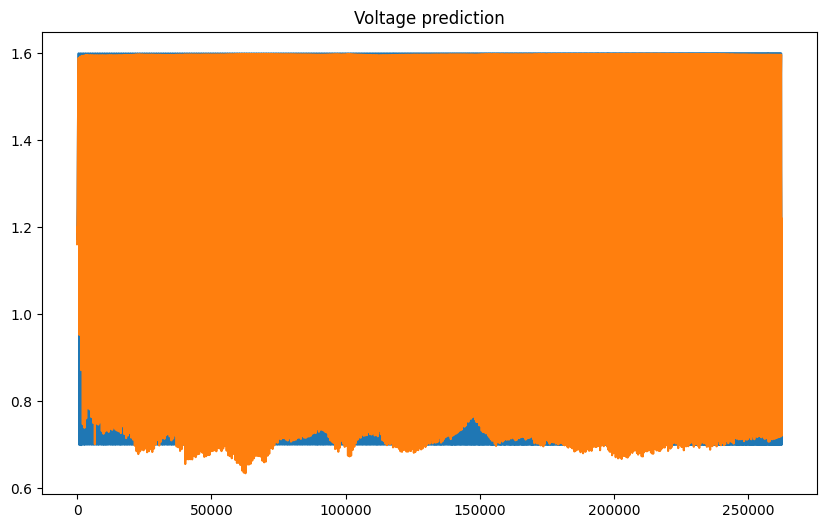

In [13]:
X = torch.Tensor(dataset.x)
X1 = torch.reshape(X, (X.shape[0], 1, X.shape[1]))

Y = torch.Tensor(dataset.y)

train_predict = model(X1)
predicted = train_predict.data.numpy()
label_y = Y.data.numpy()

plt.figure(figsize=(10,6))

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
#plt.xlim(180000,200000)
plt.title('Voltage prediction')
plt.show()